In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
debug_mode = False
show_plots = True

## Camera Constants

In [3]:

class Camera:
    def __init__(self, num_x_points, num_y_points, debug_mode=False):
        # Number of x points in test images
        self.num_x_points = num_x_points
        # Number of y points in test images
        self.num_y_points = num_y_points
        # Camera Matrix
        self.mtx = 0
        # Camera Distortion coefficients
        self.dist = 0
        # Camera rotation vectors
        self.rvecs = 0
        # Camera translation vectors
        self.tvecs = 0
        # Debug mode
        self.debug_mode = debug_mode
        # Source coords for perspective xform
        self.src_coords = np.float32([[240, 719],
                                      [579, 450],
                                      [712, 450],
                                      [1165, 719]])
        # Dest coords for perspective xform
        self.dst_coords = np.float32([[300, 719],
                                      [300, 0],
                                      [900, 0],
                                      [900, 719]])
        # Perspective Transform matrix
        self.M = cv2.getPerspectiveTransform(self.src_coords, self.dst_coords)
        # Inverse Perspective Transform matrix
        self.Minv = cv2.getPerspectiveTransform(self.dst_coords, self.src_coords)

    def set_debug_mode(self, mode):
        self.debug_mode = mode

    def calibrate_camera(self, files):
        print("Calibrating camera...")
        images = glob.glob(files)

        objpoints = []  # 3D points in real world space
        imgpoints = []  # 2S points in image plane

        # Prepare objpoints like (0,0,0), (1,0,0), ... (7,5,0)
        objp = np.zeros((self.num_y_points * self.num_x_points, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.num_x_points, 0:self.num_y_points].T.reshape(-1, 2)

        # Read in images and find chessboard corners
        for fname in images:
            # Read in
            img = mpimg.imread(fname)
            # Convert image to gray
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.num_x_points, self.num_y_points), None)

            # If corners are found, add object points, image points
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)

                # draw and display the corners
                img = cv2.drawChessboardCorners(img, (self.num_x_points, self.num_y_points), corners, ret)
            else:
                print("    Warning: Could not find correct number of corners for image {}".format(fname))

        # Get camera calibration params
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],
                                                                               None, None)

    def undistort_image(self, img):
        # Apply distortion correction to the image
        undist_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        return undist_img

    def threshold_binary(self, img):
        if self.debug_mode:
            plt.imshow(img)
            plt.title('Orig Image')
            plt.show()
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:, :, 2]
        if self.debug_mode:
            plt.imshow(s_channel)
            plt.title('S Channel')
            plt.show()

        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
        abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        if self.debug_mode:
            plt.imshow(scaled_sobel)
            plt.title('Sobel X')
            plt.show()

        # Threshold x gradient
        thresh_min = 30
        thresh_max = 150
        sxbinary = np.zeros_like(scaled_sobel)
        # sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        retval, sxthresh = cv2.threshold(scaled_sobel, 30, 150, cv2.THRESH_BINARY)
        sxbinary[(sxthresh >= thresh_min) & (sxthresh <= thresh_max)] = 1
        if self.debug_mode:
            plt.imshow(sxthresh)
            plt.title('sxthresh')
            plt.show()
            plt.imshow(sxbinary)
            plt.title('Threshold Gradient')
            plt.show()

        # Threshold color channel
        s_thresh_min = 175
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        # Use inRange instead of multiple thresholds
        # retval, s_thresh1 = cv2.threshold(s_channel.astype('uint8'), 175, 255, cv2.THRESH_BINARY)
        # retval, s_thresh2 = cv2.threshold(s_channel.astype('uint8'), 250, 255, cv2.THRESH_BINARY)
        # s_thresh = np.zeros_like(s_binary)
        # s_thresh = s_thresh1 - s_thresh2
        # s_binary[(s_thresh >= s_thresh_min) & (s_thresh <= s_thresh_max)] = 1
        s_thresh = cv2.inRange(s_channel.astype('uint8'), 175, 250)

        s_binary[(s_thresh == 255)] = 1
        if self.debug_mode:
            plt.imshow(s_thresh)
            plt.title('s_thresh')
            plt.show()
            plt.imshow(s_binary)
            plt.title('Threshold Binary')
            plt.show()

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        if self.debug_mode:
            color_binary = np.dstack((np.zeros_like(sxthresh), sxthresh, s_thresh))
            plt.imshow(color_binary)
            plt.title('Color Binary')
            plt.show()

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

        # Plotting thresholded images
        if self.debug_mode:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            ax1.set_title('Stacked thresholds')
            ax1.imshow(color_binary)

            ax2.set_title('Combined S channel and gradient thresholds')
            ax2.imshow(combined_binary, cmap='gray')
            plt.show()

        return combined_binary

    def perspective_transform(self, img):
        img_size = (img.shape[1], img.shape[0])
        perspective_img = cv2.warpPerspective(img, self.M, img_size, flags=cv2.INTER_LINEAR)
        return perspective_img


## Lane Constants

In [7]:

class Lanes:
    def __init__(self, debug_mode=False, show_plots=False):
        # Frame counter (used for finding new lanes)
        self.frame_number = 0
        # Lane locations from previous frame
        self.last_left_x = 0
        self.last_right_x = 0
        # Lane locations from current frame
        self.left_x = 0
        self.right_x = 0
        # Lane persp image
        self.left_lane_img = 0
        self.right_lane_img = 0
        # Lane persp debug image
        self.lane_debug_img = 0
        # Frames since lane last detected
        # Init with large value to trigger full scan
        self.left_last_seen = 999
        self.right_last_seen = 999
        # Lane fit coords
        self.left_fitx = 0
        self.left_fity = 0
        self.right_fitx = 0
        self.right_fity = 0
        # Lane radius of curvature
        self.left_curverad = 0
        self.right_curverad = 0
        # Lanes found in last frame?
        self.left_lane_found = False
        self.right_lane_found = False
        # Lane polynomial fits
        self.left_fit = []
        self.right_fit = []
        # Debug Mode
        self.debug_mode = debug_mode
        # Debug Mode
        self.show_plots = show_plots

    def full_scan(self, hist):
        if self.debug_mode:
            print("Running full scan...")
        num_pixels_x = len(hist)
        left_side = hist[0:int(num_pixels_x / 2)]
        left_peak_x = np.argmax(left_side)
        right_side = hist[int(num_pixels_x / 2):]
        right_peak_x = np.argmax(right_side)
        right_offset = int(num_pixels_x / 2)
        right_peak_x += right_offset
        return left_peak_x, right_peak_x

    def get_two_peak_x_coords(self, hist, prev_left_x=-1, prev_right_x=-1, start_y=0, end_y=0,
                              found_last_left=False, found_last_right=False, left_trend=0, right_trend=0):
        num_pixels_x = len(hist)
        left_window = 40
        right_window = 40
        found_left = True
        found_right = True

        if not found_last_left:
            left_window = 60
        if not found_last_right:
            right_window = 60
        if start_y == 720:
            left_window = 100
            right_window = 100

        left_offset = 0
        if self.left_lane_found:
            new_left_peak = int(self.left_fit[0] * start_y ** 2 + self.left_fit[1] * start_y + self.left_fit[2])
            if self.debug_mode:
                print("    LEFT USING POLY : {}".format(new_left_peak))
                cv2.rectangle(self.lane_debug_img, (new_left_peak - left_window, start_y),
                              (new_left_peak + left_window, end_y), (0, 255, 0), thickness=2)
        else:
            left_side = hist[prev_left_x + left_trend - left_window:prev_left_x + left_trend + left_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_left_x + left_trend - left_window, start_y),
                              (prev_left_x + left_trend + left_window, end_y), (255, 0, 0), thickness=2)
            new_left_peak = 0
            if len(left_side) > 0:
                if self.debug_mode:
                    print("    LEFT MINI SCAN")
                new_left_peak = np.argmax(left_side)
                left_offset = prev_left_x + left_trend - left_window
            if new_left_peak == 0 or len(left_side) == 0:
                if self.debug_mode:
                    print("    LEFT USE PREV")
                new_left_peak = prev_left_x + left_trend
                left_offset = 0
                found_left = False
        left_peak_x = new_left_peak + left_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (left_peak_x, start_y), (left_peak_x, end_y), (0, 255, 255), thickness=2)

        right_offset = 0
        if self.right_lane_found:
            new_right_peak = int(self.right_fit[0] * start_y ** 2 + self.right_fit[1] * start_y + self.right_fit[2])
            if self.debug_mode:
                print("    RIGHT USING POLY : {}".format(new_right_peak))
                cv2.rectangle(self.lane_debug_img, (new_right_peak - right_window, start_y),
                              (new_right_peak + right_window, end_y), (0, 255, 0), thickness=2)
        else:
            right_side = hist[prev_right_x + right_trend - right_window:prev_right_x + right_trend + right_window]
            if self.debug_mode:
                cv2.rectangle(self.lane_debug_img, (prev_right_x + right_trend - right_window, start_y),
                              (prev_right_x + right_trend + right_window, end_y), (255, 255, 0), thickness=2)
            new_right_peak = 0
            if len(right_side) > 0:
                if self.debug_mode:
                    print("    RIGHT MINI SCAN")
                new_right_peak = np.argmax(right_side)
                right_offset = prev_right_x + right_trend - right_window
            if new_right_peak == 0 or len(right_side) == 0:
                if self.debug_mode:
                    print("    RIGHT USE PREV")
                new_right_peak = prev_right_x + right_trend
                right_offset = 0
                found_right = False
        right_peak_x = new_right_peak + right_offset
        if self.debug_mode:
            cv2.line(self.lane_debug_img, (right_peak_x, start_y), (right_peak_x, end_y), (0, 255, 255),
                     thickness=2)

        if start_y == 720:
            new_left_trend = 0
            new_right_trend = 0
        else:
            new_left_trend = left_peak_x - prev_left_x
            new_right_trend = right_peak_x - prev_right_x

        return left_peak_x, right_peak_x, found_left, found_right, new_left_trend, new_right_trend

    def locate_lanes(self, img):
        if self.debug_mode:
            print("Frame # {}".format(self.frame_number))
        # Is this the first frame of video?
        if self.frame_number == 0 or self.left_last_seen > 5 or self.right_last_seen > 5:
            # Generate histogram over bottom half of image
            histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
            # Find X coords of two peaks of histogram
            est_left_x, est_right_x = self.full_scan(histogram)
            if self.debug_mode:
                print("est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                if self.show_plots:
                    plt.imshow(img)
                    plt.show()
                    plt.plot(histogram)
                    plt.show()
        else:
            est_left_x = self.last_left_x
            est_right_x = self.last_right_x

        fallback_left_x = est_left_x
        fallback_right_x = est_right_x
        left_trend = 0
        right_trend = 0

        # Run a sliding window up the image to detect pixels
        self.left_lane_img = np.zeros(img.shape[0:2], np.float32)
        self.right_lane_img = np.zeros(img.shape[0:2], np.float32)
        temp_img = img * 255
        self.lane_debug_img = np.dstack((temp_img, temp_img, temp_img))

        found_last_left = False
        found_last_right = False
        left_window = 40
        right_window = 40
        left_conc_sections = 0
        right_conc_sections = 0
        for i in range(10, 0, -1):
            start_y = int(i * img.shape[0] / 10)
            end_y = int((i - 1) * img.shape[0] / 10)
            img_sect = img[end_y:start_y, :]
            histogram = np.sum(img_sect, axis=0)
            left_x, right_x, found_last_left, found_last_right, new_left_trend, new_right_trend = self.get_two_peak_x_coords(
                histogram, est_left_x, est_right_x, start_y, end_y, found_last_left, found_last_right, left_trend,
                right_trend)
            left_trend = int((new_left_trend + left_trend) / 2)
            right_trend = int((new_right_trend + right_trend) / 2)
            # Store the left/right x values for bottom of image
            if i == 10:
                # Set the new last values
                self.left_x = left_x
                self.right_x = right_x

            if not found_last_left:
                left_x = fallback_left_x
                left_conc_sections = 0
            elif left_conc_sections > 1:
                fallback_left_x = left_x
            if not found_last_right:
                right_x = fallback_right_x
                right_conc_sections = 0
            elif right_conc_sections > 1:
                fallback_right_x = right_x

            if found_last_left:
                left_conc_sections += 1
            if found_last_right:
                right_conc_sections += 1

            if self.debug_mode:
                print("i: {} Start_y: {} End_y: {}".format(i, start_y, end_y))
                print("    est_left_x : {}, est_right_x : {}".format(est_left_x, est_right_x))
                print("    left_x : {}, right_x : {}".format(left_x, right_x))
                print("    left_window : {}, right_window : {}".format(left_window, right_window))
                print("    left_trend : {}, right_trend : {}".format(left_trend, right_trend))
                if self.show_plots:
                    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                    f.tight_layout()
                    ax1.plot(histogram)
                    ax2.imshow(img_sect, cmap='gray')
                    plt.show()

            # Fill in the left lane image
            left_mask = np.zeros_like(img_sect)
            left_mask[:, left_x - left_window:left_x + left_window] = 1
            mask = (left_mask == 1)
            self.left_lane_img[end_y:start_y, :] = img_sect & mask

            # Fill in the right lane image
            right_mask = np.zeros_like(img_sect)
            right_mask[:, right_x - right_window:right_x + right_window] = 1
            mask = (right_mask == 1)
            self.right_lane_img[end_y:start_y, :] = img_sect & mask

            # Set the new last values
            est_left_x = left_x
            est_right_x = right_x

        self.frame_number += 1

    def fit_lane(self, img):
        # Extract the list of x and y coords that are non-zero pixels
        xycoords = np.nonzero(img)
        x_arr = xycoords[1]
        y_arr = xycoords[0]

        # Fit a second order polynomial to each fake lane line
        fit = np.polyfit(y_arr, x_arr, deg=2)
        fitx = fit[0] * y_arr ** 2 + fit[1] * y_arr + fit[2]

        # Find RoC in pixel space
        # y_eval = np.max(y_arr)
        # curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) \
        #                         /np.absolute(2*fit[0])

        # Ensure we have points for min(0) & max(719) y
        # This will extend the lines in cases where the lanes
        # dont have pixels all the way to top/bottom of image
        fitx = np.insert(fitx, 0, fit[0] * 0 ** 2 + fit[1] * 0 + fit[2])
        fity = np.insert(y_arr, 0, 0)
        fitx = np.append(fitx, fit[0] * 719 ** 2 + fit[1] * 719 + fit[2])
        fity = np.append(fity, 719)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension
        y_eval = np.max(y_arr)
        fit_cr = np.polyfit(y_arr * ym_per_pix, x_arr * xm_per_pix, 2)
        fitx_cr = fit_cr[0] * (y_arr * ym_per_pix) ** 2 + fit_cr[1] * y_arr * ym_per_pix + fit_cr[2]

        # Get radius of curvature
        curverad = ((1 + (2 * fit_cr[0] * y_eval + fit_cr[1]) ** 2) ** 1.5) \
                   / np.absolute(2 * fit_cr[0])

        return fit, fitx, fity, curverad

    def check_lane(self, new_roc, prev_roc, new_x, prev_x):
        # Check RoC against standards
        # if new_roc < 587 or new_roc > 4575:
        if new_roc < 587:
            if self.debug_mode:
                print("Lane Discarded! : Frame {}, Lane RoC out of bounds {} (587)".format(self.frame_number - 1,
                                                                                           new_roc))
            return False

        # Check previous x coord versus current for major difference
        delta = 15
        if new_x > prev_x + delta or new_x < prev_x - delta:
            if self.debug_mode:
                print("Lane Discarded! : Frame {}, Lane X {} greater than {} pixels away from previous {}".format(
                    self.frame_number - 1, new_x, delta, prev_x))
            return False

        # Check RoC against previous value
        max_roc = prev_roc * 100.0
        min_roc = prev_roc / 100.0
        if new_roc >= min_roc and new_roc <= max_roc:
            return True
        else:
            if self.debug_mode:
                print("Lane Discarded! : Frame {}, Lane RoC {} too different than previous value {}".format(
                    self.frame_number - 1, new_roc, prev_roc))
            return False

    def fit_lanes(self):
        self.left_lane_found = False
        self.right_lane_found = False
        # Get new lane fit for left lane
        left_fit, left_fitx, left_fity, left_curverad = self.fit_lane(self.left_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(left_curverad, self.left_curverad, self.left_x,
                                                     self.last_left_x):
            self.left_fit = left_fit
            self.left_fitx = left_fitx
            self.left_fity = left_fity
            self.left_curverad = left_curverad
            self.left_lane_found = True
            self.left_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Left Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number - 1,
                                                                                            left_curverad,
                                                                                            self.last_left_x,
                                                                                            self.left_x))
            self.last_left_x = self.left_x
        else:
            self.left_last_seen += 1
            if self.debug_mode:
                print("Left Lane NOT found! ({})".format(self.left_last_seen))

        # Get new lane fit for right lane
        right_fit, right_fitx, right_fity, right_curverad = self.fit_lane(self.right_lane_img)
        # Only use this new lane fit if it's close to the previous one (for smoothing)
        if self.frame_number == 1 or self.check_lane(right_curverad, self.right_curverad, self.right_x,
                                                     self.last_right_x):
            self.right_fit = right_fit
            self.right_fitx = right_fitx
            self.right_fity = right_fity
            self.right_curverad = right_curverad
            self.right_lane_found = True
            self.right_last_seen = 0
            if self.debug_mode:
                print("Frame : {} Right Lane found! RoC : {} Prev X : {} Curr X : {}".format(self.frame_number - 1,
                                                                                             right_curverad,
                                                                                             self.last_right_x,
                                                                                             self.right_x))
            self.last_right_x = self.right_x
        else:
            self.right_last_seen += 1
            if self.debug_mode:
                print("Right Lane NOT found! ({})".format(self.right_last_seen))

    def draw_lanes(self, img, warped, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.left_fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.right_fity])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Draw lane lines only if lane was detected this frame
        if self.left_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_left]), False, (0, 0, 255), thickness=20)
        if self.right_lane_found == True:
            cv2.polylines(color_warp, np.int_([pts_right]), False, (255, 0, 0), thickness=20)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        # Write the radius of curvature for each lane
        font = cv2.FONT_HERSHEY_SIMPLEX
        left_roc = "Roc: {0:.2f}m".format(self.left_curverad)
        cv2.putText(result, left_roc, (10, 650), font, 1, (255, 255, 255), 2)
        right_roc = "Roc: {0:.2f}m".format(self.right_curverad)
        cv2.putText(result, right_roc, (1020, 650), font, 1, (255, 255, 255), 2)

        # Write the x coords for each lane
        left_coord = "X  : {0:.2f}".format(self.left_x)
        cv2.putText(result, left_coord, (10, 700), font, 1, (255, 255, 255), 2)
        right_coord = "X  : {0:.2f}".format(self.last_right_x)
        cv2.putText(result, right_coord, (1020, 700), font, 1, (255, 255, 255), 2)

        # Write dist from center
        perfect_center = 1280 / 2.
        lane_x = self.last_right_x - self.left_x
        center_x = (lane_x / 2.0) + self.left_x
        cms_per_pixel = 370.0 / lane_x  # US regulation lane width = 3.7m
        dist_from_center = (center_x - perfect_center) * cms_per_pixel
        dist_text = "Dist from Center: {0:.2f} cms".format(dist_from_center)
        cv2.putText(result, dist_text, (450, 50), font, 1, (255, 255, 255), 2)

        return result



Calibrating camera...
Original image


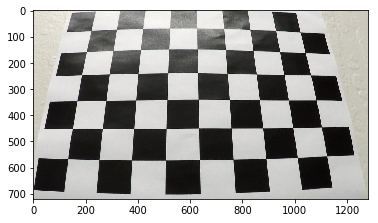

Undistored image


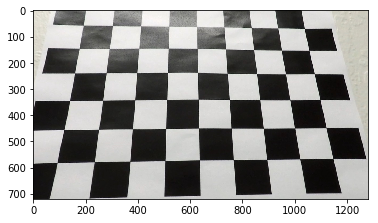

Thresholded image


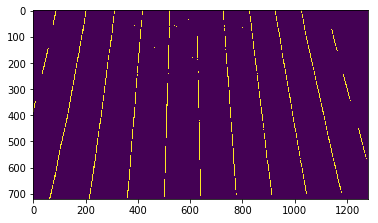

Perspective Transformed Image


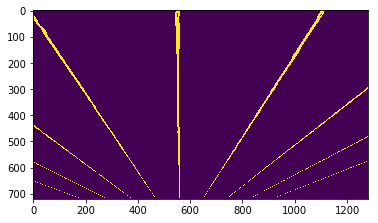

...


In [8]:
camera = Camera(num_x_points=9, num_y_points=6, debug_mode=False)

# First lets calibrate the camera
camera.calibrate_camera(files="camera_cal/calibration*.jpg")

# Un-distort test calibration image as demo that calibration is correct
print("Original image")
img = mpimg.imread("camera_cal/calibration3.jpg")
plt.imshow(img)
plt.show()

print("Undistored image")
undist = camera.undistort_image(img)
plt.imshow(undist)
plt.show()

print("Thresholded image")
binary_img = camera.threshold_binary(undist)
plt.imshow(binary_img)
plt.show()

print("Perspective Transformed Image")
persp_img = camera.perspective_transform(binary_img)
plt.imshow(persp_img)
plt.show()


print('...')

## Pipeline

In [11]:
lanes = Lanes(debug_mode=True)

# Define the pipeline
def process_image(original_img):
    # Apply distortion correction to the image
    undist = camera.undistort_image(original_img)
    # Get the binary image using thresholding etc
    binary_img = camera.threshold_binary(undist)
    # Apply perspective transform
    persp_img = camera.perspective_transform(binary_img)
    # Locate the lane lines
    lanes.locate_lanes(persp_img)
    # Fit polynomials and set lane x/y arrays
    lanes.fit_lanes()
    # Draw lines back onto road
    combined_img = lanes.draw_lanes(undist, persp_img, camera.Minv)
    return combined_img

print('...')

...


original image
Frame # 0
Running full scan...
est_left_x : 318, est_right_x : 885
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 885
    left_x : 302, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 900
    left_x : 318, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -11
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 878
    left_x : 329, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT MINI SCAN
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 329, est_right_x : 883
    left_x : 337, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT MINI SCAN
    RIGHT M

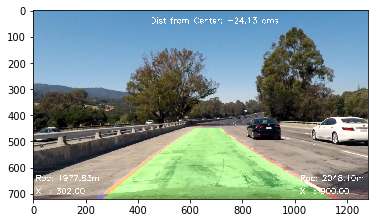

Frame # 1
    LEFT USING POLY : 305
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 900
    left_x : 305, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 897
    left_x : 311, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 319
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 888
    left_x : 319, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 329
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 882
    left_x : 329, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 343
    RIGHT USING POLY : 877
i: 6 Start_y:

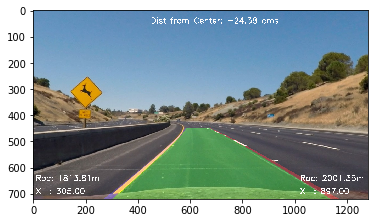

Frame # 2
    LEFT USING POLY : 330
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 897
    left_x : 330, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 892
    left_x : 337, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 342
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 888
    left_x : 342, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 346
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 882
    left_x : 346, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 347
    RIGHT USING POLY : 860
i: 6 Start_y:

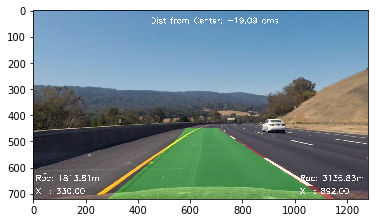

Frame # 3
    LEFT MINI SCAN
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 892
    left_x : 313, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 882
    left_x : 321, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 880
    left_x : 338, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 878
    left_x : 359, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 877
i: 6 Start_y: 432 End_y: 360
    est_left_x : 

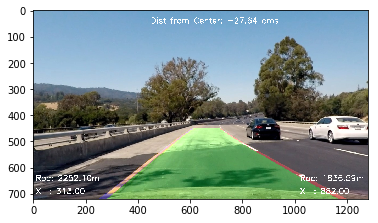

Frame # 4
    LEFT USING POLY : 317
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 882
    left_x : 317, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 912
    left_x : 326, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 903
    left_x : 335, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 345
    RIGHT USING POLY : 891
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 896
    left_x : 345, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 356
    RIGHT USING POLY : 888
i: 6 Start_y:

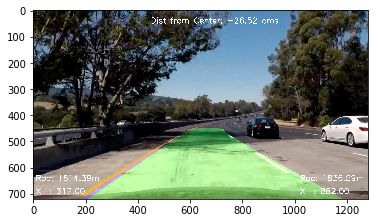

Frame # 5
    LEFT USING POLY : 270
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 882
    left_x : 270, right_x : 815
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 281
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 270, est_right_x : 815
    left_x : 281, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 293
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 281, est_right_x : 882
    left_x : 293, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 4
    LEFT USING POLY : 307
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 293, est_right_x : 890
    left_x : 307, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 13
    LEFT USING POLY : 323
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 6 Start_

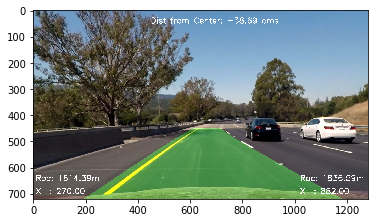

Frame # 6
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 10 Start_y: 718 End_y: 646
    est_left_x : 317, est_right_x : 882
    left_x : 261, right_x : 875
    left_window : 40, right_window : 40
    left_trend : -28, right_trend : -3
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 9 Start_y: 646 End_y: 574
    est_left_x : 261, est_right_x : 875
    left_x : 272, right_x : 869
    left_window : 40, right_window : 40
    left_trend : -8, right_trend : -4
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 8 Start_y: 574 End_y: 502
    est_left_x : 272, est_right_x : 869
    left_x : 275, right_x : 883
    left_window : 40, right_window : 40
    left_trend : -2, right_trend : 5
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 7 Start_y: 502 End_y: 430
    est_left_x : 275, est_right_x : 883
    left_x : 298, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT MINI SCAN
    RIGHT MINI SCAN
i: 6 Start_y: 430 End_y: 359
    est_left_x : 298, est_right_x : 870
    left_

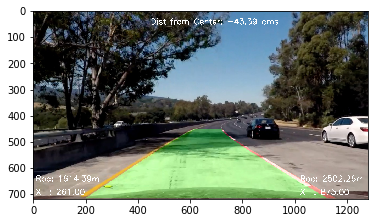

Frame # 7
    LEFT MINI SCAN
    RIGHT USING POLY : 889
i: 10 Start_y: 719 End_y: 647
    est_left_x : 317, est_right_x : 875
    left_x : 272, right_x : 889
    left_window : 40, right_window : 40
    left_trend : -22, right_trend : 7
    LEFT MINI SCAN
    RIGHT USING POLY : 878
i: 9 Start_y: 647 End_y: 575
    est_left_x : 272, est_right_x : 889
    left_x : 271, right_x : 878
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -2
    LEFT MINI SCAN
    RIGHT USING POLY : 871
i: 8 Start_y: 575 End_y: 503
    est_left_x : 271, est_right_x : 878
    left_x : 284, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -4
    LEFT MINI SCAN
    RIGHT USING POLY : 868
i: 7 Start_y: 503 End_y: 431
    est_left_x : 284, est_right_x : 871
    left_x : 308, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 868
i: 6 Start_y: 431 End_y: 359
    est_left_x

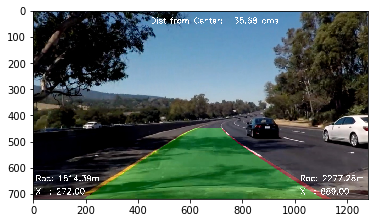

In [12]:
print("original image")
images = glob.glob("test_images/test*.jpg")
images.sort()
for fname in images:
    img = mpimg.imread(fname)
    combined_img = process_image(img)
    plt.imshow(combined_img)
    plt.show()

In [13]:
mtx, dist = calibrate_camera(nx=9, ny=6, files="camera_cal/calibration*.jpg")
print("Running on test images...")
#####################################
# Run our pipeline on the test images
#####################################
images = glob.glob("test_images/test*.jpg")
images.sort()

# Setup the plot grid for test images
i = 0

for fname in images:
    print("Processing image {}".format(fname))

    # Next, let's read in a test image
    img = mpimg.imread(fname)
    plt.imshow(img)
    plt.show()

    # Process the image using our pipeline
    combined_img = process_image(img)
    plt.imshow(combined_img)
    plt.show()

    i += 2

NameError: name 'calibrate_camera' is not defined

In [14]:
print("Running on test video1...")
#####################################
# Run our pipeline on the test video
#####################################
clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_processed.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)
print('...')

Running on test video1...
Frame # 8
    LEFT MINI SCAN
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 889
    left_x : 325, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 867
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 874
    left_x : 328, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 867
    left_x : 332, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 863
    left_x : 334, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 866
i: 6 Start_y: 432 End_

  0%|          | 0/1261 [00:00<?, ?it/s]

Frame # 9
    LEFT USING POLY : 324
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 874
    left_x : 324, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 901
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 910
    left_x : 335, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 342
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 901
    left_x : 342, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 345
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 891
    left_x : 345, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -10
    LEFT USING POLY : 346
    RIGHT USING POLY : 865
i: 6 Start_y

  0%|          | 1/1261 [00:00<03:40,  5.72it/s]


    LEFT USING POLY : 337
    RIGHT USING POLY : 832
i: 4 Start_y: 288 End_y: 216
    est_left_x : 343, est_right_x : 849
    left_x : 337, right_x : 832
    left_window : 40, right_window : 40
    left_trend : -3, right_trend : -15
    LEFT USING POLY : 328
    RIGHT USING POLY : 813
i: 3 Start_y: 216 End_y: 144
    est_left_x : 337, est_right_x : 832
    left_x : 328, right_x : 813
    left_window : 40, right_window : 40
    left_trend : -6, right_trend : -17
    LEFT USING POLY : 316
    RIGHT USING POLY : 793
i: 2 Start_y: 144 End_y: 72
    est_left_x : 328, est_right_x : 813
    left_x : 316, right_x : 793
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -18
    LEFT USING POLY : 300
    RIGHT USING POLY : 771
i: 1 Start_y: 72 End_y: 0
    est_left_x : 316, est_right_x : 793
    left_x : 300, right_x : 771
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -20
Frame : 9 Left Lane found! RoC : 2380.9960991627004 Prev X : 325 Curr 

  0%|          | 2/1261 [00:00<03:40,  5.72it/s]

Frame # 11
    LEFT USING POLY : 325
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 874
    left_x : 325, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 918
    left_x : 336, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -14
    LEFT USING POLY : 343
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 890
    left_x : 343, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 346
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 886
    left_x : 346, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -15
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x :

  0%|          | 3/1261 [00:00<03:35,  5.84it/s]

Frame # 12
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 874
    left_x : 327, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 921
    left_x : 337, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -15
    LEFT USING POLY : 344
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 890
    left_x : 344, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -15
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 874
    left_x : 347, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 

  0%|          | 4/1261 [00:00<03:39,  5.74it/s]

Frame # 13
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 874
    left_x : 329, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 924
    left_x : 338, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 345
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 914
    left_x : 345, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 348
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 874
    left_x : 348, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 348
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360

  0%|          | 5/1261 [00:00<03:45,  5.57it/s]

Frame # 14
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 874
    left_x : 329, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 920
    left_x : 338, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 345
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 910
    left_x : 345, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -19
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 877
    left_x : 347, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -27
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x :

  0%|          | 6/1261 [00:01<03:49,  5.47it/s]


    left_trend : -7, right_trend : -24
    LEFT USING POLY : 314
    RIGHT MINI SCAN
i: 2 Start_y: 144 End_y: 72
    est_left_x : 327, est_right_x : 769
    left_x : 314, right_x : 716
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -38
    LEFT USING POLY : 298
    RIGHT MINI SCAN
i: 1 Start_y: 72 End_y: 0
    est_left_x : 314, est_right_x : 716
    left_x : 298, right_x : 679
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -37
Frame : 14 Left Lane found! RoC : 2367.8130649047116 Prev X : 329 Curr X : 329
Lane Discarded! : Frame 14, Lane X 920 greater than 15 pixels away from previous 874
Right Lane NOT found! (6)
Frame # 15
Running full scan...
est_left_x : 336, est_right_x : 846
    LEFT USING POLY : 330
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 336, est_right_x : 846
    left_x : 330, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
  

  1%|          | 7/1261 [00:01<03:52,  5.40it/s]

Frame # 16
Running full scan...
est_left_x : 353, est_right_x : 854
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 353, est_right_x : 854
    left_x : 332, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 922
    left_x : 340, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -19
    LEFT USING POLY : 346
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 883
    left_x : 346, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -19
    LEFT USING POLY : 348
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 854
    left_x : 348, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING 

  1%|          | 8/1261 [00:01<03:53,  5.37it/s]

Frame # 17
Running full scan...
est_left_x : 335, est_right_x : 864
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 335, est_right_x : 864
    left_x : 335, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 343
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 913
    left_x : 343, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 343, est_right_x : 891
    left_x : 347, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -21
    LEFT USING POLY : 349
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 347, est_right_x : 860
    left_x : 349, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -12
    LEFT USING POLY : 347
    RIG

  1%|          | 9/1261 [00:01<03:54,  5.33it/s]

Frame # 18
Running full scan...
est_left_x : 334, est_right_x : 865
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 865
    left_x : 336, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 336, est_right_x : 912
    left_x : 342, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 346
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 342, est_right_x : 897
    left_x : 346, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -19
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 865
    left_x : 347, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -14
    LEFT USING POLY : 345
    RIGH

  1%|          | 10/1261 [00:01<03:51,  5.40it/s]

Frame # 19
Running full scan...
est_left_x : 334, est_right_x : 875
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 875
    left_x : 335, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 341
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 901
    left_x : 341, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 345
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 341, est_right_x : 875
    left_x : 345, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 4
    LEFT USING POLY : 346
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 883
    left_x : 346, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY

  1%|          | 11/1261 [00:02<03:58,  5.24it/s]

Lane Discarded! : Frame 19, Lane X 901 greater than 15 pixels away from previous 874
Right Lane NOT found! (11)
Frame # 20
Running full scan...
est_left_x : 330, est_right_x : 883
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 883
    left_x : 336, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 336, est_right_x : 910
    left_x : 342, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 345
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 342, est_right_x : 880
    left_x : 345, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 345
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 883
    left_x : 345, right_x : 879


  1%|          | 12/1261 [00:02<03:57,  5.26it/s]

Frame # 21
Running full scan...
est_left_x : 330, est_right_x : 881
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 881
    left_x : 335, right_x : 800
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 800
    left_x : 340, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 881
    left_x : 342, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 341
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 881
    left_x : 341, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
 

  1%|          | 13/1261 [00:02<03:49,  5.43it/s]

Frame # 22
Running full scan...
est_left_x : 330, est_right_x : 890
    LEFT USING POLY : 335
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 890
    left_x : 335, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 890
    left_x : 340, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 890
    left_x : 342, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 2
    LEFT USING POLY : 341
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 895
    left_x : 341, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 2
 

  1%|          | 14/1261 [00:02<03:40,  5.65it/s]

Frame # 23
Running full scan...
est_left_x : 331, est_right_x : 895
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 895
    left_x : 335, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 912
    left_x : 339, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 341
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 901
    left_x : 341, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -14
    LEFT USING POLY : 341
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 878
    left_x : 341, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -25
    LEFT USING POLY : 338
    RIGH

  1%|          | 15/1261 [00:02<03:34,  5.80it/s]

Frame # 24
Running full scan...
est_left_x : 332, est_right_x : 897
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 332, est_right_x : 897
    left_x : 335, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 897
    left_x : 340, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 898
    left_x : 342, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 897
    left_x : 342, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -26
    LEFT USING POL

  1%|▏         | 16/1261 [00:02<03:34,  5.81it/s]

Frame # 25
Running full scan...
est_left_x : 331, est_right_x : 902
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 902
    left_x : 335, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 912
    left_x : 340, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -13
    LEFT USING POLY : 343
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 886
    left_x : 343, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -16
    LEFT USING POLY : 343
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 866
    left_x : 343, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -13
    LEFT USING POLY : 340
    RIG

  1%|▏         | 17/1261 [00:03<03:31,  5.87it/s]

Frame # 26
Running full scan...
est_left_x : 348, est_right_x : 820
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 348, est_right_x : 820
    left_x : 332, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 908
    left_x : 338, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING POLY : 341
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 889
    left_x : 341, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -22
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 853
    left_x : 342, right_x : 818
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -28
    LEFT USING POLY : 339
    RIGH

  1%|▏         | 18/1261 [00:03<03:31,  5.89it/s]

Frame # 27
Running full scan...
est_left_x : 346, est_right_x : 830
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 346, est_right_x : 830
    left_x : 332, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 898
    left_x : 338, right_x : 830
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 341
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 830
    left_x : 341, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 16
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 863
    left_x : 342, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -2
    LEFT USING POL

  2%|▏         | 19/1261 [00:03<03:28,  5.95it/s]

Frame # 28
Running full scan...
est_left_x : 327, est_right_x : 839
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 839
    left_x : 331, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 331, est_right_x : 903
    left_x : 336, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -18
    LEFT USING POLY : 339
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 867
    left_x : 339, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 339
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 874
    left_x : 339, right_x : 833
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -23
    LEFT USING POLY : 337
    RIGH

  2%|▏         | 20/1261 [00:03<03:26,  6.00it/s]

Frame # 29
Running full scan...
est_left_x : 343, est_right_x : 847
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 343, est_right_x : 847
    left_x : 329, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 902
    left_x : 335, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -11
    LEFT USING POLY : 338
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 879
    left_x : 338, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -11
    LEFT USING POLY : 338
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 847
    left_x : 338, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : 0
    LEFT USING P

  2%|▏         | 21/1261 [00:03<03:25,  6.03it/s]

Frame # 30
Running full scan...
est_left_x : 324, est_right_x : 852
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 852
    left_x : 329, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 906
    left_x : 334, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -10
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 886
    left_x : 336, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -21
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 853
    left_x : 336, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -13
    LEFT USING POLY : 333
    RIG

  2%|▏         | 22/1261 [00:03<03:26,  5.99it/s]

Frame # 31
Running full scan...
est_left_x : 321, est_right_x : 860
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 860
    left_x : 327, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 890
    left_x : 331, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 1
    LEFT USING POLY : 333
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 893
    left_x : 333, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -15
    LEFT USING POLY : 333
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 861
    left_x : 333, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -13
    LEFT USING POLY : 330
    RIGHT

  2%|▏         | 23/1261 [00:04<03:30,  5.88it/s]

Frame # 32
Running full scan...
est_left_x : 321, est_right_x : 870
    LEFT USING POLY : 325
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 870
    left_x : 325, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 894
    left_x : 329, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 329, est_right_x : 870
    left_x : 331, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 5
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 881
    left_x : 331, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -2
    LEFT USING POLY

  2%|▏         | 24/1261 [00:04<03:35,  5.73it/s]

Frame # 33
Running full scan...
est_left_x : 338, est_right_x : 871
    LEFT USING POLY : 322
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 338, est_right_x : 871
    left_x : 322, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 902
    left_x : 328, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -16
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 870
    left_x : 331, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 871
    left_x : 331, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -10
    LEFT USING POLY : 329
    RIGH

  2%|▏         | 25/1261 [00:04<03:37,  5.68it/s]

Frame # 34
Running full scan...
est_left_x : 318, est_right_x : 877
    LEFT USING POLY : 320
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 877
    left_x : 320, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 906
    left_x : 327, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 896
    left_x : 331, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 332
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 886
    left_x : 332, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING PO

  2%|▏         | 26/1261 [00:04<03:35,  5.72it/s]

Frame # 35
Running full scan...
est_left_x : 318, est_right_x : 893
    LEFT USING POLY : 318
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 893
    left_x : 318, right_x : 800
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 800
    left_x : 324, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 893
    left_x : 328, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 330
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 893
    left_x : 330, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -18
    LEFT USING POL

  2%|▏         | 27/1261 [00:04<03:30,  5.85it/s]

Frame # 36
Running full scan...
est_left_x : 315, est_right_x : 895
    LEFT USING POLY : 316
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 895
    left_x : 316, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 893
    left_x : 323, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 5
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 903
    left_x : 328, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 879
    left_x : 329, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 328
    RIGHT M

  2%|▏         | 28/1261 [00:04<03:28,  5.93it/s]

Frame # 37
Running full scan...
est_left_x : 315, est_right_x : 907
    LEFT USING POLY : 314
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 907
    left_x : 314, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 914
    left_x : 321, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 325
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 905
    left_x : 325, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 907
    left_x : 327, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -27
    LEFT USING P

  2%|▏         | 29/1261 [00:05<03:27,  5.94it/s]

Frame # 38
Running full scan...
est_left_x : 316, est_right_x : 909
    LEFT USING POLY : 313
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 909
    left_x : 313, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 913
    left_x : 321, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 326
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 907
    left_x : 326, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 909
    left_x : 328, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -25
    LEFT USING P

  2%|▏         | 30/1261 [00:05<03:29,  5.88it/s]

Frame # 39
Running full scan...
est_left_x : 337, est_right_x : 834
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 337, est_right_x : 834
    left_x : 311, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 913
    left_x : 320, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -8
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 897
    left_x : 327, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -20
    LEFT USING POLY : 330
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 865
    left_x : 330, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -20
    LEFT USING POLY : 330
    RIGH

  2%|▏         | 31/1261 [00:05<03:23,  6.03it/s]

Frame # 40
Running full scan...
est_left_x : 322, est_right_x : 837
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 837
    left_x : 311, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 898
    left_x : 322, right_x : 837
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 837
    left_x : 329, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 15
    LEFT USING POLY : 333
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 329, est_right_x : 868
    left_x : 333, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY

  3%|▎         | 32/1261 [00:05<03:20,  6.12it/s]


Frame # 41
Running full scan...
est_left_x : 320, est_right_x : 848
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 848
    left_x : 311, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 901
    left_x : 323, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -13
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 875
    left_x : 332, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 6
    LEFT USING POLY : 336
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 901
    left_x : 336, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 6
    LEFT USING PO

  3%|▎         | 33/1261 [00:05<03:19,  6.15it/s]

Lane Discarded! : Frame 41, Lane X 901 greater than 15 pixels away from previous 874
Right Lane NOT found! (33)
Frame # 42
Running full scan...
est_left_x : 323, est_right_x : 849
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 849
    left_x : 311, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 907
    left_x : 323, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -13
    LEFT USING POLY : 331
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 881
    left_x : 331, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -13
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 849
    left_x :

  3%|▎         | 35/1261 [00:06<03:15,  6.26it/s]

Frame # 43
Running full scan...
est_left_x : 324, est_right_x : 860
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 860
    left_x : 311, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 890
    left_x : 323, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 891
    left_x : 332, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -17
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 856
    left_x : 336, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 337
    RIGHT 

  3%|▎         | 36/1261 [00:06<03:17,  6.22it/s]

Lane Discarded! : Frame 44, Lane X 894 greater than 15 pixels away from previous 874
Right Lane NOT found! (36)
Frame # 45
Running full scan...
est_left_x : 326, est_right_x : 867
    LEFT USING POLY : 314
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 867
    left_x : 314, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 897
    left_x : 327, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 335
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 867
    left_x : 335, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 339
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 867
    left_x : 339

  3%|▎         | 38/1261 [00:06<03:17,  6.20it/s]

Frame # 46
Running full scan...
est_left_x : 328, est_right_x : 871
    LEFT USING POLY : 315
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 871
    left_x : 315, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 887
    left_x : 328, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 872
    left_x : 336, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 340
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 869
    left_x : 340, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING PO

  3%|▎         | 39/1261 [00:06<03:17,  6.17it/s]

Frame : 47 Right Lane found! RoC : 2069.6553428855323 Prev X : 887 Curr X : 901
Frame # 48
    LEFT USING POLY : 318
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 901
    left_x : 318, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 901
    left_x : 330, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 330, est_right_x : 890
    left_x : 339, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 343
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 876
    left_x : 343, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 5, ri

  3%|▎         | 41/1261 [00:07<03:23,  5.99it/s]

Frame # 49
    LEFT USING POLY : 319
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 901
    left_x : 319, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 905
    left_x : 331, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 893
    left_x : 339, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 342
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 878
    left_x : 342, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -14
    LEFT USING POLY : 341
    RIGHT USING POLY : 837
i: 6 Start

  3%|▎         | 42/1261 [00:07<03:24,  5.96it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 294, est_right_x : 712
    left_x : 272, right_x : 672
    left_window : 40, right_window : 40
    left_trend : -18, right_trend : -36
Frame : 50 Left Lane found! RoC : 2993.407739940471 Prev X : 319 Curr X : 320
Frame : 50 Right Lane found! RoC : 2245.662586346514 Prev X : 905 Curr X : 906
Frame # 51
    LEFT USING POLY : 323
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 906
    left_x : 323, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 908
    left_x : 333, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 340
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 895
    left_x : 340, right_x : 879
    left_window : 40, right_window : 4

  3%|▎         | 44/1261 [00:07<03:29,  5.81it/s]

Frame # 52
    LEFT USING POLY : 323
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 908
    left_x : 323, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 910
    left_x : 333, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 897
    left_x : 339, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 341
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 881
    left_x : 341, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 339
    RIGHT USING POLY : 839
i: 6 Start

  4%|▎         | 45/1261 [00:07<03:28,  5.84it/s]

    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -31
    LEFT USING POLY : 270
    RIGHT USING POLY : 684
i: 1 Start_y: 72 End_y: 0
    est_left_x : 291, est_right_x : 722
    left_x : 270, right_x : 684
    left_window : 40, right_window : 40
    left_trend : -17, right_trend : -34
Frame : 53 Left Lane found! RoC : 2612.5194467362467 Prev X : 323 Curr X : 324
Frame : 53 Right Lane found! RoC : 2088.2821464838694 Prev X : 910 Curr X : 911
Frame # 54
    LEFT USING POLY : 325
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 911
    left_x : 325, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 912
    left_x : 333, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 884
i: 8

  4%|▎         | 47/1261 [00:08<03:29,  5.79it/s]

Frame # 55
    LEFT USING POLY : 326
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 912
    left_x : 326, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 903
    left_x : 334, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 338
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 894
    left_x : 338, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 338
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 880
    left_x : 338, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 335
    RIGHT USING POLY : 844
i: 6 Start_

  4%|▍         | 48/1261 [00:08<03:27,  5.86it/s]

    LEFT USING POLY : 269
    RIGHT USING POLY : 692
i: 1 Start_y: 72 End_y: 0
    est_left_x : 288, est_right_x : 729
    left_x : 269, right_x : 692
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -33
Frame : 56 Left Lane found! RoC : 2326.619227623779 Prev X : 326 Curr X : 327
Frame : 56 Right Lane found! RoC : 2236.5103969860365 Prev X : 903 Curr X : 906
Frame # 57
    LEFT USING POLY : 328
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 906
    left_x : 328, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 905
    left_x : 334, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 337
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 895
    left_x : 337

  4%|▍         | 50/1261 [00:08<03:27,  5.84it/s]

Frame # 58
    LEFT USING POLY : 328
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 905
    left_x : 328, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 909
    left_x : 333, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 335
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 898
    left_x : 335, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -9
    LEFT USING POLY : 335
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 884
    left_x : 335, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -13
    LEFT USING POLY : 331
    RIGHT USING POLY : 846
i: 6 Start_

  4%|▍         | 51/1261 [00:08<03:29,  5.79it/s]


    est_left_x : 286, est_right_x : 730
    left_x : 268, right_x : 694
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -32
Frame : 59 Left Lane found! RoC : 2025.7168961174084 Prev X : 328 Curr X : 329
Frame : 59 Right Lane found! RoC : 1872.4613218762108 Prev X : 909 Curr X : 911
Frame # 60
    LEFT USING POLY : 330
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 911
    left_x : 330, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 912
    left_x : 333, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -6
    LEFT USING POLY : 335
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 899
    left_x : 335, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 1, r

  4%|▍         | 53/1261 [00:09<03:32,  5.68it/s]

Frame # 61
    LEFT USING POLY : 330
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 912
    left_x : 330, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 912
    left_x : 334, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 335
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 898
    left_x : 335, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -12
    LEFT USING POLY : 334
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 881
    left_x : 334, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -16
    LEFT USING POLY : 330
    RIGHT USING POLY : 839
i: 6 Start

  4%|▍         | 54/1261 [00:09<03:33,  5.65it/s]


    RIGHT USING POLY : 753
i: 3 Start_y: 216 End_y: 144
    est_left_x : 314, est_right_x : 784
    left_x : 301, right_x : 753
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -28
    LEFT USING POLY : 286
    RIGHT USING POLY : 719
i: 2 Start_y: 144 End_y: 72
    est_left_x : 301, est_right_x : 753
    left_x : 286, right_x : 719
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -31
    LEFT USING POLY : 269
    RIGHT USING POLY : 683
i: 1 Start_y: 72 End_y: 0
    est_left_x : 286, est_right_x : 719
    left_x : 269, right_x : 683
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -33
Frame : 62 Left Lane found! RoC : 2004.8947084588128 Prev X : 330 Curr X : 329
Frame : 62 Right Lane found! RoC : 1908.370227016626 Prev X : 912 Curr X : 910
Frame # 63
    LEFT USING POLY : 329
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 910
    left_x : 329, right_x : 910
    

  4%|▍         | 56/1261 [00:09<03:40,  5.46it/s]

Frame # 64
    LEFT USING POLY : 327
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 910
    left_x : 327, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 911
    left_x : 331, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 333
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 896
    left_x : 333, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 331
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 879
    left_x : 331, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -16
    LEFT USING POLY : 328
    RIGHT USING POLY : 837
i: 6 Start

  5%|▍         | 57/1261 [00:09<03:36,  5.57it/s]

    LEFT USING POLY : 326
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 911
    left_x : 326, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 911
    left_x : 330, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 331
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 330, est_right_x : 897
    left_x : 331, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -12
    LEFT USING POLY : 330
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 879
    left_x : 330, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -16
    LEFT USING POLY : 327
    RIGHT USING POLY : 837
i: 6 Start_y: 432 End

  5%|▍         | 58/1261 [00:10<03:32,  5.67it/s]

Frame : 66 Right Lane found! RoC : 1913.763121404454 Prev X : 911 Curr X : 912
Frame # 67
    LEFT USING POLY : 324
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 912
    left_x : 324, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 911
    left_x : 328, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 330
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 896
    left_x : 330, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 329
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 879
    left_x : 329, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 0, ri

  5%|▍         | 60/1261 [00:10<03:32,  5.66it/s]

Frame # 68
    LEFT USING POLY : 323
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 911
    left_x : 323, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 908
    left_x : 328, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 331
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 893
    left_x : 331, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 331
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 875
    left_x : 331, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -16
    LEFT USING POLY : 328
    RIGHT USING POLY : 831
i: 6 Start

  5%|▍         | 61/1261 [00:10<03:33,  5.62it/s]


    left_x : 330, right_x : 824
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -21
    LEFT USING POLY : 324
    RIGHT USING POLY : 798
i: 5 Start_y: 360 End_y: 288
    est_left_x : 330, est_right_x : 824
    left_x : 324, right_x : 798
    left_window : 40, right_window : 40
    left_trend : -3, right_trend : -23
    LEFT USING POLY : 316
    RIGHT USING POLY : 769
i: 4 Start_y: 288 End_y: 216
    est_left_x : 324, est_right_x : 798
    left_x : 316, right_x : 769
    left_window : 40, right_window : 40
    left_trend : -5, right_trend : -26
    LEFT USING POLY : 306
    RIGHT USING POLY : 738
i: 3 Start_y: 216 End_y: 144
    est_left_x : 316, est_right_x : 769
    left_x : 306, right_x : 738
    left_window : 40, right_window : 40
    left_trend : -7, right_trend : -28
    LEFT USING POLY : 292
    RIGHT USING POLY : 704
i: 2 Start_y: 144 End_y: 72
    est_left_x : 306, est_right_x : 738
    left_x : 292, right_x : 704
    left_window : 40, right_window : 

  5%|▍         | 63/1261 [00:10<03:26,  5.80it/s]

Frame # 71
    LEFT USING POLY : 320
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 907
    left_x : 320, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 900
    left_x : 327, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 331
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 885
    left_x : 331, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -13
    LEFT USING POLY : 333
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 866
    left_x : 333, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -17
    LEFT USING POLY : 331
    RIGHT USING POLY : 821
i: 6 Start

  5%|▌         | 64/1261 [00:11<03:22,  5.90it/s]

Frame : 72 Right Lane found! RoC : 1973.9061801640376 Prev X : 900 Curr X : 899
Frame # 73
    LEFT USING POLY : 319
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 899
    left_x : 319, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 899
    left_x : 326, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 330
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 884
    left_x : 330, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -12
    LEFT USING POLY : 332
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 866
    left_x : 332, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 2, r

  5%|▌         | 66/1261 [00:11<03:24,  5.85it/s]

Frame # 74
    LEFT USING POLY : 317
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 899
    left_x : 317, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 898
    left_x : 324, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 329
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 884
    left_x : 329, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 330
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 329, est_right_x : 866
    left_x : 330, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -16
    LEFT USING POLY : 329
    RIGHT USING POLY : 823
i: 6 Start

  5%|▌         | 67/1261 [00:11<03:24,  5.84it/s]

    left_trend : -9, right_trend : -31
    LEFT USING POLY : 286
    RIGHT USING POLY : 663
i: 1 Start_y: 72 End_y: 0
    est_left_x : 300, est_right_x : 700
    left_x : 286, right_x : 663
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -34
Frame : 75 Left Lane found! RoC : 2056.656692379674 Prev X : 317 Curr X : 316
Frame : 75 Right Lane found! RoC : 1988.5397703918936 Prev X : 898 Curr X : 899
Frame # 76
    LEFT USING POLY : 316
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 899
    left_x : 316, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 897
    left_x : 323, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 328
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 

  5%|▌         | 69/1261 [00:11<03:24,  5.82it/s]

Frame # 77
    LEFT USING POLY : 313
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 897
    left_x : 313, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 896
    left_x : 321, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 326
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 882
    left_x : 326, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 328
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 865
    left_x : 328, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 328
    RIGHT USING POLY : 823
i: 6 Start

  6%|▌         | 70/1261 [00:12<03:26,  5.77it/s]

    LEFT USING POLY : 287
    RIGHT USING POLY : 662
i: 1 Start_y: 72 End_y: 0
    est_left_x : 301, est_right_x : 700
    left_x : 287, right_x : 662
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -34
Frame : 78 Left Lane found! RoC : 1994.5942575260667 Prev X : 313 Curr X : 313
Frame : 78 Right Lane found! RoC : 2138.884676685769 Prev X : 896 Curr X : 894
Frame # 79
    LEFT USING POLY : 313
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 894
    left_x : 313, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 890
    left_x : 320, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 325
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 878
    left_x : 325

  6%|▌         | 72/1261 [00:12<03:20,  5.94it/s]

Frame # 80
    LEFT USING POLY : 313
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 890
    left_x : 313, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 866
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 874
    left_x : 320, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 325
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 866
    left_x : 325, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 327
    RIGHT USING POLY : 840
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 855
    left_x : 327, right_x : 840
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -11
    LEFT USING POLY : 327
    RIGHT USING POLY : 821
i: 6 Start_

  6%|▌         | 74/1261 [00:12<03:22,  5.86it/s]

Frame # 82
    LEFT USING POLY : 313
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 876
    left_x : 313, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 889
    left_x : 319, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 323
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 878
    left_x : 323, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -10
    LEFT USING POLY : 325
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 863
    left_x : 325, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -14
    LEFT USING POLY : 324
    RIGHT USING POLY : 825
i: 6 Start

  6%|▌         | 75/1261 [00:12<03:24,  5.81it/s]

    RIGHT USING POLY : 676
i: 1 Start_y: 72 End_y: 0
    est_left_x : 298, est_right_x : 712
    left_x : 286, right_x : 676
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -32
Frame : 83 Left Lane found! RoC : 1828.4024284924458 Prev X : 313 Curr X : 312
Frame : 83 Right Lane found! RoC : 2202.185434033638 Prev X : 889 Curr X : 882
Frame # 84
    LEFT USING POLY : 313
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 882
    left_x : 313, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 883
    left_x : 318, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -4
    LEFT USING POLY : 321
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 874
    left_x : 321, right_x : 861
    left_wi

  6%|▌         | 77/1261 [00:13<03:28,  5.67it/s]

Frame # 85
    LEFT USING POLY : 312
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 883
    left_x : 312, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 883
    left_x : 317, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 321
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 873
    left_x : 321, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING POLY : 322
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 860
    left_x : 322, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 321
    RIGHT USING POLY : 825
i: 6 Start_

  6%|▌         | 78/1261 [00:13<03:39,  5.39it/s]

    LEFT USING POLY : 310
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 883
    left_x : 310, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 886
    left_x : 315, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -4
    LEFT USING POLY : 318
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 877
    left_x : 318, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -8
    LEFT USING POLY : 318
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 318, est_right_x : 865
    left_x : 318, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -12
    LEFT USING POLY : 317
    RIGHT USING POLY : 830
i: 6 Start_y: 432 End_

  6%|▋         | 79/1261 [00:13<03:41,  5.34it/s]

    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -8
    LEFT USING POLY : 317
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 866
    left_x : 317, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -11
    LEFT USING POLY : 315
    RIGHT USING POLY : 833
i: 6 Start_y: 432 End_y: 360
    est_left_x : 317, est_right_x : 851
    left_x : 315, right_x : 833
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -14
    LEFT USING POLY : 312
    RIGHT USING POLY : 811
i: 5 Start_y: 360 End_y: 288
    est_left_x : 315, est_right_x : 833
    left_x : 312, right_x : 811
    left_window : 40, right_window : 40
    left_trend : -1, right_trend : -18
    LEFT USING POLY : 308
    RIGHT USING POLY : 787
i: 4 Start_y: 288 End_y: 216
    est_left_x : 312, est_right_x : 811
    left_x : 308, right_x : 787
    left_window : 40, right_window : 40
    left_trend : -2, right_trend

  6%|▋         | 80/1261 [00:13<03:38,  5.41it/s]

Frame : 88 Right Lane found! RoC : 1936.971880040987 Prev X : 887 Curr X : 889
Frame # 89
    LEFT USING POLY : 304
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 889
    left_x : 304, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 890
    left_x : 309, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 313
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 880
    left_x : 313, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING POLY : 314
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 867
    left_x : 314, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 2, rig

  7%|▋         | 82/1261 [00:14<03:31,  5.57it/s]

Frame # 90
    LEFT USING POLY : 302
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 890
    left_x : 302, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 889
    left_x : 308, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 878
    left_x : 312, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING POLY : 314
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 865
    left_x : 314, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 314
    RIGHT USING POLY : 830
i: 6 Start_

  7%|▋         | 83/1261 [00:14<03:27,  5.68it/s]

    RIGHT USING POLY : 699
i: 1 Start_y: 72 End_y: 0
    est_left_x : 293, est_right_x : 731
    left_x : 283, right_x : 699
    left_window : 40, right_window : 40
    left_trend : -8, right_trend : -29
Frame : 91 Left Lane found! RoC : 1852.6364984094032 Prev X : 302 Curr X : 299
Frame : 91 Right Lane found! RoC : 1993.6885638182057 Prev X : 889 Curr X : 889
Frame # 92
    LEFT USING POLY : 297
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 889
    left_x : 297, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 297, est_right_x : 889
    left_x : 304, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 879
    left_x : 309, right_x : 866
    left_w

  7%|▋         | 85/1261 [00:14<03:21,  5.83it/s]

Frame # 93
    LEFT USING POLY : 294
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 889
    left_x : 294, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 877
    left_x : 301, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 306
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 872
    left_x : 306, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 308
    RIGHT USING POLY : 853
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 864
    left_x : 308, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -8
    LEFT USING POLY : 308
    RIGHT USING POLY : 838
i: 6 Start_y

  7%|▋         | 86/1261 [00:14<03:20,  5.86it/s]

    left_trend : -7, right_trend : -28
Frame : 94 Left Lane found! RoC : 1927.7630033059868 Prev X : 294 Curr X : 292
Frame : 94 Right Lane found! RoC : 1975.6214442466396 Prev X : 877 Curr X : 887
Frame # 95
    LEFT USING POLY : 291
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 887
    left_x : 291, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 888
    left_x : 299, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 305
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 880
    left_x : 305, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -8
    LEFT USING POLY : 309
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x :

  7%|▋         | 88/1261 [00:15<03:21,  5.82it/s]

Frame # 96
    LEFT USING POLY : 290
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 888
    left_x : 290, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 889
    left_x : 301, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 879
    left_x : 309, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 314
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 865
    left_x : 314, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -12
    LEFT USING POLY : 316
    RIGHT USING POLY : 831
i: 6 Start_

  7%|▋         | 89/1261 [00:15<03:21,  5.81it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 301, est_right_x : 724
    left_x : 289, right_x : 693
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -28
Frame : 97 Left Lane found! RoC : 2406.268399072274 Prev X : 290 Curr X : 290
Frame : 97 Right Lane found! RoC : 1809.146827285036 Prev X : 889 Curr X : 891
Frame # 98
    LEFT USING POLY : 290
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 891
    left_x : 290, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 303
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 889
    left_x : 303, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 312
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 303, est_right_x : 876
    left_x : 312, right_x : 861
    left_window : 40, right_window : 4

  7%|▋         | 91/1261 [00:15<03:22,  5.77it/s]

Frame # 99
    LEFT USING POLY : 292
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 889
    left_x : 292, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 886
    left_x : 306, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 316
    RIGHT USING POLY : 859
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 874
    left_x : 316, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 323
    RIGHT USING POLY : 841
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 859
    left_x : 323, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -14
    LEFT USING POLY : 327
    RIGHT USING POLY : 820
i: 6 Start

  7%|▋         | 92/1261 [00:15<03:20,  5.82it/s]

    LEFT USING POLY : 306
    RIGHT USING POLY : 713
i: 2 Start_y: 144 End_y: 72
    est_left_x : 316, est_right_x : 744
    left_x : 306, right_x : 713
    left_window : 40, right_window : 40
    left_trend : -6, right_trend : -28
    LEFT USING POLY : 292
    RIGHT USING POLY : 679
i: 1 Start_y: 72 End_y: 0
    est_left_x : 306, est_right_x : 713
    left_x : 292, right_x : 679
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -31
Frame : 100 Left Lane found! RoC : 2482.7328584496845 Prev X : 292 Curr X : 291
Frame : 100 Right Lane found! RoC : 1903.1804056941828 Prev X : 886 Curr X : 888
Frame # 101
    LEFT USING POLY : 292
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 888
    left_x : 292, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 888
    left_x 

  7%|▋         | 94/1261 [00:16<03:21,  5.79it/s]

Frame # 102
    LEFT USING POLY : 293
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 888
    left_x : 293, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 888
    left_x : 307, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 318
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 875
    left_x : 318, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -10
    LEFT USING POLY : 325
    RIGHT USING POLY : 842
i: 7 Start_y: 504 End_y: 432
    est_left_x : 318, est_right_x : 860
    left_x : 325, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -14
    LEFT USING POLY : 328
    RIGHT USING POLY : 821
i: 6 Star

  8%|▊         | 95/1261 [00:16<03:19,  5.85it/s]

    RIGHT USING POLY : 675
i: 1 Start_y: 72 End_y: 0
    est_left_x : 307, est_right_x : 710
    left_x : 293, right_x : 675
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -32
Frame : 103 Left Lane found! RoC : 2541.0394918765796 Prev X : 293 Curr X : 294
Frame : 103 Right Lane found! RoC : 2109.464225956636 Prev X : 888 Curr X : 886
Frame # 104
    LEFT USING POLY : 295
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 886
    left_x : 295, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 883
    left_x : 309, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 859
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 872
    left_x : 319, right_x : 859
    lef

  8%|▊         | 97/1261 [00:16<03:18,  5.87it/s]

Frame # 105
    LEFT USING POLY : 296
    RIGHT USING POLY : 868
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 883
    left_x : 296, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 868
    left_x : 309, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 319
    RIGHT USING POLY : 852
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 862
    left_x : 319, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 325
    RIGHT USING POLY : 839
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 852
    left_x : 325, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 328
    RIGHT USING POLY : 822
i: 6 Start_

  8%|▊         | 98/1261 [00:16<03:18,  5.86it/s]


    left_trend : -7, right_trend : -28
    LEFT USING POLY : 290
    RIGHT USING POLY : 681
i: 1 Start_y: 72 End_y: 0
    est_left_x : 305, est_right_x : 717
    left_x : 290, right_x : 681
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -32
Frame : 106 Left Lane found! RoC : 2447.706979215817 Prev X : 296 Curr X : 297
Frame : 106 Right Lane found! RoC : 1898.2365729093501 Prev X : 868 Curr X : 868
Frame # 107
    LEFT USING POLY : 298
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 868
    left_x : 298, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 868
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 875
    left_x : 310, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 319
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_

  8%|▊         | 100/1261 [00:17<03:15,  5.95it/s]

Frame # 108
    LEFT USING POLY : 299
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 875
    left_x : 299, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 868
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 877
    left_x : 312, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 321
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 868
    left_x : 321, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 326
    RIGHT USING POLY : 842
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 857
    left_x : 326, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 329
    RIGHT USING POLY : 824
i: 6 Start

  8%|▊         | 102/1261 [00:17<03:16,  5.90it/s]

Frame : 109 Right Lane found! RoC : 2062.686512488645 Prev X : 877 Curr X : 878
Frame # 110
    LEFT USING POLY : 300
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 878
    left_x : 300, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 879
    left_x : 313, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 322
    RIGHT USING POLY : 859
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 870
    left_x : 322, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 327
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 859
    left_x : 327, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 6, r

  8%|▊         | 103/1261 [00:17<03:15,  5.91it/s]

    LEFT USING POLY : 305
    RIGHT USING POLY : 719
i: 2 Start_y: 144 End_y: 72
    est_left_x : 316, est_right_x : 751
    left_x : 305, right_x : 719
    left_window : 40, right_window : 40
    left_trend : -8, right_trend : -28
    LEFT USING POLY : 290
    RIGHT USING POLY : 684
i: 1 Start_y: 72 End_y: 0
    est_left_x : 305, est_right_x : 719
    left_x : 290, right_x : 684
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -31
Frame : 111 Left Lane found! RoC : 2534.4667174396836 Prev X : 300 Curr X : 301
Frame : 111 Right Lane found! RoC : 1986.9422636447923 Prev X : 879 Curr X : 877
Frame # 112
    LEFT USING POLY : 301
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 877
    left_x : 301, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 880
    left_x 

  8%|▊         | 105/1261 [00:18<03:14,  5.96it/s]

Frame # 113
    LEFT USING POLY : 303
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 880
    left_x : 303, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 882
    left_x : 315, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 324
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 873
    left_x : 324, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 330
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 861
    left_x : 330, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 332
    RIGHT USING POLY : 828
i: 6 Start

  8%|▊         | 106/1261 [00:18<03:13,  5.98it/s]

Frame : 114 Right Lane found! RoC : 2119.6175132425406 Prev X : 882 Curr X : 885
Frame # 115
    LEFT USING POLY : 302
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 885
    left_x : 302, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 887
    left_x : 314, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 322
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 879
    left_x : 322, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 327
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 868
    left_x : 327, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 6, 

  9%|▊         | 108/1261 [00:18<03:11,  6.01it/s]

Frame # 116
    LEFT USING POLY : 303
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 887
    left_x : 303, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 890
    left_x : 314, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 322
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 882
    left_x : 322, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 327
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 871
    left_x : 327, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 329
    RIGHT USING POLY : 840
i: 6 Start

  9%|▊         | 109/1261 [00:18<03:11,  6.01it/s]

Frame : 117 Right Lane found! RoC : 2419.308517920042 Prev X : 890 Curr X : 889
Frame # 118
    LEFT USING POLY : 305
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 889
    left_x : 305, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 882
    left_x : 317, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 876
    left_x : 326, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 867
    left_x : 331, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 6, r

  9%|▉         | 111/1261 [00:19<03:13,  5.96it/s]

Frame # 119
    LEFT USING POLY : 305
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 882
    left_x : 305, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 882
    left_x : 317, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 326
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 877
    left_x : 326, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 332
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 868
    left_x : 332, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 334
    RIGHT USING POLY : 840
i: 6 Start_

  9%|▉         | 112/1261 [00:19<03:14,  5.92it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 306, est_right_x : 738
    left_x : 289, right_x : 704
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -30
Frame : 120 Left Lane found! RoC : 2446.5062939174272 Prev X : 305 Curr X : 306
Frame : 120 Right Lane found! RoC : 2450.020001876215 Prev X : 882 Curr X : 885
Frame # 121
    LEFT USING POLY : 306
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 885
    left_x : 306, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 888
    left_x : 317, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 326
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 883
    left_x : 326, right_x : 874
    left_window : 40, right_window

  9%|▉         | 114/1261 [00:19<03:14,  5.89it/s]

Frame # 122
    LEFT USING POLY : 306
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 888
    left_x : 306, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 889
    left_x : 319, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 327
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 883
    left_x : 327, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 333
    RIGHT USING POLY : 860
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 873
    left_x : 333, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 334
    RIGHT USING POLY : 843
i: 6 Start_

  9%|▉         | 115/1261 [00:19<03:13,  5.92it/s]


    est_left_x : 306, est_right_x : 739
    left_x : 290, right_x : 705
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -30
Frame : 123 Left Lane found! RoC : 2806.0679721795855 Prev X : 306 Curr X : 307
Frame : 123 Right Lane found! RoC : 1928.5529278016686 Prev X : 889 Curr X : 892
Frame # 124
    LEFT USING POLY : 309
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 892
    left_x : 309, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 893
    left_x : 322, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 331
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 885
    left_x : 331, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 7

  9%|▉         | 117/1261 [00:20<03:10,  6.01it/s]

Frame # 125
    LEFT USING POLY : 310
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 893
    left_x : 310, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 893
    left_x : 323, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 332
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 885
    left_x : 332, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 337
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 873
    left_x : 337, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 339
    RIGHT USING POLY : 839
i: 6 Start

  9%|▉         | 118/1261 [00:20<03:10,  6.00it/s]

    LEFT USING POLY : 289
    RIGHT USING POLY : 691
i: 1 Start_y: 72 End_y: 0
    est_left_x : 306, est_right_x : 728
    left_x : 289, right_x : 691
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -33
Frame : 126 Left Lane found! RoC : 2846.87334668202 Prev X : 310 Curr X : 311
Frame : 126 Right Lane found! RoC : 2437.250693794456 Prev X : 893 Curr X : 895
Frame # 127
    LEFT USING POLY : 310
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 895
    left_x : 310, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 896
    left_x : 323, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 887
    left_x : 33

 10%|▉         | 120/1261 [00:20<03:08,  6.07it/s]

Frame # 128
    LEFT USING POLY : 311
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 896
    left_x : 311, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 898
    left_x : 324, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 333
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 888
    left_x : 333, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 338
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 875
    left_x : 338, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 340
    RIGHT USING POLY : 839
i: 6 Start

 10%|▉         | 121/1261 [00:20<03:10,  5.97it/s]


    RIGHT USING POLY : 679
i: 1 Start_y: 72 End_y: 0
    est_left_x : 307, est_right_x : 717
    left_x : 288, right_x : 679
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -34
Frame : 129 Left Lane found! RoC : 2868.490615025205 Prev X : 311 Curr X : 313
Frame : 129 Right Lane found! RoC : 2880.8606231681993 Prev X : 898 Curr X : 897
Frame # 130
    LEFT USING POLY : 315
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 897
    left_x : 315, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 893
    left_x : 327, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 336
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 886
    left_x : 336, right_x : 874
    le

 10%|▉         | 123/1261 [00:21<03:09,  5.99it/s]

Frame # 131
    LEFT USING POLY : 316
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 893
    left_x : 316, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 886
    left_x : 329, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 337
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 329, est_right_x : 881
    left_x : 337, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 342
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 872
    left_x : 342, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 342
    RIGHT USING POLY : 839
i: 6 Start_

 10%|▉         | 124/1261 [00:21<03:09,  6.00it/s]

Frame : 132 Right Lane found! RoC : 2334.6620595162294 Prev X : 886 Curr X : 892
Frame # 133
    LEFT USING POLY : 319
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 892
    left_x : 319, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 900
    left_x : 331, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 889
    left_x : 339, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 344
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 874
    left_x : 344, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 6,

 10%|▉         | 126/1261 [00:21<03:09,  5.99it/s]

Frame # 134
    LEFT USING POLY : 320
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 900
    left_x : 320, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 898
    left_x : 332, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 888
    left_x : 340, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 344
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 873
    left_x : 344, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -14
    LEFT USING POLY : 345
    RIGHT USING POLY : 834
i: 6 Star

 10%|█         | 127/1261 [00:21<03:09,  5.98it/s]

    RIGHT USING POLY : 678
i: 1 Start_y: 72 End_y: 0
    est_left_x : 305, est_right_x : 718
    left_x : 287, right_x : 678
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -36
Frame : 135 Left Lane found! RoC : 2638.168571826426 Prev X : 320 Curr X : 321
Frame : 135 Right Lane found! RoC : 2363.0236619952248 Prev X : 898 Curr X : 899
Frame # 136
    LEFT USING POLY : 322
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 899
    left_x : 322, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 901
    left_x : 333, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 891
    left_x : 340, right_x : 877
    lef

 10%|█         | 129/1261 [00:22<03:08,  6.01it/s]

Frame # 137
    LEFT USING POLY : 323
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 901
    left_x : 323, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 903
    left_x : 333, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 892
    left_x : 340, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 343
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 878
    left_x : 343, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -13
    LEFT USING POLY : 342
    RIGHT USING POLY : 840
i: 6 Start

 10%|█         | 130/1261 [00:22<03:09,  5.98it/s]


Frame : 138 Right Lane found! RoC : 2261.0113770420962 Prev X : 903 Curr X : 904
Frame # 139
    LEFT USING POLY : 325
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 904
    left_x : 325, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 904
    left_x : 335, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 892
    left_x : 341, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 344
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 876
    left_x : 344, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 4

 10%|█         | 132/1261 [00:22<03:12,  5.86it/s]

Frame # 140
    LEFT USING POLY : 325
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 904
    left_x : 325, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 905
    left_x : 335, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 893
    left_x : 341, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 344
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 876
    left_x : 344, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -15
    LEFT USING POLY : 343
    RIGHT USING POLY : 834
i: 6 Star

 11%|█         | 133/1261 [00:22<03:11,  5.88it/s]

Frame : 141 Right Lane found! RoC : 2268.362313502412 Prev X : 905 Curr X : 905
Frame # 142
    LEFT USING POLY : 328
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 905
    left_x : 328, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 906
    left_x : 337, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 343
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 893
    left_x : 343, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 345
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 877
    left_x : 345, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 3, 

 11%|█         | 135/1261 [00:23<03:12,  5.86it/s]

Frame # 143
    LEFT USING POLY : 330
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 906
    left_x : 330, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 903
    left_x : 339, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 344
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 891
    left_x : 344, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 346
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 875
    left_x : 346, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 345
    RIGHT USING POLY : 834
i: 6 Star

 11%|█         | 136/1261 [00:23<03:10,  5.90it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 308, est_right_x : 715
    left_x : 291, right_x : 678
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -34
Frame : 144 Left Lane found! RoC : 2208.046665307849 Prev X : 330 Curr X : 331
Frame : 144 Right Lane found! RoC : 1768.8054145892386 Prev X : 903 Curr X : 908
Frame # 145
    LEFT USING POLY : 332
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 908
    left_x : 332, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 913
    left_x : 340, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 344
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 898
    left_x : 344, right_x : 880
    left_window : 40, right_windo

 11%|█         | 138/1261 [00:23<03:09,  5.91it/s]

Frame # 146
    LEFT USING POLY : 332
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 332, est_right_x : 913
    left_x : 332, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 913
    left_x : 339, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 343
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 898
    left_x : 343, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -12
    LEFT USING POLY : 345
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 881
    left_x : 345, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -15
    LEFT USING POLY : 343
    RIGHT USING POLY : 840
i: 6 Star

 11%|█         | 139/1261 [00:23<03:10,  5.88it/s]


    RIGHT USING POLY : 699
i: 1 Start_y: 72 End_y: 0
    est_left_x : 308, est_right_x : 733
    left_x : 293, right_x : 699
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -31
Frame : 147 Left Lane found! RoC : 2050.574172024773 Prev X : 332 Curr X : 331
Frame : 147 Right Lane found! RoC : 1805.725559380906 Prev X : 913 Curr X : 912
Frame # 148
    LEFT USING POLY : 331
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 912
    left_x : 331, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 331, est_right_x : 914
    left_x : 337, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 900
    left_x : 341, right_x : 884
    lef

 11%|█         | 141/1261 [00:24<03:13,  5.80it/s]

Frame # 149
    LEFT USING POLY : 329
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 914
    left_x : 329, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 902
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 915
    left_x : 335, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 902
    left_x : 339, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -10
    LEFT USING POLY : 340
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 887
    left_x : 340, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -14
    LEFT USING POLY : 338
    RIGHT USING POLY : 848
i: 6 Star

 11%|█▏        | 142/1261 [00:24<03:11,  5.83it/s]


    LEFT USING POLY : 294
    RIGHT USING POLY : 709
i: 1 Start_y: 72 End_y: 0
    est_left_x : 308, est_right_x : 742
    left_x : 294, right_x : 709
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -30
Frame : 150 Left Lane found! RoC : 1941.4839131813462 Prev X : 329 Curr X : 329
Frame : 150 Right Lane found! RoC : 1822.5024667172804 Prev X : 915 Curr X : 914
Frame # 151
    LEFT USING POLY : 328
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 914
    left_x : 328, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 901
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 914
    left_x : 334, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 901
    left_x 

 11%|█▏        | 144/1261 [00:24<03:12,  5.79it/s]

Frame # 152
    LEFT USING POLY : 326
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 914
    left_x : 326, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 913
    left_x : 334, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 338
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 899
    left_x : 338, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 341
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 883
    left_x : 341, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 340
    RIGHT USING POLY : 843
i: 6 Star

 11%|█▏        | 145/1261 [00:24<03:15,  5.71it/s]

    est_left_x : 333, est_right_x : 898
    left_x : 338, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 340
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 881
    left_x : 340, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -14
    LEFT USING POLY : 340
    RIGHT USING POLY : 841
i: 6 Start_y: 432 End_y: 360
    est_left_x : 340, est_right_x : 863
    left_x : 340, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -18
    LEFT USING POLY : 337
    RIGHT USING POLY : 818
i: 5 Start_y: 360 End_y: 288
    est_left_x : 340, est_right_x : 841
    left_x : 337, right_x : 818
    left_window : 40, right_window : 40
    left_trend : -1, right_trend : -20
    LEFT USING POLY : 331
    RIGHT USING POLY : 792
i: 4 Start_y: 288 End_y: 216
    est_left_x : 337, est_right_x : 818
    left_x : 331, right_x : 792

 12%|█▏        | 147/1261 [00:25<03:11,  5.83it/s]

Frame # 155
    LEFT USING POLY : 324
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 911
    left_x : 324, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 906
    left_x : 332, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 894
    left_x : 338, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 341
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 879
    left_x : 341, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 341
    RIGHT USING POLY : 841
i: 6 Star

 12%|█▏        | 148/1261 [00:25<03:10,  5.85it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 313, est_right_x : 735
    left_x : 299, right_x : 700
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -31
Frame : 156 Left Lane found! RoC : 2274.6617795256348 Prev X : 324 Curr X : 324
Frame : 156 Right Lane found! RoC : 1692.7476693123922 Prev X : 906 Curr X : 900
Frame # 157
    LEFT USING POLY : 325
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 900
    left_x : 325, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 903
    left_x : 334, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 891
    left_x : 341, right_x : 876
    left_window : 40, right_windo

 12%|█▏        | 150/1261 [00:25<03:07,  5.92it/s]

Frame # 158
    LEFT USING POLY : 325
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 903
    left_x : 325, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 906
    left_x : 335, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 342
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 893
    left_x : 342, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 345
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 877
    left_x : 345, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -15
    LEFT USING POLY : 346
    RIGHT USING POLY : 837
i: 6 Star

 12%|█▏        | 151/1261 [00:25<03:07,  5.93it/s]

Frame : 159 Left Lane found! RoC : 2104.128021141262 Prev X : 325 Curr X : 325
Frame : 159 Right Lane found! RoC : 2099.532966432182 Prev X : 906 Curr X : 905
Frame # 160
    LEFT USING POLY : 325
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 905
    left_x : 325, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 904
    left_x : 334, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 893
    left_x : 339, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 342
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 879
    left_x : 3

 12%|█▏        | 153/1261 [00:26<03:10,  5.83it/s]

Frame # 161
    LEFT USING POLY : 323
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 904
    left_x : 323, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 904
    left_x : 332, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 338
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 893
    left_x : 338, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 341
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 880
    left_x : 341, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -13
    LEFT USING POLY : 341
    RIGHT USING POLY : 843
i: 6 Start

 12%|█▏        | 154/1261 [00:26<03:08,  5.86it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 314, est_right_x : 730
    left_x : 299, right_x : 696
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -31
Frame : 162 Left Lane found! RoC : 2058.354436376011 Prev X : 323 Curr X : 323
Frame : 162 Right Lane found! RoC : 1846.3706155936961 Prev X : 904 Curr X : 905
Frame # 163
    LEFT USING POLY : 323
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 905
    left_x : 323, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 906
    left_x : 331, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 337
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 895
    left_x : 337, right_x : 881
    left_window : 40, right_windo

 12%|█▏        | 156/1261 [00:26<03:05,  5.95it/s]

Frame # 164
    LEFT USING POLY : 321
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 906
    left_x : 321, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 908
    left_x : 329, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 334
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 329, est_right_x : 897
    left_x : 334, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -10
    LEFT USING POLY : 337
    RIGHT USING POLY : 865
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 882
    left_x : 337, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -13
    LEFT USING POLY : 337
    RIGHT USING POLY : 846
i: 6 Star

 12%|█▏        | 157/1261 [00:26<03:05,  5.96it/s]


Frame : 165 Left Lane found! RoC : 2178.7025018595155 Prev X : 321 Curr X : 319
Frame : 165 Right Lane found! RoC : 1884.791675845971 Prev X : 908 Curr X : 908
Frame # 166
    LEFT USING POLY : 318
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 908
    left_x : 318, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 908
    left_x : 327, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 333
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 896
    left_x : 333, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 336
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 880
    left_x 

 13%|█▎        | 159/1261 [00:27<03:09,  5.82it/s]

Frame # 167
    LEFT USING POLY : 317
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 908
    left_x : 317, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 904
    left_x : 327, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 333
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 891
    left_x : 333, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 337
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 876
    left_x : 337, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 337
    RIGHT USING POLY : 838
i: 6 Star

 13%|█▎        | 160/1261 [00:27<03:08,  5.84it/s]

    left_trend : -6, right_trend : -26
    LEFT USING POLY : 305
    RIGHT USING POLY : 727
i: 2 Start_y: 144 End_y: 72
    est_left_x : 317, est_right_x : 760
    left_x : 305, right_x : 727
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -29
    LEFT USING POLY : 289
    RIGHT USING POLY : 692
i: 1 Start_y: 72 End_y: 0
    est_left_x : 305, est_right_x : 727
    left_x : 289, right_x : 692
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -32
Frame : 168 Left Lane found! RoC : 2362.8968009345067 Prev X : 317 Curr X : 316
Frame : 168 Right Lane found! RoC : 1640.8145102751857 Prev X : 904 Curr X : 900
Frame # 169
    LEFT USING POLY : 315
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 900
    left_x : 315, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left

 13%|█▎        | 162/1261 [00:27<03:08,  5.82it/s]

Frame # 170
    LEFT USING POLY : 315
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 902
    left_x : 315, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 903
    left_x : 324, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 330
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 892
    left_x : 330, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 332
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 877
    left_x : 332, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -14
    LEFT USING POLY : 332
    RIGHT USING POLY : 838
i: 6 Star

 13%|█▎        | 163/1261 [00:27<03:08,  5.83it/s]

    LEFT USING POLY : 282
    RIGHT USING POLY : 694
i: 1 Start_y: 72 End_y: 0
    est_left_x : 298, est_right_x : 729
    left_x : 282, right_x : 694
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -32
Frame : 171 Left Lane found! RoC : 2181.4869610749292 Prev X : 315 Curr X : 314
Frame : 171 Right Lane found! RoC : 1884.935938770733 Prev X : 903 Curr X : 902
Frame # 172
    LEFT USING POLY : 314
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 902
    left_x : 314, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 906
    left_x : 322, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 327
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 894
    left_x : 

 13%|█▎        | 165/1261 [00:28<03:03,  5.96it/s]

Frame # 173
    LEFT USING POLY : 313
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 906
    left_x : 313, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 906
    left_x : 322, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 893
    left_x : 328, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 330
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 877
    left_x : 330, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -15
    LEFT USING POLY : 330
    RIGHT USING POLY : 837
i: 6 Star

 13%|█▎        | 167/1261 [00:28<03:03,  5.97it/s]

Frame # 175
    LEFT USING POLY : 313
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 900
    left_x : 313, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 901
    left_x : 322, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 889
    left_x : 328, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 330
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 874
    left_x : 330, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -14
    LEFT USING POLY : 330
    RIGHT USING POLY : 834
i: 6 Star

 13%|█▎        | 168/1261 [00:28<03:02,  5.97it/s]


    RIGHT USING POLY : 671
i: 1 Start_y: 72 End_y: 0
    est_left_x : 295, est_right_x : 709
    left_x : 277, right_x : 671
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -34
Frame : 176 Left Lane found! RoC : 2360.62632874466 Prev X : 313 Curr X : 312
Frame : 176 Right Lane found! RoC : 2421.0142841093148 Prev X : 901 Curr X : 901
Frame # 177
    LEFT USING POLY : 312
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 901
    left_x : 312, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 902
    left_x : 320, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 326
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 891
    left_x : 326, right_x : 876
    lef

 13%|█▎        | 170/1261 [00:29<03:09,  5.77it/s]

Frame # 178
    LEFT USING POLY : 311
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 902
    left_x : 311, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 902
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 325
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 325, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 327
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 876
    left_x : 327, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -14
    LEFT USING POLY : 326
    RIGHT USING POLY : 837
i: 6 Star

 14%|█▎        | 171/1261 [00:29<03:10,  5.71it/s]

    LEFT USING POLY : 318
    RIGHT USING POLY : 817
i: 5 Start_y: 360 End_y: 288
    est_left_x : 322, est_right_x : 840
    left_x : 318, right_x : 817
    left_window : 40, right_window : 40
    left_trend : -2, right_trend : -19
    LEFT USING POLY : 311
    RIGHT USING POLY : 790
i: 4 Start_y: 288 End_y: 216
    est_left_x : 318, est_right_x : 817
    left_x : 311, right_x : 790
    left_window : 40, right_window : 40
    left_trend : -4, right_trend : -23
    LEFT USING POLY : 301
    RIGHT USING POLY : 759
i: 3 Start_y: 216 End_y: 144
    est_left_x : 311, est_right_x : 790
    left_x : 301, right_x : 759
    left_window : 40, right_window : 40
    left_trend : -7, right_trend : -27
    LEFT USING POLY : 288
    RIGHT USING POLY : 726
i: 2 Start_y: 144 End_y: 72
    est_left_x : 301, est_right_x : 759
    left_x : 288, right_x : 726
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -30
    LEFT USING POLY : 272
    RIGHT USING POLY : 688
i: 1 Start_y: 7

 14%|█▎        | 173/1261 [00:29<02:59,  6.06it/s]

Frame # 181
    LEFT USING POLY : 308
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 899
    left_x : 308, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 870
    left_x : 316, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 3
    LEFT USING POLY : 321
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 877
    left_x : 321, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 322
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 845
    left_x : 322, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -4
    LEFT USING POLY : 321
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 6 Start_y: 432 End_y: 36

 14%|█▍        | 175/1261 [00:29<02:59,  6.04it/s]

Frame # 183
    LEFT USING POLY : 305
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 899
    left_x : 305, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 885
    left_x : 315, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -15
    LEFT USING POLY : 321
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 854
    left_x : 321, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 324
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 858
    left_x : 324, right_x : 840
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 323
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x 

 14%|█▍        | 176/1261 [00:30<02:59,  6.03it/s]

Frame : 184 Right Lane found! RoC : 4411.331393805127 Prev X : 885 Curr X : 876
Frame # 185
    LEFT USING POLY : 303
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 876
    left_x : 303, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 876
    left_x : 313, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 320
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 873
    left_x : 320, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 324
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 320, est_right_x : 864
    left_x : 324, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 5, r

 14%|█▍        | 178/1261 [00:30<03:01,  5.98it/s]

Frame # 186
    LEFT USING POLY : 302
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 303, est_right_x : 876
    left_x : 302, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 881
    left_x : 312, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 318
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 877
    left_x : 318, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 321
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 318, est_right_x : 868
    left_x : 321, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 320
    RIGHT USING POLY : 834
i: 6 Start_

 14%|█▍        | 179/1261 [00:30<03:01,  5.95it/s]

Frame : 187 Right Lane found! RoC : 3579.6865481222508 Prev X : 881 Curr X : 888
Frame # 188
    LEFT USING POLY : 300
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 888
    left_x : 300, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 892
    left_x : 310, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 317
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 310, est_right_x : 886
    left_x : 317, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 875
    left_x : 320, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 4, 

 14%|█▍        | 181/1261 [00:30<03:00,  5.97it/s]

Frame # 189
    LEFT USING POLY : 299
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 892
    left_x : 299, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 898
    left_x : 309, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 316
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 891
    left_x : 316, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 319
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 879
    left_x : 319, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 319
    RIGHT USING POLY : 841
i: 6 Start

 14%|█▍        | 182/1261 [00:31<03:00,  5.98it/s]


    est_left_x : 285, est_right_x : 708
    left_x : 266, right_x : 664
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -39
Frame : 190 Left Lane found! RoC : 2842.096490319382 Prev X : 299 Curr X : 297
Frame : 190 Right Lane found! RoC : 3008.8709802791145 Prev X : 898 Curr X : 900
Frame # 191
    LEFT USING POLY : 295
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 900
    left_x : 295, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 903
    left_x : 307, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 894
    left_x : 316, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7,

 15%|█▍        | 184/1261 [00:31<03:00,  5.98it/s]

Frame # 192
    LEFT USING POLY : 295
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 903
    left_x : 295, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 904
    left_x : 308, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 317
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 893
    left_x : 317, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 323
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 879
    left_x : 323, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -13
    LEFT USING POLY : 324
    RIGHT USING POLY : 838
i: 6 Start

 15%|█▍        | 185/1261 [00:31<03:08,  5.70it/s]

Frame : 193 Right Lane found! RoC : 2176.2295158251018 Prev X : 904 Curr X : 897
Frame # 194
    LEFT USING POLY : 294
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 897
    left_x : 294, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 904
    left_x : 310, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 320
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504

 15%|█▍        | 186/1261 [00:31<03:16,  5.48it/s]


    est_left_x : 310, est_right_x : 892
    left_x : 320, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
    LEFT USING POLY : 326
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 320, est_right_x : 876
    left_x : 326, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -15
    LEFT USING POLY : 328
    RIGHT USING POLY : 832
i: 6 Start_y: 432 End_y: 360
    est_left_x : 326, est_right_x : 856
    left_x : 328, right_x : 832
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -19
    LEFT USING POLY : 325
    RIGHT USING POLY : 803
i: 5 Start_y: 360 End_y: 288
    est_left_x : 328, est_right_x : 832
    left_x : 325, right_x : 803
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -24
    LEFT USING POLY : 318
    RIGHT USING POLY : 771
i: 4 Start_y: 288 End_y: 216
    est_left_x : 325, est_right_x : 803
    left_x : 318, right_x : 771

 15%|█▍        | 188/1261 [00:32<03:08,  5.70it/s]

Frame # 196
    LEFT USING POLY : 296
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 900
    left_x : 296, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 900
    left_x : 313, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 325
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 888
    left_x : 325, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -11
    LEFT USING POLY : 332
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 871
    left_x : 332, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -16
    LEFT USING POLY : 334
    RIGHT USING POLY : 824
i: 6 Sta

 15%|█▍        | 189/1261 [00:32<03:05,  5.77it/s]


Frame : 197 Right Lane found! RoC : 2756.2407561428063 Prev X : 900 Curr X : 896
Frame # 198
    LEFT USING POLY : 302
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 896
    left_x : 302, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 900
    left_x : 318, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 329
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 887
    left_x : 329, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
    LEFT USING POLY : 335
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 329, est_right_x : 870
    left_x : 335, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 7

 15%|█▌        | 191/1261 [00:32<02:58,  5.99it/s]

Frame # 199
    LEFT USING POLY : 304
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 900
    left_x : 304, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 901
    left_x : 320, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 888
    left_x : 331, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -12
    LEFT USING POLY : 336
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 870
    left_x : 336, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -17
    LEFT USING POLY : 337
    RIGHT USING POLY : 821
i: 6 Star

 15%|█▌        | 192/1261 [00:32<02:59,  5.97it/s]

Frame : 200 Right Lane found! RoC : 3042.3604422216326 Prev X : 901 Curr X : 900
Frame # 201
    LEFT USING POLY : 309
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 900
    left_x : 309, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 902
    left_x : 323, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 333
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 889
    left_x : 333, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -12
    LEFT USING POLY : 338
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 870
    left_x : 338, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 6,

 15%|█▌        | 194/1261 [00:33<02:56,  6.03it/s]

Frame # 202
    LEFT USING POLY : 312
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 902
    left_x : 312, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 903
    left_x : 326, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 336
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 888
    left_x : 336, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -13
    LEFT USING POLY : 340
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 869
    left_x : 340, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -18
    LEFT USING POLY : 340
    RIGHT USING POLY : 819
i: 6 Star

 16%|█▌        | 196/1261 [00:33<02:57,  6.01it/s]


Frame # 204
    LEFT USING POLY : 315
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 902
    left_x : 315, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 900
    left_x : 328, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 336
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 886
    left_x : 336, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
    LEFT USING POLY : 341
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 868
    left_x : 341, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -17
    LEFT USING POLY : 340
    RIGHT USING POLY : 819
i: 6 Sta

 16%|█▌        | 197/1261 [00:33<02:58,  5.97it/s]


    left_trend : -12, right_trend : -35
    LEFT USING POLY : 270
    RIGHT USING POLY : 653
i: 1 Start_y: 72 End_y: 0
    est_left_x : 291, est_right_x : 696
    left_x : 270, right_x : 653
    left_window : 40, right_window : 40
    left_trend : -16, right_trend : -39
Frame : 205 Left Lane found! RoC : 2409.8986042502843 Prev X : 315 Curr X : 315
Frame : 205 Right Lane found! RoC : 2067.789173616321 Prev X : 900 Curr X : 894
Frame # 206
    LEFT USING POLY : 315
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 894
    left_x : 315, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 896
    left_x : 323, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 328
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left

 16%|█▌        | 199/1261 [00:34<03:02,  5.83it/s]

Frame # 207
    LEFT USING POLY : 313
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 896
    left_x : 313, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 896
    left_x : 320, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 324
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 889
    left_x : 324, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 325
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 879
    left_x : 325, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -10
    LEFT USING POLY : 322
    RIGHT USING POLY : 846
i: 6 Start

 16%|█▌        | 200/1261 [00:34<03:01,  5.84it/s]


    LEFT USING POLY : 263
    RIGHT USING POLY : 711
i: 1 Start_y: 72 End_y: 0
    est_left_x : 279, est_right_x : 748
    left_x : 263, right_x : 711
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -32
Frame : 208 Left Lane found! RoC : 2060.388995906105 Prev X : 313 Curr X : 312
Frame : 208 Right Lane found! RoC : 2142.370302825127 Prev X : 896 Curr X : 897
Frame # 209
    LEFT USING POLY : 311
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 897
    left_x : 311, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 906
    left_x : 317, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 896
    left_x : 

 16%|█▌        | 202/1261 [00:34<03:04,  5.74it/s]

Frame # 210
    LEFT USING POLY : 309
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 906
    left_x : 309, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 906
    left_x : 315, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 317
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 897
    left_x : 317, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -8
    LEFT USING POLY : 317
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 885
    left_x : 317, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -12
    LEFT USING POLY : 315
    RIGHT USING POLY : 851
i: 6 Start

 16%|█▌        | 203/1261 [00:34<03:02,  5.80it/s]

    est_left_x : 303, est_right_x : 798
    left_x : 293, right_x : 770
    left_window : 40, right_window : 40
    left_trend : -7, right_trend : -25
    LEFT USING POLY : 279
    RIGHT USING POLY : 739
i: 2 Start_y: 144 End_y: 72
    est_left_x : 293, est_right_x : 770
    left_x : 279, right_x : 739
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -28
    LEFT USING POLY : 263
    RIGHT USING POLY : 706
i: 1 Start_y: 72 End_y: 0
    est_left_x : 279, est_right_x : 739
    left_x : 263, right_x : 706
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -30
Frame : 211 Left Lane found! RoC : 2223.9469740746795 Prev X : 309 Curr X : 308
Frame : 211 Right Lane found! RoC : 1857.1354714643362 Prev X : 906 Curr X : 907
Frame # 212
    LEFT USING POLY : 306
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 907
    left_x : 306, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 

 16%|█▋        | 205/1261 [00:35<03:00,  5.84it/s]

Frame # 213
    LEFT USING POLY : 304
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 908
    left_x : 304, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 907
    left_x : 312, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 317
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 895
    left_x : 317, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -10
    LEFT USING POLY : 318
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 880
    left_x : 318, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -14
    LEFT USING POLY : 317
    RIGHT USING POLY : 841
i: 6 Star

 16%|█▋        | 206/1261 [00:35<02:59,  5.88it/s]


    est_left_x : 282, est_right_x : 719
    left_x : 264, right_x : 682
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -33
Frame : 214 Left Lane found! RoC : 2505.1009207126217 Prev X : 304 Curr X : 304
Frame : 214 Right Lane found! RoC : 2053.527810732412 Prev X : 907 Curr X : 905
Frame # 215
    LEFT USING POLY : 304
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 905
    left_x : 304, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 905
    left_x : 313, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 319
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 892
    left_x : 319, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5,

 16%|█▋        | 208/1261 [00:35<02:55,  5.98it/s]

Frame # 216
    LEFT USING POLY : 304
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 905
    left_x : 304, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 903
    left_x : 315, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 322
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 889
    left_x : 322, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 326
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 872
    left_x : 326, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -16
    LEFT USING POLY : 325
    RIGHT USING POLY : 828
i: 6 Star

 17%|█▋        | 209/1261 [00:35<02:57,  5.92it/s]


    left_trend : -12, right_trend : -34
    LEFT USING POLY : 266
    RIGHT USING POLY : 654
i: 1 Start_y: 72 End_y: 0
    est_left_x : 286, est_right_x : 695
    left_x : 266, right_x : 654
    left_window : 40, right_window : 40
    left_trend : -16, right_trend : -37
Frame : 217 Left Lane found! RoC : 2755.9824270386152 Prev X : 304 Curr X : 305
Frame : 217 Right Lane found! RoC : 2066.237282427865 Prev X : 903 Curr X : 896
Frame # 218
    LEFT USING POLY : 306
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 896
    left_x : 306, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 904
    left_x : 316, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 323
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left

 17%|█▋        | 211/1261 [00:36<02:58,  5.88it/s]

Frame # 219
    LEFT USING POLY : 306
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 904
    left_x : 306, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 903
    left_x : 316, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 322
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 890
    left_x : 322, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 325
    RIGHT USING POLY : 853
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 873
    left_x : 325, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -15
    LEFT USING POLY : 324
    RIGHT USING POLY : 830
i: 6 Star

 17%|█▋        | 212/1261 [00:36<02:57,  5.92it/s]


    left_x : 263, right_x : 682
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -33
Frame : 220 Left Lane found! RoC : 2565.315891946579 Prev X : 306 Curr X : 305
Frame : 220 Right Lane found! RoC : 1911.4820625690602 Prev X : 903 Curr X : 906
Frame # 221
    LEFT USING POLY : 305
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 906
    left_x : 305, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 907
    left_x : 314, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 893
    left_x : 320, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -12
    LEFT USING POLY :

 17%|█▋        | 214/1261 [00:36<02:57,  5.88it/s]

Frame # 222
    LEFT USING POLY : 305
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 907
    left_x : 305, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 908
    left_x : 314, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 893
    left_x : 320, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -12
    LEFT USING POLY : 322
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 320, est_right_x : 875
    left_x : 322, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -16
    LEFT USING POLY : 321
    RIGHT USING POLY : 833
i: 6 Star

 17%|█▋        | 215/1261 [00:36<02:57,  5.89it/s]

    RIGHT USING POLY : 679
i: 1 Start_y: 72 End_y: 0
    est_left_x : 280, est_right_x : 714
    left_x : 261, right_x : 679
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -32
Frame : 223 Left Lane found! RoC : 2549.3253383077895 Prev X : 305 Curr X : 305
Frame : 223 Right Lane found! RoC : 1678.1479507821248 Prev X : 908 Curr X : 907
Frame # 224
    LEFT USING POLY : 305
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 907
    left_x : 305, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 904
    left_x : 315, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 889
    left_x : 320, right_x : 871
    le

 17%|█▋        | 217/1261 [00:37<03:01,  5.75it/s]

Frame # 225
    LEFT USING POLY : 305
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 904
    left_x : 305, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 902
    left_x : 314, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 319
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 887
    left_x : 319, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 321
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 869
    left_x : 321, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -16
    LEFT USING POLY : 320
    RIGHT USING POLY : 826
i: 6 Star

 17%|█▋        | 218/1261 [00:37<02:59,  5.80it/s]

    RIGHT USING POLY : 671
i: 1 Start_y: 72 End_y: 0
    est_left_x : 278, est_right_x : 706
    left_x : 259, right_x : 671
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -32
Frame : 226 Left Lane found! RoC : 2429.726025517864 Prev X : 305 Curr X : 304
Frame : 226 Right Lane found! RoC : 1816.6871409556281 Prev X : 902 Curr X : 901
Frame # 227
    LEFT USING POLY : 304
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 901
    left_x : 304, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 900
    left_x : 312, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 317
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 885
    left_x : 317, right_x : 867
    lef

 17%|█▋        | 220/1261 [00:37<03:02,  5.72it/s]

Frame # 228
    LEFT USING POLY : 305
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 900
    left_x : 305, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 897
    left_x : 314, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 319
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 882
    left_x : 319, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -13
    LEFT USING POLY : 320
    RIGHT USING POLY : 843
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 863
    left_x : 320, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -16
    LEFT USING POLY : 318
    RIGHT USING POLY : 820
i: 6 Star

 18%|█▊        | 221/1261 [00:37<03:00,  5.77it/s]

    left_trend : -12, right_trend : -30
    LEFT USING POLY : 255
    RIGHT USING POLY : 672
i: 1 Start_y: 72 End_y: 0
    est_left_x : 273, est_right_x : 708
    left_x : 255, right_x : 672
    left_window : 40, right_window : 40
    left_trend : -15, right_trend : -33
Frame : 229 Left Lane found! RoC : 2239.338368954307 Prev X : 305 Curr X : 305
Frame : 229 Right Lane found! RoC : 1854.5062730748352 Prev X : 897 Curr X : 894
Frame # 230
    LEFT USING POLY : 306
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 894
    left_x : 306, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 891
    left_x : 313, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 316
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_

 18%|█▊        | 223/1261 [00:38<03:01,  5.72it/s]

Frame # 231
    LEFT USING POLY : 307
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 891
    left_x : 307, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 886
    left_x : 313, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 316
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 875
    left_x : 316, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -10
    LEFT USING POLY : 316
    RIGHT USING POLY : 843
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 860
    left_x : 316, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -13
    LEFT USING POLY : 313
    RIGHT USING POLY : 822
i: 6 Star

 18%|█▊        | 224/1261 [00:38<03:00,  5.74it/s]


    left_window : 40, right_window : 40
    left_trend : -3, right_trend : -20
    LEFT USING POLY : 297
    RIGHT USING POLY : 773
i: 4 Start_y: 288 End_y: 216
    est_left_x : 306, est_right_x : 799
    left_x : 297, right_x : 773
    left_window : 40, right_window : 40
    left_trend : -6, right_trend : -23
    LEFT USING POLY : 286
    RIGHT USING POLY : 743
i: 3 Start_y: 216 End_y: 144
    est_left_x : 297, est_right_x : 773
    left_x : 286, right_x : 743
    left_window : 40, right_window : 40
    left_trend : -8, right_trend : -26
    LEFT USING POLY : 272
    RIGHT USING POLY : 711
i: 2 Start_y: 144 End_y: 72
    est_left_x : 286, est_right_x : 743
    left_x : 272, right_x : 711
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -29
    LEFT USING POLY : 255
    RIGHT USING POLY : 676
i: 1 Start_y: 72 End_y: 0
    est_left_x : 272, est_right_x : 711
    left_x : 255, right_x : 676
    left_window : 40, right_window : 40
    left_trend : -14, right_tr

 18%|█▊        | 226/1261 [00:38<03:02,  5.69it/s]

Frame # 234
    LEFT USING POLY : 306
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 892
    left_x : 306, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 892
    left_x : 312, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 316
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 877
    left_x : 316, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -12
    LEFT USING POLY : 316
    RIGHT USING POLY : 841
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 860
    left_x : 316, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -15
    LEFT USING POLY : 313
    RIGHT USING POLY : 818
i: 6 Star

 18%|█▊        | 227/1261 [00:38<03:01,  5.71it/s]

    LEFT USING POLY : 275
    RIGHT USING POLY : 697
i: 2 Start_y: 144 End_y: 72
    est_left_x : 290, est_right_x : 732
    left_x : 275, right_x : 697
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -31
    LEFT USING POLY : 258
    RIGHT USING POLY : 660
i: 1 Start_y: 72 End_y: 0
    est_left_x : 275, est_right_x : 697
    left_x : 258, right_x : 660
    left_window : 40, right_window : 40
    left_trend : -14, right_trend : -34
Frame : 235 Left Lane found! RoC : 2119.251066305509 Prev X : 306 Curr X : 305
Frame : 235 Right Lane found! RoC : 2011.4538164719506 Prev X : 892 Curr X : 887
Frame # 236
    LEFT USING POLY : 305
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 887
    left_x : 305, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 887
    left_x 

 18%|█▊        | 229/1261 [00:39<02:58,  5.77it/s]

Frame # 237
    LEFT USING POLY : 305
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 887
    left_x : 305, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 888
    left_x : 310, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -7
    LEFT USING POLY : 313
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 310, est_right_x : 874
    left_x : 313, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -11
    LEFT USING POLY : 313
    RIGHT USING POLY : 839
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 858
    left_x : 313, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -15
    LEFT USING POLY : 310
    RIGHT USING POLY : 817
i: 6 Star

 18%|█▊        | 230/1261 [00:39<02:58,  5.76it/s]


Frame : 238 Left Lane found! RoC : 2005.9432489650617 Prev X : 305 Curr X : 302
Frame : 238 Right Lane found! RoC : 1938.536228229063 Prev X : 888 Curr X : 886
Frame # 239
    LEFT USING POLY : 301
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 886
    left_x : 301, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 886
    left_x : 306, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -6
    LEFT USING POLY : 309
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 873
    left_x : 309, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -11
    LEFT USING POLY : 309
    RIGHT USING POLY : 839
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 857
    left_x 

 18%|█▊        | 232/1261 [00:39<03:01,  5.67it/s]

Frame # 240
    LEFT USING POLY : 300
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 886
    left_x : 300, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 883
    left_x : 306, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 309
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 871
    left_x : 309, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -11
    LEFT USING POLY : 309
    RIGHT USING POLY : 837
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 855
    left_x : 309, right_x : 837
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -14
    LEFT USING POLY : 307
    RIGHT USING POLY : 816
i: 6 Star

 18%|█▊        | 233/1261 [00:39<02:58,  5.77it/s]

    est_left_x : 280, est_right_x : 740
    left_x : 268, right_x : 708
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -29
    LEFT USING POLY : 252
    RIGHT USING POLY : 672
i: 1 Start_y: 72 End_y: 0
    est_left_x : 268, est_right_x : 708
    left_x : 252, right_x : 672
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -32
Frame : 241 Left Lane found! RoC : 1989.9554041210863 Prev X : 300 Curr X : 298
Frame : 241 Right Lane found! RoC : 2671.331274971882 Prev X : 883 Curr X : 878
Frame # 242
    LEFT USING POLY : 296
    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 878
    left_x : 296, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 858
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 864
    left_x : 302, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 3, r

 19%|█▊        | 235/1261 [00:40<02:58,  5.75it/s]

Frame # 243
    LEFT USING POLY : 295
    RIGHT USING POLY : 862
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 864
    left_x : 295, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 856
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 862
    left_x : 300, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY : 303
    RIGHT USING POLY : 847
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 856
    left_x : 303, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -6
    LEFT USING POLY : 303
    RIGHT USING POLY : 834
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 847
    left_x : 303, right_x : 834
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -9
    LEFT USING POLY : 301
    RIGHT USING POLY : 816
i: 6 Start_

 19%|█▊        | 236/1261 [00:40<02:58,  5.75it/s]

    left_trend : -7, right_trend : -26
    LEFT USING POLY : 266
    RIGHT USING POLY : 702
i: 2 Start_y: 144 End_y: 72
    est_left_x : 278, est_right_x : 736
    left_x : 266, right_x : 702
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -30
    LEFT USING POLY : 250
    RIGHT USING POLY : 663
i: 1 Start_y: 72 End_y: 0
    est_left_x : 266, est_right_x : 702
    left_x : 250, right_x : 663
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -34
Frame : 244 Left Lane found! RoC : 2154.0156832148923 Prev X : 295 Curr X : 292
Frame : 244 Right Lane found! RoC : 2451.834399844404 Prev X : 862 Curr X : 864
Frame # 245
    LEFT USING POLY : 291
    RIGHT USING POLY : 869
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 864
    left_x : 291, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 860
i: 9 Start_y: 648 End_y: 576
    est_left_

 19%|█▉        | 238/1261 [00:40<02:55,  5.82it/s]

Frame # 246
    LEFT USING POLY : 289
    RIGHT USING POLY : 867
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 869
    left_x : 289, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 859
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 867
    left_x : 297, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 302
    RIGHT USING POLY : 847
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 859
    left_x : 302, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -8
    LEFT USING POLY : 303
    RIGHT USING POLY : 831
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 847
    left_x : 303, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -12
    LEFT USING POLY : 302
    RIGHT USING POLY : 811
i: 6 Start

 19%|█▉        | 239/1261 [00:40<02:54,  5.87it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 267, est_right_x : 682
    left_x : 251, right_x : 639
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -38
Frame : 247 Left Lane found! RoC : 2389.1025560126322 Prev X : 289 Curr X : 288
Frame : 247 Right Lane found! RoC : 2881.394601000482 Prev X : 867 Curr X : 865
Frame # 248
    LEFT USING POLY : 286
    RIGHT USING POLY : 869
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 865
    left_x : 286, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 860
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 869
    left_x : 296, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 301
    RIGHT USING POLY : 847
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 860
    left_x : 301, right_x : 847
    left_window : 40, right_windo

 19%|█▉        | 241/1261 [00:41<02:52,  5.92it/s]

Frame # 249
    LEFT USING POLY : 285
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 869
    left_x : 285, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 871
    left_x : 294, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 848
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 862
    left_x : 300, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 303
    RIGHT USING POLY : 831
i: 7 Start_y: 504 End_y: 432
    est_left_x : 300, est_right_x : 848
    left_x : 303, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -13
    LEFT USING POLY : 302
    RIGHT USING POLY : 809
i: 6 Start

 19%|█▉        | 242/1261 [00:41<02:50,  5.98it/s]

Frame : 250 Right Lane found! RoC : 2706.384764567631 Prev X : 871 Curr X : 874
Frame # 251
    LEFT USING POLY : 283
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 874
    left_x : 283, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 875
    left_x : 292, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 297
    RIGHT USING POLY : 852
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 865
    left_x : 297, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 300
    RIGHT USING POLY : 834
i: 7 Start_y: 504 End_y: 432
    est_left_x : 297, est_right_x : 852
    left_x : 300, right_x : 834
    left_window : 40, right_window : 40
    left_trend : 3, r

 19%|█▉        | 244/1261 [00:41<02:50,  5.95it/s]

Frame # 252
    LEFT USING POLY : 283
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 875
    left_x : 283, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 875
    left_x : 292, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 299
    RIGHT USING POLY : 850
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 864
    left_x : 299, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 302
    RIGHT USING POLY : 831
i: 7 Start_y: 504 End_y: 432
    est_left_x : 299, est_right_x : 850
    left_x : 302, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 302
    RIGHT USING POLY : 809
i: 6 Start

 19%|█▉        | 245/1261 [00:41<02:49,  5.98it/s]

Frame : 253 Right Lane found! RoC : 2195.203660262487 Prev X : 875 Curr X : 872
Frame # 254
    LEFT USING POLY : 281
    RIGHT USING POLY : 861
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 872
    left_x : 281, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 854
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 861
    left_x : 292, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 299
    RIGHT USING POLY : 842
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 854
    left_x : 299, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 302
    RIGHT USING POLY : 826
i: 7 Start_y: 504 End_y: 432
    est_left_x : 299, est_right_x : 842
    left_x : 302, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 4, r

 20%|█▉        | 247/1261 [00:42<02:55,  5.78it/s]

Frame # 255
    LEFT USING POLY : 280
    RIGHT USING POLY : 868
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 861
    left_x : 280, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 857
i: 9 Start_y: 648 End_y: 576
    est_left_x : 280, est_right_x : 868
    left_x : 291, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 299
    RIGHT USING POLY : 843
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 857
    left_x : 299, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 303
    RIGHT USING POLY : 825
i: 7 Start_y: 504 End_y: 432
    est_left_x : 299, est_right_x : 843
    left_x : 303, right_x : 825
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -13
    LEFT USING POLY : 303
    RIGHT USING POLY : 803
i: 6 Start

 20%|█▉        | 248/1261 [00:42<02:52,  5.86it/s]


    RIGHT USING POLY : 634
i: 1 Start_y: 72 End_y: 0
    est_left_x : 271, est_right_x : 676
    left_x : 254, right_x : 634
    left_window : 40, right_window : 40
    left_trend : -13, right_trend : -37
Frame : 256 Left Lane found! RoC : 2554.1102474823338 Prev X : 280 Curr X : 280
Frame : 256 Right Lane found! RoC : 2801.3079217206905 Prev X : 868 Curr X : 866
Frame # 257
    LEFT USING POLY : 281
    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 280, est_right_x : 866
    left_x : 281, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 855
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 864
    left_x : 292, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 841
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 855
    left_x : 300, right_x : 841
    l

 20%|█▉        | 250/1261 [00:42<02:57,  5.71it/s]

Frame # 258
    LEFT USING POLY : 281
    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 864
    left_x : 281, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 856
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 864
    left_x : 291, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 298
    RIGHT USING POLY : 843
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 856
    left_x : 298, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 302
    RIGHT USING POLY : 825
i: 7 Start_y: 504 End_y: 432
    est_left_x : 298, est_right_x : 843
    left_x : 302, right_x : 825
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -13
    LEFT USING POLY : 302
    RIGHT USING POLY : 804
i: 6 Start

 20%|█▉        | 251/1261 [00:42<02:55,  5.76it/s]

    est_left_x : 285, est_right_x : 713
    left_x : 273, right_x : 675
    left_window : 40, right_window : 40
    left_trend : -9, right_trend : -34
    LEFT USING POLY : 257
    RIGHT USING POLY : 633
i: 1 Start_y: 72 End_y: 0
    est_left_x : 273, est_right_x : 675
    left_x : 257, right_x : 633
    left_window : 40, right_window : 40
    left_trend : -12, right_trend : -38
Frame : 259 Left Lane found! RoC : 2300.0417363837582 Prev X : 281 Curr X : 281
Frame : 259 Right Lane found! RoC : 2541.132488243596 Prev X : 864 Curr X : 866
Frame # 260
    LEFT USING POLY : 281
    RIGHT USING POLY : 867
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 866
    left_x : 281, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 858
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 867
    left_x : 291, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 5, r

 20%|██        | 253/1261 [00:43<02:56,  5.71it/s]

Frame # 261
    LEFT USING POLY : 282
    RIGHT USING POLY : 870
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 867
    left_x : 282, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 860
i: 9 Start_y: 648 End_y: 576
    est_left_x : 282, est_right_x : 870
    left_x : 291, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 297
    RIGHT USING POLY : 846
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 860
    left_x : 297, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 301
    RIGHT USING POLY : 828
i: 7 Start_y: 504 End_y: 432
    est_left_x : 297, est_right_x : 846
    left_x : 301, right_x : 828
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -13
    LEFT USING POLY : 301
    RIGHT USING POLY : 807
i: 6 Start

 20%|██        | 254/1261 [00:43<02:56,  5.70it/s]

    left_x : 286, right_x : 720
    left_window : 40, right_window : 40
    left_trend : -5, right_trend : -28
    LEFT USING POLY : 274
    RIGHT USING POLY : 684
i: 2 Start_y: 144 End_y: 72
    est_left_x : 286, est_right_x : 720
    left_x : 274, right_x : 684
    left_window : 40, right_window : 40
    left_trend : -8, right_trend : -32
    LEFT USING POLY : 260
    RIGHT USING POLY : 645
i: 1 Start_y: 72 End_y: 0
    est_left_x : 274, est_right_x : 684
    left_x : 260, right_x : 645
    left_window : 40, right_window : 40
    left_trend : -11, right_trend : -35
Frame : 262 Left Lane found! RoC : 2176.5590185699393 Prev X : 282 Curr X : 280
Frame : 262 Right Lane found! RoC : 2540.5693112278063 Prev X : 870 Curr X : 871
Frame # 263
    LEFT USING POLY : 280
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 280, est_right_x : 871
    left_x : 280, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 

 20%|██        | 256/1261 [00:43<02:57,  5.67it/s]

Frame # 264
    LEFT USING POLY : 280
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 280, est_right_x : 872
    left_x : 280, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 861
i: 9 Start_y: 648 End_y: 576
    est_left_x : 280, est_right_x : 872
    left_x : 291, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 298
    RIGHT USING POLY : 847
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 861
    left_x : 298, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 302
    RIGHT USING POLY : 829
i: 7 Start_y: 504 End_y: 432
    est_left_x : 298, est_right_x : 847
    left_x : 302, right_x : 829
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -13
    LEFT USING POLY : 303
    RIGHT USING POLY : 808
i: 6 Start

 20%|██        | 257/1261 [00:44<02:57,  5.65it/s]

i: 4 Start_y: 288 End_y: 216
    est_left_x : 302, est_right_x : 784
    left_x : 297, right_x : 756
    left_window : 40, right_window : 40
    left_trend : -2, right_trend : -24
    LEFT USING POLY : 289
    RIGHT USING POLY : 725
i: 3 Start_y: 216 End_y: 144
    est_left_x : 297, est_right_x : 756
    left_x : 289, right_x : 725
    left_window : 40, right_window : 40
    left_trend : -5, right_trend : -27
    LEFT USING POLY : 279
    RIGHT USING POLY : 689
i: 2 Start_y: 144 End_y: 72
    est_left_x : 289, est_right_x : 725
    left_x : 279, right_x : 689
    left_window : 40, right_window : 40
    left_trend : -7, right_trend : -31
    LEFT USING POLY : 265
    RIGHT USING POLY : 651
i: 1 Start_y: 72 End_y: 0
    est_left_x : 279, est_right_x : 689
    left_x : 265, right_x : 651
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -34
Frame : 265 Left Lane found! RoC : 2319.789201502119 Prev X : 280 Curr X : 280
Frame : 265 Right Lane found! RoC : 2826.8802

 21%|██        | 259/1261 [00:44<02:56,  5.67it/s]

Frame # 267
    LEFT USING POLY : 280
    RIGHT USING POLY : 862
i: 10 Start_y: 720 End_y: 648
    est_left_x : 280, est_right_x : 859
    left_x : 280, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 854
i: 9 Start_y: 648 End_y: 576
    est_left_x : 280, est_right_x : 862
    left_x : 292, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 842
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 854
    left_x : 300, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 305
    RIGHT USING POLY : 826
i: 7 Start_y: 504 End_y: 432
    est_left_x : 300, est_right_x : 842
    left_x : 305, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 307
    RIGHT USING POLY : 806
i: 6 Start

 21%|██        | 260/1261 [00:44<02:56,  5.67it/s]

    left_x : 296, right_x : 727
    left_window : 40, right_window : 40
    left_trend : -4, right_trend : -27
    LEFT USING POLY : 285
    RIGHT USING POLY : 692
i: 2 Start_y: 144 End_y: 72
    est_left_x : 296, est_right_x : 727
    left_x : 285, right_x : 692
    left_window : 40, right_window : 40
    left_trend : -7, right_trend : -31
    LEFT USING POLY : 272
    RIGHT USING POLY : 652
i: 1 Start_y: 72 End_y: 0
    est_left_x : 285, est_right_x : 692
    left_x : 272, right_x : 652
    left_window : 40, right_window : 40
    left_trend : -10, right_trend : -35
Frame : 268 Left Lane found! RoC : 2332.9259788064214 Prev X : 280 Curr X : 281
Frame : 268 Right Lane found! RoC : 2925.7529348228636 Prev X : 862 Curr X : 861
Frame # 269
    LEFT USING POLY : 282
    RIGHT USING POLY : 862
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 861
    left_x : 282, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 

 21%|██        | 262/1261 [00:44<02:58,  5.58it/s]

Frame # 270
    LEFT USING POLY : 283
    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 862
    left_x : 283, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 858
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 864
    left_x : 293, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 301
    RIGHT USING POLY : 847
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 858
    left_x : 301, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 306
    RIGHT USING POLY : 833
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 847
    left_x : 306, right_x : 833
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 308
    RIGHT USING POLY : 815
i: 6 Start

 21%|██        | 263/1261 [00:45<03:16,  5.07it/s]


    LEFT USING POLY : 283
    RIGHT USING POLY : 865
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 864
    left_x : 283, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 859
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 865
    left_x : 294, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 849
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 859
    left_x : 302, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 308
    RIGHT USING POLY : 834
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 849
    left_x : 308, right_x : 834
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 310
    RIGHT USING POLY : 816
i: 6 Start_y: 432 End

 21%|██        | 264/1261 [00:45<03:20,  4.98it/s]

Frame # 272
    LEFT USING POLY : 284
    RIGHT USING POLY : 869
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 865
    left_x : 284, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 869
    left_x : 294, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 303
    RIGHT USING POLY : 851
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 862
    left_x : 303, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 836
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 851
    left_x : 308, right_x : 836
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 310
    RIGHT USING POLY : 818
i: 6 Start

 21%|██        | 265/1261 [00:45<03:22,  4.91it/s]

Frame # 273
    LEFT USING POLY : 283
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 869
    left_x : 283, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 872
    left_x : 294, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 302
    RIGHT USING POLY : 853
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 864
    left_x : 302, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 838
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 853
    left_x : 308, right_x : 838
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 311
    RIGHT USING POLY : 820
i: 6 Start

 21%|██        | 266/1261 [00:45<03:18,  5.01it/s]

    LEFT USING POLY : 282
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 872
    left_x : 282, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 866
i: 9 Start_y: 648 End_y: 576
    est_left_x : 282, est_right_x : 874
    left_x : 293, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 302
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 866
    left_x : 302, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 308
    RIGHT USING POLY : 839
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 854
    left_x : 308, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 311
    RIGHT USING POLY : 821
i: 6 Start_y: 432 End_

 21%|██        | 267/1261 [00:46<03:32,  4.68it/s]

Frame # 275
    LEFT USING POLY : 281
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 874
    left_x : 281, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 869
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 877
    left_x : 292, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 869
    left_x : 300, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 306
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 300, est_right_x : 858
    left_x : 306, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 308
    RIGHT USING POLY : 826
i: 6 Start

 21%|██▏       | 268/1261 [00:46<03:32,  4.67it/s]

Frame # 276
    LEFT USING POLY : 282
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 877
    left_x : 282, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 282, est_right_x : 879
    left_x : 293, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 302
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 870
    left_x : 302, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 308
    RIGHT USING POLY : 842
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 858
    left_x : 308, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 311
    RIGHT USING POLY : 824
i: 6 Start

 21%|██▏       | 269/1261 [00:46<03:52,  4.27it/s]

Frame # 277
    LEFT USING POLY : 282
    RIGHT USING POLY : 878
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 879
    left_x : 282, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 282, est_right_x : 878
    left_x : 293, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 301
    RIGHT USING POLY : 859
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 870
    left_x : 301, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 307
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 859
    left_x : 307, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 310
    RIGHT USING POLY : 826
i: 6 Start

 21%|██▏       | 270/1261 [00:46<03:54,  4.23it/s]

Frame # 278
    LEFT USING POLY : 281
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 878
    left_x : 281, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 880
    left_x : 292, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 872
    left_x : 300, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 306
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 300, est_right_x : 861
    left_x : 306, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 308
    RIGHT USING POLY : 829
i: 6 Start

 21%|██▏       | 271/1261 [00:46<03:36,  4.57it/s]

i: 6 Start_y: 432 End_y: 360
    est_left_x : 306, est_right_x : 845
    left_x : 309, right_x : 828
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 310
    RIGHT USING POLY : 808
i: 5 Start_y: 360 End_y: 288
    est_left_x : 309, est_right_x : 828
    left_x : 310, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -17
    LEFT USING POLY : 308
    RIGHT USING POLY : 785
i: 4 Start_y: 288 End_y: 216
    est_left_x : 310, est_right_x : 808
    left_x : 308, right_x : 785
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -20
    LEFT USING POLY : 303
    RIGHT USING POLY : 759
i: 3 Start_y: 216 End_y: 144
    est_left_x : 308, est_right_x : 785
    left_x : 303, right_x : 759
    left_window : 40, right_window : 40
    left_trend : -2, right_trend : -23
    LEFT USING POLY : 296
    RIGHT USING POLY : 730
i: 2 Start_y: 144 End_y: 72
    est_left_x : 303, est_right_x : 759
   

 22%|██▏       | 273/1261 [00:47<03:32,  4.66it/s]

Frame # 281
    LEFT USING POLY : 284
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 881
    left_x : 284, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 885
    left_x : 296, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 305
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 872
    left_x : 305, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 312
    RIGHT USING POLY : 841
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 858
    left_x : 312, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -13
    LEFT USING POLY : 315
    RIGHT USING POLY : 821
i: 6 Star

 22%|██▏       | 274/1261 [00:47<03:50,  4.29it/s]

Frame # 282
    LEFT USING POLY : 286
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 885
    left_x : 286, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 880
    left_x : 297, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 306
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 870
    left_x : 306, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 313
    RIGHT USING POLY : 841
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 857
    left_x : 313, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
    LEFT USING POLY : 316
    RIGHT USING POLY : 822
i: 6 Start

 22%|██▏       | 275/1261 [00:47<03:44,  4.39it/s]

Frame # 283
    LEFT USING POLY : 288
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 880
    left_x : 288, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 869
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 880
    left_x : 300, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 869
    left_x : 309, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 316
    RIGHT USING POLY : 839
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 855
    left_x : 316, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
    LEFT USING POLY : 320
    RIGHT USING POLY : 819
i: 6 Start

 22%|██▏       | 276/1261 [00:48<03:42,  4.42it/s]

Frame # 284
    LEFT USING POLY : 289
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 880
    left_x : 289, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 881
    left_x : 300, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 871
    left_x : 309, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 316
    RIGHT USING POLY : 841
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 857
    left_x : 316, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
    LEFT USING POLY : 319
    RIGHT USING POLY : 822
i: 6 Start

 22%|██▏       | 277/1261 [00:48<03:45,  4.36it/s]

Frame # 285
    LEFT USING POLY : 290
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 881
    left_x : 290, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 884
    left_x : 301, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 874
    left_x : 309, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 315
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 861
    left_x : 315, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 318
    RIGHT USING POLY : 826
i: 6 Start

 22%|██▏       | 278/1261 [00:48<03:48,  4.30it/s]

Frame # 286
    LEFT USING POLY : 290
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 884
    left_x : 290, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 884
    left_x : 300, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 874
    left_x : 309, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 315
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 861
    left_x : 315, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 318
    RIGHT USING POLY : 827
i: 6 Start

 22%|██▏       | 279/1261 [00:48<03:40,  4.46it/s]

Frame # 287
    LEFT USING POLY : 290
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 884
    left_x : 290, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 885
    left_x : 300, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 308
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 876
    left_x : 308, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 314
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 864
    left_x : 314, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 317
    RIGHT USING POLY : 831
i: 6 Start

 22%|██▏       | 280/1261 [00:48<03:36,  4.52it/s]

Frame # 288
    LEFT USING POLY : 292
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 885
    left_x : 292, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 886
    left_x : 302, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 310
    RIGHT USING POLY : 862
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 875
    left_x : 310, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 316
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 862
    left_x : 316, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 320
    RIGHT USING POLY : 827
i: 6 Start

 22%|██▏       | 281/1261 [00:49<03:59,  4.09it/s]

Frame # 289
    LEFT USING POLY : 293
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 886
    left_x : 293, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 303
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 885
    left_x : 303, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 303, est_right_x : 874
    left_x : 311, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 318
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 861
    left_x : 318, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 321
    RIGHT USING POLY : 828
i: 6 Start

 22%|██▏       | 282/1261 [00:49<03:59,  4.10it/s]

Frame # 290
    LEFT USING POLY : 294
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 885
    left_x : 294, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 884
    left_x : 304, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 862
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 874
    left_x : 312, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 318
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 862
    left_x : 318, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 322
    RIGHT USING POLY : 829
i: 6 Start

 22%|██▏       | 283/1261 [00:49<03:47,  4.30it/s]

Frame # 291
    LEFT USING POLY : 296
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 884
    left_x : 296, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 885
    left_x : 306, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 314
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 874
    left_x : 314, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 320
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 861
    left_x : 320, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 325
    RIGHT USING POLY : 827
i: 6 Start

 23%|██▎       | 284/1261 [00:49<03:43,  4.37it/s]

Frame # 292
    LEFT USING POLY : 296
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 885
    left_x : 296, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 886
    left_x : 306, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 314
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 876
    left_x : 314, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 320
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 864
    left_x : 320, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 324
    RIGHT USING POLY : 832
i: 6 Start

 23%|██▎       | 285/1261 [00:50<03:52,  4.20it/s]

Frame # 293
    LEFT USING POLY : 298
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 886
    left_x : 298, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 887
    left_x : 308, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 316
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 877
    left_x : 316, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 322
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 865
    left_x : 322, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 326
    RIGHT USING POLY : 832
i: 6 Start

 23%|██▎       | 286/1261 [00:50<03:48,  4.27it/s]

Frame # 294
    LEFT USING POLY : 299
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 887
    left_x : 299, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 888
    left_x : 308, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 879
    left_x : 316, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 322
    RIGHT USING POLY : 853
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 867
    left_x : 322, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 326
    RIGHT USING POLY : 836
i: 6 Start

 23%|██▎       | 287/1261 [00:50<03:37,  4.48it/s]

Frame # 295
    LEFT USING POLY : 299
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 888
    left_x : 299, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 891
    left_x : 308, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 882
    left_x : 315, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 321
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 871
    left_x : 321, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 325
    RIGHT USING POLY : 841
i: 6 Start

 23%|██▎       | 288/1261 [00:50<03:30,  4.63it/s]


    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 891
    left_x : 299, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 892
    left_x : 309, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 883
    left_x : 316, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 322
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 871
    left_x : 322, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 326
    RIGHT USING POLY : 842
i: 6 Start_y: 432 End_y: 360
    est_left_x : 3

 23%|██▎       | 289/1261 [00:51<03:44,  4.33it/s]

    LEFT USING POLY : 300
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 892
    left_x : 300, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 895
    left_x : 309, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 886
    left_x : 316, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 322
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 875
    left_x : 322, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 326
    RIGHT USING POLY : 846
i: 6 Start_y: 432 End_

 23%|██▎       | 290/1261 [00:51<03:45,  4.31it/s]

Frame # 298
    LEFT USING POLY : 301
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 895
    left_x : 301, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 895
    left_x : 311, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 885
    left_x : 319, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 325
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 872
    left_x : 325, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 330
    RIGHT USING POLY : 842
i: 6 Start

 23%|██▎       | 291/1261 [00:51<03:46,  4.28it/s]

Frame # 299
    LEFT USING POLY : 302
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 895
    left_x : 302, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 895
    left_x : 311, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 319
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 886
    left_x : 319, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 325
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 875
    left_x : 325, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 330
    RIGHT USING POLY : 846
i: 6 Start

 23%|██▎       | 292/1261 [00:51<03:53,  4.16it/s]

Frame # 300
    LEFT USING POLY : 303
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 895
    left_x : 303, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 896
    left_x : 313, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 322
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 885
    left_x : 322, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 329
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 873
    left_x : 329, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -11
    LEFT USING POLY : 334
    RIGHT USING POLY : 842
i: 6 Start

 23%|██▎       | 293/1261 [00:52<03:52,  4.16it/s]

Frame # 301
    LEFT USING POLY : 304
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 303, est_right_x : 896
    left_x : 304, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 896
    left_x : 314, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 323
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 885
    left_x : 323, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 330
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 872
    left_x : 330, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
    LEFT USING POLY : 336
    RIGHT USING POLY : 841
i: 6 Start

 23%|██▎       | 294/1261 [00:52<03:54,  4.12it/s]

Frame # 302
    LEFT USING POLY : 305
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 896
    left_x : 305, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 891
    left_x : 315, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 323
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 882
    left_x : 323, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 330
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 871
    left_x : 330, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 336
    RIGHT USING POLY : 842
i: 6 Start

 23%|██▎       | 295/1261 [00:52<03:48,  4.22it/s]

Frame # 303
    LEFT USING POLY : 306
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 891
    left_x : 306, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 894
    left_x : 316, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 325
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 884
    left_x : 325, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 332
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 871
    left_x : 332, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -11
    LEFT USING POLY : 338
    RIGHT USING POLY : 840
i: 6 Start

 23%|██▎       | 296/1261 [00:52<03:33,  4.51it/s]

    LEFT USING POLY : 307
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 894
    left_x : 307, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 894
    left_x : 316, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 325
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 885
    left_x : 325, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 331
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 873
    left_x : 331, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 337
    RIGHT USING POLY : 843
i: 6 Start_y: 432 End_

 24%|██▎       | 297/1261 [00:52<03:18,  4.85it/s]

Frame : 305 Right Lane found! RoC : 1718.4139062382544 Prev X : 894 Curr X : 898
Frame # 306
    LEFT USING POLY : 308
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 898
    left_x : 308, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 897
    left_x : 317, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 325
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 886
    left_x : 325, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 331
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 873
    left_x : 331, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 6, 

 24%|██▎       | 299/1261 [00:53<03:02,  5.27it/s]

Frame # 307
    LEFT USING POLY : 307
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 897
    left_x : 307, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 896
    left_x : 316, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 324
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 886
    left_x : 324, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 330
    RIGHT USING POLY : 860
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 874
    left_x : 330, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 336
    RIGHT USING POLY : 844
i: 6 Start

 24%|██▍       | 300/1261 [00:53<02:57,  5.40it/s]


    left_x : 343, right_x : 760
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -21
    LEFT USING POLY : 342
    RIGHT USING POLY : 734
i: 1 Start_y: 72 End_y: 0
    est_left_x : 343, est_right_x : 760
    left_x : 342, right_x : 734
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -23
Frame : 308 Left Lane found! RoC : 2104.8428563281486 Prev X : 307 Curr X : 308
Frame : 308 Right Lane found! RoC : 1702.2828289659599 Prev X : 896 Curr X : 896
Frame # 309
    LEFT USING POLY : 308
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 896
    left_x : 308, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 899
    left_x : 316, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 322

 24%|██▍       | 302/1261 [00:53<02:54,  5.50it/s]

Frame # 310
    LEFT USING POLY : 307
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 899
    left_x : 307, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 900
    left_x : 315, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 322
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 888
    left_x : 322, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 328
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 875
    left_x : 328, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -11
    LEFT USING POLY : 333
    RIGHT USING POLY : 844
i: 6 Start

 24%|██▍       | 303/1261 [00:53<02:53,  5.53it/s]

    LEFT USING POLY : 337
    RIGHT USING POLY : 792
i: 3 Start_y: 216 End_y: 144
    est_left_x : 336, est_right_x : 813
    left_x : 337, right_x : 792
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -18
    LEFT USING POLY : 337
    RIGHT USING POLY : 770
i: 2 Start_y: 144 End_y: 72
    est_left_x : 337, est_right_x : 792
    left_x : 337, right_x : 770
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -20
    LEFT USING POLY : 337
    RIGHT USING POLY : 747
i: 1 Start_y: 72 End_y: 0
    est_left_x : 337, est_right_x : 770
    left_x : 337, right_x : 747
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -21
Frame : 311 Left Lane found! RoC : 2142.3397457193555 Prev X : 307 Curr X : 306
Frame : 311 Right Lane found! RoC : 1799.6090033566607 Prev X : 900 Curr X : 901
Frame # 312
    LEFT USING POLY : 306
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 901
    left_x :

 24%|██▍       | 304/1261 [00:54<03:04,  5.19it/s]

Frame : 312 Left Lane found! RoC : 2280.0455397870414 Prev X : 306 Curr X : 306
Frame : 312 Right Lane found! RoC : 1939.6799637690651 Prev X : 901 Curr X : 902
Frame # 313
    LEFT USING POLY : 306
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 902
    left_x : 306, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 903
    left_x : 313, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 320
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 890
    left_x : 320, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 325
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 320, est_right_x : 876
    left_x 

 24%|██▍       | 306/1261 [00:54<02:50,  5.61it/s]

Frame # 314
    LEFT USING POLY : 306
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 903
    left_x : 306, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 914
    left_x : 313, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -8
    LEFT USING POLY : 319
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 898
    left_x : 319, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 324
    RIGHT USING POLY : 865
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 882
    left_x : 324, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 328
    RIGHT USING POLY : 848
i: 6 Star

 24%|██▍       | 307/1261 [00:54<02:52,  5.53it/s]


    left_x : 347, right_x : 748
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -18
Frame : 315 Left Lane found! RoC : 2832.0766659334236 Prev X : 306 Curr X : 308
Frame : 315 Right Lane found! RoC : 5341.689960671337 Prev X : 914 Curr X : 913
Frame # 316
    LEFT USING POLY : 308
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 913
    left_x : 308, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 912
    left_x : 314, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -8
    LEFT USING POLY : 320
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 896
    left_x : 320, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 3

 25%|██▍       | 309/1261 [00:55<02:53,  5.50it/s]

Frame # 317
    LEFT USING POLY : 311
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 912
    left_x : 311, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 909
    left_x : 318, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -8
    LEFT USING POLY : 324
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 893
    left_x : 324, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 330
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 876
    left_x : 330, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -14
    LEFT USING POLY : 336
    RIGHT USING POLY : 841
i: 6 Star

 25%|██▍       | 310/1261 [00:55<02:50,  5.57it/s]

    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -16
    LEFT USING POLY : 346
    RIGHT USING POLY : 808
i: 4 Start_y: 288 End_y: 216
    est_left_x : 341, est_right_x : 825
    left_x : 346, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -16
    LEFT USING POLY : 350
    RIGHT USING POLY : 789
i: 3 Start_y: 216 End_y: 144
    est_left_x : 346, est_right_x : 808
    left_x : 350, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -17
    LEFT USING POLY : 354
    RIGHT USING POLY : 770
i: 2 Start_y: 144 End_y: 72
    est_left_x : 350, est_right_x : 789
    left_x : 354, right_x : 770
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -18
    LEFT USING POLY : 357
    RIGHT USING POLY : 750
i: 1 Start_y: 72 End_y: 0
    est_left_x : 354, est_right_x : 770
    left_x : 357, right_x : 750
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1

 25%|██▍       | 312/1261 [00:55<02:47,  5.67it/s]

Frame # 320
    LEFT USING POLY : 315
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 903
    left_x : 315, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 901
    left_x : 321, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 328
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 887
    left_x : 328, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 335
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 873
    left_x : 335, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -13
    LEFT USING POLY : 341
    RIGHT USING POLY : 841
i: 6 Star

 25%|██▍       | 313/1261 [00:55<02:45,  5.72it/s]


    est_left_x : 366, est_right_x : 768
    left_x : 371, right_x : 747
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -19
Frame : 321 Left Lane found! RoC : 9172.116482713602 Prev X : 315 Curr X : 314
Frame : 321 Right Lane found! RoC : 2730.1641679968275 Prev X : 901 Curr X : 901
Frame # 322
    LEFT USING POLY : 316
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 901
    left_x : 316, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 900
    left_x : 324, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 332
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 885
    left_x : 332, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 6, r

 25%|██▍       | 315/1261 [00:56<02:38,  5.97it/s]

Frame # 323
    LEFT USING POLY : 316
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 900
    left_x : 316, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 899
    left_x : 324, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 331
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 885
    left_x : 331, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -10
    LEFT USING POLY : 339
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 871
    left_x : 339, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -13
    LEFT USING POLY : 346
    RIGHT USING POLY : 839
i: 6 Star

 25%|██▌       | 317/1261 [00:56<02:37,  5.98it/s]

Frame # 325
    LEFT USING POLY : 316
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 898
    left_x : 316, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 897
    left_x : 324, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 885
    left_x : 331, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 338
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 872
    left_x : 338, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 346
    RIGHT USING POLY : 843
i: 6 Start

 25%|██▌       | 318/1261 [00:56<02:39,  5.93it/s]

Frame : 326 Right Lane found! RoC : 1789.95628999831 Prev X : 897 Curr X : 890
Frame # 327
    LEFT USING POLY : 317
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 890
    left_x : 317, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 886
    left_x : 325, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 877
    left_x : 333, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 342
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 867
    left_x : 342, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 7, ri

 25%|██▌       | 320/1261 [00:56<02:38,  5.93it/s]

Frame # 328
    LEFT USING POLY : 318
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 886
    left_x : 318, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 885
    left_x : 325, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 877
    left_x : 333, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 868
    left_x : 341, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 349
    RIGHT USING POLY : 846
i: 6 Start_

 25%|██▌       | 321/1261 [00:57<02:37,  5.96it/s]


    left_x : 395, right_x : 755
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -19
Frame : 329 Left Lane found! RoC : 11377.91408210064 Prev X : 318 Curr X : 319
Frame : 329 Right Lane found! RoC : 1765.8070916991926 Prev X : 885 Curr X : 887
Frame # 330
    LEFT USING POLY : 319
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 887
    left_x : 319, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 888
    left_x : 327, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 880
    left_x : 334, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 34

 26%|██▌       | 323/1261 [00:57<02:40,  5.84it/s]

Frame # 331
    LEFT USING POLY : 319
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 888
    left_x : 319, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 890
    left_x : 327, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 881
    left_x : 334, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 342
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 872
    left_x : 342, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 351
    RIGHT USING POLY : 848
i: 6 Start_

 26%|██▌       | 324/1261 [00:57<02:42,  5.77it/s]

Frame : 332 Right Lane found! RoC : 1909.0111189495835 Prev X : 890 Curr X : 892
Frame # 333
    LEFT USING POLY : 318
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 892
    left_x : 318, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 894
    left_x : 325, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 885
    left_x : 333, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 865
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 876
    left_x : 341, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, 

 26%|██▌       | 326/1261 [00:57<02:40,  5.83it/s]

Frame # 334
    LEFT USING POLY : 318
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 894
    left_x : 318, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 895
    left_x : 326, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 886
    left_x : 333, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 876
    left_x : 341, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 350
    RIGHT USING POLY : 852
i: 6 Start_

 26%|██▌       | 327/1261 [00:58<02:43,  5.71it/s]


i: 2 Start_y: 144 End_y: 72
    est_left_x : 377, est_right_x : 809
    left_x : 386, right_x : 793
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -15
    LEFT USING POLY : 396
    RIGHT USING POLY : 776
i: 1 Start_y: 72 End_y: 0
    est_left_x : 386, est_right_x : 793
    left_x : 396, right_x : 776
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -16
Frame : 335 Left Lane found! RoC : 7601.530906168706 Prev X : 318 Curr X : 317
Frame : 335 Right Lane found! RoC : 2469.4975694132327 Prev X : 895 Curr X : 897
Frame # 336
    LEFT USING POLY : 316
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 897
    left_x : 316, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 898
    left_x : 324, right_x : 889
    left_window : 40, right_window 

 26%|██▌       | 329/1261 [00:58<02:40,  5.80it/s]

Frame # 337
    LEFT USING POLY : 315
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 898
    left_x : 315, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 899
    left_x : 323, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 331
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 889
    left_x : 331, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 339
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 878
    left_x : 339, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 348
    RIGHT USING POLY : 855
i: 6 Start_

 26%|██▌       | 330/1261 [00:58<02:39,  5.85it/s]

    RIGHT USING POLY : 795
i: 1 Start_y: 72 End_y: 0
    est_left_x : 378, est_right_x : 809
    left_x : 387, right_x : 795
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -13
Frame : 338 Left Lane found! RoC : 8016.132745133504 Prev X : 315 Curr X : 313
Frame : 338 Right Lane found! RoC : 4911.150114663253 Prev X : 899 Curr X : 906
Frame # 339
    LEFT USING POLY : 314
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 906
    left_x : 314, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 908
    left_x : 322, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 330
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 896
    left_x : 330, right_x : 884
    left_w

 26%|██▋       | 332/1261 [00:58<02:37,  5.88it/s]

Frame # 340
    LEFT USING POLY : 314
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 908
    left_x : 314, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 905
    left_x : 322, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 331
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 894
    left_x : 331, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 339
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 881
    left_x : 339, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 348
    RIGHT USING POLY : 856
i: 6 Start

 26%|██▋       | 333/1261 [00:59<02:39,  5.81it/s]


    left_trend : 9, right_trend : -15
    LEFT USING POLY : 394
    RIGHT USING POLY : 789
i: 2 Start_y: 144 End_y: 72
    est_left_x : 383, est_right_x : 804
    left_x : 394, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -15
    LEFT USING POLY : 404
    RIGHT USING POLY : 772
i: 1 Start_y: 72 End_y: 0
    est_left_x : 394, est_right_x : 789
    left_x : 404, right_x : 772
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -16
Frame : 341 Left Lane found! RoC : 8343.292171448202 Prev X : 314 Curr X : 315
Frame : 341 Right Lane found! RoC : 2752.9142883373624 Prev X : 905 Curr X : 901
Frame # 342
    LEFT USING POLY : 315
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 901
    left_x : 315, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x

 27%|██▋       | 335/1261 [00:59<02:39,  5.82it/s]

Frame # 343
    LEFT USING POLY : 316
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 899
    left_x : 316, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 900
    left_x : 325, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 334
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 888
    left_x : 334, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 344
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 875
    left_x : 344, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -11
    LEFT USING POLY : 354
    RIGHT USING POLY : 848
i: 6 Start

 27%|██▋       | 336/1261 [00:59<02:37,  5.88it/s]


    left_trend : 10, right_trend : -15
Frame : 344 Left Lane found! RoC : 7398.140060819513 Prev X : 316 Curr X : 316
Frame : 344 Right Lane found! RoC : 3393.579453673479 Prev X : 900 Curr X : 901
Frame # 345
    LEFT USING POLY : 316
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 901
    left_x : 316, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 903
    left_x : 324, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 332
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 892
    left_x : 332, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 341
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x

 27%|██▋       | 338/1261 [00:59<02:35,  5.92it/s]

Frame # 346
    LEFT USING POLY : 315
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 903
    left_x : 315, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 903
    left_x : 323, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 332
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 892
    left_x : 332, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 341
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 881
    left_x : 341, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 350
    RIGHT USING POLY : 857
i: 6 Start

 27%|██▋       | 339/1261 [01:00<02:38,  5.81it/s]

    est_left_x : 369, est_right_x : 832
    left_x : 378, right_x : 819
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -12
    LEFT USING POLY : 388
    RIGHT USING POLY : 805
i: 2 Start_y: 144 End_y: 72
    est_left_x : 378, est_right_x : 819
    left_x : 388, right_x : 805
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -13
    LEFT USING POLY : 397
    RIGHT USING POLY : 791
i: 1 Start_y: 72 End_y: 0
    est_left_x : 388, est_right_x : 805
    left_x : 397, right_x : 791
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -13
Frame : 347 Left Lane found! RoC : 20824.351969847878 Prev X : 315 Curr X : 315
Frame : 347 Right Lane found! RoC : 5229.527398122953 Prev X : 903 Curr X : 903
Frame # 348
    LEFT USING POLY : 314
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 903
    left_x : 314, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, rig

 27%|██▋       | 341/1261 [01:00<02:34,  5.96it/s]

Frame # 349
    LEFT USING POLY : 315
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 903
    left_x : 315, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 902
    left_x : 325, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 334
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 891
    left_x : 334, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 344
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 879
    left_x : 344, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 354
    RIGHT USING POLY : 853
i: 6 Start

 27%|██▋       | 342/1261 [01:00<02:33,  6.00it/s]

Frame : 350 Right Lane found! RoC : 4283.03956633207 Prev X : 902 Curr X : 906
Frame # 351
    LEFT USING POLY : 317
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 906
    left_x : 317, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 900
    left_x : 328, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 888
    left_x : 338, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 348
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 876
    left_x : 348, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 8, ri

 27%|██▋       | 344/1261 [01:00<02:33,  5.99it/s]

Frame # 352
    LEFT USING POLY : 317
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 900
    left_x : 317, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 893
    left_x : 327, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 337
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 885
    left_x : 337, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 346
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 875
    left_x : 346, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 356
    RIGHT USING POLY : 853
i: 6 Start_

 27%|██▋       | 346/1261 [01:01<02:33,  5.95it/s]


Frame # 354
    LEFT USING POLY : 316
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 895
    left_x : 316, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 896
    left_x : 326, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 887
    left_x : 335, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 345
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 878
    left_x : 345, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 354
    RIGHT USING POLY : 857
i: 6 Start

 28%|██▊       | 347/1261 [01:01<02:33,  5.94it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 386, est_right_x : 810
    left_x : 395, right_x : 796
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -13
Frame : 355 Left Lane found! RoC : 13519.664548032039 Prev X : 316 Curr X : 316
Frame : 355 Right Lane found! RoC : 2333.2020462484597 Prev X : 896 Curr X : 897
Frame # 356
    LEFT USING POLY : 317
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 897
    left_x : 317, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 897
    left_x : 326, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 888
    left_x : 335, right_x : 879
    left_window : 40, right_window

 28%|██▊       | 349/1261 [01:01<02:33,  5.93it/s]

Frame # 357
    LEFT USING POLY : 316
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 897
    left_x : 316, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 900
    left_x : 325, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 891
    left_x : 334, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 343
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 882
    left_x : 343, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 352
    RIGHT USING POLY : 861
i: 6 Start_

 28%|██▊       | 350/1261 [01:02<02:35,  5.87it/s]

i: 2 Start_y: 144 End_y: 72
    est_left_x : 379, est_right_x : 821
    left_x : 388, right_x : 807
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -13
    LEFT USING POLY : 396
    RIGHT USING POLY : 792
i: 1 Start_y: 72 End_y: 0
    est_left_x : 388, est_right_x : 807
    left_x : 396, right_x : 792
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -14
Frame : 358 Left Lane found! RoC : 6402.381514503835 Prev X : 316 Curr X : 315
Frame : 358 Right Lane found! RoC : 3240.080894642719 Prev X : 900 Curr X : 900
Frame # 359
    LEFT USING POLY : 314
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 900
    left_x : 314, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 901
    left_x : 323, right_x : 892
    left_window : 40, right_window : 

 28%|██▊       | 352/1261 [01:02<02:37,  5.76it/s]

Frame # 360
    LEFT USING POLY : 313
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 901
    left_x : 313, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 902
    left_x : 323, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 333
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 892
    left_x : 333, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 343
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 882
    left_x : 343, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 352
    RIGHT USING POLY : 861
i: 6 Start_

 28%|██▊       | 353/1261 [01:02<02:37,  5.78it/s]

    LEFT USING POLY : 392
    RIGHT USING POLY : 799
i: 1 Start_y: 72 End_y: 0
    est_left_x : 385, est_right_x : 812
    left_x : 392, right_x : 799
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
Frame : 361 Left Lane found! RoC : 5553.810661920519 Prev X : 313 Curr X : 313
Frame : 361 Right Lane found! RoC : 3201.754925618451 Prev X : 902 Curr X : 901
Frame # 362
    LEFT USING POLY : 312
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 901
    left_x : 312, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 900
    left_x : 322, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 331
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 892
    left_x : 331

 28%|██▊       | 355/1261 [01:02<02:35,  5.83it/s]

Frame # 363
    LEFT USING POLY : 312
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 900
    left_x : 312, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 901
    left_x : 322, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 332
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 892
    left_x : 332, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 882
    left_x : 341, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 351
    RIGHT USING POLY : 862
i: 6 Start_

 28%|██▊       | 356/1261 [01:03<02:34,  5.87it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 381, est_right_x : 819
    left_x : 388, right_x : 806
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -12
Frame : 364 Left Lane found! RoC : 8221.628921397269 Prev X : 312 Curr X : 312
Frame : 364 Right Lane found! RoC : 3381.0312407836186 Prev X : 901 Curr X : 900
Frame # 365
    LEFT USING POLY : 313
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 900
    left_x : 313, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 901
    left_x : 323, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 332
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 892
    left_x : 332, right_x : 883
    left_window : 40, right_window :

 28%|██▊       | 358/1261 [01:03<02:34,  5.83it/s]

Frame # 366
    LEFT USING POLY : 316
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 901
    left_x : 316, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 897
    left_x : 325, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 889
    left_x : 334, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 343
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 880
    left_x : 343, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 352
    RIGHT USING POLY : 860
i: 6 Start_

 28%|██▊       | 359/1261 [01:03<02:34,  5.86it/s]


    est_left_x : 378, est_right_x : 827
    left_x : 387, right_x : 813
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -12
    LEFT USING POLY : 396
    RIGHT USING POLY : 799
i: 1 Start_y: 72 End_y: 0
    est_left_x : 387, est_right_x : 813
    left_x : 396, right_x : 799
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -13
Frame : 367 Left Lane found! RoC : 3773.497184570321 Prev X : 316 Curr X : 317
Frame : 367 Right Lane found! RoC : 2230.5243654020537 Prev X : 897 Curr X : 897
Frame # 368
    LEFT USING POLY : 322
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 897
    left_x : 322, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 898
    left_x : 329, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 3, rig

 29%|██▊       | 361/1261 [01:03<02:34,  5.84it/s]

Frame # 369
    LEFT USING POLY : 323
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 898
    left_x : 323, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 899
    left_x : 329, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 336
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 329, est_right_x : 891
    left_x : 336, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 344
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 882
    left_x : 344, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 352
    RIGHT USING POLY : 862
i: 6 Start_

 29%|██▊       | 362/1261 [01:04<02:40,  5.60it/s]

    left_x : 360, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 370
    RIGHT USING POLY : 839
i: 4 Start_y: 288 End_y: 216
    est_left_x : 360, est_right_x : 851
    left_x : 370, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -11
    LEFT USING POLY : 380
    RIGHT USING POLY : 826
i: 3 Start_y: 216 End_y: 144
    est_left_x : 370, est_right_x : 839
    left_x : 380, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -12
    LEFT USING POLY : 391
    RIGHT USING POLY : 812
i: 2 Start_y: 144 End_y: 72
    est_left_x : 380, est_right_x : 826
    left_x : 391, right_x : 812
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -13
    LEFT USING POLY : 403
    RIGHT USING POLY : 798
i: 1 Start_y: 72 End_y: 0
    est_left_x : 391, est_right_x : 812
    left_x : 403, right_x : 798
    left_window : 40, right_window : 40
   

 29%|██▉       | 364/1261 [01:04<02:36,  5.73it/s]

Frame # 372
    LEFT USING POLY : 328
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 900
    left_x : 328, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 901
    left_x : 332, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 337
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 891
    left_x : 337, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 344
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 881
    left_x : 344, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -8
    LEFT USING POLY : 352
    RIGHT USING POLY : 860
i: 6 Start_

 29%|██▉       | 365/1261 [01:04<02:35,  5.76it/s]

    LEFT USING POLY : 419
    RIGHT USING POLY : 789
i: 1 Start_y: 72 End_y: 0
    est_left_x : 404, est_right_x : 803
    left_x : 419, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -13
Frame : 373 Left Lane found! RoC : 1871.578871853395 Prev X : 328 Curr X : 328
Frame : 373 Right Lane found! RoC : 192779.17162972354 Prev X : 901 Curr X : 901
Frame # 374
    LEFT USING POLY : 329
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 901
    left_x : 329, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 907
    left_x : 333, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 894
    left_x : 3

 29%|██▉       | 367/1261 [01:04<02:37,  5.69it/s]

Frame # 375
    LEFT USING POLY : 328
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 907
    left_x : 328, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 903
    left_x : 333, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 892
    left_x : 339, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -8
    LEFT USING POLY : 346
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 880
    left_x : 346, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 355
    RIGHT USING POLY : 857
i: 6 Start_

 29%|██▉       | 368/1261 [01:05<02:34,  5.78it/s]

Frame : 376 Left Lane found! RoC : 1871.581466006246 Prev X : 328 Curr X : 327
Frame : 376 Right Lane found! RoC : 14411.713325984234 Prev X : 903 Curr X : 904
Frame # 377
    LEFT USING POLY : 326
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 904
    left_x : 326, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 905
    left_x : 330, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 336
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 330, est_right_x : 894
    left_x : 336, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -8
    LEFT USING POLY : 343
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 883
    left_x : 

 29%|██▉       | 370/1261 [01:05<02:34,  5.78it/s]

Frame # 378
    LEFT USING POLY : 325
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 905
    left_x : 325, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 899
    left_x : 330, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 337
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 330, est_right_x : 889
    left_x : 337, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 345
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 879
    left_x : 345, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 354
    RIGHT USING POLY : 858
i: 6 Start_

 29%|██▉       | 371/1261 [01:05<02:32,  5.82it/s]

    left_x : 374, right_x : 836
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -11
    LEFT USING POLY : 387
    RIGHT USING POLY : 824
i: 3 Start_y: 216 End_y: 144
    est_left_x : 374, est_right_x : 836
    left_x : 387, right_x : 824
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -11
    LEFT USING POLY : 401
    RIGHT USING POLY : 812
i: 2 Start_y: 144 End_y: 72
    est_left_x : 387, est_right_x : 824
    left_x : 401, right_x : 812
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -11
    LEFT USING POLY : 416
    RIGHT USING POLY : 799
i: 1 Start_y: 72 End_y: 0
    est_left_x : 401, est_right_x : 812
    left_x : 416, right_x : 799
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -12
Frame : 379 Left Lane found! RoC : 2003.0680474755852 Prev X : 325 Curr X : 322
Frame : 379 Right Lane found! RoC : 4966.307986528424 Prev X : 899 Curr X : 901
Frame # 380
    LEFT USING POLY : 

 30%|██▉       | 373/1261 [01:05<02:29,  5.96it/s]

Frame # 381
    LEFT USING POLY : 317
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 902
    left_x : 317, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 901
    left_x : 324, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 331
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 892
    left_x : 331, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 340
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 882
    left_x : 340, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 350
    RIGHT USING POLY : 861
i: 6 Start_

 30%|██▉       | 374/1261 [01:06<02:34,  5.75it/s]


    left_trend : 9, right_trend : -9
    LEFT USING POLY : 371
    RIGHT USING POLY : 839
i: 4 Start_y: 288 End_y: 216
    est_left_x : 359, est_right_x : 851
    left_x : 371, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -10
    LEFT USING POLY : 383
    RIGHT USING POLY : 828
i: 3 Start_y: 216 End_y: 144
    est_left_x : 371, est_right_x : 839
    left_x : 383, right_x : 828
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -10
    LEFT USING POLY : 396
    RIGHT USING POLY : 816
i: 2 Start_y: 144 End_y: 72
    est_left_x : 383, est_right_x : 828
    left_x : 396, right_x : 816
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -11
    LEFT USING POLY : 410
    RIGHT USING POLY : 804
i: 1 Start_y: 72 End_y: 0
    est_left_x : 396, est_right_x : 816
    left_x : 410, right_x : 804
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -11
Frame : 382 Left Lane found! RoC :

 30%|██▉       | 376/1261 [01:06<02:31,  5.83it/s]

Frame # 384
    LEFT USING POLY : 309
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 901
    left_x : 309, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 901
    left_x : 319, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 329
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 890
    left_x : 329, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 340
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 329, est_right_x : 878
    left_x : 340, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -9
    LEFT USING POLY : 352
    RIGHT USING POLY : 855
i: 6 Start_

 30%|██▉       | 377/1261 [01:06<02:30,  5.87it/s]

    RIGHT USING POLY : 788
i: 1 Start_y: 72 End_y: 0
    est_left_x : 406, est_right_x : 801
    left_x : 419, right_x : 788
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -12
Frame : 385 Left Lane found! RoC : 18882.926090923822 Prev X : 309 Curr X : 307
Frame : 385 Right Lane found! RoC : 9297.956191329768 Prev X : 901 Curr X : 899
Frame # 386
    LEFT USING POLY : 306
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 899
    left_x : 306, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 901
    left_x : 318, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 888
    left_x : 331, right_x : 876
    left

 30%|███       | 379/1261 [01:06<02:28,  5.95it/s]

Frame # 387
    LEFT USING POLY : 305
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 901
    left_x : 305, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 901
    left_x : 318, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 332
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 888
    left_x : 332, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -9
    LEFT USING POLY : 345
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 875
    left_x : 345, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -11
    LEFT USING POLY : 357
    RIGHT USING POLY : 850
i: 6 Sta

 30%|███       | 380/1261 [01:07<02:28,  5.93it/s]


    left_trend : 11, right_trend : -11
    LEFT USING POLY : 413
    RIGHT USING POLY : 797
i: 1 Start_y: 72 End_y: 0
    est_left_x : 402, est_right_x : 807
    left_x : 413, right_x : 797
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -10
Frame : 388 Left Lane found! RoC : 4812.829348468484 Prev X : 305 Curr X : 305
Frame : 388 Right Lane found! RoC : 8640.887966984097 Prev X : 901 Curr X : 901
Frame # 389
    LEFT USING POLY : 305
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 901
    left_x : 305, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 902
    left_x : 318, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x 

 30%|███       | 382/1261 [01:07<02:27,  5.96it/s]

Frame # 390
    LEFT USING POLY : 306
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 902
    left_x : 306, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 903
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 331, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 343
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 880
    left_x : 343, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -10
    LEFT USING POLY : 354
    RIGHT USING POLY : 857
i: 6 Star

 30%|███       | 383/1261 [01:07<02:27,  5.96it/s]

Frame : 391 Right Lane found! RoC : 129071.24061097782 Prev X : 903 Curr X : 901
Frame # 392
    LEFT USING POLY : 306
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 901
    left_x : 306, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 900
    left_x : 319, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 332
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 889
    left_x : 332, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 344
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 878
    left_x : 344, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 10,

 31%|███       | 385/1261 [01:08<02:27,  5.94it/s]

Frame # 393
    LEFT USING POLY : 308
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 900
    left_x : 308, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 898
    left_x : 321, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 333
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 888
    left_x : 333, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 345
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 878
    left_x : 345, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 356
    RIGHT USING POLY : 857
i: 6 Start

 31%|███       | 386/1261 [01:08<02:29,  5.87it/s]


    LEFT USING POLY : 404
    RIGHT USING POLY : 801
i: 1 Start_y: 72 End_y: 0
    est_left_x : 395, est_right_x : 813
    left_x : 404, right_x : 801
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
Frame : 394 Left Lane found! RoC : 3831.8809915073375 Prev X : 308 Curr X : 310
Frame : 394 Right Lane found! RoC : 8540.344513286973 Prev X : 898 Curr X : 899
Frame # 395
    LEFT USING POLY : 309
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 899
    left_x : 309, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 899
    left_x : 321, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 333
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 889
    left_x : 3

 31%|███       | 388/1261 [01:08<02:26,  5.96it/s]

Frame # 396
    LEFT USING POLY : 309
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 899
    left_x : 309, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 901
    left_x : 320, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 331
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 891
    left_x : 331, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 881
    left_x : 341, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 351
    RIGHT USING POLY : 861
i: 6 Start_

 31%|███       | 389/1261 [01:08<02:26,  5.97it/s]

Frame : 397 Right Lane found! RoC : 9557.569466660278 Prev X : 901 Curr X : 900
Frame # 398
    LEFT USING POLY : 310
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 900
    left_x : 310, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 899
    left_x : 321, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 331
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 890
    left_x : 331, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 331, est_right_x : 880
    left_x : 341, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, r

 31%|███       | 391/1261 [01:09<02:25,  5.97it/s]

Frame # 399
    LEFT USING POLY : 311
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 899
    left_x : 311, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 897
    left_x : 321, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 330
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 889
    left_x : 330, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 880
    left_x : 339, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 348
    RIGHT USING POLY : 861
i: 6 Start_

 31%|███       | 392/1261 [01:09<02:27,  5.89it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 378, est_right_x : 821
    left_x : 384, right_x : 812
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
Frame : 400 Left Lane found! RoC : 5151.458926579839 Prev X : 311 Curr X : 310
Frame : 400 Right Lane found! RoC : 5909.749565218917 Prev X : 897 Curr X : 901
Frame # 401
    LEFT USING POLY : 310
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 901
    left_x : 310, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 903
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 328, right_x : 881
    left_window : 40, right_window : 

 31%|███       | 394/1261 [01:09<02:27,  5.88it/s]

Frame # 402
    LEFT USING POLY : 312
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 903
    left_x : 312, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 903
    left_x : 321, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 330
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 890
    left_x : 330, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 338
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 878
    left_x : 338, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -10
    LEFT USING POLY : 347
    RIGHT USING POLY : 855
i: 6 Start

 31%|███▏      | 395/1261 [01:09<02:31,  5.73it/s]


    RIGHT USING POLY : 809
i: 1 Start_y: 72 End_y: 0
    est_left_x : 373, est_right_x : 818
    left_x : 379, right_x : 809
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
Frame : 403 Left Lane found! RoC : 7697.630301433145 Prev X : 312 Curr X : 312
Frame : 403 Right Lane found! RoC : 3064.7624050087875 Prev X : 903 Curr X : 903
Frame # 404
    LEFT USING POLY : 311
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 903
    left_x : 311, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 902
    left_x : 320, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 889
    left_x : 328, right_x : 877
    left_

 31%|███▏      | 397/1261 [01:10<02:29,  5.78it/s]

Frame # 405
    LEFT USING POLY : 311
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 902
    left_x : 311, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 899
    left_x : 319, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 887
    left_x : 328, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 335
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 875
    left_x : 335, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 343
    RIGHT USING POLY : 854
i: 6 Start

 32%|███▏      | 398/1261 [01:10<02:31,  5.70it/s]


    RIGHT USING POLY : 818
i: 2 Start_y: 144 End_y: 72
    est_left_x : 362, est_right_x : 827
    left_x : 369, right_x : 818
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 375
    RIGHT USING POLY : 810
i: 1 Start_y: 72 End_y: 0
    est_left_x : 369, est_right_x : 818
    left_x : 375, right_x : 810
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
Frame : 406 Left Lane found! RoC : 5948.972240020125 Prev X : 311 Curr X : 311
Frame : 406 Right Lane found! RoC : 4233.759976172429 Prev X : 899 Curr X : 898
Frame # 407
    LEFT USING POLY : 308
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 898
    left_x : 308, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 898
    left_x : 317, right_x : 887
    left_wi

 32%|███▏      | 400/1261 [01:10<02:26,  5.86it/s]

Frame # 408
    LEFT USING POLY : 307
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 898
    left_x : 307, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 899
    left_x : 316, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 324
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 887
    left_x : 324, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 331
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 876
    left_x : 331, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 339
    RIGHT USING POLY : 856
i: 6 Start_

 32%|███▏      | 401/1261 [01:10<02:24,  5.96it/s]

Frame : 409 Right Lane found! RoC : 4378.849142087657 Prev X : 899 Curr X : 895
Frame # 410
    LEFT USING POLY : 308
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 895
    left_x : 308, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 889
    left_x : 316, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 323
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 882
    left_x : 323, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 330
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 874
    left_x : 330, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 6, r

 32%|███▏      | 403/1261 [01:11<02:24,  5.94it/s]

Frame # 411
    LEFT USING POLY : 308
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 889
    left_x : 308, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 887
    left_x : 315, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 322
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 880
    left_x : 322, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 330
    RIGHT USING POLY : 865
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 873
    left_x : 330, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 337
    RIGHT USING POLY : 857
i: 6 Start_

 32%|███▏      | 404/1261 [01:11<02:25,  5.89it/s]


    RIGHT USING POLY : 806
i: 1 Start_y: 72 End_y: 0
    est_left_x : 366, est_right_x : 816
    left_x : 373, right_x : 806
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
Frame : 412 Left Lane found! RoC : 34708.705740961 Prev X : 308 Curr X : 309
Frame : 412 Right Lane found! RoC : 10369.092633646114 Prev X : 887 Curr X : 891
Frame # 413
    LEFT USING POLY : 308
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 891
    left_x : 308, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 890
    left_x : 315, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 322
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 882
    left_x : 322, right_x : 873
    left_wi

 32%|███▏      | 406/1261 [01:11<02:22,  5.99it/s]

Frame # 414
    LEFT USING POLY : 308
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 890
    left_x : 308, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 894
    left_x : 315, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 322
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 883
    left_x : 322, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -8
    LEFT USING POLY : 329
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 872
    left_x : 329, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 336
    RIGHT USING POLY : 852
i: 6 Start_

 32%|███▏      | 407/1261 [01:11<02:23,  5.94it/s]

Frame : 415 Right Lane found! RoC : 6416.22316958331 Prev X : 894 Curr X : 893
Frame # 416
    LEFT USING POLY : 306
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 893
    left_x : 306, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 893
    left_x : 313, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 883
    left_x : 319, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 326
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 873
    left_x : 326, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 5, ri

 32%|███▏      | 409/1261 [01:12<02:26,  5.82it/s]

Frame # 417
    LEFT USING POLY : 306
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 893
    left_x : 306, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 892
    left_x : 312, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 881
    left_x : 319, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 325
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 319, est_right_x : 871
    left_x : 325, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -8
    LEFT USING POLY : 332
    RIGHT USING POLY : 852
i: 6 Start_

 33%|███▎      | 410/1261 [01:12<02:25,  5.86it/s]

    left_trend : 6, right_trend : -8
    LEFT USING POLY : 360
    RIGHT USING POLY : 817
i: 2 Start_y: 144 End_y: 72
    est_left_x : 352, est_right_x : 825
    left_x : 360, right_x : 817
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 367
    RIGHT USING POLY : 808
i: 1 Start_y: 72 End_y: 0
    est_left_x : 360, est_right_x : 817
    left_x : 367, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
Frame : 418 Left Lane found! RoC : 60228.227203616414 Prev X : 306 Curr X : 306
Frame : 418 Right Lane found! RoC : 6587.360127499475 Prev X : 892 Curr X : 890
Frame # 419
    LEFT USING POLY : 303
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 890
    left_x : 303, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303

 33%|███▎      | 412/1261 [01:12<02:22,  5.94it/s]

Frame # 420
    LEFT USING POLY : 301
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 303, est_right_x : 890
    left_x : 301, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 888
    left_x : 309, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 879
    left_x : 316, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 324
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 869
    left_x : 324, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 331
    RIGHT USING POLY : 850
i: 6 Start_

 33%|███▎      | 413/1261 [01:12<02:22,  5.97it/s]

Frame : 421 Right Lane found! RoC : 6293.654605141911 Prev X : 888 Curr X : 887
Frame # 422
    LEFT USING POLY : 298
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 887
    left_x : 298, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 882
    left_x : 307, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 874
    left_x : 315, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 323
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 866
    left_x : 323, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 7, r

 33%|███▎      | 415/1261 [01:13<02:22,  5.94it/s]

Frame # 423
    LEFT USING POLY : 298
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 882
    left_x : 298, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 883
    left_x : 307, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 875
    left_x : 315, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 323
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 866
    left_x : 323, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 331
    RIGHT USING POLY : 848
i: 6 Start_

 33%|███▎      | 416/1261 [01:13<02:22,  5.93it/s]


    LEFT USING POLY : 373
    RIGHT USING POLY : 794
i: 1 Start_y: 72 End_y: 0
    est_left_x : 366, est_right_x : 804
    left_x : 373, right_x : 794
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
Frame : 424 Left Lane found! RoC : 4916.322644678054 Prev X : 298 Curr X : 297
Frame : 424 Right Lane found! RoC : 16289.061651015118 Prev X : 883 Curr X : 886
Frame # 425
    LEFT USING POLY : 296
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 886
    left_x : 296, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 883
    left_x : 305, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 314
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 874
    left_x : 31

 33%|███▎      | 418/1261 [01:13<02:21,  5.96it/s]

Frame # 426
    LEFT USING POLY : 295
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 883
    left_x : 295, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 887
    left_x : 305, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 314
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 876
    left_x : 314, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 323
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 865
    left_x : 323, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 332
    RIGHT USING POLY : 844
i: 6 Start_

 33%|███▎      | 419/1261 [01:13<02:21,  5.95it/s]

    left_trend : 6, right_trend : -8
Frame : 427 Left Lane found! RoC : 4290.302797327789 Prev X : 295 Curr X : 295
Frame : 427 Right Lane found! RoC : 6578.028163450771 Prev X : 887 Curr X : 890
Frame # 428
    LEFT USING POLY : 294
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 890
    left_x : 294, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 887
    left_x : 304, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 313
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 876
    left_x : 313, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 321
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 

 33%|███▎      | 421/1261 [01:14<02:24,  5.80it/s]

Frame # 429
    LEFT USING POLY : 295
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 887
    left_x : 295, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 885
    left_x : 305, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 314
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 874
    left_x : 314, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 323
    RIGHT USING POLY : 853
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 864
    left_x : 323, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 332
    RIGHT USING POLY : 843
i: 6 Start_

 33%|███▎      | 422/1261 [01:14<02:26,  5.75it/s]

    RIGHT USING POLY : 806
i: 2 Start_y: 144 End_y: 72
    est_left_x : 353, est_right_x : 815
    left_x : 360, right_x : 806
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 366
    RIGHT USING POLY : 797
i: 1 Start_y: 72 End_y: 0
    est_left_x : 360, est_right_x : 806
    left_x : 366, right_x : 797
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
Frame : 430 Left Lane found! RoC : 3858.616134860136 Prev X : 295 Curr X : 296
Frame : 430 Right Lane found! RoC : 10018.262580289234 Prev X : 885 Curr X : 885
Frame # 431
    LEFT USING POLY : 295
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 885
    left_x : 295, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 881
    left_x : 306, right_x : 871
    left_wi

 34%|███▎      | 424/1261 [01:14<02:21,  5.93it/s]

Frame # 432
    LEFT USING POLY : 294
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 881
    left_x : 294, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 880
    left_x : 304, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 313
    RIGHT USING POLY : 861
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 871
    left_x : 313, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 322
    RIGHT USING POLY : 852
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 861
    left_x : 322, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 331
    RIGHT USING POLY : 842
i: 6 Start_

 34%|███▍      | 426/1261 [01:14<02:20,  5.96it/s]

Frame : 433 Right Lane found! RoC : 4770.232720447801 Prev X : 880 Curr X : 877
Frame # 434
    LEFT USING POLY : 294
    RIGHT USING POLY : 873
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 877
    left_x : 294, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 303
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 873
    left_x : 303, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 303, est_right_x : 865
    left_x : 312, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 320
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 857
    left_x : 320, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 7, r

 34%|███▍      | 427/1261 [01:15<02:18,  6.04it/s]


    left_x : 357, right_x : 798
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
Frame : 435 Left Lane found! RoC : 7770.7955482621655 Prev X : 294 Curr X : 293
Frame : 435 Right Lane found! RoC : 4578.706418860763 Prev X : 873 Curr X : 871
Frame # 436
    LEFT USING POLY : 294
    RIGHT USING POLY : 873
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 871
    left_x : 294, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 866
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 873
    left_x : 302, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 310
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 866
    left_x : 310, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 317

 34%|███▍      | 429/1261 [01:15<02:17,  6.03it/s]

Frame # 437
    LEFT USING POLY : 294
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 873
    left_x : 294, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 867
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 875
    left_x : 302, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 309
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 867
    left_x : 309, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 316
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 858
    left_x : 316, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 324
    RIGHT USING POLY : 841
i: 6 Start_

 34%|███▍      | 430/1261 [01:15<02:17,  6.03it/s]


    est_left_x : 354, est_right_x : 801
    left_x : 362, right_x : 792
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
Frame : 438 Left Lane found! RoC : 11901.874248949302 Prev X : 294 Curr X : 294
Frame : 438 Right Lane found! RoC : 11167.837230067906 Prev X : 875 Curr X : 876
Frame # 439
    LEFT USING POLY : 294
    RIGHT USING POLY : 873
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 876
    left_x : 294, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 873
    left_x : 301, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 308
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 865
    left_x : 308, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 5, r

 34%|███▍      | 432/1261 [01:15<02:18,  5.97it/s]

Frame # 440
    LEFT USING POLY : 293
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 873
    left_x : 293, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 867
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 876
    left_x : 299, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 306
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 867
    left_x : 306, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 312
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 858
    left_x : 312, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 319
    RIGHT USING POLY : 841
i: 6 Start_

 34%|███▍      | 433/1261 [01:16<02:23,  5.77it/s]


    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 341
    RIGHT USING POLY : 813
i: 3 Start_y: 216 End_y: 144
    est_left_x : 334, est_right_x : 822
    left_x : 341, right_x : 813
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 349
    RIGHT USING POLY : 803
i: 2 Start_y: 144 End_y: 72
    est_left_x : 341, est_right_x : 813
    left_x : 349, right_x : 803
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 358
    RIGHT USING POLY : 793
i: 1 Start_y: 72 End_y: 0
    est_left_x : 349, est_right_x : 803
    left_x : 358, right_x : 793
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
Frame : 441 Left Lane found! RoC : 4967.887931350879 Prev X : 293 Curr X : 293
Frame : 441 Right Lane found! RoC : 17204.846345087975 Prev X : 876 Curr X : 874
Frame # 442
    LEFT USING POLY : 292
    RIGHT USING POLY : 876
i: 10 St

 34%|███▍      | 435/1261 [01:16<02:20,  5.87it/s]

Frame # 443
    LEFT USING POLY : 291
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 876
    left_x : 291, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 868
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 875
    left_x : 296, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 868
    left_x : 302, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 860
    left_x : 309, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 316
    RIGHT USING POLY : 843
i: 6 Start_

 35%|███▍      | 436/1261 [01:16<02:20,  5.88it/s]

Frame : 444 Right Lane found! RoC : 2768.2742094557602 Prev X : 875 Curr X : 874
Frame # 445
    LEFT USING POLY : 290
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 874
    left_x : 290, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 871
    left_x : 296, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 865
    left_x : 302, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 858
    left_x : 309, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 5, 

 35%|███▍      | 438/1261 [01:16<02:19,  5.90it/s]

Frame # 446
    LEFT USING POLY : 290
    RIGHT USING POLY : 867
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 871
    left_x : 290, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 861
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 867
    left_x : 297, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 304
    RIGHT USING POLY : 853
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 861
    left_x : 304, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 853
    left_x : 311, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 320
    RIGHT USING POLY : 837
i: 6 Start_

 35%|███▍      | 439/1261 [01:17<02:18,  5.92it/s]


    left_x : 364, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
Frame : 447 Left Lane found! RoC : 2736.06830989866 Prev X : 290 Curr X : 289
Frame : 447 Right Lane found! RoC : 5176.596169104188 Prev X : 867 Curr X : 866
Frame # 448
    LEFT USING POLY : 290
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 866
    left_x : 290, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 863
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 872
    left_x : 296, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 304
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 863
    left_x : 304, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 312


 35%|███▍      | 441/1261 [01:17<02:15,  6.06it/s]

Frame # 449
    LEFT USING POLY : 290
    RIGHT USING POLY : 870
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 872
    left_x : 290, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 861
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 870
    left_x : 297, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 305
    RIGHT USING POLY : 852
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 861
    left_x : 305, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 314
    RIGHT USING POLY : 842
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 852
    left_x : 314, right_x : 842
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 323
    RIGHT USING POLY : 832
i: 6 Start_

 35%|███▌      | 442/1261 [01:17<02:15,  6.04it/s]

Frame : 450 Right Lane found! RoC : 3787.4982140841266 Prev X : 870 Curr X : 871
Frame # 451
    LEFT USING POLY : 288
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 871
    left_x : 288, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 871
    left_x : 295, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 303
    RIGHT USING POLY : 853
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 862
    left_x : 303, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 312
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 853
    left_x : 312, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 7, 

 35%|███▌      | 444/1261 [01:17<02:17,  5.95it/s]

Frame # 452
    LEFT USING POLY : 286
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 871
    left_x : 286, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 872
    left_x : 292, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 299
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 865
    left_x : 299, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 306
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 299, est_right_x : 857
    left_x : 306, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 314
    RIGHT USING POLY : 841
i: 6 Start_

 35%|███▌      | 445/1261 [01:18<02:17,  5.92it/s]

i: 2 Start_y: 144 End_y: 72
    est_left_x : 345, est_right_x : 810
    left_x : 356, right_x : 800
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -9
    LEFT USING POLY : 369
    RIGHT USING POLY : 789
i: 1 Start_y: 72 End_y: 0
    est_left_x : 356, est_right_x : 800
    left_x : 369, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -10
Frame : 453 Left Lane found! RoC : 2550.259674332805 Prev X : 286 Curr X : 285
Frame : 453 Right Lane found! RoC : 5083.055134874098 Prev X : 872 Curr X : 872
Frame # 454
    LEFT USING POLY : 283
    RIGHT USING POLY : 873
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 872
    left_x : 283, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 289
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 873
    left_x : 289, right_x : 865
    left_window : 40, right_window :

 35%|███▌      | 447/1261 [01:18<02:17,  5.94it/s]

Frame # 455
    LEFT USING POLY : 280
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 873
    left_x : 280, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 288
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 280, est_right_x : 871
    left_x : 288, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 296
    RIGHT USING POLY : 857
i: 8 Start_y: 576 End_y: 504
    est_left_x : 288, est_right_x : 864
    left_x : 296, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 304
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 296, est_right_x : 857
    left_x : 304, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 314
    RIGHT USING POLY : 840
i: 6 Start_

 36%|███▌      | 448/1261 [01:18<02:17,  5.93it/s]

    RIGHT USING POLY : 779
i: 1 Start_y: 72 End_y: 0
    est_left_x : 363, est_right_x : 791
    left_x : 376, right_x : 779
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -11
Frame : 456 Left Lane found! RoC : 3372.600161068386 Prev X : 280 Curr X : 280
Frame : 456 Right Lane found! RoC : 3297.8047435489325 Prev X : 871 Curr X : 870
Frame # 457
    LEFT USING POLY : 278
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 280, est_right_x : 870
    left_x : 278, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 863
i: 9 Start_y: 648 End_y: 576
    est_left_x : 278, est_right_x : 871
    left_x : 287, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 296
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 287, est_right_x : 863
    left_x : 296, right_x : 855
    left

 36%|███▌      | 450/1261 [01:18<02:16,  5.94it/s]

Frame # 458
    LEFT USING POLY : 278
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 278, est_right_x : 871
    left_x : 278, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 278, est_right_x : 874
    left_x : 287, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 297
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 287, est_right_x : 864
    left_x : 297, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 297, est_right_x : 854
    left_x : 308, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 318
    RIGHT USING POLY : 833
i: 6 Start_

 36%|███▌      | 451/1261 [01:19<02:15,  5.96it/s]

    left_trend : 12, right_trend : -10
    LEFT USING POLY : 379
    RIGHT USING POLY : 781
i: 1 Start_y: 72 End_y: 0
    est_left_x : 366, est_right_x : 792
    left_x : 379, right_x : 781
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -10
Frame : 459 Left Lane found! RoC : 7457.248014200312 Prev X : 278 Curr X : 276
Frame : 459 Right Lane found! RoC : 4456.126850357526 Prev X : 874 Curr X : 873
Frame # 460
    LEFT USING POLY : 275
    RIGHT USING POLY : 870
i: 10 Start_y: 720 End_y: 648
    est_left_x : 276, est_right_x : 873
    left_x : 275, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 286
    RIGHT USING POLY : 861
i: 9 Start_y: 648 End_y: 576
    est_left_x : 275, est_right_x : 870
    left_x : 286, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 297
    RIGHT USING POLY : 852
i: 8 Start_y: 576 End_y: 504
    est_left_x :

 36%|███▌      | 453/1261 [01:19<02:13,  6.03it/s]

Frame # 461
    LEFT USING POLY : 274
    RIGHT USING POLY : 873
i: 10 Start_y: 720 End_y: 648
    est_left_x : 275, est_right_x : 870
    left_x : 274, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 285
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 274, est_right_x : 873
    left_x : 285, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 297
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 285, est_right_x : 864
    left_x : 297, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 297, est_right_x : 854
    left_x : 308, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 319
    RIGHT USING POLY : 834
i: 6 Start_

 36%|███▌      | 454/1261 [01:19<02:14,  6.02it/s]

Frame : 462 Right Lane found! RoC : 34360.01362727752 Prev X : 873 Curr X : 873
Frame # 463
    LEFT USING POLY : 274
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 873
    left_x : 274, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 286
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 274, est_right_x : 876
    left_x : 286, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 298
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 286, est_right_x : 865
    left_x : 298, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 311
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 298, est_right_x : 855
    left_x : 311, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 11, 

 36%|███▌      | 456/1261 [01:19<02:16,  5.88it/s]

Frame # 464
    LEFT USING POLY : 274
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 274, est_right_x : 876
    left_x : 274, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 274, est_right_x : 874
    left_x : 287, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 299
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 287, est_right_x : 865
    left_x : 299, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 312
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 299, est_right_x : 855
    left_x : 312, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -8
    LEFT USING POLY : 324
    RIGHT USING POLY : 835
i: 6 Start

 36%|███▌      | 457/1261 [01:20<02:20,  5.71it/s]


    left_trend : 11, right_trend : -8
    LEFT USING POLY : 325
    RIGHT USING POLY : 836
i: 6 Start_y: 432 End_y: 360
    est_left_x : 313, est_right_x : 846
    left_x : 325, right_x : 836
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 337
    RIGHT USING POLY : 826
i: 5 Start_y: 360 End_y: 288
    est_left_x : 325, est_right_x : 836
    left_x : 337, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 349
    RIGHT USING POLY : 816
i: 4 Start_y: 288 End_y: 216
    est_left_x : 337, est_right_x : 826
    left_x : 349, right_x : 816
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 361
    RIGHT USING POLY : 805
i: 3 Start_y: 216 End_y: 144
    est_left_x : 349, est_right_x : 816
    left_x : 361, right_x : 805
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -10
    LEFT USING POLY : 373
    RI

 36%|███▋      | 459/1261 [01:20<02:19,  5.74it/s]

Frame # 467
    LEFT USING POLY : 275
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 275, est_right_x : 874
    left_x : 275, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 289
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 275, est_right_x : 874
    left_x : 289, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 302
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 289, est_right_x : 865
    left_x : 302, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 315
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 856
    left_x : 315, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -7
    LEFT USING POLY : 327
    RIGHT USING POLY : 837
i: 6 Star

 36%|███▋      | 460/1261 [01:20<02:18,  5.80it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 380, est_right_x : 794
    left_x : 392, right_x : 784
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
Frame : 468 Left Lane found! RoC : 4187.758074061127 Prev X : 275 Curr X : 277
Frame : 468 Right Lane found! RoC : 6741.312922951999 Prev X : 874 Curr X : 875
Frame # 469
    LEFT USING POLY : 277
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 875
    left_x : 277, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 277, est_right_x : 875
    left_x : 291, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 305
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 865
    left_x : 305, right_x : 854
    left_window : 40, right_window :

 37%|███▋      | 462/1261 [01:21<02:16,  5.87it/s]

Frame # 470
    LEFT USING POLY : 277
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 875
    left_x : 277, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 277, est_right_x : 888
    left_x : 292, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 305
    RIGHT USING POLY : 860
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 874
    left_x : 305, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -10
    LEFT USING POLY : 318
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 860
    left_x : 318, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -11
    LEFT USING POLY : 331
    RIGHT USING POLY : 836
i: 6 St

 37%|███▋      | 463/1261 [01:21<02:15,  5.87it/s]

    RIGHT USING POLY : 798
i: 1 Start_y: 72 End_y: 0
    est_left_x : 374, est_right_x : 805
    left_x : 384, right_x : 798
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
Frame : 471 Left Lane found! RoC : 3805.9545052613817 Prev X : 277 Curr X : 277
Frame : 471 Right Lane found! RoC : 2716.026483028807 Prev X : 888 Curr X : 881
Frame # 472
    LEFT USING POLY : 277
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 881
    left_x : 277, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 290
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 277, est_right_x : 884
    left_x : 290, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 303
    RIGHT USING POLY : 862
i: 8 Start_y: 576 End_y: 504
    est_left_x : 290, est_right_x : 872
    left_x : 303, right_x : 862
    left_

 37%|███▋      | 465/1261 [01:21<02:17,  5.81it/s]

Frame # 473
    LEFT USING POLY : 278
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 884
    left_x : 278, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 292
    RIGHT USING POLY : 869
i: 9 Start_y: 648 End_y: 576
    est_left_x : 278, est_right_x : 881
    left_x : 292, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 305
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 292, est_right_x : 869
    left_x : 305, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 318
    RIGHT USING POLY : 847
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 858
    left_x : 318, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 330
    RIGHT USING POLY : 838
i: 6 Star

 37%|███▋      | 466/1261 [01:21<02:17,  5.77it/s]


i: 2 Start_y: 144 End_y: 72
    est_left_x : 363, est_right_x : 814
    left_x : 374, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 383
    RIGHT USING POLY : 803
i: 1 Start_y: 72 End_y: 0
    est_left_x : 374, est_right_x : 808
    left_x : 383, right_x : 803
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
Frame : 474 Left Lane found! RoC : 3903.07013833198 Prev X : 278 Curr X : 279
Frame : 474 Right Lane found! RoC : 2357.404862492653 Prev X : 881 Curr X : 881
Frame # 475
    LEFT USING POLY : 281
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 279, est_right_x : 881
    left_x : 281, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 868
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 881
    left_x : 294, right_x : 868
    left_window : 40, right_window : 4

 37%|███▋      | 468/1261 [01:22<02:16,  5.81it/s]

Frame # 476
    LEFT USING POLY : 281
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 881
    left_x : 281, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 867
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 879
    left_x : 295, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 307
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 867
    left_x : 307, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 320
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 856
    left_x : 320, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 332
    RIGHT USING POLY : 836
i: 6 Start

 37%|███▋      | 469/1261 [01:22<02:15,  5.87it/s]

    RIGHT USING POLY : 801
i: 1 Start_y: 72 End_y: 0
    est_left_x : 375, est_right_x : 807
    left_x : 385, right_x : 801
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
Frame : 477 Left Lane found! RoC : 5981.295274499017 Prev X : 281 Curr X : 283
Frame : 477 Right Lane found! RoC : 4499.063336355618 Prev X : 879 Curr X : 876
Frame # 478
    LEFT USING POLY : 285
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 876
    left_x : 285, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 874
    left_x : 297, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 864
    left_x : 309, right_x : 854
    left_w

 37%|███▋      | 471/1261 [01:22<02:13,  5.94it/s]

Frame # 479
    LEFT USING POLY : 284
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 874
    left_x : 284, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 875
    left_x : 295, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 307
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 865
    left_x : 307, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 318
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 856
    left_x : 318, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 328
    RIGHT USING POLY : 840
i: 6 Start_

 37%|███▋      | 472/1261 [01:22<02:11,  6.01it/s]


Frame : 480 Right Lane found! RoC : 10243.919792961558 Prev X : 875 Curr X : 872
Frame # 481
    LEFT USING POLY : 286
    RIGHT USING POLY : 870
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 872
    left_x : 286, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 870
    left_x : 297, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 308
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 862
    left_x : 308, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 319
    RIGHT USING POLY : 846
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 854
    left_x : 319, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 9,

 38%|███▊      | 474/1261 [01:23<02:09,  6.08it/s]

Frame # 482
    LEFT USING POLY : 288
    RIGHT USING POLY : 862
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 870
    left_x : 288, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 856
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 862
    left_x : 299, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 309
    RIGHT USING POLY : 851
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 856
    left_x : 309, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 319
    RIGHT USING POLY : 845
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 851
    left_x : 319, right_x : 845
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 329
    RIGHT USING POLY : 839
i: 6 Start_

 38%|███▊      | 475/1261 [01:23<02:15,  5.80it/s]

    left_trend : 9, right_trend : -6
    LEFT USING POLY : 340
    RIGHT USING POLY : 830
i: 5 Start_y: 360 End_y: 288
    est_left_x : 330, est_right_x : 837
    left_x : 340, right_x : 830
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 351
    RIGHT USING POLY : 823
i: 4 Start_y: 288 End_y: 216
    est_left_x : 340, est_right_x : 830
    left_x : 351, right_x : 823
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 361
    RIGHT USING POLY : 816
i: 3 Start_y: 216 End_y: 144
    est_left_x : 351, est_right_x : 823
    left_x : 361, right_x : 816
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 371
    RIGHT USING POLY : 809
i: 2 Start_y: 144 End_y: 72
    est_left_x : 361, est_right_x : 816
    left_x : 371, right_x : 809
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 381
    RIGHT U

 38%|███▊      | 476/1261 [01:23<02:20,  5.59it/s]


Frame : 484 Right Lane found! RoC : 31850.112570079735 Prev X : 866 Curr X : 865
Frame # 485
    LEFT USING POLY : 290
    RIGHT USING POLY : 868
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 865
    left_x : 290, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 861
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 868
    left_x : 299, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 309
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 861
    left_x : 309, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 318
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 855
    left_x : 318, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 8,

 38%|███▊      | 478/1261 [01:23<02:19,  5.60it/s]

Frame # 486
    LEFT USING POLY : 290
    RIGHT USING POLY : 870
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 868
    left_x : 290, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 870
    left_x : 298, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 307
    RIGHT USING POLY : 858
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 864
    left_x : 307, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 852
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 858
    left_x : 315, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 324
    RIGHT USING POLY : 846
i: 6 Start_

 38%|███▊      | 479/1261 [01:23<02:18,  5.66it/s]

    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 350
    RIGHT USING POLY : 831
i: 3 Start_y: 216 End_y: 144
    est_left_x : 341, est_right_x : 837
    left_x : 350, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 360
    RIGHT USING POLY : 826
i: 2 Start_y: 144 End_y: 72
    est_left_x : 350, est_right_x : 831
    left_x : 360, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 370
    RIGHT USING POLY : 820
i: 1 Start_y: 72 End_y: 0
    est_left_x : 360, est_right_x : 826
    left_x : 370, right_x : 820
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
Frame : 487 Left Lane found! RoC : 4927.772172638679 Prev X : 290 Curr X : 291
Frame : 487 Right Lane found! RoC : 8915.07308372185 Prev X : 870 Curr X : 872
Frame # 488
    LEFT USING POLY : 291
    RIGHT USING POLY : 873
i: 10 Start

 38%|███▊      | 481/1261 [01:24<02:19,  5.60it/s]

Frame # 489
    LEFT USING POLY : 290
    RIGHT USING POLY : 874
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 873
    left_x : 290, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 869
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 874
    left_x : 297, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 304
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 869
    left_x : 304, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 863
    left_x : 312, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 320
    RIGHT USING POLY : 853
i: 6 Start_

 38%|███▊      | 482/1261 [01:24<02:20,  5.53it/s]


i: 6 Start_y: 432 End_y: 360
    est_left_x : 313, est_right_x : 858
    left_x : 322, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 331
    RIGHT USING POLY : 846
i: 5 Start_y: 360 End_y: 288
    est_left_x : 322, est_right_x : 852
    left_x : 331, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 841
i: 4 Start_y: 288 End_y: 216
    est_left_x : 331, est_right_x : 846
    left_x : 340, right_x : 841
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 349
    RIGHT USING POLY : 835
i: 3 Start_y: 216 End_y: 144
    est_left_x : 340, est_right_x : 841
    left_x : 349, right_x : 835
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 359
    RIGHT USING POLY : 829
i: 2 Start_y: 144 End_y: 72
    est_left_x : 349, est_right_x : 835
    lef

 38%|███▊      | 484/1261 [01:24<02:18,  5.63it/s]

Frame # 492
    LEFT USING POLY : 286
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 875
    left_x : 286, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 877
    left_x : 293, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 301
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 872
    left_x : 301, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 309
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 867
    left_x : 309, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 317
    RIGHT USING POLY : 857
i: 6 Start_

 38%|███▊      | 485/1261 [01:25<02:17,  5.63it/s]

    left_trend : 8, right_trend : -5
    LEFT USING POLY : 348
    RIGHT USING POLY : 838
i: 3 Start_y: 216 End_y: 144
    est_left_x : 338, est_right_x : 844
    left_x : 348, right_x : 838
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 358
    RIGHT USING POLY : 831
i: 2 Start_y: 144 End_y: 72
    est_left_x : 348, est_right_x : 838
    left_x : 358, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 367
    RIGHT USING POLY : 825
i: 1 Start_y: 72 End_y: 0
    est_left_x : 358, est_right_x : 831
    left_x : 367, right_x : 825
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
Frame : 493 Left Lane found! RoC : 8775.907304519074 Prev X : 286 Curr X : 285
Frame : 493 Right Lane found! RoC : 2271.132615117758 Prev X : 877 Curr X : 874
Frame # 494
    LEFT USING POLY : 284
    RIGHT USING POLY : 866
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285

 39%|███▊      | 487/1261 [01:25<02:15,  5.70it/s]

Frame # 495
    LEFT USING POLY : 285
    RIGHT USING POLY : 871
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 866
    left_x : 285, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 867
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 871
    left_x : 294, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 304
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 867
    left_x : 304, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 313
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 863
    left_x : 313, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 323
    RIGHT USING POLY : 852
i: 6 Start_

 39%|███▊      | 488/1261 [01:25<02:16,  5.66it/s]

i: 3 Start_y: 216 End_y: 144
    est_left_x : 344, est_right_x : 839
    left_x : 355, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 366
    RIGHT USING POLY : 823
i: 2 Start_y: 144 End_y: 72
    est_left_x : 355, est_right_x : 831
    left_x : 366, right_x : 823
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 377
    RIGHT USING POLY : 814
i: 1 Start_y: 72 End_y: 0
    est_left_x : 366, est_right_x : 823
    left_x : 377, right_x : 814
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
Frame : 496 Left Lane found! RoC : 13689.163992785328 Prev X : 285 Curr X : 286
Frame : 496 Right Lane found! RoC : 5865.78341969593 Prev X : 871 Curr X : 872
Frame # 497
    LEFT USING POLY : 286
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 872
    left_x : 286, right_x : 876
    left_window : 40, right_window 

 39%|███▉      | 490/1261 [01:25<02:13,  5.76it/s]

Frame # 498
    LEFT USING POLY : 287
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 876
    left_x : 287, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 877
    left_x : 297, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 308
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 870
    left_x : 308, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 855
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 863
    left_x : 319, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 330
    RIGHT USING POLY : 847
i: 6 Start_

 39%|███▉      | 491/1261 [01:26<02:18,  5.56it/s]

    RIGHT USING POLY : 847
i: 6 Start_y: 432 End_y: 360
    est_left_x : 319, est_right_x : 855
    left_x : 330, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 341
    RIGHT USING POLY : 839
i: 5 Start_y: 360 End_y: 288
    est_left_x : 330, est_right_x : 847
    left_x : 341, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 352
    RIGHT USING POLY : 831
i: 4 Start_y: 288 End_y: 216
    est_left_x : 341, est_right_x : 839
    left_x : 352, right_x : 831
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 363
    RIGHT USING POLY : 823
i: 3 Start_y: 216 End_y: 144
    est_left_x : 352, est_right_x : 831
    left_x : 363, right_x : 823
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 375
    RIGHT USING POLY : 814
i: 2 Start_y: 144 End_y: 72
    est_left_x : 

 39%|███▉      | 493/1261 [01:26<02:16,  5.63it/s]

Frame # 501
    LEFT USING POLY : 288
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 878
    left_x : 288, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 879
    left_x : 298, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 308
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 871
    left_x : 308, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 864
    left_x : 319, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 329
    RIGHT USING POLY : 849
i: 6 Start_

 39%|███▉      | 494/1261 [01:26<02:16,  5.61it/s]

    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 372
    RIGHT USING POLY : 817
i: 2 Start_y: 144 End_y: 72
    est_left_x : 361, est_right_x : 825
    left_x : 372, right_x : 817
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 383
    RIGHT USING POLY : 808
i: 1 Start_y: 72 End_y: 0
    est_left_x : 372, est_right_x : 817
    left_x : 383, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
Frame : 502 Left Lane found! RoC : 13279.340830040004 Prev X : 288 Curr X : 288
Frame : 502 Right Lane found! RoC : 14442.373183541895 Prev X : 879 Curr X : 880
Frame # 503
    LEFT USING POLY : 287
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 880
    left_x : 287, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 873
i: 9 

 39%|███▉      | 496/1261 [01:26<02:06,  6.03it/s]

Frame # 504
    LEFT USING POLY : 286
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 880
    left_x : 286, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 880
    left_x : 296, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 305
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 874
    left_x : 305, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 315
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 867
    left_x : 315, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 325
    RIGHT USING POLY : 854
i: 6 Start_

 39%|███▉      | 498/1261 [01:27<02:08,  5.96it/s]

Frame # 506
    LEFT USING POLY : 286
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 876
    left_x : 286, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 871
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 875
    left_x : 296, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 306
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 871
    left_x : 306, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 865
    left_x : 316, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 326
    RIGHT USING POLY : 852
i: 6 Start_

 40%|███▉      | 499/1261 [01:27<02:10,  5.86it/s]


    RIGHT USING POLY : 806
i: 1 Start_y: 72 End_y: 0
    est_left_x : 367, est_right_x : 815
    left_x : 377, right_x : 806
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
Frame : 507 Left Lane found! RoC : 30810.041573258175 Prev X : 286 Curr X : 286
Frame : 507 Right Lane found! RoC : 8828.28669843392 Prev X : 875 Curr X : 880
Frame # 508
    LEFT USING POLY : 285
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 880
    left_x : 285, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 881
    left_x : 295, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 305
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 874
    left_x : 305, right_x : 866
    left_w

 40%|███▉      | 501/1261 [01:27<02:13,  5.71it/s]

Frame # 509
    LEFT USING POLY : 284
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 881
    left_x : 284, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 882
    left_x : 294, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 303
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 876
    left_x : 303, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 869
    left_x : 312, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 322
    RIGHT USING POLY : 855
i: 6 Start_

 40%|███▉      | 502/1261 [01:28<02:14,  5.65it/s]

    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 345
    RIGHT USING POLY : 836
i: 3 Start_y: 216 End_y: 144
    est_left_x : 337, est_right_x : 843
    left_x : 345, right_x : 836
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 353
    RIGHT USING POLY : 829
i: 2 Start_y: 144 End_y: 72
    est_left_x : 345, est_right_x : 836
    left_x : 353, right_x : 829
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 362
    RIGHT USING POLY : 821
i: 1 Start_y: 72 End_y: 0
    est_left_x : 353, est_right_x : 829
    left_x : 362, right_x : 821
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
Frame : 510 Left Lane found! RoC : 156595.73891517252 Prev X : 284 Curr X : 284
Frame : 510 Right Lane found! RoC : 13479.350184960718 Prev X : 882 Curr X : 885
Frame # 511
    LEFT USING POLY : 285
    RIGHT USING POLY : 887
i: 10 St

 40%|███▉      | 503/1261 [01:28<02:18,  5.46it/s]

Frame : 511 Right Lane found! RoC : 11582.521028826757 Prev X : 885 Curr X : 887
Frame # 512
    LEFT USING POLY : 286
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 887
    left_x : 286, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 889
    left_x : 294, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 303
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 881
    left_x : 303, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 874
    left_x : 312, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 7, 

 40%|████      | 505/1261 [01:28<02:16,  5.52it/s]

Frame # 513
    LEFT USING POLY : 286
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 889
    left_x : 286, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 890
    left_x : 295, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 303
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 882
    left_x : 303, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 312
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 874
    left_x : 312, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 859
i: 6 Start_

 40%|████      | 506/1261 [01:28<02:15,  5.56it/s]

    left_trend : 8, right_trend : -6
    LEFT USING POLY : 353
    RIGHT USING POLY : 832
i: 2 Start_y: 144 End_y: 72
    est_left_x : 345, est_right_x : 839
    left_x : 353, right_x : 832
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 362
    RIGHT USING POLY : 826
i: 1 Start_y: 72 End_y: 0
    est_left_x : 353, est_right_x : 832
    left_x : 362, right_x : 826
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
Frame : 514 Left Lane found! RoC : 13125.869848649036 Prev X : 286 Curr X : 285
Frame : 514 Right Lane found! RoC : 8667.834497153342 Prev X : 890 Curr X : 889
Frame # 515
    LEFT USING POLY : 286
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 889
    left_x : 286, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286

 40%|████      | 508/1261 [01:29<02:15,  5.55it/s]

Frame # 516
    LEFT USING POLY : 285
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 889
    left_x : 285, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 889
    left_x : 293, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 882
    left_x : 302, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 874
    left_x : 311, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 319
    RIGHT USING POLY : 860
i: 6 Start_

 40%|████      | 509/1261 [01:29<02:14,  5.59it/s]

    LEFT USING POLY : 319
    RIGHT USING POLY : 858
i: 6 Start_y: 432 End_y: 360
    est_left_x : 311, est_right_x : 865
    left_x : 319, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 328
    RIGHT USING POLY : 850
i: 5 Start_y: 360 End_y: 288
    est_left_x : 319, est_right_x : 858
    left_x : 328, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 336
    RIGHT USING POLY : 843
i: 4 Start_y: 288 End_y: 216
    est_left_x : 328, est_right_x : 850
    left_x : 336, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 344
    RIGHT USING POLY : 837
i: 3 Start_y: 216 End_y: 144
    est_left_x : 336, est_right_x : 843
    left_x : 344, right_x : 837
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 352
    RIGHT USING POLY : 830
i: 2 Start_y: 144 End_y

 41%|████      | 511/1261 [01:29<02:10,  5.74it/s]

Frame # 519
    LEFT USING POLY : 284
    RIGHT USING POLY : 875
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 884
    left_x : 284, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 875
    left_x : 293, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 301
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 872
    left_x : 301, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 310
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 868
    left_x : 310, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 318
    RIGHT USING POLY : 857
i: 6 Start_

 41%|████      | 512/1261 [01:29<02:09,  5.76it/s]

    left_trend : 7, right_trend : -8
    LEFT USING POLY : 357
    RIGHT USING POLY : 813
i: 1 Start_y: 72 End_y: 0
    est_left_x : 349, est_right_x : 824
    left_x : 357, right_x : 813
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
Frame : 520 Left Lane found! RoC : 63783.95592430723 Prev X : 284 Curr X : 285
Frame : 520 Right Lane found! RoC : 2553.826891365358 Prev X : 875 Curr X : 874
Frame # 521
    LEFT USING POLY : 286
    RIGHT USING POLY : 877
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 874
    left_x : 286, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 294
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 877
    left_x : 294, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 302
    RIGHT USING POLY : 867
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294

 41%|████      | 514/1261 [01:30<02:19,  5.36it/s]

Frame # 522
    LEFT USING POLY : 287
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 877
    left_x : 287, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 872
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 880
    left_x : 296, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 304
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 872
    left_x : 304, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 313
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 865
    left_x : 313, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 321
    RIGHT USING POLY : 849
i: 6 Start_

 41%|████      | 515/1261 [01:30<02:22,  5.24it/s]

    LEFT USING POLY : 289
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 880
    left_x : 289, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 880
    left_x : 296, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 303
    RIGHT USING POLY : 866
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 873
    left_x : 303, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 858
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 866
    left_x : 311, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 319
    RIGHT USING POLY : 850
i: 6 Start_y: 432 End_y

 41%|████      | 516/1261 [01:30<02:20,  5.29it/s]

    left_x : 304, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 312
    RIGHT USING POLY : 857
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 865
    left_x : 312, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 849
i: 6 Start_y: 432 End_y: 360
    est_left_x : 312, est_right_x : 857
    left_x : 320, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 328
    RIGHT USING POLY : 840
i: 5 Start_y: 360 End_y: 288
    est_left_x : 320, est_right_x : 849
    left_x : 328, right_x : 840
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 337
    RIGHT USING POLY : 831
i: 4 Start_y: 288 End_y: 216
    est_left_x : 328, est_right_x : 840
    left_x : 337, right_x : 831
    left_window : 40, right_window : 40
    

 41%|████      | 518/1261 [01:30<02:14,  5.54it/s]

Frame # 526
    LEFT USING POLY : 289
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 882
    left_x : 289, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 882
    left_x : 295, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 875
    left_x : 302, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 309
    RIGHT USING POLY : 860
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 868
    left_x : 309, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 316
    RIGHT USING POLY : 853
i: 6 Start_

 41%|████      | 519/1261 [01:31<02:17,  5.40it/s]

    left_x : 317, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 325
    RIGHT USING POLY : 844
i: 5 Start_y: 360 End_y: 288
    est_left_x : 317, est_right_x : 852
    left_x : 325, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 333
    RIGHT USING POLY : 836
i: 4 Start_y: 288 End_y: 216
    est_left_x : 325, est_right_x : 844
    left_x : 333, right_x : 836
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 342
    RIGHT USING POLY : 827
i: 3 Start_y: 216 End_y: 144
    est_left_x : 333, est_right_x : 836
    left_x : 342, right_x : 827
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 351
    RIGHT USING POLY : 818
i: 2 Start_y: 144 End_y: 72
    est_left_x : 342, est_right_x : 827
    left_x : 351, right_x : 818
    left_window : 40, right_window : 40
    l

 41%|████      | 520/1261 [01:31<02:24,  5.12it/s]

    LEFT USING POLY : 301
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 875
    left_x : 301, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 309
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 869
    left_x : 309, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 316
    RIGHT USING POLY : 856
i: 6 Start_y: 432 End_y: 360
    est_left_x : 309, est_right_x : 863
    left_x : 316, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 324
    RIGHT USING POLY : 848
i: 5 Start_y: 360 End_y: 288
    est_left_x : 316, est_right_x : 856
    left_x : 324, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 332
    RIGHT USING POLY : 840
i: 4 Start_y: 288 End_y

 41%|████▏     | 522/1261 [01:31<02:14,  5.49it/s]

Frame # 530
    LEFT USING POLY : 287
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 879
    left_x : 287, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 873
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 879
    left_x : 296, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 304
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 873
    left_x : 304, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 868
    left_x : 312, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 321
    RIGHT USING POLY : 854
i: 6 Start_

 41%|████▏     | 523/1261 [01:31<02:13,  5.51it/s]

    LEFT USING POLY : 357
    RIGHT USING POLY : 822
i: 2 Start_y: 144 End_y: 72
    est_left_x : 348, est_right_x : 831
    left_x : 357, right_x : 822
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 366
    RIGHT USING POLY : 813
i: 1 Start_y: 72 End_y: 0
    est_left_x : 357, est_right_x : 822
    left_x : 366, right_x : 813
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
Frame : 531 Left Lane found! RoC : 20094.238114380303 Prev X : 287 Curr X : 287
Frame : 531 Right Lane found! RoC : 3707.951538682665 Prev X : 879 Curr X : 884
Frame # 532
    LEFT USING POLY : 287
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 884
    left_x : 287, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 881
    left_x : 296,

 42%|████▏     | 525/1261 [01:32<02:09,  5.68it/s]

Frame # 533
    LEFT USING POLY : 287
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 881
    left_x : 287, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 879
    left_x : 297, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 307
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 874
    left_x : 307, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 316
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 868
    left_x : 316, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 326
    RIGHT USING POLY : 854
i: 6 Start_

 42%|████▏     | 527/1261 [01:32<02:02,  5.98it/s]

Frame # 535
    LEFT USING POLY : 287
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 881
    left_x : 287, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 881
    left_x : 296, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 305
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 876
    left_x : 305, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 314
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 870
    left_x : 314, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 323
    RIGHT USING POLY : 857
i: 6 Start_

 42%|████▏     | 529/1261 [01:32<02:06,  5.81it/s]


Frame # 537
    LEFT USING POLY : 284
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 882
    left_x : 284, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 884
    left_x : 293, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 302
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 879
    left_x : 302, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 311
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 873
    left_x : 311, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 319
    RIGHT USING POLY : 862
i: 6 Start

 42%|████▏     | 530/1261 [01:33<02:09,  5.63it/s]


    LEFT USING POLY : 303
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 294, est_right_x : 878
    left_x : 303, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 866
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 872
    left_x : 312, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 321
    RIGHT USING POLY : 860
i: 6 Start_y: 432 End_y: 360
    est_left_x : 312, est_right_x : 866
    left_x : 321, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 329
    RIGHT USING POLY : 853
i: 5 Start_y: 360 End_y: 288
    est_left_x : 321, est_right_x : 860
    left_x : 329, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 847
i: 4 Start_y: 288 End_

 42%|████▏     | 531/1261 [01:33<02:12,  5.52it/s]


    est_left_x : 346, est_right_x : 839
    left_x : 356, right_x : 830
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 366
    RIGHT USING POLY : 821
i: 2 Start_y: 144 End_y: 72
    est_left_x : 356, est_right_x : 830
    left_x : 366, right_x : 821
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 376
    RIGHT USING POLY : 812
i: 1 Start_y: 72 End_y: 0
    est_left_x : 366, est_right_x : 821
    left_x : 376, right_x : 812
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
Frame : 539 Left Lane found! RoC : 17213.751942182414 Prev X : 285 Curr X : 286
Frame : 539 Right Lane found! RoC : 8728.669178280283 Prev X : 884 Curr X : 881
Frame # 540
    LEFT USING POLY : 288
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 881
    left_x : 288, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right

 42%|████▏     | 533/1261 [01:33<01:59,  6.08it/s]

Frame # 541
    LEFT USING POLY : 289
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 881
    left_x : 289, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 870
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 879
    left_x : 300, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 862
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 870
    left_x : 312, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 323
    RIGHT USING POLY : 853
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 862
    left_x : 323, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 334
    RIGHT USING POLY : 844
i: 6 Start_

 42%|████▏     | 535/1261 [01:33<01:54,  6.32it/s]

Frame # 543
    LEFT USING POLY : 289
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 886
    left_x : 289, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 886
    left_x : 301, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 313
    RIGHT USING POLY : 865
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 875
    left_x : 313, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 324
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 865
    left_x : 324, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -9
    LEFT USING POLY : 335
    RIGHT USING POLY : 844
i: 6 Start

 43%|████▎     | 536/1261 [01:34<02:00,  6.00it/s]

    RIGHT USING POLY : 808
i: 1 Start_y: 72 End_y: 0
    est_left_x : 371, est_right_x : 815
    left_x : 380, right_x : 808
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
Frame : 544 Left Lane found! RoC : 5028.723015779498 Prev X : 289 Curr X : 289
Frame : 544 Right Lane found! RoC : 4263.964168855582 Prev X : 886 Curr X : 887
Frame # 545
    LEFT USING POLY : 290
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 887
    left_x : 290, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 889
    left_x : 300, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 879
    left_x : 311, right_x : 870
    left_wi

 43%|████▎     | 538/1261 [01:34<02:00,  6.01it/s]

Frame # 546
    LEFT USING POLY : 290
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 889
    left_x : 290, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 886
    left_x : 301, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 311
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 878
    left_x : 311, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 321
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 869
    left_x : 321, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 854
i: 6 Start_

 43%|████▎     | 540/1261 [01:34<01:53,  6.37it/s]

Frame # 548
    LEFT USING POLY : 291
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 888
    left_x : 291, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 886
    left_x : 301, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 311
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 878
    left_x : 311, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 321
    RIGHT USING POLY : 863
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 870
    left_x : 321, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 330
    RIGHT USING POLY : 856
i: 6 Start_

 43%|████▎     | 542/1261 [01:34<01:51,  6.47it/s]

Frame # 550
    LEFT MINI SCAN
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 884
    left_x : 293, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 884
    left_x : 299, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 877
    left_x : 311, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT MINI SCAN
    RIGHT USING POLY : 864
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 871
    left_x : 320, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT MINI SCAN
    RIGHT USING POLY : 857
i: 6 Start_y: 432 End_y: 360
    est_left_x : 

 43%|████▎     | 544/1261 [01:35<01:47,  6.70it/s]

Frame # 552
    LEFT USING POLY : 290
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 884
    left_x : 290, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 884
    left_x : 301, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 869
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 876
    left_x : 312, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 322
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 869
    left_x : 322, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 331
    RIGHT USING POLY : 854
i: 6 Start_

 43%|████▎     | 546/1261 [01:35<01:43,  6.91it/s]

Frame # 554
    LEFT USING POLY : 291
    RIGHT USING POLY : 884
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 883
    left_x : 291, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 884
    left_x : 302, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 313
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 876
    left_x : 313, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 322
    RIGHT USING POLY : 860
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 868
    left_x : 322, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 332
    RIGHT USING POLY : 853
i: 6 Start_

 43%|████▎     | 548/1261 [01:35<01:40,  7.13it/s]

Frame # 556
    LEFT USING POLY : 291
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 888
    left_x : 291, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 892
    left_x : 302, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 870
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 881
    left_x : 312, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 322
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 870
    left_x : 322, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 330
    RIGHT USING POLY : 853
i: 6 Start_

 44%|████▎     | 550/1261 [01:36<01:42,  6.95it/s]

Frame # 558
    LEFT USING POLY : 290
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 889
    left_x : 290, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 890
    left_x : 301, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 880
    left_x : 312, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 321
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 871
    left_x : 321, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 328
    RIGHT USING POLY : 855
i: 6 Start_

 44%|████▍     | 552/1261 [01:36<01:41,  6.98it/s]

Frame # 560
    LEFT USING POLY : 292
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 890
    left_x : 292, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 890
    left_x : 300, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 307
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 882
    left_x : 307, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 315
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 875
    left_x : 315, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 322
    RIGHT USING POLY : 863
i: 6 Start_

 44%|████▍     | 555/1261 [01:36<01:36,  7.29it/s]

Frame # 562
    LEFT USING POLY : 293
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 892
    left_x : 293, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 893
    left_x : 299, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 305
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 884
    left_x : 305, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 870
i: 7 Start_y: 504 End_y: 432
    est_left_x : 305, est_right_x : 877
    left_x : 312, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 320
    RIGHT USING POLY : 865
i: 6 Start_

 44%|████▍     | 557/1261 [01:37<01:35,  7.35it/s]

Frame # 564
    LEFT USING POLY : 289
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 889
    left_x : 289, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 890
    left_x : 298, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 306
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 882
    left_x : 306, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 313
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 876
    left_x : 313, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 319
    RIGHT USING POLY : 867
i: 6 Start_

 44%|████▍     | 558/1261 [01:37<01:38,  7.12it/s]

Frame # 566
    LEFT USING POLY : 294
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 881
    left_x : 294, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 874
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 876
    left_x : 301, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 308
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 874
    left_x : 308, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 316
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 871
    left_x : 316, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 325
    RIGHT USING POLY : 865
i: 6 Start_

 44%|████▍     | 560/1261 [01:37<01:46,  6.61it/s]


    LEFT USING POLY : 359
    RIGHT USING POLY : 855
i: 3 Start_y: 216 End_y: 144
    est_left_x : 346, est_right_x : 859
    left_x : 359, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 374
    RIGHT USING POLY : 851
i: 2 Start_y: 144 End_y: 72
    est_left_x : 359, est_right_x : 855
    left_x : 374, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 389
    RIGHT USING POLY : 847
i: 1 Start_y: 72 End_y: 0
    est_left_x : 374, est_right_x : 851
    left_x : 389, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -3
Frame : 567 Left Lane found! RoC : 2318.293369744726 Prev X : 294 Curr X : 292
Frame : 567 Right Lane found! RoC : 8127.710544764403 Prev X : 876 Curr X : 881
Frame # 568
    LEFT USING POLY : 287
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 881
    left_x : 

 45%|████▍     | 562/1261 [01:37<01:40,  6.95it/s]

Frame # 569
    LEFT USING POLY : 281
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 888
    left_x : 281, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 284
    RIGHT USING POLY : 901
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 901
    left_x : 284, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 901
i: 8 Start_y: 576 End_y: 504
    est_left_x : 284, est_right_x : 901
    left_x : 287, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 287, est_right_x : 901
    left_x : 291, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 902
i: 6 Start_y: 

 45%|████▍     | 563/1261 [01:37<01:41,  6.90it/s]

Frame # 571
    LEFT USING POLY : 273
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 276, est_right_x : 905
    left_x : 273, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 276
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 273, est_right_x : 910
    left_x : 276, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -1
    LEFT USING POLY : 278
    RIGHT USING POLY : 908
i: 8 Start_y: 576 End_y: 504
    est_left_x : 276, est_right_x : 908
    left_x : 278, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : 0
    LEFT USING POLY : 281
    RIGHT USING POLY : 909
i: 7 Start_y: 504 End_y: 432
    est_left_x : 278, est_right_x : 908
    left_x : 281, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 284
    RIGHT USING POLY : 912
i: 6 Start_y:

 45%|████▍     | 566/1261 [01:38<01:34,  7.32it/s]

Frame # 573
    LEFT USING POLY : 276
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 903
    left_x : 276, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 285
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 276, est_right_x : 897
    left_x : 285, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 294
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 285, est_right_x : 892
    left_x : 294, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 303
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 294, est_right_x : 887
    left_x : 303, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 311
    RIGHT USING POLY : 879
i: 6 Start_

 45%|████▌     | 568/1261 [01:38<01:28,  7.81it/s]

Frame # 575
    LEFT MINI SCAN
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 895
    left_x : 290, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 888
    left_x : 303, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 303, est_right_x : 881
    left_x : 314, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT MINI SCAN
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 875
    left_x : 320, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT MINI SCAN
    LEFT USE PREV
    RIGHT USING POLY : 861
i: 6 Start_y: 432 End_y: 360

 45%|████▌     | 570/1261 [01:38<01:31,  7.52it/s]

Frame # 577
    LEFT MINI SCAN
    RIGHT USING POLY : 879
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 876
    left_x : 290, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 875
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 879
    left_x : 302, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT MINI SCAN
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 875
    left_x : 312, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING POLY : 865
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 871
    left_x : 319, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT MINI SCAN
    LEFT USE PREV
    RIGHT USING POLY : 857
i: 6 Start_y: 432 End_y: 360

 45%|████▌     | 572/1261 [01:39<01:30,  7.61it/s]

Frame # 579
Running full scan...
est_left_x : 296, est_right_x : 875
    LEFT MINI SCAN
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 296, est_right_x : 875
    left_x : 288, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 885
    left_x : 297, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 883
    left_x : 306, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT MINI SCAN
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 879
    left_x : 316, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING 

 46%|████▌     | 574/1261 [01:39<01:29,  7.65it/s]

Frame # 581
Running full scan...
est_left_x : 294, est_right_x : 880
    LEFT MINI SCAN
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 880
    left_x : 287, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT MINI SCAN
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 891
    left_x : 297, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT MINI SCAN
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 888
    left_x : 308, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT MINI SCAN
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 884
    left_x : 314, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT MINI SCAN
    RIGHT USING 

 46%|████▌     | 576/1261 [01:39<01:30,  7.60it/s]

Frame # 583
    LEFT USING POLY : 287
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 892
    left_x : 287, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 895
    left_x : 295, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 304
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 892
    left_x : 304, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 313
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 887
    left_x : 313, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 322
    RIGHT USING POLY : 877
i: 6 Start_

 46%|████▌     | 578/1261 [01:39<01:29,  7.61it/s]

Frame # 585
    LEFT USING POLY : 288
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 896
    left_x : 288, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 900
    left_x : 297, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 306
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 894
    left_x : 306, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 881
i: 7 Start_y: 504 End_y: 432
    est_left_x : 306, est_right_x : 888
    left_x : 315, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 324
    RIGHT USING POLY : 873
i: 6 Start_

 46%|████▌     | 580/1261 [01:40<01:33,  7.28it/s]

Frame # 587
    LEFT USING POLY : 292
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 904
    left_x : 292, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 913
    left_x : 299, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 899
    left_x : 308, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 318
    RIGHT USING POLY : 873
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 885
    left_x : 318, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -11
    LEFT USING POLY : 330
    RIGHT USING POLY : 862
i: 6 Star

 46%|████▌     | 582/1261 [01:40<01:31,  7.46it/s]

Frame # 589
    LEFT USING POLY : 290
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 912
    left_x : 290, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 907
    left_x : 300, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 309
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 894
    left_x : 309, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 319
    RIGHT USING POLY : 870
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 881
    left_x : 319, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 329
    RIGHT USING POLY : 859
i: 6 Start

 46%|████▋     | 584/1261 [01:40<01:35,  7.07it/s]

Frame # 591
    LEFT USING POLY : 290
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 916
    left_x : 290, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 907
    left_x : 299, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 893
    left_x : 308, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 318
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 881
    left_x : 318, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 329
    RIGHT USING POLY : 859
i: 6 Start

 46%|████▋     | 586/1261 [01:41<01:29,  7.52it/s]

Frame # 593
    LEFT USING POLY : 289
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 902
    left_x : 289, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 899
    left_x : 300, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 311
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 885
    left_x : 311, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 322
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 873
    left_x : 322, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -10
    LEFT USING POLY : 332
    RIGHT USING POLY : 850
i: 6 Start

 47%|████▋     | 588/1261 [01:41<01:29,  7.53it/s]

Frame # 595
    LEFT USING POLY : 290
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 898
    left_x : 290, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 898
    left_x : 299, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 309
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 885
    left_x : 309, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 319
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 872
    left_x : 319, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 329
    RIGHT USING POLY : 851
i: 6 Start

 47%|████▋     | 590/1261 [01:41<01:28,  7.62it/s]

Frame # 597
    LEFT USING POLY : 290
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 898
    left_x : 290, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 900
    left_x : 299, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 308
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 886
    left_x : 308, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 318
    RIGHT USING POLY : 861
i: 7 Start_y: 504 End_y: 432
    est_left_x : 308, est_right_x : 873
    left_x : 318, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -11
    LEFT USING POLY : 328
    RIGHT USING POLY : 850
i: 6 Star

 47%|████▋     | 592/1261 [01:41<01:27,  7.62it/s]

Frame # 599
    LEFT USING POLY : 290
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 899
    left_x : 290, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 894
    left_x : 296, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 303
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 885
    left_x : 303, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 311
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 876
    left_x : 311, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 320
    RIGHT USING POLY : 860
i: 6 Start_

 47%|████▋     | 593/1261 [01:41<01:30,  7.37it/s]

Frame # 601
    LEFT USING POLY : 281
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 896
    left_x : 281, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 893
    left_x : 291, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 301
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 884
    left_x : 301, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 311
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 301, est_right_x : 875
    left_x : 311, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 321
    RIGHT USING POLY : 860
i: 6 Start_

 47%|████▋     | 596/1261 [01:42<01:32,  7.20it/s]


    left_x : 365, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
Frame : 602 Left Lane found! RoC : 3048.6226994942026 Prev X : 281 Curr X : 278
Frame : 602 Right Lane found! RoC : 2730.2121879706738 Prev X : 893 Curr X : 892
Frame # 603
    LEFT USING POLY : 276
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 278, est_right_x : 892
    left_x : 276, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 288
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 276, est_right_x : 887
    left_x : 288, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 299
    RIGHT USING POLY : 873
i: 8 Start_y: 576 End_y: 504
    est_left_x : 288, est_right_x : 880
    left_x : 299, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 30

 47%|████▋     | 598/1261 [01:42<01:29,  7.42it/s]

Frame # 605
    LEFT USING POLY : 275
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 889
    left_x : 275, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 275, est_right_x : 888
    left_x : 287, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 298
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 287, est_right_x : 881
    left_x : 298, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 308
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 298, est_right_x : 874
    left_x : 308, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 318
    RIGHT USING POLY : 863
i: 6 Start_

 48%|████▊     | 599/1261 [01:42<01:29,  7.37it/s]

Frame # 607
    LEFT USING POLY : 273
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 889
    left_x : 273, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 284
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 273, est_right_x : 891
    left_x : 284, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 294
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 284, est_right_x : 882
    left_x : 294, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 303
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 294, est_right_x : 875
    left_x : 303, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 312
    RIGHT USING POLY : 865
i: 6 Start_

 48%|████▊     | 602/1261 [01:43<01:27,  7.52it/s]

Frame # 609
    LEFT USING POLY : 275
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 272, est_right_x : 892
    left_x : 275, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 282
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 275, est_right_x : 899
    left_x : 282, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 289
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 282, est_right_x : 887
    left_x : 289, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 296
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 289, est_right_x : 878
    left_x : 296, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 303
    RIGHT USING POLY : 865
i: 6 Start_

 48%|████▊     | 603/1261 [01:43<01:30,  7.25it/s]

Frame # 611
    LEFT USING POLY : 278
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 277, est_right_x : 904
    left_x : 278, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 278
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 278, est_right_x : 906
    left_x : 278, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -5
    LEFT USING POLY : 279
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 278, est_right_x : 895
    left_x : 279, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -7
    LEFT USING POLY : 282
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 279, est_right_x : 885
    left_x : 282, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -7
    LEFT USING POLY : 288
    RIGHT USING POLY : 873
i: 6 Start_

 48%|████▊     | 604/1261 [01:43<01:46,  6.19it/s]

Frame # 612
    LEFT USING POLY : 277
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 278, est_right_x : 906
    left_x : 277, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 276
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 277, est_right_x : 909
    left_x : 276, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -6
    LEFT USING POLY : 276
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 276, est_right_x : 896
    left_x : 276, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -8
    LEFT USING POLY : 280
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 276, est_right_x : 886
    left_x : 280, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -8
    LEFT USING POLY : 285
    RIGHT USING POLY : 873
i: 6 Start_

 48%|████▊     | 606/1261 [01:43<01:41,  6.48it/s]


Frame # 614
    LEFT USING POLY : 274
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 276, est_right_x : 905
    left_x : 274, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 276
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 274, est_right_x : 914
    left_x : 276, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -9
    LEFT USING POLY : 281
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 276, est_right_x : 895
    left_x : 281, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -12
    LEFT USING POLY : 287
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 281, est_right_x : 879
    left_x : 287, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 295
    RIGHT USING POLY : 860
i: 6 Sta

 48%|████▊     | 607/1261 [01:44<01:47,  6.06it/s]

    LEFT USING POLY : 284
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 277, est_right_x : 884
    left_x : 284, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -10
    LEFT USING POLY : 292
    RIGHT USING POLY : 860
i: 7 Start_y: 504 End_y: 432
    est_left_x : 284, est_right_x : 871
    left_x : 292, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 302
    RIGHT USING POLY : 853
i: 6 Start_y: 432 End_y: 360
    est_left_x : 292, est_right_x : 860
    left_x : 302, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 314
    RIGHT USING POLY : 850
i: 5 Start_y: 360 End_y: 288
    est_left_x : 302, est_right_x : 853
    left_x : 314, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 328
    RIGHT USING POLY : 849
i: 4 Start_y: 288 En

 48%|████▊     | 608/1261 [01:44<02:04,  5.25it/s]

Frame # 616
    LEFT USING POLY : 273
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 272, est_right_x : 901
    left_x : 273, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 277
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 273, est_right_x : 897
    left_x : 277, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -9
    LEFT USING POLY : 284
    RIGHT USING POLY : 864
i: 8 Start_y: 576 End_y: 504
    est_left_x : 277, est_right_x : 879
    left_x : 284, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 293
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 284, est_right_x : 864
    left_x : 293, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -11
    LEFT USING POLY : 304
    RIGHT USING POLY : 847
i: 6 Star

 48%|████▊     | 609/1261 [01:44<02:04,  5.22it/s]

Frame # 617
    LEFT USING POLY : 272
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 897
    left_x : 272, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 273
    RIGHT USING POLY : 876
i: 9 Start_y: 648 End_y: 576
    est_left_x : 272, est_right_x : 892
    left_x : 273, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : -8
    LEFT USING POLY : 278
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 273, est_right_x : 876
    left_x : 278, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -10
    LEFT USING POLY : 286
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 278, est_right_x : 863
    left_x : 286, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 298
    RIGHT USING POLY : 848
i: 6 Start

 48%|████▊     | 610/1261 [01:44<02:01,  5.37it/s]


    left_x : 311, right_x : 847
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 329
    RIGHT USING POLY : 849
i: 4 Start_y: 288 End_y: 216
    est_left_x : 311, est_right_x : 847
    left_x : 329, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 351
    RIGHT USING POLY : 854
i: 3 Start_y: 216 End_y: 144
    est_left_x : 329, est_right_x : 849
    left_x : 351, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 2
    LEFT USING POLY : 376
    RIGHT USING POLY : 862
i: 2 Start_y: 144 End_y: 72
    est_left_x : 351, est_right_x : 854
    left_x : 376, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 5
    LEFT USING POLY : 404
    RIGHT USING POLY : 873
i: 1 Start_y: 72 End_y: 0
    est_left_x : 376, est_right_x : 862
    left_x : 404, right_x : 873
    left_window : 40, right_window : 40
    le

 49%|████▊     | 612/1261 [01:45<02:00,  5.40it/s]

Frame # 620
    LEFT USING POLY : 264
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 268, est_right_x : 884
    left_x : 264, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 267
    RIGHT USING POLY : 868
i: 9 Start_y: 648 End_y: 576
    est_left_x : 264, est_right_x : 880
    left_x : 267, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -6
    LEFT USING POLY : 273
    RIGHT USING POLY : 859
i: 8 Start_y: 576 End_y: 504
    est_left_x : 267, est_right_x : 868
    left_x : 273, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 282
    RIGHT USING POLY : 852
i: 7 Start_y: 504 End_y: 432
    est_left_x : 273, est_right_x : 859
    left_x : 282, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 294
    RIGHT USING POLY : 849
i: 6 Start_

 49%|████▊     | 614/1261 [01:45<01:50,  5.87it/s]

Frame : 621 Right Lane found! RoC : 2232.275605191046 Prev X : 880 Curr X : 878
Frame # 622
    LEFT USING POLY : 266
    RIGHT USING POLY : 876
i: 10 Start_y: 720 End_y: 648
    est_left_x : 265, est_right_x : 878
    left_x : 266, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 268
    RIGHT USING POLY : 864
i: 9 Start_y: 648 End_y: 576
    est_left_x : 266, est_right_x : 876
    left_x : 268, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -6
    LEFT USING POLY : 274
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 268, est_right_x : 864
    left_x : 274, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 284
    RIGHT USING POLY : 849
i: 7 Start_y: 504 End_y: 432
    est_left_x : 274, est_right_x : 855
    left_x : 284, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 6, r

 49%|████▉     | 616/1261 [01:45<01:45,  6.12it/s]

Frame # 624
    LEFT USING POLY : 261
    RIGHT USING POLY : 869
i: 10 Start_y: 720 End_y: 648
    est_left_x : 263, est_right_x : 873
    left_x : 261, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 266
    RIGHT USING POLY : 860
i: 9 Start_y: 648 End_y: 576
    est_left_x : 261, est_right_x : 869
    left_x : 266, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -4
    LEFT USING POLY : 273
    RIGHT USING POLY : 852
i: 8 Start_y: 576 End_y: 504
    est_left_x : 266, est_right_x : 860
    left_x : 273, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 285
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 273, est_right_x : 852
    left_x : 285, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 299
    RIGHT USING POLY : 846
i: 6 Start_

 49%|████▉     | 618/1261 [01:45<01:44,  6.15it/s]

Frame # 626
    LEFT USING POLY : 257
    RIGHT USING POLY : 860
i: 10 Start_y: 720 End_y: 648
    est_left_x : 258, est_right_x : 866
    left_x : 257, right_x : 860
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 265
    RIGHT USING POLY : 852
i: 9 Start_y: 648 End_y: 576
    est_left_x : 257, est_right_x : 860
    left_x : 265, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 276
    RIGHT USING POLY : 846
i: 8 Start_y: 576 End_y: 504
    est_left_x : 265, est_right_x : 852
    left_x : 276, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 290
    RIGHT USING POLY : 843
i: 7 Start_y: 504 End_y: 432
    est_left_x : 276, est_right_x : 846
    left_x : 290, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 308
    RIGHT USING POLY : 842
i: 6 Start

 49%|████▉     | 619/1261 [01:46<01:51,  5.76it/s]

    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 309
    RIGHT USING POLY : 843
i: 6 Start_y: 432 End_y: 360
    est_left_x : 290, est_right_x : 844
    left_x : 309, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -2
    LEFT USING POLY : 330
    RIGHT USING POLY : 846
i: 5 Start_y: 360 End_y: 288
    est_left_x : 309, est_right_x : 843
    left_x : 330, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 851
i: 4 Start_y: 288 End_y: 216
    est_left_x : 330, est_right_x : 846
    left_x : 356, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 2
    LEFT USING POLY : 384
    RIGHT USING POLY : 858
i: 3 Start_y: 216 End_y: 144
    est_left_x : 356, est_right_x : 851
    left_x : 384, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 24, right_trend :

 49%|████▉     | 620/1261 [01:46<01:54,  5.59it/s]

Frame : 628 Right Lane found! RoC : 1902.5938295268256 Prev X : 859 Curr X : 862
Frame # 629
    LEFT USING POLY : 255
    RIGHT USING POLY : 859
i: 10 Start_y: 720 End_y: 648
    est_left_x : 257, est_right_x : 862
    left_x : 255, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 266
    RIGHT USING POLY : 851
i: 9 Start_y: 648 End_y: 576
    est_left_x : 255, est_right_x : 859
    left_x : 266, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 280
    RIGHT USING POLY : 846
i: 8 Start_y: 576 End_y: 504
    est_left_x : 266, est_right_x : 851
    left_x : 280, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 297
    RIGHT USING POLY : 843
i: 7 Start_y: 504 End_y: 432
    est_left_x : 280, est_right_x : 846
    left_x : 297, right_x : 843
    left_window : 40, right_window : 40
    left_trend : 13,

 49%|████▉     | 622/1261 [01:46<01:56,  5.48it/s]

Frame # 630
    LEFT USING POLY : 255
    RIGHT USING POLY : 859
i: 10 Start_y: 720 End_y: 648
    est_left_x : 255, est_right_x : 859
    left_x : 255, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 267
    RIGHT USING POLY : 851
i: 9 Start_y: 648 End_y: 576
    est_left_x : 255, est_right_x : 859
    left_x : 267, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 282
    RIGHT USING POLY : 846
i: 8 Start_y: 576 End_y: 504
    est_left_x : 267, est_right_x : 851
    left_x : 282, right_x : 846
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 300
    RIGHT USING POLY : 844
i: 7 Start_y: 504 End_y: 432
    est_left_x : 282, est_right_x : 846
    left_x : 300, right_x : 844
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -3
    LEFT USING POLY : 322
    RIGHT USING POLY : 844
i: 6 Star

 49%|████▉     | 623/1261 [01:46<02:00,  5.30it/s]


    left_trend : 10, right_trend : -2
    LEFT USING POLY : 300
    RIGHT USING POLY : 850
i: 7 Start_y: 504 End_y: 432
    est_left_x : 282, est_right_x : 851
    left_x : 300, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 321
    RIGHT USING POLY : 851
i: 6 Start_y: 432 End_y: 360
    est_left_x : 300, est_right_x : 850
    left_x : 321, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 0
    LEFT USING POLY : 346
    RIGHT USING POLY : 855
i: 5 Start_y: 360 End_y: 288
    est_left_x : 321, est_right_x : 851
    left_x : 346, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 2
    LEFT USING POLY : 374
    RIGHT USING POLY : 861
i: 4 Start_y: 288 End_y: 216
    est_left_x : 346, est_right_x : 855
    left_x : 374, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 4
    LEFT USING POLY : 405
    RIGHT 

 49%|████▉     | 624/1261 [01:47<02:07,  5.01it/s]


    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 269
    RIGHT USING POLY : 856
i: 9 Start_y: 648 End_y: 576
    est_left_x : 257, est_right_x : 861
    left_x : 269, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 285
    RIGHT USING POLY : 854
i: 8 Start_y: 576 End_y: 504
    est_left_x : 269, est_right_x : 856
    left_x : 285, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 303
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 285, est_right_x : 854
    left_x : 303, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 325
    RIGHT USING POLY : 856
i: 6 Start_y: 432 End_y: 360
    est_left_x : 303, est_right_x : 854
    left_x : 325, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 18, right_trend :

 50%|████▉     | 625/1261 [01:47<02:04,  5.09it/s]

Frame # 633
    LEFT USING POLY : 259
    RIGHT USING POLY : 863
i: 10 Start_y: 720 End_y: 648
    est_left_x : 257, est_right_x : 861
    left_x : 259, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 272
    RIGHT USING POLY : 858
i: 9 Start_y: 648 End_y: 576
    est_left_x : 259, est_right_x : 863
    left_x : 272, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 287
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 272, est_right_x : 858
    left_x : 287, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 306
    RIGHT USING POLY : 856
i: 7 Start_y: 504 End_y: 432
    est_left_x : 287, est_right_x : 856
    left_x : 306, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 328
    RIGHT USING POLY : 858
i: 6 Star

 50%|████▉     | 626/1261 [01:47<02:07,  4.99it/s]


    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 259, est_right_x : 863
    left_x : 267, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 281
    RIGHT USING POLY : 856
i: 9 Start_y: 648 End_y: 576
    est_left_x : 267, est_right_x : 864
    left_x : 281, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 298
    RIGHT USING POLY : 851
i: 8 Start_y: 576 End_y: 504
    est_left_x : 281, est_right_x : 856
    left_x : 298, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 318
    RIGHT USING POLY : 848
i: 7 Start_y: 504 End_y: 432
    est_left_x : 298, est_right_x : 851
    left_x : 318, right_x : 848
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -3
    LEFT USING POLY : 342
    RIGHT USING POLY : 849
i: 6 Start_y: 432 End_y: 360
    est_left_x : 

 50%|████▉     | 627/1261 [01:47<02:07,  4.99it/s]

    LEFT USING POLY : 270
    RIGHT USING POLY : 864
i: 10 Start_y: 720 End_y: 648
    est_left_x : 267, est_right_x : 864
    left_x : 270, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 285
    RIGHT USING POLY : 857
i: 9 Start_y: 648 End_y: 576
    est_left_x : 270, est_right_x : 864
    left_x : 285, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 302
    RIGHT USING POLY : 853
i: 8 Start_y: 576 End_y: 504
    est_left_x : 285, est_right_x : 857
    left_x : 302, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 324
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 853
    left_x : 324, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : -2
    LEFT USING POLY : 348
    RIGHT USING POLY : 853
i: 6 Start_y: 432 End

 50%|████▉     | 628/1261 [01:47<02:08,  4.93it/s]

    LEFT USING POLY : 273
    RIGHT USING POLY : 866
i: 10 Start_y: 720 End_y: 648
    est_left_x : 270, est_right_x : 864
    left_x : 273, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 287
    RIGHT USING POLY : 859
i: 9 Start_y: 648 End_y: 576
    est_left_x : 273, est_right_x : 866
    left_x : 287, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 304
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 287, est_right_x : 859
    left_x : 304, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 854
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 855
    left_x : 325, right_x : 854
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -2
    LEFT USING POLY : 350
    RIGHT USING POLY : 856
i: 6 Start_y: 432 End

 50%|████▉     | 629/1261 [01:48<02:09,  4.90it/s]

Frame # 637
    LEFT USING POLY : 276
    RIGHT USING POLY : 872
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 866
    left_x : 276, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 291
    RIGHT USING POLY : 862
i: 9 Start_y: 648 End_y: 576
    est_left_x : 276, est_right_x : 872
    left_x : 291, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 310
    RIGHT USING POLY : 855
i: 8 Start_y: 576 End_y: 504
    est_left_x : 291, est_right_x : 862
    left_x : 310, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -6
    LEFT USING POLY : 333
    RIGHT USING POLY : 852
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 855
    left_x : 333, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : -4
    LEFT USING POLY : 360
    RIGHT USING POLY : 853
i: 6 Star

 50%|████▉     | 630/1261 [01:48<02:06,  5.00it/s]

    LEFT USING POLY : 273
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 276, est_right_x : 872
    left_x : 273, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 290
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 273, est_right_x : 893
    left_x : 290, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 310
    RIGHT USING POLY : 868
i: 8 Start_y: 576 End_y: 504
    est_left_x : 290, est_right_x : 879
    left_x : 310, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -9
    LEFT USING POLY : 334
    RIGHT USING POLY : 862
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 868
    left_x : 334, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : -7
    LEFT USING POLY : 360
    RIGHT USING POLY : 861
i: 6 Start_y: 432 End

 50%|█████     | 631/1261 [01:48<02:10,  4.82it/s]

    LEFT USING POLY : 269
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 872
    left_x : 269, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 285
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 269, est_right_x : 904
    left_x : 285, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -18
    LEFT USING POLY : 303
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 285, est_right_x : 868
    left_x : 303, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -9
    LEFT USING POLY : 325
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 868
    left_x : 325, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 6
    LEFT USING POLY : 349
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x : 325, est_r

 50%|█████     | 632/1261 [01:48<02:30,  4.17it/s]

Frame # 640
    LEFT USING POLY : 264
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 269, est_right_x : 872
    left_x : 264, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 279
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 264, est_right_x : 872
    left_x : 279, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 297
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 279, est_right_x : 872
    left_x : 297, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 317
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 297, est_right_x : 872
    left_x : 317, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 11
    LEFT USING POLY : 340
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 6 Sta

 50%|█████     | 633/1261 [01:49<02:36,  4.01it/s]

Frame # 641
    LEFT USING POLY : 262
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 264, est_right_x : 872
    left_x : 262, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 276
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 262, est_right_x : 885
    left_x : 276, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 293
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 276, est_right_x : 883
    left_x : 293, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 312
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 293, est_right_x : 882
    left_x : 312, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 888
i: 6 Start

 50%|█████     | 634/1261 [01:49<02:34,  4.05it/s]

Frame # 642
    LEFT USING POLY : 259
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 262, est_right_x : 885
    left_x : 259, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 275
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 259, est_right_x : 885
    left_x : 275, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 292
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 275, est_right_x : 882
    left_x : 292, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 312
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 292, est_right_x : 881
    left_x : 312, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 886
i: 6 Start

 50%|█████     | 635/1261 [01:49<02:21,  4.43it/s]

Frame # 643
    LEFT USING POLY : 260
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 259, est_right_x : 885
    left_x : 260, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 277
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 260, est_right_x : 888
    left_x : 277, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 296
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 277, est_right_x : 881
    left_x : 296, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 316
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 296, est_right_x : 878
    left_x : 316, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -2
    LEFT USING POLY : 339
    RIGHT USING POLY : 879
i: 6 Star

 50%|█████     | 636/1261 [01:49<02:16,  4.57it/s]


    est_left_x : 325, est_right_x : 868
    left_x : 348, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : -1
    LEFT USING POLY : 374
    RIGHT USING POLY : 873
i: 5 Start_y: 360 End_y: 288
    est_left_x : 348, est_right_x : 869
    left_x : 374, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 1
    LEFT USING POLY : 401
    RIGHT USING POLY : 880
i: 4 Start_y: 288 End_y: 216
    est_left_x : 374, est_right_x : 873
    left_x : 401, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 4
    LEFT USING POLY : 430
    RIGHT USING POLY : 890
i: 3 Start_y: 216 End_y: 144
    est_left_x : 401, est_right_x : 880
    left_x : 430, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 7
    LEFT USING POLY : 461
    RIGHT USING POLY : 904
i: 2 Start_y: 144 End_y: 72
    est_left_x : 430, est_right_x : 890
    left_x : 461, right_x : 904
   

 51%|█████     | 637/1261 [01:50<02:21,  4.42it/s]

    left_trend : 10, right_trend : -5
    LEFT USING POLY : 311
    RIGHT USING POLY : 863
i: 8 Start_y: 576 End_y: 504
    est_left_x : 290, est_right_x : 870
    left_x : 311, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -6
    LEFT USING POLY : 334
    RIGHT USING POLY : 859
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 863
    left_x : 334, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : -5
    LEFT USING POLY : 360
    RIGHT USING POLY : 859
i: 6 Start_y: 432 End_y: 360
    est_left_x : 334, est_right_x : 859
    left_x : 360, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : -2
    LEFT USING POLY : 387
    RIGHT USING POLY : 863
i: 5 Start_y: 360 End_y: 288
    est_left_x : 360, est_right_x : 859
    left_x : 387, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 1
    LEFT USING POLY : 416
    RIGHT

 51%|█████     | 638/1261 [01:50<02:20,  4.42it/s]

Frame # 646
    LEFT USING POLY : 278
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 270, est_right_x : 881
    left_x : 278, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 866
i: 9 Start_y: 648 End_y: 576
    est_left_x : 278, est_right_x : 880
    left_x : 298, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 321
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 866
    left_x : 321, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -8
    LEFT USING POLY : 346
    RIGHT USING POLY : 851
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 856
    left_x : 346, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : -6
    LEFT USING POLY : 373
    RIGHT USING POLY : 850
i: 6 Sta

 51%|█████     | 639/1261 [01:50<02:16,  4.56it/s]

    LEFT USING POLY : 279
    RIGHT USING POLY : 878
i: 10 Start_y: 720 End_y: 648
    est_left_x : 278, est_right_x : 880
    left_x : 279, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 865
i: 9 Start_y: 648 End_y: 576
    est_left_x : 279, est_right_x : 878
    left_x : 301, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 325
    RIGHT USING POLY : 856
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 865
    left_x : 325, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : -7
    LEFT USING POLY : 351
    RIGHT USING POLY : 852
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 856
    left_x : 351, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : -5
    LEFT USING POLY : 378
    RIGHT USING POLY : 851
i: 6 Start_y: 432 En

 51%|█████     | 640/1261 [01:50<02:09,  4.79it/s]

    RIGHT USING POLY : 858
i: 6 Start_y: 432 End_y: 360
    est_left_x : 349, est_right_x : 858
    left_x : 376, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : -2
    LEFT USING POLY : 405
    RIGHT USING POLY : 862
i: 5 Start_y: 360 End_y: 288
    est_left_x : 376, est_right_x : 858
    left_x : 405, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 1
    LEFT USING POLY : 436
    RIGHT USING POLY : 869
i: 4 Start_y: 288 End_y: 216
    est_left_x : 405, est_right_x : 862
    left_x : 436, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 28, right_trend : 4
    LEFT USING POLY : 470
    RIGHT USING POLY : 881
i: 3 Start_y: 216 End_y: 144
    est_left_x : 436, est_right_x : 869
    left_x : 470, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 31, right_trend : 8
    LEFT USING POLY : 505
    RIGHT USING POLY : 896
i: 2 Start_y: 144 End_y: 72
    est_left_x : 470

 51%|█████     | 641/1261 [01:50<02:06,  4.89it/s]

Frame : 649 Right Lane found! RoC : 1947.0097174975135 Prev X : 880 Curr X : 882
Frame # 650
    LEFT USING POLY : 279
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 279, est_right_x : 882
    left_x : 279, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 279, est_right_x : 885
    left_x : 296, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 315
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 880
    left_x : 315, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 335
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 878
    left_x : 335, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 16

 51%|█████     | 643/1261 [01:51<01:57,  5.26it/s]

Frame # 651
    LEFT USING POLY : 279
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 279, est_right_x : 885
    left_x : 279, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 279, est_right_x : 890
    left_x : 296, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 315
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 884
    left_x : 315, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 335
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 882
    left_x : 335, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING POLY : 356
    RIGHT USING POLY : 885
i: 6 Star

 51%|█████     | 644/1261 [01:51<01:53,  5.44it/s]

    left_trend : 25, right_trend : 10
    LEFT USING POLY : 488
    RIGHT USING POLY : 935
i: 1 Start_y: 72 End_y: 0
    est_left_x : 460, est_right_x : 919
    left_x : 488, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 13
Frame : 652 Left Lane found! RoC : 1870.047485284411 Prev X : 279 Curr X : 281
Frame : 652 Right Lane found! RoC : 2217.489471648448 Prev X : 890 Curr X : 893
Frame # 653
    LEFT USING POLY : 284
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 893
    left_x : 284, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 303
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 893
    left_x : 303, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 323
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 3

 51%|█████     | 646/1261 [01:51<01:47,  5.73it/s]

Frame # 654
    LEFT USING POLY : 288
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 893
    left_x : 288, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 893
    left_x : 306, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 325
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 884
    left_x : 325, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 346
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 879
    left_x : 346, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : -3
    LEFT USING POLY : 369
    RIGHT USING POLY : 877
i: 6 Star

 51%|█████▏    | 647/1261 [01:51<01:46,  5.75it/s]

Frame : 655 Right Lane found! RoC : 2217.6868697897467 Prev X : 893 Curr X : 891
Frame # 656
    LEFT USING POLY : 293
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 891
    left_x : 293, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 293, est_right_x : 890
    left_x : 310, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 330
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 310, est_right_x : 881
    left_x : 330, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 351
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 876
    left_x : 351, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 17

 51%|█████▏    | 649/1261 [01:52<01:48,  5.66it/s]

Frame # 657
    LEFT USING POLY : 295
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 890
    left_x : 295, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 888
    left_x : 312, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 330
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 881
    left_x : 330, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -4
    LEFT USING POLY : 350
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 876
    left_x : 350, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -3
    LEFT USING POLY : 373
    RIGHT USING POLY : 875
i: 6 Star

 52%|█████▏    | 650/1261 [01:52<01:48,  5.63it/s]


    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 9
    LEFT USING POLY : 512
    RIGHT USING POLY : 921
i: 1 Start_y: 72 End_y: 0
    est_left_x : 480, est_right_x : 906
    left_x : 512, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 29, right_trend : 12
Frame : 658 Left Lane found! RoC : 1742.4273334636732 Prev X : 295 Curr X : 297
Frame : 658 Right Lane found! RoC : 1945.5600742618738 Prev X : 888 Curr X : 886
Frame # 659
    LEFT USING POLY : 298
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 886
    left_x : 298, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 886
    left_x : 313, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 330
    RIGHT USING POLY : 876
i: 8 

 52%|█████▏    | 652/1261 [01:52<01:46,  5.72it/s]

Frame # 660
    LEFT USING POLY : 299
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 886
    left_x : 299, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 886
    left_x : 314, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 330
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 879
    left_x : 330, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 349
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 876
    left_x : 349, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -2
    LEFT USING POLY : 370
    RIGHT USING POLY : 876
i: 6 Star

 52%|█████▏    | 653/1261 [01:52<01:44,  5.84it/s]


    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 8
    LEFT USING POLY : 503
    RIGHT USING POLY : 921
i: 1 Start_y: 72 End_y: 0
    est_left_x : 472, est_right_x : 906
    left_x : 503, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 28, right_trend : 11
Frame : 661 Left Lane found! RoC : 1753.2729668905458 Prev X : 299 Curr X : 301
Frame : 661 Right Lane found! RoC : 2030.0178793149569 Prev X : 886 Curr X : 886
Frame # 662
    LEFT USING POLY : 303
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 886
    left_x : 303, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 886
    left_x : 317, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 333
    RIGHT USING POLY : 874
i: 8 

 52%|█████▏    | 655/1261 [01:53<01:44,  5.81it/s]

Frame # 663
    LEFT USING POLY : 306
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 303, est_right_x : 886
    left_x : 306, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 890
    left_x : 319, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 882
    left_x : 334, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 351
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 876
    left_x : 351, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 371
    RIGHT USING POLY : 874
i: 6 Star

 52%|█████▏    | 656/1261 [01:53<01:44,  5.78it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 477, est_right_x : 903
    left_x : 510, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 30, right_trend : 11
Frame : 664 Left Lane found! RoC : 1922.854618988808 Prev X : 306 Curr X : 308
Frame : 664 Right Lane found! RoC : 1768.8387611915077 Prev X : 890 Curr X : 889
Frame # 665
    LEFT USING POLY : 309
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 889
    left_x : 309, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 888
    left_x : 321, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 336
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 881
    left_x : 336, right_x : 877
    left_window : 40, right_window :

 52%|█████▏    | 658/1261 [01:53<01:42,  5.90it/s]

Frame # 666
    LEFT USING POLY : 311
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 888
    left_x : 311, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 890
    left_x : 323, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 336
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 882
    left_x : 336, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 353
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 877
    left_x : 353, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 372
    RIGHT USING POLY : 875
i: 6 Start

 52%|█████▏    | 659/1261 [01:53<01:41,  5.94it/s]

Frame : 667 Right Lane found! RoC : 1797.6166202879497 Prev X : 890 Curr X : 887
Frame # 668
    LEFT USING POLY : 312
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 887
    left_x : 312, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 887
    left_x : 323, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 336
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 880
    left_x : 336, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 353
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 876
    left_x : 353, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 13,

 52%|█████▏    | 661/1261 [01:54<01:44,  5.74it/s]

Frame # 669
    LEFT USING POLY : 312
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 887
    left_x : 312, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 885
    left_x : 323, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 337
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 879
    left_x : 337, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 354
    RIGHT USING POLY : 874
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 875
    left_x : 354, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 373
    RIGHT USING POLY : 874
i: 6 Start

 52%|█████▏    | 662/1261 [01:54<01:43,  5.80it/s]


    RIGHT USING POLY : 915
i: 1 Start_y: 72 End_y: 0
    est_left_x : 476, est_right_x : 903
    left_x : 509, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 30, right_trend : 9
Frame : 670 Left Lane found! RoC : 2005.1480984816076 Prev X : 312 Curr X : 311
Frame : 670 Right Lane found! RoC : 1803.4890435604655 Prev X : 885 Curr X : 886
Frame # 671
    LEFT USING POLY : 310
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 886
    left_x : 310, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 886
    left_x : 321, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 334
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 881
    left_x : 334, right_x : 878
    left

 53%|█████▎    | 664/1261 [01:54<01:42,  5.85it/s]

Frame # 672
    LEFT USING POLY : 309
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 886
    left_x : 309, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 887
    left_x : 320, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 334
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 881
    left_x : 334, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 350
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 878
    left_x : 350, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 369
    RIGHT USING POLY : 878
i: 6 Start

 53%|█████▎    | 665/1261 [01:54<01:41,  5.89it/s]

Frame : 673 Right Lane found! RoC : 1840.228183160407 Prev X : 887 Curr X : 888
Frame # 674
    LEFT USING POLY : 309
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 888
    left_x : 309, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 889
    left_x : 320, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 334
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 883
    left_x : 334, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 351
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 879
    left_x : 351, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 13, 

 53%|█████▎    | 667/1261 [01:55<01:39,  5.95it/s]

Frame # 675
    LEFT USING POLY : 307
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 889
    left_x : 307, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 892
    left_x : 320, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 884
    left_x : 335, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 352
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 879
    left_x : 352, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 372
    RIGHT USING POLY : 875
i: 6 Star

 53%|█████▎    | 668/1261 [01:55<01:39,  5.93it/s]

    est_left_x : 477, est_right_x : 895
    left_x : 509, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 29, right_trend : 9
Frame : 676 Left Lane found! RoC : 1764.4761107847664 Prev X : 307 Curr X : 307
Frame : 676 Right Lane found! RoC : 1801.3388081827252 Prev X : 892 Curr X : 900
Frame # 677
    LEFT USING POLY : 306
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 900
    left_x : 306, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 901
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 335
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 335, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 11, r

 53%|█████▎    | 670/1261 [01:55<01:43,  5.70it/s]

Frame # 678
    LEFT USING POLY : 305
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 901
    left_x : 305, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 901
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 334
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 334, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -5
    LEFT USING POLY : 352
    RIGHT USING POLY : 881
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 885
    left_x : 352, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 372
    RIGHT USING POLY : 879
i: 6 Star

 53%|█████▎    | 671/1261 [01:56<01:43,  5.73it/s]


i: 4 Start_y: 288 End_y: 216
    est_left_x : 393, est_right_x : 881
    left_x : 417, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 2
    LEFT USING POLY : 442
    RIGHT USING POLY : 892
i: 3 Start_y: 216 End_y: 144
    est_left_x : 417, est_right_x : 885
    left_x : 442, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 4
    LEFT USING POLY : 470
    RIGHT USING POLY : 901
i: 2 Start_y: 144 End_y: 72
    est_left_x : 442, est_right_x : 892
    left_x : 470, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 6
    LEFT USING POLY : 500
    RIGHT USING POLY : 912
i: 1 Start_y: 72 End_y: 0
    est_left_x : 470, est_right_x : 901
    left_x : 500, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 8
Frame : 679 Left Lane found! RoC : 1730.4964768694347 Prev X : 305 Curr X : 305
Frame : 679 Right Lane found! RoC : 1965.37471763854

 53%|█████▎    | 673/1261 [01:56<01:43,  5.68it/s]

Frame # 681
    LEFT USING POLY : 305
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 901
    left_x : 305, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 900
    left_x : 320, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 336
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 890
    left_x : 336, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -5
    LEFT USING POLY : 354
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 884
    left_x : 354, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -5
    LEFT USING POLY : 374
    RIGHT USING POLY : 878
i: 6 Star

 53%|█████▎    | 674/1261 [01:56<01:42,  5.73it/s]


    RIGHT USING POLY : 901
i: 2 Start_y: 144 End_y: 72
    est_left_x : 444, est_right_x : 892
    left_x : 471, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 6
    LEFT USING POLY : 500
    RIGHT USING POLY : 912
i: 1 Start_y: 72 End_y: 0
    est_left_x : 471, est_right_x : 901
    left_x : 500, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 8
Frame : 682 Left Lane found! RoC : 1713.2105610048695 Prev X : 305 Curr X : 305
Frame : 682 Right Lane found! RoC : 1909.8124837572345 Prev X : 900 Curr X : 897
Frame # 683
    LEFT USING POLY : 305
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 897
    left_x : 305, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 897
    left_x : 320, right_x : 888
    left_

 54%|█████▎    | 676/1261 [01:56<01:40,  5.83it/s]

Frame # 684
    LEFT USING POLY : 306
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 897
    left_x : 306, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 896
    left_x : 321, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 338
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 887
    left_x : 338, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 356
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 882
    left_x : 356, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -4
    LEFT USING POLY : 376
    RIGHT USING POLY : 878
i: 6 Star

 54%|█████▎    | 677/1261 [01:57<01:39,  5.90it/s]


    left_x : 505, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 8
Frame : 685 Left Lane found! RoC : 1715.344947843822 Prev X : 306 Curr X : 307
Frame : 685 Right Lane found! RoC : 1980.9497927906164 Prev X : 896 Curr X : 895
Frame # 686
    LEFT USING POLY : 309
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 895
    left_x : 309, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 896
    left_x : 323, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 340
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 887
    left_x : 340, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -5
    LEFT USING POLY : 35

 54%|█████▍    | 679/1261 [01:57<01:36,  6.01it/s]

Frame # 687
    LEFT USING POLY : 308
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 896
    left_x : 308, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 897
    left_x : 323, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 339
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 888
    left_x : 339, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -5
    LEFT USING POLY : 358
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 882
    left_x : 358, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -4
    LEFT USING POLY : 377
    RIGHT USING POLY : 878
i: 6 Star

 54%|█████▍    | 680/1261 [01:57<01:37,  5.96it/s]

Frame : 688 Right Lane found! RoC : 2195.2706989991593 Prev X : 897 Curr X : 907
Frame # 689
    LEFT USING POLY : 310
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 907
    left_x : 310, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 905
    left_x : 324, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 341
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 893
    left_x : 341, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -7
    LEFT USING POLY : 359
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 885
    left_x : 359, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 15

 54%|█████▍    | 682/1261 [01:57<01:38,  5.90it/s]

Frame # 690
    LEFT USING POLY : 311
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 905
    left_x : 311, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 902
    left_x : 325, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 341
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 891
    left_x : 341, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 359
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 883
    left_x : 359, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -5
    LEFT USING POLY : 378
    RIGHT USING POLY : 876
i: 6 Star

 54%|█████▍    | 683/1261 [01:58<01:36,  5.98it/s]

Frame : 691 Right Lane found! RoC : 2014.4315503616087 Prev X : 902 Curr X : 899
Frame # 692
    LEFT USING POLY : 313
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 899
    left_x : 313, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 899
    left_x : 326, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 341
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 889
    left_x : 341, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 358
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 882
    left_x : 358, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 13

 54%|█████▍    | 685/1261 [01:58<01:38,  5.85it/s]

Frame # 693
    LEFT USING POLY : 314
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 899
    left_x : 314, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 900
    left_x : 326, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 890
    left_x : 340, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 357
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 883
    left_x : 357, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -5
    LEFT USING POLY : 375
    RIGHT USING POLY : 877
i: 6 Star

 54%|█████▍    | 686/1261 [01:58<01:39,  5.78it/s]


    est_left_x : 442, est_right_x : 887
    left_x : 468, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 6
    LEFT USING POLY : 497
    RIGHT USING POLY : 907
i: 1 Start_y: 72 End_y: 0
    est_left_x : 468, est_right_x : 896
    left_x : 497, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 8
Frame : 694 Left Lane found! RoC : 1767.7798684332631 Prev X : 314 Curr X : 315
Frame : 694 Right Lane found! RoC : 1858.6314816067436 Prev X : 900 Curr X : 898
Frame # 695
    LEFT USING POLY : 316
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 898
    left_x : 316, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 897
    left_x : 328, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, righ

 55%|█████▍    | 688/1261 [01:58<01:38,  5.84it/s]

Frame # 696
    LEFT USING POLY : 316
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 897
    left_x : 316, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 896
    left_x : 328, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 342
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 887
    left_x : 342, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 358
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 880
    left_x : 358, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -5
    LEFT USING POLY : 376
    RIGHT USING POLY : 874
i: 6 Star

 55%|█████▍    | 689/1261 [01:59<01:37,  5.89it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 470, est_right_x : 894
    left_x : 500, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 8
Frame : 697 Left Lane found! RoC : 1887.313858048075 Prev X : 316 Curr X : 318
Frame : 697 Right Lane found! RoC : 1915.5559112055298 Prev X : 896 Curr X : 895
Frame # 698
    LEFT USING POLY : 318
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 895
    left_x : 318, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 896
    left_x : 327, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 339
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 888
    left_x : 339, right_x : 882
    left_window : 40, right_window :

 55%|█████▍    | 691/1261 [01:59<01:35,  5.99it/s]

Frame # 699
    LEFT USING POLY : 319
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 896
    left_x : 319, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 896
    left_x : 328, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 340
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 888
    left_x : 340, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 354
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 882
    left_x : 354, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 371
    RIGHT USING POLY : 878
i: 6 Start

 55%|█████▍    | 693/1261 [01:59<01:32,  6.12it/s]

Frame # 701
    LEFT USING POLY : 318
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 897
    left_x : 318, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 906
    left_x : 328, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 340
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 894
    left_x : 340, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 355
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 884
    left_x : 355, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -7
    LEFT USING POLY : 373
    RIGHT USING POLY : 875
i: 6 Start

 55%|█████▌    | 694/1261 [01:59<01:32,  6.13it/s]

Frame : 702 Right Lane found! RoC : 2070.329831283187 Prev X : 906 Curr X : 904
Frame # 703
    LEFT USING POLY : 318
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 904
    left_x : 318, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 902
    left_x : 327, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 891
    left_x : 339, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 354
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 882
    left_x : 354, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 11, 

 55%|█████▌    | 696/1261 [02:00<01:35,  5.95it/s]

Frame # 704
    LEFT USING POLY : 318
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 902
    left_x : 318, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 901
    left_x : 327, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 890
    left_x : 339, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 354
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 882
    left_x : 354, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 371
    RIGHT USING POLY : 874
i: 6 Start

 55%|█████▌    | 697/1261 [02:00<01:33,  6.04it/s]


    left_x : 501, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 29, right_trend : 9
Frame : 705 Left Lane found! RoC : 2078.6221918316187 Prev X : 318 Curr X : 318
Frame : 705 Right Lane found! RoC : 1793.7762549146107 Prev X : 901 Curr X : 901
Frame # 706
    LEFT USING POLY : 318
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 901
    left_x : 318, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 899
    left_x : 327, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 888
    left_x : 339, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 35

 55%|█████▌    | 699/1261 [02:00<01:31,  6.17it/s]

Frame # 707
    LEFT USING POLY : 317
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 899
    left_x : 317, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 897
    left_x : 327, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 886
    left_x : 339, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 354
    RIGHT USING POLY : 872
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 878
    left_x : 354, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 373
    RIGHT USING POLY : 870
i: 6 Start

 56%|█████▌    | 701/1261 [02:01<01:31,  6.13it/s]

Frame # 709
    LEFT USING POLY : 318
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 896
    left_x : 318, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 893
    left_x : 328, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 341
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 882
    left_x : 341, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 357
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 874
    left_x : 357, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -5
    LEFT USING POLY : 376
    RIGHT USING POLY : 867
i: 6 Start

 56%|█████▌    | 702/1261 [02:01<01:32,  6.07it/s]

Frame : 710 Right Lane found! RoC : 2182.2352552395523 Prev X : 893 Curr X : 893
Frame # 711
    LEFT USING POLY : 316
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 893
    left_x : 316, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 894
    left_x : 326, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 340
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 883
    left_x : 340, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 356
    RIGHT USING POLY : 870
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 875
    left_x : 356, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 12,

 56%|█████▌    | 704/1261 [02:01<01:31,  6.08it/s]

Frame # 712
    LEFT USING POLY : 314
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 894
    left_x : 314, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 898
    left_x : 325, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 339
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 886
    left_x : 339, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 356
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 877
    left_x : 356, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -6
    LEFT USING POLY : 375
    RIGHT USING POLY : 868
i: 6 Start

 56%|█████▌    | 705/1261 [02:01<01:31,  6.05it/s]

Frame : 713 Right Lane found! RoC : 2667.8804772010285 Prev X : 898 Curr X : 910
Frame # 714
    LEFT USING POLY : 312
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 910
    left_x : 312, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 907
    left_x : 324, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 339
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 891
    left_x : 339, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -10
    LEFT USING POLY : 357
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 879
    left_x : 357, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 1

 56%|█████▌    | 707/1261 [02:02<01:34,  5.89it/s]

Frame # 715
    LEFT USING POLY : 310
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 907
    left_x : 310, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 904
    left_x : 323, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 338
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 890
    left_x : 338, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -9
    LEFT USING POLY : 356
    RIGHT USING POLY : 871
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 879
    left_x : 356, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -8
    LEFT USING POLY : 376
    RIGHT USING POLY : 867
i: 6 Star

 56%|█████▌    | 708/1261 [02:02<01:34,  5.85it/s]


    est_left_x : 423, est_right_x : 872
    left_x : 451, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 4
    LEFT USING POLY : 481
    RIGHT USING POLY : 890
i: 2 Start_y: 144 End_y: 72
    est_left_x : 451, est_right_x : 879
    left_x : 481, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 7
    LEFT USING POLY : 515
    RIGHT USING POLY : 904
i: 1 Start_y: 72 End_y: 0
    est_left_x : 481, est_right_x : 890
    left_x : 515, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 30, right_trend : 10
Frame : 716 Left Lane found! RoC : 1807.5320942829867 Prev X : 310 Curr X : 311
Frame : 716 Right Lane found! RoC : 2139.359830640179 Prev X : 904 Curr X : 902
Frame # 717
    LEFT USING POLY : 309
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 902
    left_x : 309, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, righ

 56%|█████▋    | 710/1261 [02:02<01:30,  6.06it/s]

Frame # 718
    LEFT USING POLY : 308
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 899
    left_x : 308, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 897
    left_x : 322, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 874
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 884
    left_x : 338, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -8
    LEFT USING POLY : 356
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 874
    left_x : 356, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -7
    LEFT USING POLY : 376
    RIGHT USING POLY : 865
i: 6 Star

 56%|█████▋    | 711/1261 [02:02<01:30,  6.08it/s]

Frame : 719 Right Lane found! RoC : 2302.3624480693297 Prev X : 897 Curr X : 895
Frame # 720
    LEFT USING POLY : 309
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 895
    left_x : 309, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 893
    left_x : 322, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 881
    left_x : 338, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -7
    LEFT USING POLY : 356
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 872
    left_x : 356, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 14

 57%|█████▋    | 713/1261 [02:03<01:28,  6.17it/s]

Frame # 721
    LEFT USING POLY : 309
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 893
    left_x : 309, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 891
    left_x : 322, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 337
    RIGHT USING POLY : 872
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 880
    left_x : 337, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 355
    RIGHT USING POLY : 868
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 872
    left_x : 355, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -5
    LEFT USING POLY : 375
    RIGHT USING POLY : 866
i: 6 Star

 57%|█████▋    | 715/1261 [02:03<01:26,  6.29it/s]

Frame # 723
    LEFT USING POLY : 311
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 890
    left_x : 311, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 889
    left_x : 324, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 871
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 879
    left_x : 339, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 356
    RIGHT USING POLY : 867
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 871
    left_x : 356, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -5
    LEFT USING POLY : 376
    RIGHT USING POLY : 865
i: 6 Star

 57%|█████▋    | 717/1261 [02:03<01:26,  6.31it/s]

Frame # 725
    LEFT USING POLY : 312
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 889
    left_x : 312, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 900
    left_x : 325, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 340
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 886
    left_x : 340, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 358
    RIGHT USING POLY : 869
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 876
    left_x : 358, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -7
    LEFT USING POLY : 379
    RIGHT USING POLY : 866
i: 6 Star

 57%|█████▋    | 719/1261 [02:03<01:27,  6.20it/s]

Frame # 727
    LEFT USING POLY : 311
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 895
    left_x : 311, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 895
    left_x : 324, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 339
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 885
    left_x : 339, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 356
    RIGHT USING POLY : 873
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 878
    left_x : 356, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -5
    LEFT USING POLY : 376
    RIGHT USING POLY : 872
i: 6 Star

 57%|█████▋    | 720/1261 [02:04<01:29,  6.07it/s]

    est_left_x : 423, est_right_x : 881
    left_x : 449, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 5
    LEFT USING POLY : 478
    RIGHT USING POLY : 901
i: 2 Start_y: 144 End_y: 72
    est_left_x : 449, est_right_x : 889
    left_x : 478, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 8
    LEFT USING POLY : 508
    RIGHT USING POLY : 915
i: 1 Start_y: 72 End_y: 0
    est_left_x : 478, est_right_x : 901
    left_x : 508, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 28, right_trend : 11
Frame : 728 Left Lane found! RoC : 1809.6893238114694 Prev X : 311 Curr X : 311
Frame : 728 Right Lane found! RoC : 2173.4446267372577 Prev X : 895 Curr X : 893
Frame # 729
    LEFT USING POLY : 312
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 893
    left_x : 312, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, righ

 57%|█████▋    | 722/1261 [02:04<01:29,  6.05it/s]

Frame # 730
    LEFT USING POLY : 314
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 894
    left_x : 314, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 895
    left_x : 326, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 340
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 886
    left_x : 340, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 357
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 340, est_right_x : 880
    left_x : 357, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -4
    LEFT USING POLY : 376
    RIGHT USING POLY : 877
i: 6 Star

 57%|█████▋    | 723/1261 [02:04<01:29,  6.00it/s]

Frame : 731 Right Lane found! RoC : 2095.2549158865586 Prev X : 895 Curr X : 892
Frame # 732
    LEFT USING POLY : 314
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 892
    left_x : 314, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 894
    left_x : 326, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 341
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 887
    left_x : 341, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 358
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 882
    left_x : 358, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 13

 57%|█████▋    | 725/1261 [02:04<01:27,  6.10it/s]

Frame # 733
    LEFT USING POLY : 313
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 894
    left_x : 313, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 893
    left_x : 326, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 341
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 887
    left_x : 341, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 358
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 883
    left_x : 358, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 378
    RIGHT USING POLY : 883
i: 6 Star

 58%|█████▊    | 727/1261 [02:05<01:27,  6.12it/s]

Frame # 735
    LEFT USING POLY : 317
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 894
    left_x : 317, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 894
    left_x : 328, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 342
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 889
    left_x : 342, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 359
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 885
    left_x : 359, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 378
    RIGHT USING POLY : 886
i: 6 Start

 58%|█████▊    | 729/1261 [02:05<01:26,  6.17it/s]

Frame # 737
    LEFT USING POLY : 318
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 896
    left_x : 318, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 906
    left_x : 330, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 345
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 330, est_right_x : 896
    left_x : 345, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 362
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 890
    left_x : 362, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -4
    LEFT USING POLY : 381
    RIGHT USING POLY : 887
i: 6 Star

 58%|█████▊    | 731/1261 [02:05<01:25,  6.17it/s]

Frame # 739
    LEFT USING POLY : 320
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 904
    left_x : 320, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 904
    left_x : 332, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 346
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 896
    left_x : 346, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 363
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 891
    left_x : 363, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 383
    RIGHT USING POLY : 889
i: 6 Star

 58%|█████▊    | 732/1261 [02:06<01:27,  6.03it/s]


    RIGHT USING POLY : 935
i: 1 Start_y: 72 End_y: 0
    est_left_x : 492, est_right_x : 920
    left_x : 526, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 30, right_trend : 12
Frame : 740 Left Lane found! RoC : 1870.1022623802944 Prev X : 320 Curr X : 321
Frame : 740 Right Lane found! RoC : 2336.920184166977 Prev X : 904 Curr X : 904
Frame # 741
    LEFT USING POLY : 321
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 904
    left_x : 321, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 903
    left_x : 334, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 350
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 894
    left_x : 350, right_x : 888
    left

 58%|█████▊    | 734/1261 [02:06<01:24,  6.21it/s]

Frame # 742
    LEFT USING POLY : 323
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 903
    left_x : 323, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 323, est_right_x : 906
    left_x : 336, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 352
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 895
    left_x : 352, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 370
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 888
    left_x : 370, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -5
    LEFT USING POLY : 392
    RIGHT USING POLY : 884
i: 6 Star

 58%|█████▊    | 736/1261 [02:06<01:23,  6.27it/s]

Frame # 744
    LEFT USING POLY : 322
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 903
    left_x : 322, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 902
    left_x : 336, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 352
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 893
    left_x : 352, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 371
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 888
    left_x : 371, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -3
    LEFT USING POLY : 393
    RIGHT USING POLY : 885
i: 6 Star

 59%|█████▊    | 738/1261 [02:07<01:23,  6.26it/s]

Frame # 746
    LEFT USING POLY : 324
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 901
    left_x : 324, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 900
    left_x : 337, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 354
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 893
    left_x : 354, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 372
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 354, est_right_x : 888
    left_x : 372, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -3
    LEFT USING POLY : 394
    RIGHT USING POLY : 888
i: 6 Star

 59%|█████▊    | 740/1261 [02:07<01:23,  6.24it/s]

Frame # 748
    LEFT USING POLY : 325
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 902
    left_x : 325, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 904
    left_x : 339, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 355
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 896
    left_x : 355, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 373
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 355, est_right_x : 891
    left_x : 373, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -3
    LEFT USING POLY : 395
    RIGHT USING POLY : 889
i: 6 Star

 59%|█████▉    | 742/1261 [02:07<01:19,  6.56it/s]

Frame # 750
    LEFT USING POLY : 325
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 904
    left_x : 325, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 340
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 885
    left_x : 340, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 3
    LEFT USING POLY : 357
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 340, est_right_x : 892
    left_x : 357, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -5
    LEFT USING POLY : 377
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 357, est_right_x : 878
    left_x : 377, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 8
    LEFT USING POLY : 399
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x : 

 59%|█████▉    | 744/1261 [02:07<01:18,  6.60it/s]

Frame # 752
    LEFT USING POLY : 328
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 904
    left_x : 328, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 343
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 890
    left_x : 343, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 360
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 343, est_right_x : 881
    left_x : 360, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 7
    LEFT USING POLY : 380
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 360, est_right_x : 899
    left_x : 380, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 7
    LEFT USING POLY : 402
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 36

 59%|█████▉    | 746/1261 [02:08<01:17,  6.68it/s]

Frame # 754
    LEFT USING POLY : 329
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 890
    left_x : 329, right_x : 839
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 344
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 329, est_right_x : 839
    left_x : 344, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 361
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 344, est_right_x : 890
    left_x : 361, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 381
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 361, est_right_x : 885
    left_x : 381, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -3
    LEFT USING POLY : 403
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 3

 59%|█████▉    | 748/1261 [02:08<01:16,  6.67it/s]

Frame # 756
    LEFT USING POLY : 330
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 891
    left_x : 330, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 346
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 908
    left_x : 346, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 363
    RIGHT USING POLY : 894
i: 8 Start_y: 576 End_y: 504
    est_left_x : 346, est_right_x : 899
    left_x : 363, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 382
    RIGHT USING POLY : 892
i: 7 Start_y: 504 End_y: 432
    est_left_x : 363, est_right_x : 894
    left_x : 382, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -3
    LEFT USING POLY : 404
    RIGHT USING POLY : 893
i: 6 Star

 59%|█████▉    | 750/1261 [02:08<01:18,  6.51it/s]

Frame # 758
    LEFT USING POLY : 332
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 895
    left_x : 332, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 901
i: 9 Start_y: 648 End_y: 576
    est_left_x : 332, est_right_x : 908
    left_x : 347, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 364
    RIGHT USING POLY : 897
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 901
    left_x : 364, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 383
    RIGHT USING POLY : 896
i: 7 Start_y: 504 End_y: 432
    est_left_x : 364, est_right_x : 897
    left_x : 383, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -2
    LEFT USING POLY : 404
    RIGHT USING POLY : 899
i: 6 Star

 60%|█████▉    | 752/1261 [02:09<01:20,  6.32it/s]

Frame # 760
    LEFT USING POLY : 335
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 333, est_right_x : 909
    left_x : 335, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 350
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 909
    left_x : 350, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 367
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_x : 350, est_right_x : 903
    left_x : 367, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 386
    RIGHT USING POLY : 899
i: 7 Start_y: 504 End_y: 432
    est_left_x : 367, est_right_x : 899
    left_x : 386, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -1
    LEFT USING POLY : 407
    RIGHT USING POLY : 901
i: 6 Star

 60%|█████▉    | 753/1261 [02:09<01:21,  6.27it/s]

Frame : 761 Right Lane found! RoC : 2189.779642820851 Prev X : 909 Curr X : 915
Frame # 762
    LEFT USING POLY : 337
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 336, est_right_x : 915
    left_x : 337, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 352
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 337, est_right_x : 915
    left_x : 352, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 369
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 352, est_right_x : 908
    left_x : 369, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 388
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 369, est_right_x : 904
    left_x : 388, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 15,

 60%|█████▉    | 755/1261 [02:09<01:21,  6.19it/s]

Frame # 763
    LEFT USING POLY : 340
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 337, est_right_x : 915
    left_x : 340, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 355
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 340, est_right_x : 915
    left_x : 355, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 373
    RIGHT USING POLY : 903
i: 8 Start_y: 576 End_y: 504
    est_left_x : 355, est_right_x : 908
    left_x : 373, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 392
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 373, est_right_x : 903
    left_x : 392, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -2
    LEFT USING POLY : 413
    RIGHT USING POLY : 904
i: 6 Star

 60%|██████    | 757/1261 [02:10<01:20,  6.27it/s]

Frame # 765
    LEFT USING POLY : 343
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 342, est_right_x : 915
    left_x : 343, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 358
    RIGHT USING POLY : 910
i: 9 Start_y: 648 End_y: 576
    est_left_x : 343, est_right_x : 915
    left_x : 358, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 375
    RIGHT USING POLY : 907
i: 8 Start_y: 576 End_y: 504
    est_left_x : 358, est_right_x : 910
    left_x : 375, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 393
    RIGHT USING POLY : 907
i: 7 Start_y: 504 End_y: 432
    est_left_x : 375, est_right_x : 907
    left_x : 393, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -1
    LEFT USING POLY : 414
    RIGHT USING POLY : 910
i: 6 Star

 60%|██████    | 758/1261 [02:10<01:22,  6.07it/s]

Frame : 766 Right Lane found! RoC : 1937.9381019175696 Prev X : 915 Curr X : 916
Frame # 767
    LEFT USING POLY : 348
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 347, est_right_x : 916
    left_x : 348, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 360
    RIGHT USING POLY : 912
i: 9 Start_y: 648 End_y: 576
    est_left_x : 348, est_right_x : 917
    left_x : 360, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 376
    RIGHT USING POLY : 910
i: 8 Start_y: 576 End_y: 504
    est_left_x : 360, est_right_x : 912
    left_x : 376, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 393
    RIGHT USING POLY : 911
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 910
    left_x : 393, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 14

 60%|██████    | 760/1261 [02:10<01:21,  6.12it/s]

Frame # 768
    LEFT USING POLY : 349
    RIGHT USING POLY : 918
i: 10 Start_y: 720 End_y: 648
    est_left_x : 348, est_right_x : 917
    left_x : 349, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 913
i: 9 Start_y: 648 End_y: 576
    est_left_x : 349, est_right_x : 918
    left_x : 362, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 376
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 913
    left_x : 376, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 393
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 912
    left_x : 393, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 413
    RIGHT USING POLY : 916
i: 6 Start

 60%|██████    | 761/1261 [02:10<01:21,  6.14it/s]

Frame : 769 Right Lane found! RoC : 1859.152101647098 Prev X : 918 Curr X : 917
Frame # 770
    LEFT USING POLY : 352
    RIGHT USING POLY : 918
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 917
    left_x : 352, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 914
i: 9 Start_y: 648 End_y: 576
    est_left_x : 352, est_right_x : 918
    left_x : 364, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 377
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 914
    left_x : 377, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 394
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 377, est_right_x : 912
    left_x : 394, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 13, 

 61%|██████    | 763/1261 [02:11<01:20,  6.20it/s]

Frame # 771
    LEFT USING POLY : 353
    RIGHT USING POLY : 919
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 918
    left_x : 353, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 916
i: 9 Start_y: 648 End_y: 576
    est_left_x : 353, est_right_x : 919
    left_x : 363, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 376
    RIGHT USING POLY : 915
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 916
    left_x : 376, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -1
    LEFT USING POLY : 392
    RIGHT USING POLY : 916
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 915
    left_x : 392, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 411
    RIGHT USING POLY : 919
i: 6 Start_

 61%|██████    | 765/1261 [02:11<01:21,  6.08it/s]


Frame # 773
    LEFT USING POLY : 354
    RIGHT USING POLY : 924
i: 10 Start_y: 720 End_y: 648
    est_left_x : 353, est_right_x : 919
    left_x : 354, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 920
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 924
    left_x : 364, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 376
    RIGHT USING POLY : 918
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 920
    left_x : 376, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 391
    RIGHT USING POLY : 918
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 918
    left_x : 391, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 409
    RIGHT USING POLY : 920
i: 6 Star

 61%|██████    | 766/1261 [02:11<01:21,  6.09it/s]


    est_left_x : 508, est_right_x : 952
    left_x : 540, right_x : 965
    left_window : 40, right_window : 40
    left_trend : 29, right_trend : 11
Frame : 774 Left Lane found! RoC : 2041.8248727384528 Prev X : 354 Curr X : 354
Frame : 774 Right Lane found! RoC : 1893.5372727514014 Prev X : 924 Curr X : 926
Frame # 775
    LEFT USING POLY : 354
    RIGHT USING POLY : 927
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 926
    left_x : 354, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 921
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 927
    left_x : 364, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 377
    RIGHT USING POLY : 918
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 921
    left_x : 377, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 9, 

 61%|██████    | 768/1261 [02:11<01:20,  6.11it/s]

Frame # 776
    LEFT USING POLY : 354
    RIGHT USING POLY : 928
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 927
    left_x : 354, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 928
    left_x : 364, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 376
    RIGHT USING POLY : 919
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 922
    left_x : 376, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 391
    RIGHT USING POLY : 918
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 919
    left_x : 391, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 409
    RIGHT USING POLY : 919
i: 6 Start

 61%|██████    | 770/1261 [02:12<01:20,  6.08it/s]

Frame # 778
    LEFT USING POLY : 355
    RIGHT USING POLY : 928
i: 10 Start_y: 720 End_y: 648
    est_left_x : 355, est_right_x : 927
    left_x : 355, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 355, est_right_x : 928
    left_x : 365, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 378
    RIGHT USING POLY : 918
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 922
    left_x : 378, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 394
    RIGHT USING POLY : 916
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 918
    left_x : 394, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 412
    RIGHT USING POLY : 917
i: 6 Start

 61%|██████    | 771/1261 [02:12<01:21,  6.04it/s]

Frame : 779 Right Lane found! RoC : 1723.5767202253185 Prev X : 928 Curr X : 929
Frame # 780
    LEFT USING POLY : 356
    RIGHT USING POLY : 930
i: 10 Start_y: 720 End_y: 648
    est_left_x : 356, est_right_x : 929
    left_x : 356, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 366
    RIGHT USING POLY : 923
i: 9 Start_y: 648 End_y: 576
    est_left_x : 356, est_right_x : 930
    left_x : 366, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 378
    RIGHT USING POLY : 919
i: 8 Start_y: 576 End_y: 504
    est_left_x : 366, est_right_x : 923
    left_x : 378, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 394
    RIGHT USING POLY : 917
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 919
    left_x : 394, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 12,

 61%|██████▏   | 773/1261 [02:12<01:21,  5.98it/s]

Frame # 781
    LEFT USING POLY : 355
    RIGHT USING POLY : 930
i: 10 Start_y: 720 End_y: 648
    est_left_x : 356, est_right_x : 930
    left_x : 355, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 925
i: 9 Start_y: 648 End_y: 576
    est_left_x : 355, est_right_x : 930
    left_x : 365, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 377
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 925
    left_x : 377, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 393
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 377, est_right_x : 922
    left_x : 393, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 411
    RIGHT USING POLY : 921
i: 6 Start

 61%|██████▏   | 774/1261 [02:12<01:22,  5.93it/s]


    left_window : 40, right_window : 40
    left_trend : 28, right_trend : 8
Frame : 782 Left Lane found! RoC : 1896.5516453457117 Prev X : 355 Curr X : 352
Frame : 782 Right Lane found! RoC : 1838.6361697687514 Prev X : 930 Curr X : 930
Frame # 783
    LEFT USING POLY : 351
    RIGHT USING POLY : 933
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 930
    left_x : 351, right_x : 933
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 927
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 933
    left_x : 362, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 376
    RIGHT USING POLY : 923
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 927
    left_x : 376, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 392
    RIGHT USING POLY : 921
i: 

 62%|██████▏   | 776/1261 [02:13<01:21,  5.98it/s]

Frame # 784
    LEFT USING POLY : 351
    RIGHT USING POLY : 935
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 933
    left_x : 351, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 928
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 935
    left_x : 362, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 375
    RIGHT USING POLY : 924
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 928
    left_x : 375, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 391
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 375, est_right_x : 924
    left_x : 391, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 410
    RIGHT USING POLY : 921
i: 6 Start

 62%|██████▏   | 777/1261 [02:13<01:20,  6.00it/s]

Frame : 785 Right Lane found! RoC : 2211.791050995141 Prev X : 935 Curr X : 948
Frame # 786
    LEFT USING POLY : 350
    RIGHT USING POLY : 949
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 948
    left_x : 350, right_x : 949
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 937
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 949
    left_x : 362, right_x : 937
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 377
    RIGHT USING POLY : 927
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 937
    left_x : 377, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 394
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 377, est_right_x : 927
    left_x : 394, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 13,

 62%|██████▏   | 779/1261 [02:13<01:19,  6.05it/s]

Frame # 787
    LEFT USING POLY : 350
    RIGHT USING POLY : 947
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 949
    left_x : 350, right_x : 947
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 934
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 947
    left_x : 363, right_x : 934
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 378
    RIGHT USING POLY : 924
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 934
    left_x : 378, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 396
    RIGHT USING POLY : 917
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 924
    left_x : 396, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -7
    LEFT USING POLY : 415
    RIGHT USING POLY : 914
i: 6 Star

 62%|██████▏   | 780/1261 [02:13<01:19,  6.07it/s]

Frame : 788 Right Lane found! RoC : 2158.0294554946677 Prev X : 947 Curr X : 944
Frame # 789
    LEFT USING POLY : 352
    RIGHT USING POLY : 943
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 944
    left_x : 352, right_x : 943
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 931
i: 9 Start_y: 648 End_y: 576
    est_left_x : 352, est_right_x : 943
    left_x : 364, right_x : 931
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 378
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 931
    left_x : 378, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 395
    RIGHT USING POLY : 917
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 922
    left_x : 395, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 13

 62%|██████▏   | 782/1261 [02:14<01:20,  5.96it/s]

Frame # 790
    LEFT USING POLY : 352
    RIGHT USING POLY : 943
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 943
    left_x : 352, right_x : 943
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 932
i: 9 Start_y: 648 End_y: 576
    est_left_x : 352, est_right_x : 943
    left_x : 364, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 378
    RIGHT USING POLY : 923
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 932
    left_x : 378, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 394
    RIGHT USING POLY : 918
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 923
    left_x : 394, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -6
    LEFT USING POLY : 413
    RIGHT USING POLY : 915
i: 6 Star

 62%|██████▏   | 783/1261 [02:14<01:20,  5.95it/s]


    est_left_x : 504, est_right_x : 935
    left_x : 534, right_x : 946
    left_window : 40, right_window : 40
    left_trend : 27, right_trend : 8
Frame : 791 Left Lane found! RoC : 1769.9109400942061 Prev X : 352 Curr X : 353
Frame : 791 Right Lane found! RoC : 1908.7781045991564 Prev X : 943 Curr X : 943
Frame # 792
    LEFT USING POLY : 350
    RIGHT USING POLY : 939
i: 10 Start_y: 720 End_y: 648
    est_left_x : 353, est_right_x : 943
    left_x : 350, right_x : 939
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 930
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 939
    left_x : 362, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 376
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 930
    left_x : 376, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 10, 

 62%|██████▏   | 785/1261 [02:14<01:19,  5.95it/s]

Frame # 793
    LEFT USING POLY : 350
    RIGHT USING POLY : 938
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 939
    left_x : 350, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 929
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 938
    left_x : 362, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 375
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 929
    left_x : 375, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 391
    RIGHT USING POLY : 918
i: 7 Start_y: 504 End_y: 432
    est_left_x : 375, est_right_x : 922
    left_x : 391, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 408
    RIGHT USING POLY : 916
i: 6 Start

 62%|██████▏   | 786/1261 [02:14<01:19,  5.99it/s]

    LEFT USING POLY : 524
    RIGHT USING POLY : 941
i: 1 Start_y: 72 End_y: 0
    est_left_x : 497, est_right_x : 932
    left_x : 524, right_x : 941
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 7
Frame : 794 Left Lane found! RoC : 1751.1951387663678 Prev X : 350 Curr X : 350
Frame : 794 Right Lane found! RoC : 1864.8926859717549 Prev X : 938 Curr X : 937
Frame # 795
    LEFT USING POLY : 351
    RIGHT USING POLY : 937
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 937
    left_x : 351, right_x : 937
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 362
    RIGHT USING POLY : 928
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 937
    left_x : 362, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 375
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 362, est_right_x : 928
    left_x : 37

 62%|██████▏   | 788/1261 [02:15<01:18,  6.02it/s]

Frame # 796
    LEFT USING POLY : 350
    RIGHT USING POLY : 937
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 937
    left_x : 350, right_x : 937
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 361
    RIGHT USING POLY : 928
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 937
    left_x : 361, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 375
    RIGHT USING POLY : 921
i: 8 Start_y: 576 End_y: 504
    est_left_x : 361, est_right_x : 928
    left_x : 375, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 390
    RIGHT USING POLY : 917
i: 7 Start_y: 504 End_y: 432
    est_left_x : 375, est_right_x : 921
    left_x : 390, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 407
    RIGHT USING POLY : 914
i: 6 Start

 63%|██████▎   | 789/1261 [02:15<01:19,  5.92it/s]


i: 2 Start_y: 144 End_y: 72
    est_left_x : 472, est_right_x : 918
    left_x : 497, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 4
    LEFT USING POLY : 524
    RIGHT USING POLY : 933
i: 1 Start_y: 72 End_y: 0
    est_left_x : 497, est_right_x : 925
    left_x : 524, right_x : 933
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 6
Frame : 797 Left Lane found! RoC : 1729.5220061218783 Prev X : 350 Curr X : 350
Frame : 797 Right Lane found! RoC : 1687.0020057849351 Prev X : 937 Curr X : 938
Frame # 798
    LEFT USING POLY : 350
    RIGHT USING POLY : 941
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 938
    left_x : 350, right_x : 941
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 929
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 941
    left_x : 363, right_x : 929
    left_window : 40, right_window :

 63%|██████▎   | 791/1261 [02:15<01:18,  5.97it/s]

Frame # 799
    LEFT USING POLY : 351
    RIGHT USING POLY : 934
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 941
    left_x : 351, right_x : 934
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 924
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 934
    left_x : 364, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 378
    RIGHT USING POLY : 916
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 924
    left_x : 378, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 394
    RIGHT USING POLY : 911
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 916
    left_x : 394, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -5
    LEFT USING POLY : 411
    RIGHT USING POLY : 908
i: 6 Star

 63%|██████▎   | 792/1261 [02:15<01:18,  5.96it/s]

Frame : 800 Right Lane found! RoC : 1800.8764864049558 Prev X : 934 Curr X : 935
Frame # 801
    LEFT USING POLY : 351
    RIGHT USING POLY : 931
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 935
    left_x : 351, right_x : 931
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 923
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 931
    left_x : 363, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 377
    RIGHT USING POLY : 917
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 923
    left_x : 377, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 393
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 377, est_right_x : 917
    left_x : 393, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 13

 63%|██████▎   | 794/1261 [02:16<01:19,  5.84it/s]

Frame # 802
    LEFT USING POLY : 352
    RIGHT USING POLY : 930
i: 10 Start_y: 720 End_y: 648
    est_left_x : 351, est_right_x : 931
    left_x : 352, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 352, est_right_x : 930
    left_x : 364, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 378
    RIGHT USING POLY : 915
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 922
    left_x : 378, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 394
    RIGHT USING POLY : 911
i: 7 Start_y: 504 End_y: 432
    est_left_x : 378, est_right_x : 915
    left_x : 394, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -4
    LEFT USING POLY : 411
    RIGHT USING POLY : 908
i: 6 Star

 63%|██████▎   | 795/1261 [02:16<01:19,  5.87it/s]

Frame : 803 Right Lane found! RoC : 1740.7310311531362 Prev X : 930 Curr X : 929
Frame # 804
    LEFT USING POLY : 352
    RIGHT USING POLY : 926
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 929
    left_x : 352, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 919
i: 9 Start_y: 648 End_y: 576
    est_left_x : 352, est_right_x : 926
    left_x : 365, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 379
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 919
    left_x : 379, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 394
    RIGHT USING POLY : 908
i: 7 Start_y: 504 End_y: 432
    est_left_x : 379, est_right_x : 912
    left_x : 394, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 12

 63%|██████▎   | 797/1261 [02:16<01:17,  6.02it/s]

Frame # 805
    LEFT USING POLY : 353
    RIGHT USING POLY : 927
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 926
    left_x : 353, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 366
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 353, est_right_x : 927
    left_x : 366, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 380
    RIGHT USING POLY : 911
i: 8 Start_y: 576 End_y: 504
    est_left_x : 366, est_right_x : 918
    left_x : 380, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 395
    RIGHT USING POLY : 906
i: 7 Start_y: 504 End_y: 432
    est_left_x : 380, est_right_x : 911
    left_x : 395, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -5
    LEFT USING POLY : 413
    RIGHT USING POLY : 902
i: 6 Star

 63%|██████▎   | 798/1261 [02:16<01:16,  6.05it/s]

Frame : 806 Right Lane found! RoC : 1804.911648268056 Prev X : 927 Curr X : 926
Frame # 807
    LEFT USING POLY : 355
    RIGHT USING POLY : 927
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 926
    left_x : 355, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 366
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 355, est_right_x : 927
    left_x : 366, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 379
    RIGHT USING POLY : 910
i: 8 Start_y: 576 End_y: 504
    est_left_x : 366, est_right_x : 918
    left_x : 379, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 394
    RIGHT USING POLY : 905
i: 7 Start_y: 504 End_y: 432
    est_left_x : 379, est_right_x : 910
    left_x : 394, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 12, 

 63%|██████▎   | 800/1261 [02:17<01:17,  5.93it/s]

Frame # 808
    LEFT USING POLY : 354
    RIGHT USING POLY : 928
i: 10 Start_y: 720 End_y: 648
    est_left_x : 355, est_right_x : 927
    left_x : 354, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 919
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 928
    left_x : 365, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 377
    RIGHT USING POLY : 913
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 919
    left_x : 377, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 391
    RIGHT USING POLY : 908
i: 7 Start_y: 504 End_y: 432
    est_left_x : 377, est_right_x : 913
    left_x : 391, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -5
    LEFT USING POLY : 407
    RIGHT USING POLY : 904
i: 6 Start

 64%|██████▎   | 801/1261 [02:17<01:18,  5.88it/s]


    est_left_x : 421, est_right_x : 903
    left_x : 439, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING POLY : 459
    RIGHT USING POLY : 904
i: 3 Start_y: 216 End_y: 144
    est_left_x : 439, est_right_x : 903
    left_x : 459, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 0
    LEFT USING POLY : 480
    RIGHT USING POLY : 907
i: 2 Start_y: 144 End_y: 72
    est_left_x : 459, est_right_x : 904
    left_x : 480, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 1
    LEFT USING POLY : 502
    RIGHT USING POLY : 911
i: 1 Start_y: 72 End_y: 0
    est_left_x : 480, est_right_x : 907
    left_x : 502, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 2
Frame : 809 Left Lane found! RoC : 1769.8820383857865 Prev X : 354 Curr X : 353
Frame : 809 Right Lane found! RoC : 1846.5379330918988 Prev X : 928 Curr X : 926

 64%|██████▎   | 803/1261 [02:17<01:18,  5.83it/s]

Frame # 811
    LEFT USING POLY : 353
    RIGHT USING POLY : 929
i: 10 Start_y: 720 End_y: 648
    est_left_x : 353, est_right_x : 928
    left_x : 353, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 921
i: 9 Start_y: 648 End_y: 576
    est_left_x : 353, est_right_x : 929
    left_x : 363, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 374
    RIGHT USING POLY : 915
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 921
    left_x : 374, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 386
    RIGHT USING POLY : 910
i: 7 Start_y: 504 End_y: 432
    est_left_x : 374, est_right_x : 915
    left_x : 386, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 400
    RIGHT USING POLY : 906
i: 6 Start

 64%|██████▍   | 804/1261 [02:17<01:16,  5.94it/s]

    left_trend : 20, right_trend : 2
Frame : 812 Left Lane found! RoC : 1745.248333623389 Prev X : 353 Curr X : 353
Frame : 812 Right Lane found! RoC : 1541.664174747564 Prev X : 929 Curr X : 930
Frame # 813
    LEFT USING POLY : 355
    RIGHT USING POLY : 932
i: 10 Start_y: 720 End_y: 648
    est_left_x : 353, est_right_x : 930
    left_x : 355, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 364
    RIGHT USING POLY : 921
i: 9 Start_y: 648 End_y: 576
    est_left_x : 355, est_right_x : 932
    left_x : 364, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 375
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 364, est_right_x : 921
    left_x : 375, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 387
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 

 64%|██████▍   | 806/1261 [02:18<01:15,  6.00it/s]

Frame # 814
    LEFT USING POLY : 357
    RIGHT USING POLY : 931
i: 10 Start_y: 720 End_y: 648
    est_left_x : 355, est_right_x : 932
    left_x : 357, right_x : 931
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 357, est_right_x : 931
    left_x : 365, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 376
    RIGHT USING POLY : 908
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 918
    left_x : 376, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 388
    RIGHT USING POLY : 900
i: 7 Start_y: 504 End_y: 432
    est_left_x : 376, est_right_x : 908
    left_x : 388, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 403
    RIGHT USING POLY : 893
i: 6 Start_

 64%|██████▍   | 807/1261 [02:18<01:16,  5.93it/s]


    est_left_x : 480, est_right_x : 886
    left_x : 506, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 2
Frame : 815 Left Lane found! RoC : 1928.346578693233 Prev X : 357 Curr X : 359
Frame : 815 Right Lane found! RoC : 1766.1060282307124 Prev X : 931 Curr X : 928
Frame # 816
    LEFT USING POLY : 360
    RIGHT USING POLY : 929
i: 10 Start_y: 720 End_y: 648
    est_left_x : 359, est_right_x : 928
    left_x : 360, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 366
    RIGHT USING POLY : 916
i: 9 Start_y: 648 End_y: 576
    est_left_x : 360, est_right_x : 929
    left_x : 366, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 374
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 366, est_right_x : 916
    left_x : 374, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 5, ri

 64%|██████▍   | 809/1261 [02:18<01:15,  6.00it/s]

Frame # 817
    LEFT USING POLY : 359
    RIGHT USING POLY : 928
i: 10 Start_y: 720 End_y: 648
    est_left_x : 360, est_right_x : 929
    left_x : 359, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 915
i: 9 Start_y: 648 End_y: 576
    est_left_x : 359, est_right_x : 928
    left_x : 365, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -6
    LEFT USING POLY : 374
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 365, est_right_x : 915
    left_x : 374, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 385
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 374, est_right_x : 904
    left_x : 385, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 399
    RIGHT USING POLY : 888
i: 6 Start_

 64%|██████▍   | 811/1261 [02:19<01:15,  5.99it/s]

Frame # 819
    LEFT USING POLY : 359
    RIGHT USING POLY : 930
i: 10 Start_y: 720 End_y: 648
    est_left_x : 360, est_right_x : 929
    left_x : 359, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 359, est_right_x : 930
    left_x : 363, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -6
    LEFT USING POLY : 370
    RIGHT USING POLY : 908
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 918
    left_x : 370, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -8
    LEFT USING POLY : 379
    RIGHT USING POLY : 900
i: 7 Start_y: 504 End_y: 432
    est_left_x : 370, est_right_x : 908
    left_x : 379, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 391
    RIGHT USING POLY : 893
i: 6 Start_

 64%|██████▍   | 812/1261 [02:19<01:18,  5.72it/s]

    est_left_x : 360, est_right_x : 923
    left_x : 367, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -9
    LEFT USING POLY : 377
    RIGHT USING POLY : 901
i: 7 Start_y: 504 End_y: 432
    est_left_x : 367, est_right_x : 911
    left_x : 377, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 389
    RIGHT USING POLY : 894
i: 6 Start_y: 432 End_y: 360
    est_left_x : 377, est_right_x : 901
    left_x : 389, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 404
    RIGHT USING POLY : 889
i: 5 Start_y: 360 End_y: 288
    est_left_x : 389, est_right_x : 894
    left_x : 404, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -6
    LEFT USING POLY : 421
    RIGHT USING POLY : 887
i: 4 Start_y: 288 End_y: 216
    est_left_x : 404, est_right_x : 889
    left_x : 421, right_x : 887
   

 64%|██████▍   | 813/1261 [02:19<01:18,  5.69it/s]

    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 3
Frame : 821 Left Lane found! RoC : 1901.4516369816945 Prev X : 356 Curr X : 354
Frame : 821 Right Lane found! RoC : 1875.6285594452183 Prev X : 938 Curr X : 948
Frame # 822
    LEFT USING POLY : 350
    RIGHT USING POLY : 950
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 948
    left_x : 350, right_x : 950
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 932
i: 9 Start_y: 648 End_y: 576
    est_left_x : 350, est_right_x : 950
    left_x : 354, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -9
    LEFT USING POLY : 361
    RIGHT USING POLY : 917
i: 8 Start_y: 576 End_y: 504
    est_left_x : 354, est_right_x : 932
    left_x : 361, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -12
    LEFT USING POLY : 371
    RIGHT USING POLY : 906
i: 

 65%|██████▍   | 815/1261 [02:19<01:17,  5.72it/s]

Frame # 823
    LEFT USING POLY : 347
    RIGHT USING POLY : 946
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 950
    left_x : 347, right_x : 946
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 352
    RIGHT USING POLY : 929
i: 9 Start_y: 648 End_y: 576
    est_left_x : 347, est_right_x : 946
    left_x : 352, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -8
    LEFT USING POLY : 359
    RIGHT USING POLY : 915
i: 8 Start_y: 576 End_y: 504
    est_left_x : 352, est_right_x : 929
    left_x : 359, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -11
    LEFT USING POLY : 369
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 359, est_right_x : 915
    left_x : 369, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -11
    LEFT USING POLY : 380
    RIGHT USING POLY : 897
i: 6 Star

 65%|██████▍   | 816/1261 [02:19<01:20,  5.54it/s]


    est_left_x : 394, est_right_x : 888
    left_x : 410, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 429
    RIGHT USING POLY : 888
i: 3 Start_y: 216 End_y: 144
    est_left_x : 410, est_right_x : 887
    left_x : 429, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING POLY : 450
    RIGHT USING POLY : 893
i: 2 Start_y: 144 End_y: 72
    est_left_x : 429, est_right_x : 888
    left_x : 450, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 2
    LEFT USING POLY : 473
    RIGHT USING POLY : 901
i: 1 Start_y: 72 End_y: 0
    est_left_x : 450, est_right_x : 893
    left_x : 473, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 5
Frame : 824 Left Lane found! RoC : 1817.5281740067892 Prev X : 347 Curr X : 344
Frame : 824 Right Lane found! RoC : 1857.8495480329227 Prev X : 946 Curr X : 94

 65%|██████▍   | 817/1261 [02:20<01:23,  5.29it/s]

    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -10
    LEFT USING POLY : 397
    RIGHT USING POLY : 881
i: 5 Start_y: 360 End_y: 288
    est_left_x : 382, est_right_x : 886
    left_x : 397, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -7
    LEFT USING POLY : 414
    RIGHT USING POLY : 879
i: 4 Start_y: 288 End_y: 216
    est_left_x : 397, est_right_x : 881
    left_x : 414, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 434
    RIGHT USING POLY : 880
i: 3 Start_y: 216 End_y: 144
    est_left_x : 414, est_right_x : 879
    left_x : 434, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : -1
    LEFT USING POLY : 456
    RIGHT USING POLY : 885
i: 2 Start_y: 144 End_y: 72
    est_left_x : 434, est_right_x : 880
    left_x : 456, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 19, right_trend

 65%|██████▍   | 819/1261 [02:20<01:24,  5.24it/s]

Frame # 827
    LEFT USING POLY : 341
    RIGHT USING POLY : 932
i: 10 Start_y: 720 End_y: 648
    est_left_x : 342, est_right_x : 936
    left_x : 341, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 348
    RIGHT USING POLY : 913
i: 9 Start_y: 648 End_y: 576
    est_left_x : 341, est_right_x : 932
    left_x : 348, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -9
    LEFT USING POLY : 358
    RIGHT USING POLY : 897
i: 8 Start_y: 576 End_y: 504
    est_left_x : 348, est_right_x : 913
    left_x : 358, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -12
    LEFT USING POLY : 370
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 358, est_right_x : 897
    left_x : 370, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -12
    LEFT USING POLY : 384
    RIGHT USING POLY : 876
i: 6 Star

 65%|██████▌   | 820/1261 [02:20<01:23,  5.27it/s]

    LEFT USING POLY : 368
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 356, est_right_x : 896
    left_x : 368, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
    LEFT USING POLY : 382
    RIGHT USING POLY : 878
i: 6 Start_y: 432 End_y: 360
    est_left_x : 368, est_right_x : 885
    left_x : 382, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -9
    LEFT USING POLY : 398
    RIGHT USING POLY : 874
i: 5 Start_y: 360 End_y: 288
    est_left_x : 382, est_right_x : 878
    left_x : 398, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -6
    LEFT USING POLY : 417
    RIGHT USING POLY : 873
i: 4 Start_y: 288 End_y: 216
    est_left_x : 398, est_right_x : 874
    left_x : 417, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -3
    LEFT USING POLY : 438
    RIGHT USING POLY : 875
i: 3 Start_y: 216 E

 65%|██████▌   | 821/1261 [02:21<02:00,  3.65it/s]

Frame # 829
    LEFT USING POLY : 338
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 340, est_right_x : 929
    left_x : 338, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 345
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 338, est_right_x : 925
    left_x : 345, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -8
    LEFT USING POLY : 355
    RIGHT USING POLY : 895
i: 8 Start_y: 576 End_y: 504
    est_left_x : 345, est_right_x : 908
    left_x : 355, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -10
    LEFT USING POLY : 367
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 355, est_right_x : 895
    left_x : 367, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -10
    LEFT USING POLY : 381
    RIGHT USING POLY : 878
i: 6 Star

 65%|██████▌   | 822/1261 [02:21<01:55,  3.79it/s]

Frame # 830
    LEFT USING POLY : 336
    RIGHT USING POLY : 922
i: 10 Start_y: 720 End_y: 648
    est_left_x : 338, est_right_x : 925
    left_x : 336, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 343
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 336, est_right_x : 922
    left_x : 343, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 353
    RIGHT USING POLY : 895
i: 8 Start_y: 576 End_y: 504
    est_left_x : 343, est_right_x : 907
    left_x : 353, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 364
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 353, est_right_x : 895
    left_x : 364, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 378
    RIGHT USING POLY : 880
i: 6 Start_

 65%|██████▌   | 823/1261 [02:21<01:50,  3.95it/s]

Frame # 831
    LEFT USING POLY : 334
    RIGHT USING POLY : 921
i: 10 Start_y: 720 End_y: 648
    est_left_x : 336, est_right_x : 922
    left_x : 334, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 341
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 334, est_right_x : 921
    left_x : 341, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 350
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 341, est_right_x : 907
    left_x : 350, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -9
    LEFT USING POLY : 361
    RIGHT USING POLY : 888
i: 7 Start_y: 504 End_y: 432
    est_left_x : 350, est_right_x : 896
    left_x : 361, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 374
    RIGHT USING POLY : 883
i: 6 Start_

 65%|██████▌   | 824/1261 [02:21<01:43,  4.22it/s]


    LEFT USING POLY : 330
    RIGHT USING POLY : 918
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 921
    left_x : 330, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 905
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 918
    left_x : 338, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 348
    RIGHT USING POLY : 895
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 905
    left_x : 348, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 359
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 348, est_right_x : 895
    left_x : 359, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -8
    LEFT USING POLY : 373
    RIGHT USING POLY : 883
i: 6 Start_y: 432 End_

 65%|██████▌   | 825/1261 [02:22<01:38,  4.42it/s]


i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 905
    left_x : 346, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 359
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 894
    left_x : 359, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 373
    RIGHT USING POLY : 882
i: 6 Start_y: 432 End_y: 360
    est_left_x : 359, est_right_x : 886
    left_x : 373, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -6
    LEFT USING POLY : 389
    RIGHT USING POLY : 880
i: 5 Start_y: 360 End_y: 288
    est_left_x : 373, est_right_x : 882
    left_x : 389, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 406
    RIGHT USING POLY : 881
i: 4 Start_y: 288 End_y: 216
    est_left_x : 389, est_right_x : 880
   

 66%|██████▌   | 826/1261 [02:22<01:32,  4.72it/s]


    est_left_x : 447, est_right_x : 893
    left_x : 470, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 8
Frame : 834 Left Lane found! RoC : 1735.8698000284876 Prev X : 327 Curr X : 325
Frame : 834 Right Lane found! RoC : 2403.002003174555 Prev X : 919 Curr X : 917
Frame # 835
    LEFT USING POLY : 325
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 917
    left_x : 325, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 915
    left_x : 335, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 346
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 900
    left_x : 346, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 8, ri

 66%|██████▌   | 828/1261 [02:22<01:21,  5.33it/s]

Frame # 836
    LEFT USING POLY : 324
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 915
    left_x : 324, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 912
    left_x : 334, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -7
    LEFT USING POLY : 346
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 898
    left_x : 346, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -9
    LEFT USING POLY : 359
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 886
    left_x : 359, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 374
    RIGHT USING POLY : 874
i: 6 Start

 66%|██████▌   | 830/1261 [02:22<01:13,  5.84it/s]

Frame # 838
    LEFT USING POLY : 326
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 910
    left_x : 326, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 908
    left_x : 335, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -7
    LEFT USING POLY : 345
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 894
    left_x : 345, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -9
    LEFT USING POLY : 358
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 883
    left_x : 358, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -8
    LEFT USING POLY : 373
    RIGHT USING POLY : 872
i: 6 Start

 66%|██████▌   | 832/1261 [02:23<01:11,  6.03it/s]

Frame # 840
    LEFT USING POLY : 325
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 904
    left_x : 325, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 903
    left_x : 333, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 344
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 890
    left_x : 344, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 356
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 881
    left_x : 356, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 370
    RIGHT USING POLY : 872
i: 6 Start_

 66%|██████▌   | 834/1261 [02:23<01:09,  6.17it/s]

Frame # 842
    LEFT USING POLY : 326
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 900
    left_x : 326, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 897
    left_x : 333, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 342
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 887
    left_x : 342, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 353
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 879
    left_x : 353, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 367
    RIGHT USING POLY : 873
i: 6 Start_

 66%|██████▋   | 836/1261 [02:23<01:07,  6.32it/s]

Frame # 844
    LEFT USING POLY : 322
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 897
    left_x : 322, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 900
    left_x : 328, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 336
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 889
    left_x : 336, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 347
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 882
    left_x : 347, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 360
    RIGHT USING POLY : 875
i: 6 Start_

 66%|██████▋   | 838/1261 [02:24<01:06,  6.32it/s]

Frame # 846
    LEFT USING POLY : 319
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 899
    left_x : 319, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 895
    left_x : 324, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY : 330
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 888
    left_x : 330, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 340
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 882
    left_x : 340, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 352
    RIGHT USING POLY : 880
i: 6 Start_

 67%|██████▋   | 840/1261 [02:24<01:05,  6.40it/s]

Frame # 848
    LEFT USING POLY : 315
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 895
    left_x : 315, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 894
    left_x : 320, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -4
    LEFT USING POLY : 328
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 885
    left_x : 328, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 338
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 879
    left_x : 338, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 351
    RIGHT USING POLY : 875
i: 6 Start_

 67%|██████▋   | 842/1261 [02:24<01:08,  6.16it/s]

Frame # 850
    LEFT USING POLY : 310
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 895
    left_x : 310, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 892
    left_x : 316, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -4
    LEFT USING POLY : 324
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 883
    left_x : 324, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 335
    RIGHT USING POLY : 873
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 877
    left_x : 335, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 349
    RIGHT USING POLY : 873
i: 6 Start_

 67%|██████▋   | 843/1261 [02:24<01:07,  6.21it/s]


    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 7
    LEFT USING POLY : 450
    RIGHT USING POLY : 915
i: 1 Start_y: 72 End_y: 0
    est_left_x : 423, est_right_x : 902
    left_x : 450, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 10
Frame : 851 Left Lane found! RoC : 1988.4710091370855 Prev X : 310 Curr X : 308
Frame : 851 Right Lane found! RoC : 1927.0779951924321 Prev X : 892 Curr X : 891
Frame # 852
    LEFT USING POLY : 306
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 891
    left_x : 306, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 889
    left_x : 311, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY : 318
    RIGHT USING POLY : 877
i: 8 

 67%|██████▋   | 845/1261 [02:25<01:06,  6.25it/s]

Frame # 853
    LEFT USING POLY : 304
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 889
    left_x : 304, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 888
    left_x : 308, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -3
    LEFT USING POLY : 315
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 882
    left_x : 315, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 878
    left_x : 325, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 338
    RIGHT USING POLY : 876
i: 6 Start_

 67%|██████▋   | 847/1261 [02:25<01:06,  6.20it/s]


Frame # 855
    LEFT USING POLY : 297
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 887
    left_x : 297, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 297, est_right_x : 885
    left_x : 304, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 314
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 879
    left_x : 314, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 873
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 875
    left_x : 326, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 340
    RIGHT USING POLY : 874
i: 6 Start

 67%|██████▋   | 848/1261 [02:25<01:07,  6.13it/s]

Frame : 856 Right Lane found! RoC : 1658.9834039280904 Prev X : 885 Curr X : 880
Frame # 857
    LEFT USING POLY : 292
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 880
    left_x : 292, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 877
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 880
    left_x : 299, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 310
    RIGHT USING POLY : 875
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 877
    left_x : 310, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 876
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 875
    left_x : 322, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 9, 

 67%|██████▋   | 850/1261 [02:26<01:09,  5.88it/s]

Frame # 858
    LEFT USING POLY : 289
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 880
    left_x : 289, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 882
    left_x : 298, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 309
    RIGHT USING POLY : 877
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 879
    left_x : 309, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 877
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 877
    left_x : 322, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 879
i: 6 Start_

 67%|██████▋   | 851/1261 [02:26<01:09,  5.86it/s]


    LEFT USING POLY : 421
    RIGHT USING POLY : 907
i: 2 Start_y: 144 End_y: 72
    est_left_x : 397, est_right_x : 897
    left_x : 421, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 8
    LEFT USING POLY : 446
    RIGHT USING POLY : 919
i: 1 Start_y: 72 End_y: 0
    est_left_x : 421, est_right_x : 907
    left_x : 446, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 10
Frame : 859 Left Lane found! RoC : 1729.1596432626864 Prev X : 289 Curr X : 287
Frame : 859 Right Lane found! RoC : 1825.4411352905804 Prev X : 882 Curr X : 884
Frame # 860
    LEFT USING POLY : 285
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 884
    left_x : 285, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 886
    left_x : 2

 68%|██████▊   | 853/1261 [02:26<01:08,  5.98it/s]

Frame # 861
    LEFT USING POLY : 284
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 886
    left_x : 284, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 887
    left_x : 296, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 309
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 883
    left_x : 309, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 324
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 881
    left_x : 324, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 341
    RIGHT USING POLY : 882
i: 6 Start

 68%|██████▊   | 854/1261 [02:26<01:07,  6.06it/s]

Frame : 862 Right Lane found! RoC : 1727.2104703715775 Prev X : 887 Curr X : 888
Frame # 863
    LEFT USING POLY : 283
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 888
    left_x : 283, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 888
    left_x : 295, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 309
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 884
    left_x : 309, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 325
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 882
    left_x : 325, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 13

 68%|██████▊   | 856/1261 [02:27<01:07,  6.03it/s]

Frame # 864
    LEFT USING POLY : 283
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 888
    left_x : 283, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 888
    left_x : 295, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 309
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 884
    left_x : 309, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 324
    RIGHT USING POLY : 883
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 883
    left_x : 324, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 341
    RIGHT USING POLY : 886
i: 6 Start

 68%|██████▊   | 857/1261 [02:27<01:06,  6.07it/s]

    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 8
    LEFT USING POLY : 450
    RIGHT USING POLY : 929
i: 1 Start_y: 72 End_y: 0
    est_left_x : 426, est_right_x : 916
    left_x : 450, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 10
Frame : 865 Left Lane found! RoC : 1768.1540813502343 Prev X : 283 Curr X : 284
Frame : 865 Right Lane found! RoC : 1880.4361819459787 Prev X : 888 Curr X : 888
Frame # 866
    LEFT USING POLY : 284
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 888
    left_x : 284, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 890
    left_x : 297, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 311
    RIGHT USING POLY : 882
i: 8 S

 68%|██████▊   | 859/1261 [02:27<01:04,  6.19it/s]

Frame # 867
    LEFT USING POLY : 283
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 890
    left_x : 283, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 889
    left_x : 297, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 311
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 884
    left_x : 311, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 327
    RIGHT USING POLY : 881
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 881
    left_x : 327, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 344
    RIGHT USING POLY : 883
i: 6 Star

 68%|██████▊   | 860/1261 [02:27<01:04,  6.18it/s]

Frame : 868 Right Lane found! RoC : 1774.7154433943165 Prev X : 889 Curr X : 896
Frame # 869
    LEFT USING POLY : 286
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 896
    left_x : 286, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 895
    left_x : 298, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 887
    left_x : 312, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 328
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 312, est_right_x : 882
    left_x : 328, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 13

 68%|██████▊   | 862/1261 [02:28<01:06,  6.03it/s]

Frame # 870
    LEFT USING POLY : 286
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 895
    left_x : 286, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 893
    left_x : 299, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 313
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 885
    left_x : 313, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 329
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 880
    left_x : 329, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 346
    RIGHT USING POLY : 879
i: 6 Star

 68%|██████▊   | 863/1261 [02:28<01:05,  6.04it/s]


    left_x : 452, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 11
Frame : 871 Left Lane found! RoC : 1741.8488120700988 Prev X : 286 Curr X : 287
Frame : 871 Right Lane found! RoC : 1582.70269369626 Prev X : 893 Curr X : 892
Frame # 872
    LEFT USING POLY : 287
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 892
    left_x : 287, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 892
    left_x : 299, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 312
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 884
    left_x : 312, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 327

 69%|██████▊   | 865/1261 [02:28<01:04,  6.10it/s]

Frame # 873
    LEFT USING POLY : 288
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 892
    left_x : 288, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 892
    left_x : 299, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 311
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 885
    left_x : 311, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 881
    left_x : 325, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 341
    RIGHT USING POLY : 881
i: 6 Start

 69%|██████▊   | 866/1261 [02:28<01:04,  6.12it/s]

Frame : 874 Right Lane found! RoC : 1966.0763518084752 Prev X : 892 Curr X : 891
Frame # 875
    LEFT USING POLY : 286
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 891
    left_x : 286, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 890
    left_x : 297, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 310
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 884
    left_x : 310, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 881
    left_x : 325, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 12,

 69%|██████▉   | 868/1261 [02:29<01:04,  6.09it/s]

Frame # 876
    LEFT USING POLY : 286
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 890
    left_x : 286, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 889
    left_x : 297, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 309
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 885
    left_x : 309, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 322
    RIGHT USING POLY : 883
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 882
    left_x : 322, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 886
i: 6 Start_

 69%|██████▉   | 869/1261 [02:29<01:03,  6.13it/s]

Frame : 877 Right Lane found! RoC : 1936.1160971632114 Prev X : 889 Curr X : 888
Frame # 878
    LEFT USING POLY : 288
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 888
    left_x : 288, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 887
    left_x : 299, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 311
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 882
    left_x : 311, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 325
    RIGHT USING POLY : 881
i: 7 Start_y: 504 End_y: 432
    est_left_x : 311, est_right_x : 880
    left_x : 325, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 11,

 69%|██████▉   | 871/1261 [02:29<01:03,  6.17it/s]

Frame # 879
    LEFT USING POLY : 287
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 887
    left_x : 287, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 889
    left_x : 298, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 310
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 884
    left_x : 310, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 324
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 882
    left_x : 324, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 340
    RIGHT USING POLY : 885
i: 6 Start

 69%|██████▉   | 872/1261 [02:29<01:02,  6.20it/s]

Frame : 880 Right Lane found! RoC : 1810.8296565478001 Prev X : 889 Curr X : 887
Frame # 881
    LEFT USING POLY : 288
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 887
    left_x : 288, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 886
    left_x : 298, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 309
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 884
    left_x : 309, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 323
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 883
    left_x : 323, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11,

 69%|██████▉   | 874/1261 [02:30<01:03,  6.10it/s]

Frame # 882
    LEFT USING POLY : 287
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 886
    left_x : 287, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 881
    left_x : 297, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 297, est_right_x : 880
    left_x : 309, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 1
    LEFT USING POLY : 323
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 882
    left_x : 323, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 2
    LEFT USING POLY : 338
    RIGHT USING POLY : 890
i: 6 Start_y:

 69%|██████▉   | 875/1261 [02:30<01:05,  5.93it/s]

    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 8
    LEFT USING POLY : 411
    RIGHT USING POLY : 930
i: 2 Start_y: 144 End_y: 72
    est_left_x : 390, est_right_x : 918
    left_x : 411, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 10
    LEFT USING POLY : 435
    RIGHT USING POLY : 944
i: 1 Start_y: 72 End_y: 0
    est_left_x : 411, est_right_x : 930
    left_x : 435, right_x : 944
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 12
Frame : 883 Left Lane found! RoC : 1743.007131497452 Prev X : 287 Curr X : 288
Frame : 883 Right Lane found! RoC : 1574.974636981701 Prev X : 881 Curr X : 884
Frame # 884
    LEFT USING POLY : 289
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 884
    left_x : 289, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 297
    RIGHT USING POLY : 882
i: 9 Sta

 70%|██████▉   | 877/1261 [02:30<01:03,  6.03it/s]

Frame # 885
    LEFT USING POLY : 290
    RIGHT USING POLY : 883
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 882
    left_x : 290, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 883
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 883
    left_x : 299, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 883
    left_x : 310, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 884
    left_x : 324, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 1
    LEFT USING POLY : 339
    RIGHT USING POLY : 891
i: 6 Start_y:

 70%|██████▉   | 878/1261 [02:30<01:03,  6.04it/s]

Frame : 886 Right Lane found! RoC : 1732.18764256091 Prev X : 883 Curr X : 886
Frame # 887
    LEFT USING POLY : 290
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 886
    left_x : 290, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 887
    left_x : 298, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 886
    left_x : 309, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 887
    left_x : 321, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 9, righ

 70%|██████▉   | 880/1261 [02:31<01:03,  6.03it/s]

Frame # 888
    LEFT USING POLY : 290
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 887
    left_x : 290, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 888
    left_x : 299, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 887
    left_x : 310, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 887
    left_x : 323, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 1
    LEFT USING POLY : 338
    RIGHT USING POLY : 894
i: 6 Start_y:

 70%|██████▉   | 881/1261 [02:31<01:02,  6.12it/s]

Frame : 889 Right Lane found! RoC : 1772.9634848212186 Prev X : 888 Curr X : 888
Frame # 890
    LEFT USING POLY : 288
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 888
    left_x : 288, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 889
    left_x : 298, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 888
    left_x : 310, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 888
    left_x : 324, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 11, r

 70%|███████   | 883/1261 [02:31<01:02,  6.06it/s]

Frame # 891
    LEFT USING POLY : 286
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 889
    left_x : 286, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 893
    left_x : 296, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 307
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 891
    left_x : 307, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 893
i: 7 Start_y: 504 End_y: 432
    est_left_x : 307, est_right_x : 891
    left_x : 321, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 1
    LEFT USING POLY : 336
    RIGHT USING POLY : 896
i: 6 Start_y

 70%|███████   | 884/1261 [02:31<01:02,  6.03it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 418, est_right_x : 926
    left_x : 442, right_x : 940
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 11
Frame : 892 Left Lane found! RoC : 1773.5498020346695 Prev X : 286 Curr X : 284
Frame : 892 Right Lane found! RoC : 1798.5109135533567 Prev X : 893 Curr X : 895
Frame # 893
    LEFT USING POLY : 283
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 895
    left_x : 283, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 895
    left_x : 295, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 309
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 891
    left_x : 309, right_x : 889
    left_window : 40, right_window 

 70%|███████   | 886/1261 [02:32<01:02,  6.01it/s]

Frame # 894
    LEFT USING POLY : 283
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 895
    left_x : 283, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 890
    left_x : 296, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 310
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 888
    left_x : 310, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 325
    RIGHT USING POLY : 888
i: 7 Start_y: 504 End_y: 432
    est_left_x : 310, est_right_x : 887
    left_x : 325, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 342
    RIGHT USING POLY : 890
i: 6 Start

 70%|███████   | 887/1261 [02:32<01:02,  5.95it/s]

Frame : 895 Right Lane found! RoC : 1717.1458903156522 Prev X : 890 Curr X : 891
Frame # 896
    LEFT USING POLY : 284
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 891
    left_x : 284, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 891
    left_x : 298, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 313
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 888
    left_x : 313, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 329
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 885
    left_x : 329, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 13

 70%|███████   | 889/1261 [02:32<01:01,  6.01it/s]

Frame # 897
    LEFT USING POLY : 284
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 891
    left_x : 284, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 298
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 284, est_right_x : 892
    left_x : 298, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 314
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 298, est_right_x : 887
    left_x : 314, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 331
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 883
    left_x : 331, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -2
    LEFT USING POLY : 350
    RIGHT USING POLY : 883
i: 6 Star

 71%|███████   | 890/1261 [02:32<01:01,  6.04it/s]

    left_trend : 22, right_trend : 9
Frame : 898 Left Lane found! RoC : 1933.6879685724832 Prev X : 284 Curr X : 285
Frame : 898 Right Lane found! RoC : 1774.5171154450875 Prev X : 892 Curr X : 891
Frame # 899
    LEFT USING POLY : 285
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 891
    left_x : 285, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 891
    left_x : 299, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 314
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 887
    left_x : 314, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 331
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x

 71%|███████   | 892/1261 [02:33<01:00,  6.09it/s]

Frame # 900
    LEFT USING POLY : 286
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 891
    left_x : 286, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 891
    left_x : 300, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 315
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 887
    left_x : 315, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 331
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 885
    left_x : 331, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 348
    RIGHT USING POLY : 887
i: 6 Star

 71%|███████   | 893/1261 [02:33<01:00,  6.05it/s]

Frame : 901 Right Lane found! RoC : 1782.0421173694945 Prev X : 891 Curr X : 892
Frame # 902
    LEFT USING POLY : 287
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 892
    left_x : 287, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 892
    left_x : 301, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 316
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 888
    left_x : 316, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 332
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 886
    left_x : 332, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 13

 71%|███████   | 895/1261 [02:33<01:00,  6.09it/s]

Frame # 903
    LEFT USING POLY : 288
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 892
    left_x : 288, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 288, est_right_x : 896
    left_x : 302, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 317
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 891
    left_x : 317, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 333
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 888
    left_x : 333, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 350
    RIGHT USING POLY : 888
i: 6 Star

 71%|███████   | 896/1261 [02:33<00:59,  6.12it/s]

Frame : 904 Right Lane found! RoC : 1649.360726126445 Prev X : 896 Curr X : 893
Frame # 905
    LEFT USING POLY : 292
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 893
    left_x : 292, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 894
    left_x : 307, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 322
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 889
    left_x : 322, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 339
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 886
    left_x : 339, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 14,

 71%|███████   | 898/1261 [02:34<01:00,  6.01it/s]

Frame # 906
    LEFT USING POLY : 295
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 894
    left_x : 295, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 897
    left_x : 308, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 323
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 892
    left_x : 323, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 338
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 888
    left_x : 338, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 355
    RIGHT USING POLY : 889
i: 6 Star

 71%|███████▏  | 899/1261 [02:34<01:00,  5.96it/s]


    RIGHT USING POLY : 927
i: 1 Start_y: 72 End_y: 0
    est_left_x : 433, est_right_x : 915
    left_x : 455, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 9
Frame : 907 Left Lane found! RoC : 1865.3022713080643 Prev X : 295 Curr X : 297
Frame : 907 Right Lane found! RoC : 1563.5466237310814 Prev X : 897 Curr X : 897
Frame # 908
    LEFT USING POLY : 298
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 897
    left_x : 298, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 898
    left_x : 311, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 324
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 892
    left_x : 324, right_x : 889
    left

 71%|███████▏  | 901/1261 [02:34<00:59,  6.01it/s]

Frame # 909
    LEFT USING POLY : 299
    RIGHT USING POLY : 897
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 898
    left_x : 299, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 897
    left_x : 312, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 891
    left_x : 326, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 341
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 887
    left_x : 341, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 357
    RIGHT USING POLY : 886
i: 6 Star

 72%|███████▏  | 902/1261 [02:34<01:00,  5.96it/s]

    LEFT USING POLY : 458
    RIGHT USING POLY : 925
i: 1 Start_y: 72 End_y: 0
    est_left_x : 436, est_right_x : 912
    left_x : 458, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 10
Frame : 910 Left Lane found! RoC : 1811.8784060100998 Prev X : 299 Curr X : 300
Frame : 910 Right Lane found! RoC : 1908.7238426897034 Prev X : 897 Curr X : 895
Frame # 911
    LEFT USING POLY : 301
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 895
    left_x : 301, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 896
    left_x : 313, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 889
    left_x : 3

 72%|███████▏  | 904/1261 [02:35<00:59,  5.99it/s]

Frame # 912
    LEFT USING POLY : 303
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 896
    left_x : 303, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 896
    left_x : 314, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 889
    left_x : 326, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 340
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 886
    left_x : 340, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 356
    RIGHT USING POLY : 886
i: 6 Start

 72%|███████▏  | 905/1261 [02:35<00:59,  5.97it/s]

Frame : 913 Right Lane found! RoC : 2004.585079291652 Prev X : 896 Curr X : 898
Frame # 914
    LEFT USING POLY : 305
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 898
    left_x : 305, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 901
    left_x : 314, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 324
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 894
    left_x : 324, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 337
    RIGHT USING POLY : 888
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 890
    left_x : 337, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 10, 

 72%|███████▏  | 907/1261 [02:35<01:01,  5.78it/s]

Frame # 915
    LEFT USING POLY : 303
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 901
    left_x : 303, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 303, est_right_x : 909
    left_x : 313, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 324
    RIGHT USING POLY : 892
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 899
    left_x : 324, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 337
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 892
    left_x : 337, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 351
    RIGHT USING POLY : 888
i: 6 Start

 72%|███████▏  | 908/1261 [02:35<00:59,  5.90it/s]


    RIGHT USING POLY : 935
i: 1 Start_y: 72 End_y: 0
    est_left_x : 420, est_right_x : 920
    left_x : 442, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 12
Frame : 916 Left Lane found! RoC : 1735.3305897778778 Prev X : 303 Curr X : 304
Frame : 916 Right Lane found! RoC : 1839.7532834125484 Prev X : 909 Curr X : 908
Frame # 917
    LEFT USING POLY : 304
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 908
    left_x : 304, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 899
    left_x : 313, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 324
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 892
    left_x : 324, right_x : 887
    lef

 72%|███████▏  | 910/1261 [02:36<00:58,  5.98it/s]

Frame # 918
    LEFT USING POLY : 305
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 899
    left_x : 305, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 313
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 898
    left_x : 313, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 323
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 313, est_right_x : 891
    left_x : 323, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 886
    left_x : 335, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 349
    RIGHT USING POLY : 884
i: 6 Start_

 72%|███████▏  | 911/1261 [02:36<00:58,  6.02it/s]


    left_trend : 22, right_trend : 12
Frame : 919 Left Lane found! RoC : 1819.4910976302947 Prev X : 305 Curr X : 304
Frame : 919 Right Lane found! RoC : 1707.2998444124305 Prev X : 898 Curr X : 899
Frame # 920
    LEFT USING POLY : 306
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 899
    left_x : 306, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 896
    left_x : 314, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 323
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 888
    left_x : 323, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_

 72%|███████▏  | 913/1261 [02:36<00:57,  6.06it/s]

Frame # 921
    LEFT USING POLY : 305
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 896
    left_x : 305, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 896
    left_x : 312, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 321
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 889
    left_x : 321, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 333
    RIGHT USING POLY : 882
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 884
    left_x : 333, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 347
    RIGHT USING POLY : 883
i: 6 Start_

 72%|███████▏  | 914/1261 [02:36<00:57,  6.07it/s]

Frame : 922 Right Lane found! RoC : 2050.0085745281167 Prev X : 896 Curr X : 893
Frame # 923
    LEFT USING POLY : 304
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 303, est_right_x : 893
    left_x : 304, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 891
    left_x : 312, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 321
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 884
    left_x : 321, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 334
    RIGHT USING POLY : 878
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 880
    left_x : 334, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 9, 

 73%|███████▎  | 916/1261 [02:37<00:56,  6.07it/s]

Frame # 924
    LEFT USING POLY : 304
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 891
    left_x : 304, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 890
    left_x : 311, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -3
    LEFT USING POLY : 320
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 884
    left_x : 320, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 331
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 320, est_right_x : 881
    left_x : 331, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 346
    RIGHT USING POLY : 882
i: 6 Start_

 73%|███████▎  | 917/1261 [02:37<00:56,  6.08it/s]

    left_x : 456, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 12
Frame : 925 Left Lane found! RoC : 1867.5837772304521 Prev X : 304 Curr X : 304
Frame : 925 Right Lane found! RoC : 1963.2483115376892 Prev X : 890 Curr X : 890
Frame # 926
    LEFT USING POLY : 301
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 890
    left_x : 301, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 889
    left_x : 308, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 318
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 884
    left_x : 318, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 33

 73%|███████▎  | 919/1261 [02:37<00:55,  6.15it/s]

Frame # 927
    LEFT USING POLY : 300
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 889
    left_x : 300, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 307
    RIGHT USING POLY : 878
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 880
    left_x : 307, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 318
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 307, est_right_x : 878
    left_x : 318, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 318, est_right_x : 878
    left_x : 330, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 345
    RIGHT USING POLY : 883
i: 6 Start_y:

 73%|███████▎  | 920/1261 [02:37<00:55,  6.17it/s]

Frame : 928 Right Lane found! RoC : 1664.9648680809737 Prev X : 880 Curr X : 882
Frame # 929
    LEFT USING POLY : 295
    RIGHT USING POLY : 881
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 882
    left_x : 295, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 881
    left_x : 304, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 316
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 879
    left_x : 316, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 879
    left_x : 329, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 10, 

 73%|███████▎  | 922/1261 [02:38<00:56,  6.04it/s]

Frame # 930
    LEFT USING POLY : 294
    RIGHT USING POLY : 882
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 881
    left_x : 294, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 882
    left_x : 304, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 316
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 879
    left_x : 316, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 330
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 878
    left_x : 330, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 882
i: 6 Start_

 73%|███████▎  | 923/1261 [02:38<00:56,  5.98it/s]


    RIGHT USING POLY : 924
i: 1 Start_y: 72 End_y: 0
    est_left_x : 433, est_right_x : 911
    left_x : 461, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 10
Frame : 931 Left Lane found! RoC : 1749.8903701719605 Prev X : 294 Curr X : 293
Frame : 931 Right Lane found! RoC : 1573.8623315841232 Prev X : 882 Curr X : 885
Frame # 932
    LEFT USING POLY : 290
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 885
    left_x : 290, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 881
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 886
    left_x : 301, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 314
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 881
    left_x : 314, right_x : 879
    lef

 73%|███████▎  | 925/1261 [02:38<00:56,  5.98it/s]

Frame # 933
    LEFT USING POLY : 289
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 886
    left_x : 289, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 886
    left_x : 301, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 314
    RIGHT USING POLY : 879
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 882
    left_x : 314, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 329
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 879
    left_x : 329, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 346
    RIGHT USING POLY : 881
i: 6 Start

 74%|███████▎  | 927/1261 [02:38<00:56,  5.96it/s]

Frame : 934 Right Lane found! RoC : 1911.0542444064122 Prev X : 886 Curr X : 885
Frame # 935
    LEFT USING POLY : 287
    RIGHT USING POLY : 886
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 885
    left_x : 287, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 880
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 886
    left_x : 301, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 316
    RIGHT USING POLY : 876
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 880
    left_x : 316, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 333
    RIGHT USING POLY : 875
i: 7 Start_y: 504 End_y: 432
    est_left_x : 316, est_right_x : 876
    left_x : 333, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 14

 74%|███████▎  | 928/1261 [02:39<00:55,  6.00it/s]


    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 8
    LEFT USING POLY : 465
    RIGHT USING POLY : 919
i: 1 Start_y: 72 End_y: 0
    est_left_x : 439, est_right_x : 906
    left_x : 465, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 10
Frame : 936 Left Lane found! RoC : 1751.5120702469665 Prev X : 287 Curr X : 287
Frame : 936 Right Lane found! RoC : 1854.999100475281 Prev X : 886 Curr X : 887
Frame # 937
    LEFT USING POLY : 286
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 887
    left_x : 286, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 888
    left_x : 300, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 315
    RIGHT USING POLY : 879
i: 8 S

 74%|███████▍  | 930/1261 [02:39<00:56,  5.82it/s]

Frame # 938
    LEFT USING POLY : 285
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 888
    left_x : 285, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 299
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 892
    left_x : 299, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 314
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 299, est_right_x : 885
    left_x : 314, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 330
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 314, est_right_x : 882
    left_x : 330, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 348
    RIGHT USING POLY : 881
i: 6 Star

 74%|███████▍  | 931/1261 [02:39<00:56,  5.84it/s]


    left_trend : 20, right_trend : 5
    LEFT USING POLY : 437
    RIGHT USING POLY : 908
i: 2 Start_y: 144 End_y: 72
    est_left_x : 413, est_right_x : 897
    left_x : 437, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 8
    LEFT USING POLY : 462
    RIGHT USING POLY : 921
i: 1 Start_y: 72 End_y: 0
    est_left_x : 437, est_right_x : 908
    left_x : 462, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 10
Frame : 939 Left Lane found! RoC : 1838.1202530769858 Prev X : 285 Curr X : 285
Frame : 939 Right Lane found! RoC : 2133.5069272053543 Prev X : 892 Curr X : 895
Frame # 940
    LEFT USING POLY : 286
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 285, est_right_x : 895
    left_x : 286, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 

 74%|███████▍  | 933/1261 [02:39<00:55,  5.91it/s]

Frame # 941
    LEFT USING POLY : 285
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 899
    left_x : 285, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 899
    left_x : 301, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 317
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 890
    left_x : 317, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -5
    LEFT USING POLY : 334
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 317, est_right_x : 883
    left_x : 334, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 353
    RIGHT USING POLY : 879
i: 6 Star

 74%|███████▍  | 934/1261 [02:40<00:56,  5.74it/s]


    est_left_x : 418, est_right_x : 897
    left_x : 441, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 9
    LEFT USING POLY : 466
    RIGHT USING POLY : 925
i: 1 Start_y: 72 End_y: 0
    est_left_x : 441, est_right_x : 909
    left_x : 466, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 12
Frame : 942 Left Lane found! RoC : 1735.328347012255 Prev X : 285 Curr X : 288
Frame : 942 Right Lane found! RoC : 1768.1334863196482 Prev X : 899 Curr X : 898
Frame # 943
    LEFT USING POLY : 291
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 898
    left_x : 291, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 901
    left_x : 305, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 7, righ

 74%|███████▍  | 936/1261 [02:40<00:55,  5.91it/s]

Frame # 944
    LEFT USING POLY : 292
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 901
    left_x : 292, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 899
    left_x : 306, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 321
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 889
    left_x : 321, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 338
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 882
    left_x : 338, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -4
    LEFT USING POLY : 357
    RIGHT USING POLY : 879
i: 6 Star

 74%|███████▍  | 937/1261 [02:40<00:55,  5.86it/s]

Frame : 945 Right Lane found! RoC : 2184.8096033369516 Prev X : 899 Curr X : 896
Frame # 946
    LEFT USING POLY : 297
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 295, est_right_x : 896
    left_x : 297, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 297, est_right_x : 895
    left_x : 309, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 323
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 887
    left_x : 323, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 339
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 882
    left_x : 339, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 13

 74%|███████▍  | 939/1261 [02:40<00:54,  5.86it/s]

Frame # 947
    LEFT USING POLY : 299
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 895
    left_x : 299, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 311
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 893
    left_x : 311, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 311, est_right_x : 886
    left_x : 325, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 341
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 881
    left_x : 341, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -3
    LEFT USING POLY : 359
    RIGHT USING POLY : 880
i: 6 Star

 75%|███████▍  | 940/1261 [02:41<00:54,  5.88it/s]

    left_trend : 23, right_trend : 10
    LEFT USING POLY : 476
    RIGHT USING POLY : 934
i: 1 Start_y: 72 End_y: 0
    est_left_x : 448, est_right_x : 918
    left_x : 476, right_x : 934
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 13
Frame : 948 Left Lane found! RoC : 1791.0325582021217 Prev X : 299 Curr X : 300
Frame : 948 Right Lane found! RoC : 2198.2580773777318 Prev X : 893 Curr X : 893
Frame # 949
    LEFT USING POLY : 302
    RIGHT USING POLY : 891
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 893
    left_x : 302, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 891
    left_x : 312, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x :

 75%|███████▍  | 942/1261 [02:41<00:54,  5.90it/s]

Frame # 950
    LEFT USING POLY : 301
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 891
    left_x : 301, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 301, est_right_x : 892
    left_x : 312, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 325
    RIGHT USING POLY : 880
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 885
    left_x : 325, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 341
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 880
    left_x : 341, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 358
    RIGHT USING POLY : 881
i: 6 Start

 75%|███████▍  | 943/1261 [02:41<00:55,  5.76it/s]


    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 882
i: 6 Start_y: 432 End_y: 360
    est_left_x : 339, est_right_x : 880
    left_x : 356, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 376
    RIGHT USING POLY : 888
i: 5 Start_y: 360 End_y: 288
    est_left_x : 356, est_right_x : 882
    left_x : 376, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 3
    LEFT USING POLY : 398
    RIGHT USING POLY : 896
i: 4 Start_y: 288 End_y: 216
    est_left_x : 376, est_right_x : 888
    left_x : 398, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 5
    LEFT USING POLY : 422
    RIGHT USING POLY : 907
i: 3 Start_y: 216 End_y: 144
    est_left_x : 398, est_right_x : 896
    left_x : 422, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 

 75%|███████▍  | 945/1261 [02:41<00:54,  5.82it/s]

Frame # 953
    LEFT USING POLY : 300
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 301, est_right_x : 886
    left_x : 300, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 885
    left_x : 310, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 881
i: 8 Start_y: 576 End_y: 504
    est_left_x : 310, est_right_x : 882
    left_x : 322, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 337
    RIGHT USING POLY : 883
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 881
    left_x : 337, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 886
i: 6 Start_

 75%|███████▌  | 946/1261 [02:42<00:54,  5.74it/s]


    left_x : 422, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 8
    LEFT USING POLY : 449
    RIGHT USING POLY : 922
i: 2 Start_y: 144 End_y: 72
    est_left_x : 422, est_right_x : 908
    left_x : 449, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 24, right_trend : 11
    LEFT USING POLY : 478
    RIGHT USING POLY : 938
i: 1 Start_y: 72 End_y: 0
    est_left_x : 449, est_right_x : 922
    left_x : 478, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 26, right_trend : 13
Frame : 954 Left Lane found! RoC : 1798.6499379520376 Prev X : 300 Curr X : 299
Frame : 954 Right Lane found! RoC : 1590.212414436351 Prev X : 885 Curr X : 886
Frame # 955
    LEFT USING POLY : 300
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 886
    left_x : 300, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
 

 75%|███████▌  | 948/1261 [02:42<00:56,  5.49it/s]

Frame # 956
    LEFT USING POLY : 298
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 888
    left_x : 298, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 887
    left_x : 309, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 884
    left_x : 322, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -1
    LEFT USING POLY : 337
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 883
    left_x : 337, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 888
i: 6 Start_

 75%|███████▌  | 949/1261 [02:42<00:55,  5.57it/s]


    LEFT USING POLY : 477
    RIGHT USING POLY : 938
i: 1 Start_y: 72 End_y: 0
    est_left_x : 449, est_right_x : 923
    left_x : 477, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 12
Frame : 957 Left Lane found! RoC : 1749.89578731275 Prev X : 298 Curr X : 297
Frame : 957 Right Lane found! RoC : 1835.7460360623634 Prev X : 887 Curr X : 887
Frame # 958
    LEFT USING POLY : 297
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 887
    left_x : 297, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 297, est_right_x : 888
    left_x : 309, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 885
    left_x : 32

 75%|███████▌  | 951/1261 [02:43<00:54,  5.65it/s]

Frame # 959
    LEFT USING POLY : 296
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 888
    left_x : 296, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 296, est_right_x : 888
    left_x : 309, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 323
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 885
    left_x : 323, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 339
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 884
    left_x : 339, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 357
    RIGHT USING POLY : 888
i: 6 Start

 75%|███████▌  | 952/1261 [02:43<00:54,  5.66it/s]


    RIGHT USING POLY : 916
i: 3 Start_y: 216 End_y: 144
    est_left_x : 397, est_right_x : 905
    left_x : 421, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 8
    LEFT USING POLY : 446
    RIGHT USING POLY : 928
i: 2 Start_y: 144 End_y: 72
    est_left_x : 421, est_right_x : 916
    left_x : 446, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 10
    LEFT USING POLY : 473
    RIGHT USING POLY : 943
i: 1 Start_y: 72 End_y: 0
    est_left_x : 446, est_right_x : 928
    left_x : 473, right_x : 943
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 12
Frame : 960 Left Lane found! RoC : 1731.2794426127602 Prev X : 296 Curr X : 294
Frame : 960 Right Lane found! RoC : 1773.5808694378445 Prev X : 888 Curr X : 888
Frame # 961
    LEFT USING POLY : 293
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 294, est_right_x : 888
    left_x : 293, right_x : 889
    le

 76%|███████▌  | 954/1261 [02:43<00:53,  5.78it/s]

Frame # 962
    LEFT USING POLY : 292
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 293, est_right_x : 889
    left_x : 292, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 882
i: 9 Start_y: 648 End_y: 576
    est_left_x : 292, est_right_x : 880
    left_x : 306, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 1
    LEFT USING POLY : 321
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 882
    left_x : 321, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 2
    LEFT USING POLY : 338
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 885
    left_x : 338, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 3
    LEFT USING POLY : 356
    RIGHT USING POLY : 894
i: 6 Start_y

 76%|███████▌  | 955/1261 [02:43<00:52,  5.86it/s]

Frame : 963 Right Lane found! RoC : 1833.7621341168808 Prev X : 880 Curr X : 884
Frame # 964
    LEFT USING POLY : 291
    RIGHT USING POLY : 885
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 884
    left_x : 291, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 885
    left_x : 305, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 886
    left_x : 321, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 1
    LEFT USING POLY : 338
    RIGHT USING POLY : 893
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 889
    left_x : 338, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 14, 

 76%|███████▌  | 957/1261 [02:44<00:52,  5.74it/s]

Frame # 965
    LEFT USING POLY : 294
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 291, est_right_x : 885
    left_x : 294, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 308
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 294, est_right_x : 890
    left_x : 308, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 308, est_right_x : 889
    left_x : 324, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 341
    RIGHT USING POLY : 892
i: 7 Start_y: 504 End_y: 432
    est_left_x : 324, est_right_x : 889
    left_x : 341, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 360
    RIGHT USING POLY : 896
i: 6 Start_y

 76%|███████▌  | 958/1261 [02:44<00:52,  5.79it/s]

    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 359
    RIGHT USING POLY : 899
i: 6 Start_y: 432 End_y: 360
    est_left_x : 341, est_right_x : 895
    left_x : 359, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 2
    LEFT USING POLY : 379
    RIGHT USING POLY : 905
i: 5 Start_y: 360 End_y: 288
    est_left_x : 359, est_right_x : 899
    left_x : 379, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 4
    LEFT USING POLY : 401
    RIGHT USING POLY : 912
i: 4 Start_y: 288 End_y: 216
    est_left_x : 379, est_right_x : 905
    left_x : 401, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 5
    LEFT USING POLY : 425
    RIGHT USING POLY : 920
i: 3 Start_y: 216 End_y: 144
    est_left_x : 401, est_right_x : 912
    left_x : 425, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 6

 76%|███████▌  | 960/1261 [02:44<00:51,  5.81it/s]

Frame # 968
    LEFT USING POLY : 299
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 896
    left_x : 299, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 898
    left_x : 312, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 327
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 896
    left_x : 327, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 343
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 896
    left_x : 343, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 1
    LEFT USING POLY : 362
    RIGHT USING POLY : 901
i: 6 Start_

 76%|███████▌  | 961/1261 [02:44<00:50,  5.89it/s]

Frame : 969 Right Lane found! RoC : 1777.1746907722352 Prev X : 898 Curr X : 897
Frame # 970
    LEFT USING POLY : 302
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 897
    left_x : 302, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 316
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 302, est_right_x : 899
    left_x : 316, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 332
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 316, est_right_x : 897
    left_x : 332, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 350
    RIGHT USING POLY : 897
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 896
    left_x : 350, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 14

 76%|███████▋  | 963/1261 [02:45<00:49,  6.07it/s]

Frame # 971
    LEFT USING POLY : 304
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 899
    left_x : 304, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 902
    left_x : 318, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 333
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 900
    left_x : 333, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 351
    RIGHT USING POLY : 900
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 899
    left_x : 351, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 370
    RIGHT USING POLY : 903
i: 6 Start

 76%|███████▋  | 964/1261 [02:45<00:49,  6.00it/s]

Frame : 972 Right Lane found! RoC : 1801.179158382645 Prev X : 902 Curr X : 904
Frame # 973
    LEFT USING POLY : 306
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 904
    left_x : 306, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 905
    left_x : 320, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 336
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 903
    left_x : 336, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 354
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 902
    left_x : 354, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 14,

 77%|███████▋  | 966/1261 [02:45<00:47,  6.17it/s]

Frame # 974
    LEFT USING POLY : 305
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 905
    left_x : 305, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 905
    left_x : 321, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 338
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 903
    left_x : 338, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 357
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 902
    left_x : 357, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 0
    LEFT USING POLY : 377
    RIGHT USING POLY : 905
i: 6 Start

 77%|███████▋  | 968/1261 [02:45<00:48,  6.08it/s]

Frame # 976
    LEFT USING POLY : 307
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 910
    left_x : 307, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 911
    left_x : 323, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 341
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 907
    left_x : 341, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 360
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 904
    left_x : 360, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING POLY : 380
    RIGHT USING POLY : 903
i: 6 Star

 77%|███████▋  | 969/1261 [02:46<00:52,  5.56it/s]

    left_x : 343, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 362
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 903
    left_x : 362, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING POLY : 383
    RIGHT USING POLY : 902
i: 6 Start_y: 432 End_y: 360
    est_left_x : 362, est_right_x : 902
    left_x : 383, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 0
    LEFT USING POLY : 404
    RIGHT USING POLY : 904
i: 5 Start_y: 360 End_y: 288
    est_left_x : 383, est_right_x : 902
    left_x : 404, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 1
    LEFT USING POLY : 426
    RIGHT USING POLY : 908
i: 4 Start_y: 288 End_y: 216
    est_left_x : 404, est_right_x : 904
    left_x : 426, right_x : 908
    left_window : 40, right_window : 40
  

 77%|███████▋  | 970/1261 [02:46<00:53,  5.48it/s]


    left_trend : 22, right_trend : 5
    LEFT USING POLY : 496
    RIGHT USING POLY : 930
i: 1 Start_y: 72 End_y: 0
    est_left_x : 471, est_right_x : 921
    left_x : 496, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 7
Frame : 978 Left Lane found! RoC : 2329.691082600823 Prev X : 309 Curr X : 309
Frame : 978 Right Lane found! RoC : 1789.3336681521525 Prev X : 911 Curr X : 912
Frame # 979
    LEFT USING POLY : 309
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 912
    left_x : 309, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 909
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 913
    left_x : 326, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 343
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 3

 77%|███████▋  | 972/1261 [02:46<00:49,  5.90it/s]

Frame # 980
    LEFT USING POLY : 311
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 913
    left_x : 311, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 909
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 913
    left_x : 327, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 344
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 909
    left_x : 344, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 361
    RIGHT USING POLY : 905
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 906
    left_x : 361, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 380
    RIGHT USING POLY : 905
i: 6 Star

 77%|███████▋  | 974/1261 [02:46<00:45,  6.32it/s]

Frame # 982
    LEFT USING POLY : 311
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 915
    left_x : 311, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 913
    left_x : 328, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 346
    RIGHT USING POLY : 905
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 908
    left_x : 346, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 363
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 905
    left_x : 363, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -2
    LEFT USING POLY : 381
    RIGHT USING POLY : 902
i: 6 Star

 77%|███████▋  | 976/1261 [02:47<00:43,  6.61it/s]

Frame # 984
    LEFT USING POLY : 313
    RIGHT USING POLY : 913
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 914
    left_x : 313, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 313, est_right_x : 913
    left_x : 329, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 346
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 329, est_right_x : 908
    left_x : 346, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 363
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 906
    left_x : 363, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -2
    LEFT USING POLY : 380
    RIGHT USING POLY : 903
i: 6 Star

 78%|███████▊  | 978/1261 [02:47<00:42,  6.67it/s]

Frame # 986
    LEFT USING POLY : 315
    RIGHT USING POLY : 918
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 912
    left_x : 315, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 911
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 918
    left_x : 332, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 349
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 911
    left_x : 349, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -4
    LEFT USING POLY : 365
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 349, est_right_x : 906
    left_x : 365, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -3
    LEFT USING POLY : 381
    RIGHT USING POLY : 901
i: 6 Star

 78%|███████▊  | 980/1261 [02:47<00:41,  6.74it/s]

Frame # 988
    LEFT USING POLY : 320
    RIGHT USING POLY : 924
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 925
    left_x : 320, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 913
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 924
    left_x : 336, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 352
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 913
    left_x : 352, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -7
    LEFT USING POLY : 368
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 904
    left_x : 368, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -6
    LEFT USING POLY : 383
    RIGHT USING POLY : 894
i: 6 Star

 78%|███████▊  | 982/1261 [02:48<00:40,  6.81it/s]

Frame # 990
    LEFT USING POLY : 324
    RIGHT USING POLY : 921
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 923
    left_x : 324, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 910
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 921
    left_x : 338, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 353
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 910
    left_x : 353, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -6
    LEFT USING POLY : 367
    RIGHT USING POLY : 896
i: 7 Start_y: 504 End_y: 432
    est_left_x : 353, est_right_x : 902
    left_x : 367, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -6
    LEFT USING POLY : 381
    RIGHT USING POLY : 892
i: 6 Star

 78%|███████▊  | 984/1261 [02:48<00:39,  7.05it/s]

Frame # 992
    LEFT USING POLY : 330
    RIGHT USING POLY : 918
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 920
    left_x : 330, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 918
    left_x : 339, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 350
    RIGHT USING POLY : 901
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 908
    left_x : 350, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 363
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 350, est_right_x : 901
    left_x : 363, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 377
    RIGHT USING POLY : 893
i: 6 Start

 78%|███████▊  | 987/1261 [02:48<00:37,  7.27it/s]

Frame # 994
    LEFT USING POLY : 330
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 918
    left_x : 330, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 330, est_right_x : 917
    left_x : 338, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 347
    RIGHT USING POLY : 901
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 908
    left_x : 347, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 358
    RIGHT USING POLY : 896
i: 7 Start_y: 504 End_y: 432
    est_left_x : 347, est_right_x : 901
    left_x : 358, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 371
    RIGHT USING POLY : 894
i: 6 Start_

 78%|███████▊  | 989/1261 [02:49<00:36,  7.43it/s]

Frame # 996
    LEFT USING POLY : 328
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 330, est_right_x : 918
    left_x : 328, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 917
    left_x : 335, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 345
    RIGHT USING POLY : 900
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 907
    left_x : 345, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -6
    LEFT USING POLY : 355
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 900
    left_x : 355, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 368
    RIGHT USING POLY : 892
i: 6 Start_

 79%|███████▊  | 990/1261 [02:49<00:36,  7.47it/s]

Frame # 998
    LEFT USING POLY : 321
    RIGHT USING POLY : 933
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 918
    left_x : 321, right_x : 933
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 933
    left_x : 331, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -8
    LEFT USING POLY : 342
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 917
    left_x : 342, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -10
    LEFT USING POLY : 353
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 904
    left_x : 353, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -9
    LEFT USING POLY : 365
    RIGHT USING POLY : 889
i: 6 Start

 79%|███████▊  | 992/1261 [02:49<00:35,  7.49it/s]

Frame # 1000
    LEFT USING POLY : 318
    RIGHT USING POLY : 921
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 930
    left_x : 318, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 909
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 921
    left_x : 327, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 337
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 909
    left_x : 337, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 348
    RIGHT USING POLY : 893
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 899
    left_x : 348, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -7
    LEFT USING POLY : 359
    RIGHT USING POLY : 889
i: 6 Start

 79%|███████▉  | 995/1261 [02:49<00:35,  7.48it/s]

Frame # 1002
    LEFT USING POLY : 316
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 915
    left_x : 316, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 914
    left_x : 325, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 334
    RIGHT USING POLY : 894
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 903
    left_x : 334, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 344
    RIGHT USING POLY : 888
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 894
    left_x : 344, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 355
    RIGHT USING POLY : 885
i: 6 Start

 79%|███████▉  | 996/1261 [02:49<00:36,  7.35it/s]

Frame # 1004
    LEFT USING POLY : 317
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 915
    left_x : 317, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 912
    left_x : 324, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -7
    LEFT USING POLY : 332
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 898
    left_x : 332, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 342
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 887
    left_x : 342, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 353
    RIGHT USING POLY : 876
i: 6 Start

 79%|███████▉  | 998/1261 [02:50<00:38,  6.86it/s]

    left_x : 380, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 399
    RIGHT USING POLY : 885
i: 3 Start_y: 216 End_y: 144
    est_left_x : 380, est_right_x : 878
    left_x : 399, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 3
    LEFT USING POLY : 419
    RIGHT USING POLY : 894
i: 2 Start_y: 144 End_y: 72
    est_left_x : 399, est_right_x : 885
    left_x : 419, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 6
    LEFT USING POLY : 443
    RIGHT USING POLY : 907
i: 1 Start_y: 72 End_y: 0
    est_left_x : 419, est_right_x : 894
    left_x : 443, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 9
Frame : 1005 Left Lane found! RoC : 2908.619116750266 Prev X : 317 Curr X : 320
Frame : 1005 Right Lane found! RoC : 2237.039757919559 Prev X : 912 Curr X : 908
Frame # 1006
    LEFT USING POLY : 323
  

 79%|███████▉  | 1000/1261 [02:50<00:36,  7.17it/s]

Frame # 1007
    LEFT USING POLY : 321
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 907
    left_x : 321, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 903
    left_x : 319, right_x : 892
    left_window : 40, right_window : 40
    left_trend : -1, right_trend : -5
    LEFT USING POLY : 323
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 892
    left_x : 323, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -6
    LEFT USING POLY : 330
    RIGHT USING POLY : 879
i: 7 Start_y: 504 End_y: 432
    est_left_x : 323, est_right_x : 884
    left_x : 330, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 343
    RIGHT USING POLY : 876
i: 6 Star

 79%|███████▉  | 1002/1261 [02:50<00:34,  7.42it/s]

Frame # 1009
    LEFT USING POLY : 306
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 899
    left_x : 306, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 309
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 899
    left_x : 309, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 1, right_trend : -4
    LEFT USING POLY : 315
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 309, est_right_x : 890
    left_x : 315, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -5
    LEFT USING POLY : 325
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 883
    left_x : 325, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 338
    RIGHT USING POLY : 879
i: 6 Start

 80%|███████▉  | 1004/1261 [02:51<00:34,  7.42it/s]

Frame # 1011
    LEFT USING POLY : 290
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 899
    left_x : 290, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 295
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 290, est_right_x : 889
    left_x : 295, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 3
    LEFT USING POLY : 302
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 295, est_right_x : 896
    left_x : 302, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 3
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 302, est_right_x : 899
    left_x : 311, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 322
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360

 80%|███████▉  | 1005/1261 [02:51<00:35,  7.15it/s]

Frame # 1013
    LEFT USING POLY : 276
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 282, est_right_x : 889
    left_x : 276, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 281
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 276, est_right_x : 903
    left_x : 281, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : 0
    LEFT USING POLY : 287
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 281, est_right_x : 889
    left_x : 287, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 294
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 287, est_right_x : 889
    left_x : 294, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 4
    LEFT USING POLY : 302
    RIGHT MINI SCAN
i: 6 Start

 80%|███████▉  | 1008/1261 [02:51<00:34,  7.42it/s]

Frame # 1015
    LEFT USING POLY : 283
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 276, est_right_x : 903
    left_x : 283, right_x : 819
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 293
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 283, est_right_x : 819
    left_x : 293, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 304
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 293, est_right_x : 903
    left_x : 304, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -8
    LEFT USING POLY : 317
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 304, est_right_x : 886
    left_x : 317, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 3

 80%|████████  | 1010/1261 [02:51<00:32,  7.64it/s]

Frame # 1017
    LEFT USING POLY : 285
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 283, est_right_x : 903
    left_x : 285, right_x : 809
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 296
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 809
    left_x : 296, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 309
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 296, est_right_x : 903
    left_x : 309, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -13
    LEFT USING POLY : 324
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 309, est_right_x : 876
    left_x : 324, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -13
    LEFT USING POLY : 342
    RIGHT MINI SCAN
i: 6 

 80%|████████  | 1012/1261 [02:52<00:32,  7.60it/s]

Frame # 1019
    LEFT USING POLY : 280
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 903
    left_x : 280, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 289
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 280, est_right_x : 879
    left_x : 289, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 300
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 289, est_right_x : 875
    left_x : 300, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 314
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 300, est_right_x : 903
    left_x : 314, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -21
    LEFT USING POLY : 331
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y:

 80%|████████  | 1014/1261 [02:52<00:31,  7.72it/s]

Frame # 1021
Running full scan...
est_left_x : 300, est_right_x : 879
    LEFT USING POLY : 269
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 879
    left_x : 269, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 280
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 269, est_right_x : 879
    left_x : 280, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 292
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 280, est_right_x : 878
    left_x : 292, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 303
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 292, est_right_x : 871
    left_x : 303, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING P

 81%|████████  | 1016/1261 [02:52<00:30,  7.93it/s]

Frame # 1023
Running full scan...
est_left_x : 290, est_right_x : 887
    LEFT USING POLY : 268
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 290, est_right_x : 887
    left_x : 268, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 278
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 268, est_right_x : 879
    left_x : 278, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 11
    LEFT USING POLY : 289
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 278, est_right_x : 902
    left_x : 289, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 300
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 289, est_right_x : 884
    left_x : 300, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -9
    LEFT USING POLY : 311
    RIGH

 81%|████████  | 1018/1261 [02:52<00:31,  7.81it/s]

Frame # 1025
Running full scan...
est_left_x : 281, est_right_x : 886
    LEFT USING POLY : 269
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 281, est_right_x : 886
    left_x : 269, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 278
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 269, est_right_x : 906
    left_x : 278, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -14
    LEFT USING POLY : 287
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 278, est_right_x : 877
    left_x : 287, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 297
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 287, est_right_x : 883
    left_x : 297, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 307
    RIG

 81%|████████  | 1020/1261 [02:53<00:31,  7.57it/s]

Frame # 1027
    LEFT USING POLY : 269
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 269, est_right_x : 906
    left_x : 269, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 277
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 269, est_right_x : 872
    left_x : 277, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 286
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 277, est_right_x : 868
    left_x : 286, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 6
    LEFT USING POLY : 297
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 286, est_right_x : 882
    left_x : 297, right_x : 871
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 309
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 360
    est_left_x : 

 81%|████████  | 1022/1261 [02:53<00:32,  7.42it/s]

Frame # 1029
    LEFT USING POLY : 266
    RIGHT USING POLY : 880
i: 10 Start_y: 720 End_y: 648
    est_left_x : 267, est_right_x : 906
    left_x : 266, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 274
    RIGHT USING POLY : 879
i: 9 Start_y: 648 End_y: 576
    est_left_x : 266, est_right_x : 880
    left_x : 274, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 284
    RIGHT USING POLY : 878
i: 8 Start_y: 576 End_y: 504
    est_left_x : 274, est_right_x : 879
    left_x : 284, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 296
    RIGHT USING POLY : 880
i: 7 Start_y: 504 End_y: 432
    est_left_x : 284, est_right_x : 878
    left_x : 296, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 1
    LEFT USING POLY : 308
    RIGHT USING POLY : 883
i: 6 Start_y:

 81%|████████  | 1024/1261 [02:53<00:31,  7.54it/s]

Frame # 1031
    LEFT USING POLY : 263
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 266, est_right_x : 906
    left_x : 263, right_x : 872
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 274
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 263, est_right_x : 872
    left_x : 274, right_x : 873
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 286
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 274, est_right_x : 873
    left_x : 286, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 298
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 286, est_right_x : 906
    left_x : 298, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -14
    LEFT USING POLY : 311
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 3

 81%|████████▏ | 1026/1261 [02:53<00:31,  7.56it/s]

Frame # 1033
    LEFT USING POLY : 255
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 258, est_right_x : 906
    left_x : 255, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 266
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 255, est_right_x : 877
    left_x : 266, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 278
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 266, est_right_x : 906
    left_x : 278, right_x : 881
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -12
    LEFT USING POLY : 291
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 278, est_right_x : 881
    left_x : 291, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -12
    LEFT USING POLY : 304
    RIGHT MINI SCAN
i: 6 

 81%|████████▏ | 1027/1261 [02:54<00:33,  6.90it/s]

Frame # 1035
Running full scan...
est_left_x : 268, est_right_x : 866
    LEFT USING POLY : 247
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 10 Start_y: 720 End_y: 648
    est_left_x : 268, est_right_x : 866
    left_x : 247, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 265
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 247, est_right_x : 866
    left_x : 265, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 10
    LEFT USING POLY : 282
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 265, est_right_x : 886
    left_x : 282, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 10
    LEFT USING POLY : 297
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 282, est_right_x : 866
    left_x : 297, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 14, right_trend

 82%|████████▏ | 1030/1261 [02:54<00:32,  7.02it/s]

Frame # 1037
Running full scan...
est_left_x : 269, est_right_x : 876
    LEFT USING POLY : 255
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 269, est_right_x : 876
    left_x : 255, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 270
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 255, est_right_x : 886
    left_x : 270, right_x : 876
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 284
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 270, est_right_x : 876
    left_x : 284, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -7
    LEFT USING POLY : 299
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 284, est_right_x : 861
    left_x : 299, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING

 82%|████████▏ | 1031/1261 [02:54<00:32,  7.17it/s]

Frame # 1039
Running full scan...
est_left_x : 268, est_right_x : 862
    LEFT USING POLY : 259
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 10 Start_y: 720 End_y: 648
    est_left_x : 268, est_right_x : 862
    left_x : 259, right_x : 862
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 268
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 259, est_right_x : 862
    left_x : 268, right_x : 878
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 8
    LEFT USING POLY : 280
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 268, est_right_x : 878
    left_x : 280, right_x : 861
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 294
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 280, est_right_x : 861
    left_x : 294, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING 

 82%|████████▏ | 1034/1261 [02:55<00:32,  7.06it/s]

Frame # 1041
Running full scan...
est_left_x : 273, est_right_x : 866
    LEFT USING POLY : 256
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 273, est_right_x : 866
    left_x : 256, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 267
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 256, est_right_x : 870
    left_x : 267, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 6
    LEFT USING POLY : 281
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 267, est_right_x : 882
    left_x : 281, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 296
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 281, est_right_x : 867
    left_x : 296, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 5
    LEFT USING POLY : 314
    RIGHT

 82%|████████▏ | 1035/1261 [02:55<00:31,  7.12it/s]

Frame # 1043
Running full scan...
est_left_x : 269, est_right_x : 869
    LEFT USING POLY : 258
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 269, est_right_x : 869
    left_x : 258, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 268
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 258, est_right_x : 886
    left_x : 268, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -9
    LEFT USING POLY : 281
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 268, est_right_x : 867
    left_x : 281, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 1
    LEFT USING POLY : 295
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 281, est_right_x : 879
    left_x : 295, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -13
    LEFT USING POLY : 313
    RIG

 82%|████████▏ | 1037/1261 [02:55<00:32,  6.79it/s]

Frame # 1045
Running full scan...
est_left_x : 264, est_right_x : 867
    LEFT USING POLY : 271
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 264, est_right_x : 867
    left_x : 271, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 275
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 271, est_right_x : 868
    left_x : 275, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 2, right_trend : -5
    LEFT USING POLY : 283
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 275, est_right_x : 857
    left_x : 283, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 296
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 283, est_right_x : 867
    left_x : 296, right_x : 849
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
    LEFT USING

 82%|████████▏ | 1039/1261 [02:55<00:33,  6.58it/s]

Frame # 1047
Running full scan...
est_left_x : 284, est_right_x : 850
    LEFT USING POLY : 265
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 284, est_right_x : 850
    left_x : 265, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 275
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 265, est_right_x : 880
    left_x : 275, right_x : 868
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 288
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 275, est_right_x : 868
    left_x : 288, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -12
    LEFT USING POLY : 305
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 288, est_right_x : 850
    left_x : 305, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -6
    LEFT USING POLY : 324
    RI

 83%|████████▎ | 1041/1261 [02:56<00:33,  6.49it/s]

Frame # 1049
Running full scan...
est_left_x : 627, est_right_x : 855
    LEFT USING POLY : 267
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 627, est_right_x : 855
    left_x : 267, right_x : 761
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 279
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 267, est_right_x : 761
    left_x : 279, right_x : 855
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 293
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 279, est_right_x : 855
    left_x : 293, right_x : 853
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 310
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 293, est_right_x : 853
    left_x : 310, right_x : 827
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -13
    LEFT USIN

 83%|████████▎ | 1043/1261 [02:56<00:33,  6.60it/s]

Frame # 1051
Running full scan...
est_left_x : 323, est_right_x : 852
    LEFT USING POLY : 266
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 852
    left_x : 266, right_x : 857
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 277
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 266, est_right_x : 857
    left_x : 277, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 291
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 277, est_right_x : 856
    left_x : 291, right_x : 820
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -18
    LEFT USING POLY : 308
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 291, est_right_x : 820
    left_x : 308, right_x : 811
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -13
    LEFT USING POLY : 328
    RI

 83%|████████▎ | 1045/1261 [02:56<00:31,  6.82it/s]

Frame # 1053
Running full scan...
est_left_x : 315, est_right_x : 860
    LEFT USING POLY : 260
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 860
    left_x : 260, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 271
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 260, est_right_x : 864
    left_x : 271, right_x : 859
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 285
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 271, est_right_x : 859
    left_x : 285, right_x : 820
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -20
    LEFT USING POLY : 303
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 285, est_right_x : 820
    left_x : 303, right_x : 787
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -26
    LEFT USING POLY : 323
    R

 83%|████████▎ | 1047/1261 [02:57<00:30,  7.06it/s]

Frame # 1055
Running full scan...
est_left_x : 317, est_right_x : 881
    LEFT USING POLY : 262
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 881
    left_x : 262, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 273
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 262, est_right_x : 856
    left_x : 273, right_x : 823
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -16
    LEFT USING POLY : 286
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 273, est_right_x : 823
    left_x : 286, right_x : 816
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -11
    LEFT USING POLY : 303
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 7 Start_y: 504 End_y: 432
    est_left_x : 286, est_right_x : 816
    left_x : 303, right_x : 816
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -11
    LEFT US

 83%|████████▎ | 1049/1261 [02:57<00:32,  6.53it/s]

Frame # 1057
Running full scan...
est_left_x : 292, est_right_x : 889
    LEFT USING POLY : 244
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 889
    left_x : 244, right_x : 828
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 257
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 244, est_right_x : 828
    left_x : 257, right_x : 820
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 272
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 257, est_right_x : 820
    left_x : 272, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 290
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 272, est_right_x : 889
    left_x : 290, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -12
    LEFT USI

 83%|████████▎ | 1051/1261 [02:57<00:33,  6.35it/s]


    est_left_x : 308, est_right_x : 901
    left_x : 329, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : -2
    LEFT USING POLY : 353
    RIGHT MINI SCAN
i: 4 Start_y: 288 End_y: 216
    est_left_x : 329, est_right_x : 893
    left_x : 353, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 4
    LEFT USING POLY : 379
    RIGHT MINI SCAN
i: 3 Start_y: 216 End_y: 144
    est_left_x : 353, est_right_x : 904
    left_x : 379, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 6
    LEFT USING POLY : 407
    RIGHT MINI SCAN
i: 2 Start_y: 144 End_y: 72
    est_left_x : 379, est_right_x : 912
    left_x : 407, right_x : 939
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 16
    LEFT USING POLY : 437
    RIGHT MINI SCAN
i: 1 Start_y: 72 End_y: 0
    est_left_x : 407, est_right_x : 939
    left_x : 437, right_x : 956
    left_window : 40, right_windo

 83%|████████▎ | 1052/1261 [02:57<00:32,  6.53it/s]

Frame # 1060
Running full scan...
est_left_x : 271, est_right_x : 885
    LEFT USING POLY : 243
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 271, est_right_x : 885
    left_x : 243, right_x : 787
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 257
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 243, est_right_x : 787
    left_x : 257, right_x : 814
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 13
    LEFT USING POLY : 273
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 257, est_right_x : 814
    left_x : 273, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 32
    LEFT USING POLY : 291
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 273, est_right_x : 865
    left_x : 291, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 28
    LEFT USING POLY : 311
    RI

 84%|████████▎ | 1054/1261 [02:58<00:32,  6.40it/s]

Frame # 1062
Running full scan...
est_left_x : 271, est_right_x : 866
    LEFT USING POLY : 238
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 271, est_right_x : 866
    left_x : 238, right_x : 789
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 255
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 238, est_right_x : 789
    left_x : 255, right_x : 866
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 273
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 255, est_right_x : 866
    left_x : 273, right_x : 867
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 292
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 273, est_right_x : 867
    left_x : 292, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : -1
    LEFT USING 

 84%|████████▎ | 1056/1261 [02:58<00:31,  6.55it/s]

Frame # 1064
Running full scan...
est_left_x : 302, est_right_x : 865
    LEFT USING POLY : 250
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 865
    left_x : 250, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 270
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 250, est_right_x : 863
    left_x : 270, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 292
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 270, est_right_x : 863
    left_x : 292, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 0
    LEFT USING POLY : 314
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 292, est_right_x : 865
    left_x : 314, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 0
    LEFT USING 

 84%|████████▍ | 1058/1261 [02:58<00:29,  6.84it/s]

Frame # 1066
Running full scan...
est_left_x : 358, est_right_x : 864
    LEFT USING POLY : 256
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 358, est_right_x : 864
    left_x : 256, right_x : 863
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 279
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 256, est_right_x : 863
    left_x : 279, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 303
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 279, est_right_x : 864
    left_x : 303, right_x : 864
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 0
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 303, est_right_x : 864
    left_x : 327, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 5
    LEFT USING 

 84%|████████▍ | 1060/1261 [02:59<00:29,  6.92it/s]

Frame # 1068
Running full scan...
est_left_x : 367, est_right_x : 856
    LEFT USING POLY : 267
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 367, est_right_x : 856
    left_x : 267, right_x : 879
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 289
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 267, est_right_x : 879
    left_x : 289, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -10
    LEFT USING POLY : 313
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 8 Start_y: 576 End_y: 504
    est_left_x : 289, est_right_x : 858
    left_x : 313, right_x : 856
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : -10
    LEFT USING POLY : 338
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 313, est_right_x : 856
    left_x : 338, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : -8
    LEFT U

 84%|████████▍ | 1062/1261 [02:59<00:28,  7.04it/s]

Frame # 1070
Running full scan...
est_left_x : 366, est_right_x : 851
    LEFT USING POLY : 281
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 366, est_right_x : 851
    left_x : 281, right_x : 858
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 281, est_right_x : 858
    left_x : 304, right_x : 851
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 304, est_right_x : 851
    left_x : 327, right_x : 850
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 0
    LEFT USING POLY : 352
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 850
    left_x : 352, right_x : 852
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 1
    LEFT USING 

 84%|████████▍ | 1064/1261 [02:59<00:28,  6.82it/s]

Frame # 1072
Running full scan...
est_left_x : 356, est_right_x : 869
    LEFT USING POLY : 287
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 356, est_right_x : 869
    left_x : 287, right_x : 870
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 870
    left_x : 305, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 325
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 865
    left_x : 325, right_x : 865
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 346
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 325, est_right_x : 865
    left_x : 346, right_x : 869
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 1
    LEFT USING POLY : 369
    RIG

 84%|████████▍ | 1065/1261 [02:59<00:29,  6.56it/s]

Lane Discarded! : Frame 1073, Lane X 874 greater than 15 pixels away from previous 906
Right Lane NOT found! (45)
Frame # 1074
Running full scan...
est_left_x : 342, est_right_x : 877
    LEFT USING POLY : 286
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 10 Start_y: 720 End_y: 648
    est_left_x : 342, est_right_x : 877
    left_x : 286, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 301
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 286, est_right_x : 877
    left_x : 301, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 318
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 301, est_right_x : 874
    left_x : 318, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 11
    LEFT USING POLY : 336
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 318, est_right_x : 897
    left_

 85%|████████▍ | 1067/1261 [03:00<00:31,  6.18it/s]

Frame # 1075
Running full scan...
est_left_x : 334, est_right_x : 875
    LEFT USING POLY : 285
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 875
    left_x : 285, right_x : 875
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 300
    RIGHT MINI SCAN
i: 9 Start_y: 648 End_y: 576
    est_left_x : 285, est_right_x : 875
    left_x : 300, right_x : 874
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 315
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 300, est_right_x : 874
    left_x : 315, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 10
    LEFT USING POLY : 332
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 315, est_right_x : 895
    left_x : 332, right_x : 880
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -2
    LEFT USING POLY : 351
    RIG

 85%|████████▍ | 1068/1261 [03:00<00:32,  6.01it/s]


    est_left_x : 437, est_right_x : 919
    left_x : 462, right_x : 952
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 19
Frame : 1076 Left Lane found! RoC : 2002.2351505389854 Prev X : 285 Curr X : 286
Frame : 1076 Right Lane found! RoC : 1890.4103974685486 Prev X : 906 Curr X : 897
Frame # 1077
    LEFT USING POLY : 287
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 286, est_right_x : 897
    left_x : 287, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 302
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 287, est_right_x : 890
    left_x : 302, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 318
    RIGHT USING POLY : 884
i: 8 Start_y: 576 End_y: 504
    est_left_x : 302, est_right_x : 886
    left_x : 318, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 

 85%|████████▍ | 1070/1261 [03:00<00:32,  5.84it/s]

Frame # 1078
    LEFT USING POLY : 289
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 287, est_right_x : 890
    left_x : 289, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 305
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 289, est_right_x : 890
    left_x : 305, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 321
    RIGHT USING POLY : 882
i: 8 Start_y: 576 End_y: 504
    est_left_x : 305, est_right_x : 885
    left_x : 321, right_x : 882
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 338
    RIGHT USING POLY : 883
i: 7 Start_y: 504 End_y: 432
    est_left_x : 321, est_right_x : 882
    left_x : 338, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 357
    RIGHT USING POLY : 885
i: 6 Star

 85%|████████▍ | 1071/1261 [03:00<00:32,  5.78it/s]

    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 7
    LEFT USING POLY : 444
    RIGHT USING POLY : 920
i: 2 Start_y: 144 End_y: 72
    est_left_x : 421, est_right_x : 908
    left_x : 444, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 9
    LEFT USING POLY : 468
    RIGHT USING POLY : 936
i: 1 Start_y: 72 End_y: 0
    est_left_x : 444, est_right_x : 920
    left_x : 468, right_x : 936
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 12
Frame : 1079 Left Lane found! RoC : 1963.0242494585775 Prev X : 289 Curr X : 288
Frame : 1079 Right Lane found! RoC : 1946.2979725467383 Prev X : 890 Curr X : 890
Frame # 1080
    LEFT USING POLY : 289
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 288, est_right_x : 890
    left_x : 289, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 304
    RIGHT USING POLY : 887
i: 9

 85%|████████▌ | 1073/1261 [03:01<00:34,  5.48it/s]

Frame # 1081
    LEFT USING POLY : 291
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 289, est_right_x : 892
    left_x : 291, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 306
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 291, est_right_x : 887
    left_x : 306, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 322
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 306, est_right_x : 884
    left_x : 322, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 340
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 322, est_right_x : 883
    left_x : 340, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 358
    RIGHT USING POLY : 888
i: 6 Star

 85%|████████▌ | 1074/1261 [03:01<00:33,  5.59it/s]

    est_left_x : 396, est_right_x : 906
    left_x : 417, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 7
    LEFT USING POLY : 439
    RIGHT USING POLY : 927
i: 2 Start_y: 144 End_y: 72
    est_left_x : 417, est_right_x : 915
    left_x : 439, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 9
    LEFT USING POLY : 462
    RIGHT USING POLY : 940
i: 1 Start_y: 72 End_y: 0
    est_left_x : 439, est_right_x : 927
    left_x : 462, right_x : 940
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 11
Frame : 1082 Left Lane found! RoC : 2046.7024633368003 Prev X : 291 Curr X : 292
Frame : 1082 Right Lane found! RoC : 1649.4652307320944 Prev X : 887 Curr X : 881
Frame # 1083
    LEFT USING POLY : 292
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 881
    left_x : 292, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, r

 85%|████████▌ | 1076/1261 [03:01<00:32,  5.61it/s]

Frame # 1084
    LEFT USING POLY : 295
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 292, est_right_x : 887
    left_x : 295, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 310
    RIGHT USING POLY : 885
i: 9 Start_y: 648 End_y: 576
    est_left_x : 295, est_right_x : 887
    left_x : 310, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 326
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 310, est_right_x : 885
    left_x : 326, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 343
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 885
    left_x : 343, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 362
    RIGHT USING POLY : 891
i: 6 Start

 85%|████████▌ | 1077/1261 [03:01<00:33,  5.45it/s]


    left_trend : 10, right_trend : 0
    LEFT USING POLY : 343
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 888
    left_x : 343, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 1
    LEFT USING POLY : 360
    RIGHT USING POLY : 894
i: 6 Start_y: 432 End_y: 360
    est_left_x : 343, est_right_x : 890
    left_x : 360, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 2
    LEFT USING POLY : 379
    RIGHT USING POLY : 900
i: 5 Start_y: 360 End_y: 288
    est_left_x : 360, est_right_x : 894
    left_x : 379, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 4
    LEFT USING POLY : 400
    RIGHT USING POLY : 908
i: 4 Start_y: 288 End_y: 216
    est_left_x : 379, est_right_x : 900
    left_x : 400, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 6
    LEFT USING POLY : 422
    RIGHT US

 85%|████████▌ | 1078/1261 [03:02<00:34,  5.28it/s]


    LEFT USING POLY : 389
    RIGHT USING POLY : 893
i: 5 Start_y: 360 End_y: 288
    est_left_x : 369, est_right_x : 888
    left_x : 389, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 3
    LEFT USING POLY : 410
    RIGHT USING POLY : 901
i: 4 Start_y: 288 End_y: 216
    est_left_x : 389, est_right_x : 893
    left_x : 410, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 5
    LEFT USING POLY : 432
    RIGHT USING POLY : 910
i: 3 Start_y: 216 End_y: 144
    est_left_x : 410, est_right_x : 901
    left_x : 432, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 7
    LEFT USING POLY : 455
    RIGHT USING POLY : 922
i: 2 Start_y: 144 End_y: 72
    est_left_x : 432, est_right_x : 910
    left_x : 455, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 9
    LEFT USING POLY : 480
    RIGHT USING POLY : 936
i: 1 Start_y: 72 End_y:

 86%|████████▌ | 1080/1261 [03:02<00:33,  5.39it/s]

Frame # 1088
    LEFT USING POLY : 306
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 890
    left_x : 306, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 893
    left_x : 320, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 335
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 889
    left_x : 335, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 352
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 888
    left_x : 352, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 371
    RIGHT USING POLY : 892
i: 6 Star

 86%|████████▌ | 1081/1261 [03:02<00:34,  5.16it/s]


    LEFT USING POLY : 309
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 306, est_right_x : 893
    left_x : 309, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 893
    left_x : 322, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 336
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 891
    left_x : 336, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 352
    RIGHT USING POLY : 892
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 890
    left_x : 352, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 370
    RIGHT USING POLY : 895
i: 6 Start_y: 432 End

 86%|████████▌ | 1082/1261 [03:02<00:35,  5.11it/s]


i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 893
    left_x : 309, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 897
    left_x : 320, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 896
    left_x : 333, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 348
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 896
    left_x : 348, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 1
    LEFT USING POLY : 365
    RIGHT USING POLY : 903
i: 6 Start_y: 432 End_y: 360
    est_left_x : 348, est_right_x : 898
    left

 86%|████████▌ | 1083/1261 [03:03<00:33,  5.25it/s]

    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 10
    LEFT USING POLY : 476
    RIGHT USING POLY : 953
i: 1 Start_y: 72 End_y: 0
    est_left_x : 451, est_right_x : 938
    left_x : 476, right_x : 953
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 12
Frame : 1091 Left Lane found! RoC : 1727.177438514477 Prev X : 309 Curr X : 308
Frame : 1091 Right Lane found! RoC : 1932.2387632726811 Prev X : 897 Curr X : 898
Frame # 1092
    LEFT USING POLY : 309
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 898
    left_x : 309, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 902
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 907
    left_x : 321, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 334
    RIGHT USING POLY : 900
i: 

 86%|████████▌ | 1085/1261 [03:03<00:32,  5.47it/s]

Frame # 1093
    LEFT USING POLY : 309
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 907
    left_x : 309, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 909
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 915
    left_x : 320, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 333
    RIGHT USING POLY : 905
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 909
    left_x : 333, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 348
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 905
    left_x : 348, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 365
    RIGHT USING POLY : 906
i: 6 Star

 86%|████████▌ | 1086/1261 [03:03<00:31,  5.54it/s]


i: 2 Start_y: 144 End_y: 72
    est_left_x : 427, est_right_x : 927
    left_x : 451, right_x : 941
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 10
    LEFT USING POLY : 476
    RIGHT USING POLY : 957
i: 1 Start_y: 72 End_y: 0
    est_left_x : 451, est_right_x : 941
    left_x : 476, right_x : 957
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 13
Frame : 1094 Left Lane found! RoC : 1726.6017834821919 Prev X : 309 Curr X : 309
Frame : 1094 Right Lane found! RoC : 1848.65342066216 Prev X : 915 Curr X : 913
Frame # 1095
    LEFT USING POLY : 308
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 913
    left_x : 308, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 912
    left_x : 319, right_x : 907
    left_window : 40, right_windo

 86%|████████▋ | 1088/1261 [03:03<00:30,  5.62it/s]

Frame # 1096
    LEFT USING POLY : 307
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 912
    left_x : 307, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 904
i: 9 Start_y: 648 End_y: 576
    est_left_x : 307, est_right_x : 908
    left_x : 320, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 333
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 904
    left_x : 333, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 348
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 902
    left_x : 348, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 906
i: 6 Start

 86%|████████▋ | 1089/1261 [03:04<00:30,  5.65it/s]

    left_trend : 18, right_trend : 5
    LEFT USING POLY : 428
    RIGHT USING POLY : 925
i: 3 Start_y: 216 End_y: 144
    est_left_x : 407, est_right_x : 915
    left_x : 428, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 7
    LEFT USING POLY : 451
    RIGHT USING POLY : 937
i: 2 Start_y: 144 End_y: 72
    est_left_x : 428, est_right_x : 925
    left_x : 451, right_x : 937
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 9
    LEFT USING POLY : 476
    RIGHT USING POLY : 952
i: 1 Start_y: 72 End_y: 0
    est_left_x : 451, est_right_x : 937
    left_x : 476, right_x : 952
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 12
Frame : 1097 Left Lane found! RoC : 1752.9758043699526 Prev X : 307 Curr X : 308
Frame : 1097 Right Lane found! RoC : 1634.5229208439034 Prev X : 908 Curr X : 907
Frame # 1098
    LEFT USING POLY : 308
    RIGHT USING POLY : 907
i: 10 Start_y: 720 End_y: 648
    est_left_x

 87%|████████▋ | 1091/1261 [03:04<00:30,  5.58it/s]

Frame # 1099
    LEFT USING POLY : 309
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 907
    left_x : 309, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 906
    left_x : 323, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 338
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 899
    left_x : 338, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 354
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 338, est_right_x : 896
    left_x : 354, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -2
    LEFT USING POLY : 372
    RIGHT USING POLY : 896
i: 6 Sta

 87%|████████▋ | 1092/1261 [03:04<00:31,  5.45it/s]

    est_left_x : 309, est_right_x : 906
    left_x : 308, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 904
    left_x : 322, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 336
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 899
    left_x : 336, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 352
    RIGHT USING POLY : 896
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 896
    left_x : 352, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 369
    RIGHT USING POLY : 898
i: 6 Start_y: 432 End_y: 360
    est_left_x : 352, est_right_x : 896
    left_x : 369, right_x : 898
   

 87%|████████▋ | 1093/1261 [03:04<00:30,  5.43it/s]

i: 6 Start_y: 432 End_y: 360
    est_left_x : 351, est_right_x : 896
    left_x : 368, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 386
    RIGHT USING POLY : 903
i: 5 Start_y: 360 End_y: 288
    est_left_x : 368, est_right_x : 898
    left_x : 386, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 2
    LEFT USING POLY : 405
    RIGHT USING POLY : 910
i: 4 Start_y: 288 End_y: 216
    est_left_x : 386, est_right_x : 903
    left_x : 405, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 4
    LEFT USING POLY : 426
    RIGHT USING POLY : 919
i: 3 Start_y: 216 End_y: 144
    est_left_x : 405, est_right_x : 910
    left_x : 426, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 6
    LEFT USING POLY : 448
    RIGHT USING POLY : 931
i: 2 Start_y: 144 End_y: 72
    est_left_x : 426, est_right_x : 919
    left

 87%|████████▋ | 1095/1261 [03:05<00:29,  5.55it/s]

Frame # 1103
    LEFT USING POLY : 308
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 905
    left_x : 308, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 903
    left_x : 320, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 334
    RIGHT USING POLY : 898
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 900
    left_x : 334, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 349
    RIGHT USING POLY : 899
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 898
    left_x : 349, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 901
i: 6 Star

 87%|████████▋ | 1096/1261 [03:05<00:29,  5.62it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 446, est_right_x : 924
    left_x : 467, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 9
Frame : 1104 Left Lane found! RoC : 2144.9541051491806 Prev X : 308 Curr X : 309
Frame : 1104 Right Lane found! RoC : 1723.7411110512976 Prev X : 903 Curr X : 895
Frame # 1105
    LEFT USING POLY : 310
    RIGHT USING POLY : 890
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 895
    left_x : 310, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 890
    left_x : 323, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 889
    left_x : 338, right_x : 890
    left_window : 40, right_windo

 87%|████████▋ | 1098/1261 [03:05<00:28,  5.69it/s]

Frame # 1106
    LEFT USING POLY : 311
    RIGHT USING POLY : 889
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 890
    left_x : 311, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 889
    left_x : 325, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 889
    left_x : 339, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 355
    RIGHT USING POLY : 891
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 889
    left_x : 355, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 1
    LEFT USING POLY : 372
    RIGHT USING POLY : 895
i: 6 Start_

 87%|████████▋ | 1099/1261 [03:05<00:28,  5.74it/s]


    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 7
Frame : 1107 Left Lane found! RoC : 2517.901977120083 Prev X : 311 Curr X : 310
Frame : 1107 Right Lane found! RoC : 1822.7485405638993 Prev X : 889 Curr X : 894
Frame # 1108
    LEFT USING POLY : 312
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 894
    left_x : 312, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 896
    left_x : 326, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 341
    RIGHT USING POLY : 893
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 894
    left_x : 341, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 357
    RIGHT USING POLY : 894


 87%|████████▋ | 1101/1261 [03:06<00:28,  5.65it/s]

Frame # 1109
    LEFT USING POLY : 314
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 896
    left_x : 314, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 899
    left_x : 328, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 343
    RIGHT USING POLY : 894
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 896
    left_x : 343, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 359
    RIGHT USING POLY : 893
i: 7 Start_y: 504 End_y: 432
    est_left_x : 343, est_right_x : 894
    left_x : 359, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 375
    RIGHT USING POLY : 895
i: 6 Sta

 87%|████████▋ | 1102/1261 [03:06<00:28,  5.62it/s]

    left_x : 432, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 4
    LEFT USING POLY : 452
    RIGHT USING POLY : 916
i: 2 Start_y: 144 End_y: 72
    est_left_x : 432, est_right_x : 908
    left_x : 452, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 6
    LEFT USING POLY : 473
    RIGHT USING POLY : 926
i: 1 Start_y: 72 End_y: 0
    est_left_x : 452, est_right_x : 916
    left_x : 473, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 8
Frame : 1110 Left Lane found! RoC : 2024.4371405592883 Prev X : 314 Curr X : 316
Frame : 1110 Right Lane found! RoC : 1824.4422558134804 Prev X : 899 Curr X : 902
Frame # 1111
    LEFT USING POLY : 317
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 902
    left_x : 317, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 329


 88%|████████▊ | 1104/1261 [03:06<00:28,  5.50it/s]

Frame # 1112
    LEFT USING POLY : 319
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 317, est_right_x : 905
    left_x : 319, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 906
    left_x : 331, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 344
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 903
    left_x : 344, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -1
    LEFT USING POLY : 358
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 902
    left_x : 358, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 373
    RIGHT USING POLY : 904
i: 6 Start

 88%|████████▊ | 1105/1261 [03:07<00:27,  5.64it/s]


    est_left_x : 404, est_right_x : 916
    left_x : 422, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 4
    LEFT USING POLY : 441
    RIGHT USING POLY : 930
i: 2 Start_y: 144 End_y: 72
    est_left_x : 422, est_right_x : 922
    left_x : 441, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 6
    LEFT USING POLY : 461
    RIGHT USING POLY : 940
i: 1 Start_y: 72 End_y: 0
    est_left_x : 441, est_right_x : 930
    left_x : 461, right_x : 940
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 8
Frame : 1113 Left Lane found! RoC : 1866.7076196658154 Prev X : 319 Curr X : 322
Frame : 1113 Right Lane found! RoC : 1803.1822957719621 Prev X : 906 Curr X : 908
Frame # 1114
    LEFT USING POLY : 323
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 908
    left_x : 323, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, r

 88%|████████▊ | 1107/1261 [03:07<00:27,  5.70it/s]

Frame # 1115
    LEFT USING POLY : 324
    RIGHT USING POLY : 923
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 911
    left_x : 324, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 914
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 923
    left_x : 336, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 348
    RIGHT USING POLY : 908
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 914
    left_x : 348, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 362
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 348, est_right_x : 908
    left_x : 362, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 377
    RIGHT USING POLY : 902
i: 6 Star

 88%|████████▊ | 1109/1261 [03:07<00:25,  6.07it/s]


    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 10
Frame : 1116 Left Lane found! RoC : 1793.2408519812805 Prev X : 324 Curr X : 326
Lane Discarded! : Frame 1116, Lane X 940 greater than 15 pixels away from previous 923
Right Lane NOT found! (1)
Frame # 1117
    LEFT USING POLY : 326
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 923
    left_x : 326, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 902
    left_x : 336, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 347
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 923
    left_x : 347, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -12
    LEFT USING POLY : 3

 88%|████████▊ | 1110/1261 [03:07<00:25,  5.98it/s]

Frame # 1118
    LEFT USING POLY : 327
    RIGHT MINI SCAN
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 923
    left_x : 327, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 908
    left_x : 336, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : 0
    LEFT USING POLY : 346
    RIGHT MINI SCAN
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 923
    left_x : 346, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -13
    LEFT USING POLY : 358
    RIGHT MINI SCAN
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 897
    left_x : 358, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 2
    LEFT USING POLY : 372
    RIGHT MINI SCAN
i: 6 Start_y: 432 End_y: 36

 88%|████████▊ | 1111/1261 [03:08<00:24,  6.05it/s]

i: 3 Start_y: 216 End_y: 144
    est_left_x : 404, est_right_x : 908
    left_x : 422, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 4
    LEFT USING POLY : 442
    RIGHT USING POLY : 925
i: 2 Start_y: 144 End_y: 72
    est_left_x : 422, est_right_x : 915
    left_x : 442, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 18, right_trend : 7
    LEFT USING POLY : 464
    RIGHT USING POLY : 938
i: 1 Start_y: 72 End_y: 0
    est_left_x : 442, est_right_x : 925
    left_x : 464, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 10
Frame : 1119 Left Lane found! RoC : 1845.0305275304404 Prev X : 327 Curr X : 325
Lane Discarded! : Frame 1119, Lane X 928 greater than 15 pixels away from previous 908
Right Lane NOT found! (1)
Frame # 1120
    LEFT USING POLY : 324
    RIGHT MINI SCAN
    RIGHT USE PREV
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 908
    left_x : 324, rig

 88%|████████▊ | 1113/1261 [03:08<00:24,  6.10it/s]

Frame # 1121
    LEFT USING POLY : 324
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 908
    left_x : 324, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 913
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 925
    left_x : 333, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -6
    LEFT USING POLY : 344
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 913
    left_x : 344, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -7
    LEFT USING POLY : 357
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 904
    left_x : 357, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 371
    RIGHT USING POLY : 896
i: 6 Star

 88%|████████▊ | 1115/1261 [03:08<00:24,  6.01it/s]

Frame # 1123
    LEFT USING POLY : 322
    RIGHT USING POLY : 916
i: 10 Start_y: 720 End_y: 648
    est_left_x : 323, est_right_x : 916
    left_x : 322, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 904
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 916
    left_x : 332, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -6
    LEFT USING POLY : 344
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 904
    left_x : 344, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -7
    LEFT USING POLY : 357
    RIGHT USING POLY : 891
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 896
    left_x : 357, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -6
    LEFT USING POLY : 371
    RIGHT USING POLY : 890
i: 6 Star

 89%|████████▊ | 1116/1261 [03:08<00:24,  6.01it/s]

Frame : 1124 Right Lane found! RoC : 2347.898495046604 Prev X : 916 Curr X : 914
Frame # 1125
    LEFT USING POLY : 320
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 914
    left_x : 320, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 909
    left_x : 332, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 345
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 899
    left_x : 345, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 359
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 891
    left_x : 359, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 11

 89%|████████▊ | 1118/1261 [03:09<00:24,  5.95it/s]

Frame # 1126
    LEFT USING POLY : 321
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 909
    left_x : 321, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 905
    left_x : 333, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 346
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 894
    left_x : 346, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
    LEFT USING POLY : 360
    RIGHT USING POLY : 883
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 887
    left_x : 360, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -5
    LEFT USING POLY : 375
    RIGHT USING POLY : 882
i: 6 Star

 89%|████████▊ | 1119/1261 [03:09<00:23,  5.95it/s]

    RIGHT USING POLY : 923
i: 1 Start_y: 72 End_y: 0
    est_left_x : 446, est_right_x : 910
    left_x : 466, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 10
Frame : 1127 Left Lane found! RoC : 1892.7895492926887 Prev X : 321 Curr X : 322
Frame : 1127 Right Lane found! RoC : 1645.2577920459487 Prev X : 905 Curr X : 892
Frame # 1128
    LEFT USING POLY : 322
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 892
    left_x : 322, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 332
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 892
    left_x : 332, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 345
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 332, est_right_x : 886
    left_x : 345, right_x : 883
    l

 89%|████████▉ | 1121/1261 [03:09<00:23,  5.90it/s]

Frame # 1129
    LEFT USING POLY : 321
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 892
    left_x : 321, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 893
    left_x : 331, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 342
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 889
    left_x : 342, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 355
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 342, est_right_x : 886
    left_x : 355, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 368
    RIGHT USING POLY : 888
i: 6 Star

 89%|████████▉ | 1122/1261 [03:09<00:23,  5.90it/s]

    est_left_x : 380, est_right_x : 896
    left_x : 395, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 4
    LEFT USING POLY : 412
    RIGHT USING POLY : 910
i: 3 Start_y: 216 End_y: 144
    est_left_x : 395, est_right_x : 902
    left_x : 412, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 6
    LEFT USING POLY : 430
    RIGHT USING POLY : 920
i: 2 Start_y: 144 End_y: 72
    est_left_x : 412, est_right_x : 910
    left_x : 430, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 16, right_trend : 8
    LEFT USING POLY : 449
    RIGHT USING POLY : 932
i: 1 Start_y: 72 End_y: 0
    est_left_x : 430, est_right_x : 920
    left_x : 449, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 10
Frame : 1130 Left Lane found! RoC : 1867.3820442193041 Prev X : 321 Curr X : 321
Frame : 1130 Right Lane found! RoC : 1529.7095748176268 Prev X : 893 Curr X : 89

 89%|████████▉ | 1124/1261 [03:10<00:23,  5.80it/s]

Frame # 1132
    LEFT USING POLY : 320
    RIGHT USING POLY : 896
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 893
    left_x : 320, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 896
    left_x : 327, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 895
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 895
    left_x : 336, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 346
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 895
    left_x : 346, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 1
    LEFT USING POLY : 357
    RIGHT USING POLY : 901
i: 6 Start_y:

 89%|████████▉ | 1125/1261 [03:10<00:23,  5.86it/s]

Frame : 1133 Right Lane found! RoC : 1765.0297449594173 Prev X : 896 Curr X : 899
Frame # 1134
    LEFT USING POLY : 321
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 899
    left_x : 321, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 900
    left_x : 328, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 336
    RIGHT USING POLY : 898
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 898
    left_x : 336, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 346
    RIGHT USING POLY : 899
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 898
    left_x : 346, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 7,

 89%|████████▉ | 1127/1261 [03:10<00:22,  5.99it/s]

Frame # 1135
    LEFT USING POLY : 321
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 900
    left_x : 321, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 321, est_right_x : 902
    left_x : 328, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 336
    RIGHT USING POLY : 898
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 899
    left_x : 336, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 346
    RIGHT USING POLY : 899
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 898
    left_x : 346, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : 0
    LEFT USING POLY : 358
    RIGHT USING POLY : 902
i: 6 Start_

 89%|████████▉ | 1128/1261 [03:10<00:22,  6.00it/s]

Frame : 1136 Right Lane found! RoC : 1797.9346466563052 Prev X : 902 Curr X : 901
Frame # 1137
    LEFT USING POLY : 320
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 321, est_right_x : 901
    left_x : 320, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 320, est_right_x : 903
    left_x : 327, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -1
    LEFT USING POLY : 335
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 900
    left_x : 335, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 345
    RIGHT USING POLY : 900
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 899
    left_x : 345, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 7

 90%|████████▉ | 1130/1261 [03:11<00:21,  6.01it/s]

Frame # 1138
    LEFT USING POLY : 319
    RIGHT USING POLY : 904
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 903
    left_x : 319, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 328
    RIGHT USING POLY : 899
i: 9 Start_y: 648 End_y: 576
    est_left_x : 319, est_right_x : 904
    left_x : 328, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 337
    RIGHT USING POLY : 897
i: 8 Start_y: 576 End_y: 504
    est_left_x : 328, est_right_x : 899
    left_x : 337, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 349
    RIGHT USING POLY : 896
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 897
    left_x : 349, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 898
i: 6 Start

 90%|████████▉ | 1131/1261 [03:11<00:21,  5.96it/s]

Frame : 1139 Left Lane found! RoC : 1739.6060426630618 Prev X : 319 Curr X : 319
Frame : 1139 Right Lane found! RoC : 1813.6144024757145 Prev X : 904 Curr X : 902
Frame # 1140
    LEFT USING POLY : 318
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 319, est_right_x : 902
    left_x : 318, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 897
i: 9 Start_y: 648 End_y: 576
    est_left_x : 318, est_right_x : 902
    left_x : 326, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 336
    RIGHT USING POLY : 895
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 897
    left_x : 336, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 348
    RIGHT USING POLY : 895
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 895
    left_

 90%|████████▉ | 1133/1261 [03:11<00:21,  5.94it/s]

Frame # 1141
    LEFT USING POLY : 317
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 318, est_right_x : 902
    left_x : 317, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 327
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 898
    left_x : 327, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 339
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 327, est_right_x : 893
    left_x : 339, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 352
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 339, est_right_x : 890
    left_x : 352, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 367
    RIGHT USING POLY : 890
i: 6 Star

 90%|████████▉ | 1134/1261 [03:11<00:21,  5.93it/s]


    left_trend : 21, right_trend : 9
Frame : 1142 Left Lane found! RoC : 1774.1836475881707 Prev X : 317 Curr X : 315
Frame : 1142 Right Lane found! RoC : 1552.1028584867538 Prev X : 898 Curr X : 899
Frame # 1143
    LEFT USING POLY : 311
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 899
    left_x : 311, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 898
    left_x : 322, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 334
    RIGHT USING POLY : 892
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 894
    left_x : 334, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 347
    RIGHT USING POLY : 891
i: 7 Start_y: 504 End_y: 432
    est_lef

 90%|█████████ | 1136/1261 [03:12<00:21,  5.79it/s]

Frame # 1144
    LEFT USING POLY : 310
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 898
    left_x : 310, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 899
    left_x : 321, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 333
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 894
    left_x : 333, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 347
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 891
    left_x : 347, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 891
i: 6 Star

 90%|█████████ | 1137/1261 [03:12<00:21,  5.84it/s]


    RIGHT USING POLY : 905
i: 3 Start_y: 216 End_y: 144
    est_left_x : 398, est_right_x : 897
    left_x : 417, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 17, right_trend : 5
    LEFT USING POLY : 438
    RIGHT USING POLY : 914
i: 2 Start_y: 144 End_y: 72
    est_left_x : 417, est_right_x : 905
    left_x : 438, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 7
    LEFT USING POLY : 459
    RIGHT USING POLY : 925
i: 1 Start_y: 72 End_y: 0
    est_left_x : 438, est_right_x : 914
    left_x : 459, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 9
Frame : 1145 Left Lane found! RoC : 1915.7900243516922 Prev X : 310 Curr X : 309
Frame : 1145 Right Lane found! RoC : 1849.8689572234414 Prev X : 899 Curr X : 898
Frame # 1146
    LEFT USING POLY : 309
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 898
    left_x : 309, right_x : 898
    l

 90%|█████████ | 1139/1261 [03:12<00:21,  5.80it/s]

Frame # 1147
    LEFT USING POLY : 310
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 898
    left_x : 310, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 898
    left_x : 322, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 335
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 892
    left_x : 335, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 350
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 888
    left_x : 350, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 365
    RIGHT USING POLY : 887
i: 6 Star

 90%|█████████ | 1140/1261 [03:12<00:20,  5.82it/s]

    left_x : 464, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 8
Frame : 1148 Left Lane found! RoC : 1950.4304703088515 Prev X : 310 Curr X : 309
Frame : 1148 Right Lane found! RoC : 1924.648909700214 Prev X : 898 Curr X : 899
Frame # 1149
    LEFT USING POLY : 309
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 899
    left_x : 309, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 901
    left_x : 322, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 336
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 893
    left_x : 336, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 

 91%|█████████ | 1142/1261 [03:13<00:20,  5.91it/s]

Frame # 1150
    LEFT USING POLY : 309
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 901
    left_x : 309, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 906
    left_x : 321, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 334
    RIGHT USING POLY : 893
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 898
    left_x : 334, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 348
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 893
    left_x : 348, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 363
    RIGHT USING POLY : 889
i: 6 Star

 91%|█████████ | 1143/1261 [03:13<00:19,  5.94it/s]

Frame : 1151 Right Lane found! RoC : 1749.5846626465852 Prev X : 906 Curr X : 902
Frame # 1152
    LEFT USING POLY : 310
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 902
    left_x : 310, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 903
    left_x : 322, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 335
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 895
    left_x : 335, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 349
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 890
    left_x : 349, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 1

 91%|█████████ | 1145/1261 [03:13<00:19,  6.08it/s]

Frame # 1153
    LEFT USING POLY : 310
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 903
    left_x : 310, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 902
    left_x : 322, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 335
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 895
    left_x : 335, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 349
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 890
    left_x : 349, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 364
    RIGHT USING POLY : 886
i: 6 Star

 91%|█████████ | 1147/1261 [03:14<00:19,  6.00it/s]


Frame # 1155
    LEFT USING POLY : 314
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 904
    left_x : 314, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 903
    left_x : 325, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 337
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 895
    left_x : 337, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 351
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 889
    left_x : 351, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -4
    LEFT USING POLY : 365
    RIGHT USING POLY : 885
i: 6 Sta

 91%|█████████ | 1148/1261 [03:14<00:18,  6.04it/s]

    LEFT USING POLY : 456
    RIGHT USING POLY : 918
i: 1 Start_y: 72 End_y: 0
    est_left_x : 436, est_right_x : 905
    left_x : 456, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 9
Frame : 1156 Left Lane found! RoC : 1919.7631297487017 Prev X : 314 Curr X : 314
Frame : 1156 Right Lane found! RoC : 1926.6718730587183 Prev X : 903 Curr X : 904
Frame # 1157
    LEFT USING POLY : 314
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 904
    left_x : 314, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 900
    left_x : 326, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 338
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 892
    left_x :

 91%|█████████ | 1150/1261 [03:14<00:18,  6.05it/s]

Frame # 1158
    LEFT USING POLY : 315
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 900
    left_x : 315, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 902
    left_x : 324, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 335
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 895
    left_x : 335, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 348
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 890
    left_x : 348, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 361
    RIGHT USING POLY : 887
i: 6 Star

 91%|█████████▏| 1151/1261 [03:14<00:18,  6.09it/s]

Frame : 1159 Right Lane found! RoC : 1983.0287944106058 Prev X : 902 Curr X : 901
Frame # 1160
    LEFT USING POLY : 315
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 901
    left_x : 315, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 325
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 900
    left_x : 325, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 336
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 325, est_right_x : 892
    left_x : 336, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 348
    RIGHT USING POLY : 884
i: 7 Start_y: 504 End_y: 432
    est_left_x : 336, est_right_x : 887
    left_x : 348, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 1

 91%|█████████▏| 1153/1261 [03:15<00:17,  6.03it/s]

Frame # 1161
    LEFT USING POLY : 315
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 900
    left_x : 315, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 909
    left_x : 324, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 335
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 898
    left_x : 335, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -6
    LEFT USING POLY : 347
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 335, est_right_x : 890
    left_x : 347, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -5
    LEFT USING POLY : 361
    RIGHT USING POLY : 883
i: 6 Start

 92%|█████████▏| 1154/1261 [03:15<00:17,  6.05it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 432, est_right_x : 907
    left_x : 454, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 10
Frame : 1162 Left Lane found! RoC : 1741.432524214431 Prev X : 315 Curr X : 316
Frame : 1162 Right Lane found! RoC : 1779.5917278730865 Prev X : 909 Curr X : 901
Frame # 1163
    LEFT USING POLY : 315
    RIGHT USING POLY : 902
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 901
    left_x : 315, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 323
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 315, est_right_x : 902
    left_x : 323, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 332
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 323, est_right_x : 895
    left_x : 332, right_x : 890
    left_window : 40, right_wind

 92%|█████████▏| 1156/1261 [03:15<00:17,  6.09it/s]

Frame # 1164
    LEFT USING POLY : 314
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 315, est_right_x : 902
    left_x : 314, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 322
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 314, est_right_x : 900
    left_x : 322, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 332
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 322, est_right_x : 893
    left_x : 332, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 343
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 332, est_right_x : 888
    left_x : 343, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 356
    RIGHT USING POLY : 887
i: 6 Start

 92%|█████████▏| 1157/1261 [03:15<00:17,  6.11it/s]

Frame : 1165 Right Lane found! RoC : 1584.3647277822006 Prev X : 900 Curr X : 900
Frame # 1166
    LEFT USING POLY : 312
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 314, est_right_x : 900
    left_x : 312, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 312, est_right_x : 901
    left_x : 319, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 3, right_trend : -2
    LEFT USING POLY : 327
    RIGHT USING POLY : 892
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 896
    left_x : 327, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 338
    RIGHT USING POLY : 892
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 892
    left_x : 338, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 8

 92%|█████████▏| 1159/1261 [03:16<00:16,  6.07it/s]

Frame # 1167
    LEFT USING POLY : 311
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 312, est_right_x : 901
    left_x : 311, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 895
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 901
    left_x : 319, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 328
    RIGHT USING POLY : 891
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 895
    left_x : 328, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 340
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 328, est_right_x : 891
    left_x : 340, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 353
    RIGHT USING POLY : 891
i: 6 Start

 92%|█████████▏| 1160/1261 [03:16<00:16,  6.02it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 424, est_right_x : 923
    left_x : 447, right_x : 937
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 11
Frame : 1168 Left Lane found! RoC : 1741.3008188662197 Prev X : 311 Curr X : 311
Frame : 1168 Right Lane found! RoC : 2020.2886187450247 Prev X : 901 Curr X : 902
Frame # 1169
    LEFT USING POLY : 310
    RIGHT USING POLY : 900
i: 10 Start_y: 720 End_y: 648
    est_left_x : 311, est_right_x : 902
    left_x : 310, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 310, est_right_x : 900
    left_x : 318, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 328
    RIGHT USING POLY : 890
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 894
    left_x : 328, right_x : 890
    left_window : 40, right_wind

 92%|█████████▏| 1162/1261 [03:16<00:16,  6.10it/s]

Frame # 1170
    LEFT USING POLY : 309
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 310, est_right_x : 900
    left_x : 309, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 319
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 309, est_right_x : 899
    left_x : 319, right_x : 891
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 330
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 319, est_right_x : 891
    left_x : 330, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 344
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 887
    left_x : 344, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 359
    RIGHT USING POLY : 886
i: 6 Star

 92%|█████████▏| 1164/1261 [03:16<00:15,  6.17it/s]

Frame # 1172
    LEFT USING POLY : 308
    RIGHT USING POLY : 906
i: 10 Start_y: 720 End_y: 648
    est_left_x : 309, est_right_x : 898
    left_x : 308, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 318
    RIGHT USING POLY : 896
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 906
    left_x : 318, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -5
    LEFT USING POLY : 330
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 318, est_right_x : 896
    left_x : 330, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -6
    LEFT USING POLY : 343
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 889
    left_x : 343, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -4
    LEFT USING POLY : 359
    RIGHT USING POLY : 886
i: 6 Star

 92%|█████████▏| 1165/1261 [03:17<00:15,  6.14it/s]


Frame : 1173 Right Lane found! RoC : 1816.8056670674987 Prev X : 906 Curr X : 900
Frame # 1174
    LEFT USING POLY : 305
    RIGHT USING POLY : 899
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 900
    left_x : 305, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 893
i: 9 Start_y: 648 End_y: 576
    est_left_x : 305, est_right_x : 899
    left_x : 314, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 326
    RIGHT USING POLY : 889
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 893
    left_x : 326, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 339
    RIGHT USING POLY : 889
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 889
    left_x : 339, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 

 93%|█████████▎| 1167/1261 [03:17<00:15,  5.99it/s]

Frame # 1175
    LEFT USING POLY : 304
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 305, est_right_x : 899
    left_x : 304, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 890
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 895
    left_x : 314, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 326
    RIGHT USING POLY : 887
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 890
    left_x : 326, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 340
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 326, est_right_x : 887
    left_x : 340, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 357
    RIGHT USING POLY : 890
i: 6 Star

 93%|█████████▎| 1168/1261 [03:17<00:15,  6.04it/s]


i: 2 Start_y: 144 End_y: 72
    est_left_x : 417, est_right_x : 915
    left_x : 440, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 10
    LEFT USING POLY : 466
    RIGHT USING POLY : 943
i: 1 Start_y: 72 End_y: 0
    est_left_x : 440, est_right_x : 928
    left_x : 466, right_x : 943
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 12
Frame : 1176 Left Lane found! RoC : 1731.3013649366926 Prev X : 304 Curr X : 302
Frame : 1176 Right Lane found! RoC : 1609.8847672863023 Prev X : 895 Curr X : 894
Frame # 1177
    LEFT USING POLY : 300
    RIGHT USING POLY : 895
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 894
    left_x : 300, right_x : 895
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 891
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 895
    left_x : 312, right_x : 891
    left_window : 40, right_win

 93%|█████████▎| 1170/1261 [03:17<00:15,  5.90it/s]

Frame # 1178
    LEFT USING POLY : 298
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 300, est_right_x : 895
    left_x : 298, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 312
    RIGHT USING POLY : 888
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 893
    left_x : 312, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 327
    RIGHT USING POLY : 886
i: 8 Start_y: 576 End_y: 504
    est_left_x : 312, est_right_x : 888
    left_x : 327, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 344
    RIGHT USING POLY : 886
i: 7 Start_y: 504 End_y: 432
    est_left_x : 327, est_right_x : 886
    left_x : 344, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 361
    RIGHT USING POLY : 889
i: 6 Sta

 93%|█████████▎| 1171/1261 [03:18<00:15,  5.88it/s]

    est_left_x : 401, est_right_x : 903
    left_x : 423, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 20, right_trend : 8
    LEFT USING POLY : 446
    RIGHT USING POLY : 927
i: 2 Start_y: 144 End_y: 72
    est_left_x : 423, est_right_x : 914
    left_x : 446, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 10
    LEFT USING POLY : 471
    RIGHT USING POLY : 942
i: 1 Start_y: 72 End_y: 0
    est_left_x : 446, est_right_x : 927
    left_x : 471, right_x : 942
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 12
Frame : 1179 Left Lane found! RoC : 1996.2764880527914 Prev X : 298 Curr X : 298
Frame : 1179 Right Lane found! RoC : 1991.4906047523662 Prev X : 893 Curr X : 894
Frame # 1180
    LEFT USING POLY : 297
    RIGHT USING POLY : 893
i: 10 Start_y: 720 End_y: 648
    est_left_x : 298, est_right_x : 894
    left_x : 297, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 0, 

 93%|█████████▎| 1173/1261 [03:18<00:14,  6.02it/s]

Frame # 1181
    LEFT USING POLY : 298
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 893
    left_x : 298, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 314
    RIGHT USING POLY : 887
i: 9 Start_y: 648 End_y: 576
    est_left_x : 298, est_right_x : 892
    left_x : 314, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 330
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 314, est_right_x : 887
    left_x : 330, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 348
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 330, est_right_x : 885
    left_x : 348, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : -1
    LEFT USING POLY : 367
    RIGHT USING POLY : 888
i: 6 Sta

 93%|█████████▎| 1174/1261 [03:18<00:14,  6.06it/s]

Frame : 1182 Right Lane found! RoC : 1822.225968255865 Prev X : 892 Curr X : 893
Frame # 1183
    LEFT USING POLY : 299
    RIGHT USING POLY : 887
i: 10 Start_y: 720 End_y: 648
    est_left_x : 297, est_right_x : 893
    left_x : 299, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 315
    RIGHT USING POLY : 884
i: 9 Start_y: 648 End_y: 576
    est_left_x : 299, est_right_x : 887
    left_x : 315, right_x : 884
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 333
    RIGHT USING POLY : 883
i: 8 Start_y: 576 End_y: 504
    est_left_x : 315, est_right_x : 884
    left_x : 333, right_x : 883
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -1
    LEFT USING POLY : 351
    RIGHT USING POLY : 885
i: 7 Start_y: 504 End_y: 432
    est_left_x : 333, est_right_x : 883
    left_x : 351, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 1

 93%|█████████▎| 1176/1261 [03:18<00:13,  6.10it/s]

Frame # 1184
    LEFT USING POLY : 300
    RIGHT USING POLY : 888
i: 10 Start_y: 720 End_y: 648
    est_left_x : 299, est_right_x : 887
    left_x : 300, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 317
    RIGHT USING POLY : 886
i: 9 Start_y: 648 End_y: 576
    est_left_x : 300, est_right_x : 888
    left_x : 317, right_x : 886
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 334
    RIGHT USING POLY : 885
i: 8 Start_y: 576 End_y: 504
    est_left_x : 317, est_right_x : 886
    left_x : 334, right_x : 885
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 352
    RIGHT USING POLY : 887
i: 7 Start_y: 504 End_y: 432
    est_left_x : 334, est_right_x : 885
    left_x : 352, right_x : 887
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 0
    LEFT USING POLY : 371
    RIGHT USING POLY : 891
i: 6 Star

 93%|█████████▎| 1177/1261 [03:19<00:13,  6.13it/s]

Frame : 1185 Right Lane found! RoC : 1747.8918389173318 Prev X : 888 Curr X : 888
Frame # 1186
    LEFT USING POLY : 304
    RIGHT USING POLY : 892
i: 10 Start_y: 720 End_y: 648
    est_left_x : 302, est_right_x : 888
    left_x : 304, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 320
    RIGHT USING POLY : 889
i: 9 Start_y: 648 End_y: 576
    est_left_x : 304, est_right_x : 892
    left_x : 320, right_x : 889
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 337
    RIGHT USING POLY : 888
i: 8 Start_y: 576 End_y: 504
    est_left_x : 320, est_right_x : 889
    left_x : 337, right_x : 888
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
    LEFT USING POLY : 355
    RIGHT USING POLY : 890
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 888
    left_x : 355, right_x : 890
    left_window : 40, right_window : 40
    left_trend : 

 93%|█████████▎| 1179/1261 [03:19<00:13,  6.05it/s]

Frame # 1187
    LEFT USING POLY : 306
    RIGHT USING POLY : 894
i: 10 Start_y: 720 End_y: 648
    est_left_x : 304, est_right_x : 892
    left_x : 306, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 321
    RIGHT USING POLY : 892
i: 9 Start_y: 648 End_y: 576
    est_left_x : 306, est_right_x : 894
    left_x : 321, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 337
    RIGHT USING POLY : 892
i: 8 Start_y: 576 End_y: 504
    est_left_x : 321, est_right_x : 892
    left_x : 337, right_x : 892
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 894
i: 7 Start_y: 504 End_y: 432
    est_left_x : 337, est_right_x : 892
    left_x : 354, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 371
    RIGHT USING POLY : 898
i: 6 Start

 94%|█████████▎| 1180/1261 [03:19<00:13,  5.99it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 455, est_right_x : 934
    left_x : 477, right_x : 949
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 12
Frame : 1188 Left Lane found! RoC : 2610.907588275712 Prev X : 306 Curr X : 307
Frame : 1188 Right Lane found! RoC : 1631.2686102317255 Prev X : 894 Curr X : 897
Frame # 1189
    LEFT USING POLY : 308
    RIGHT USING POLY : 898
i: 10 Start_y: 720 End_y: 648
    est_left_x : 307, est_right_x : 897
    left_x : 308, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 324
    RIGHT USING POLY : 894
i: 9 Start_y: 648 End_y: 576
    est_left_x : 308, est_right_x : 898
    left_x : 324, right_x : 894
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -2
    LEFT USING POLY : 340
    RIGHT USING POLY : 893
i: 8 Start_y: 576 End_y: 504
    est_left_x : 324, est_right_x : 894
    left_x : 340, right_x : 893
    left_window : 40, right_windo

 94%|█████████▎| 1182/1261 [03:19<00:13,  5.93it/s]

Frame # 1190
    LEFT USING POLY : 311
    RIGHT USING POLY : 901
i: 10 Start_y: 720 End_y: 648
    est_left_x : 308, est_right_x : 898
    left_x : 311, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 326
    RIGHT USING POLY : 898
i: 9 Start_y: 648 End_y: 576
    est_left_x : 311, est_right_x : 901
    left_x : 326, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 341
    RIGHT USING POLY : 897
i: 8 Start_y: 576 End_y: 504
    est_left_x : 326, est_right_x : 898
    left_x : 341, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 357
    RIGHT USING POLY : 898
i: 7 Start_y: 504 End_y: 432
    est_left_x : 341, est_right_x : 897
    left_x : 357, right_x : 898
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 374
    RIGHT USING POLY : 902
i: 6 Star

 94%|█████████▍| 1183/1261 [03:20<00:13,  5.88it/s]

    left_trend : 20, right_trend : 10
    LEFT USING POLY : 479
    RIGHT USING POLY : 954
i: 1 Start_y: 72 End_y: 0
    est_left_x : 457, est_right_x : 939
    left_x : 479, right_x : 954
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 12
Frame : 1191 Left Lane found! RoC : 1956.0158551654947 Prev X : 311 Curr X : 313
Frame : 1191 Right Lane found! RoC : 1873.4318329230628 Prev X : 901 Curr X : 902
Frame # 1192
    LEFT USING POLY : 316
    RIGHT USING POLY : 903
i: 10 Start_y: 720 End_y: 648
    est_left_x : 313, est_right_x : 902
    left_x : 316, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 330
    RIGHT USING POLY : 900
i: 9 Start_y: 648 End_y: 576
    est_left_x : 316, est_right_x : 903
    left_x : 330, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 344
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_

 94%|█████████▍| 1185/1261 [03:20<00:12,  5.87it/s]

Frame # 1193
    LEFT USING POLY : 317
    RIGHT USING POLY : 905
i: 10 Start_y: 720 End_y: 648
    est_left_x : 316, est_right_x : 903
    left_x : 317, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 331
    RIGHT USING POLY : 902
i: 9 Start_y: 648 End_y: 576
    est_left_x : 317, est_right_x : 905
    left_x : 331, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 346
    RIGHT USING POLY : 901
i: 8 Start_y: 576 End_y: 504
    est_left_x : 331, est_right_x : 902
    left_x : 346, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 361
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 346, est_right_x : 901
    left_x : 361, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 378
    RIGHT USING POLY : 905
i: 6 Star

 94%|█████████▍| 1186/1261 [03:20<00:12,  5.94it/s]


    est_left_x : 464, est_right_x : 939
    left_x : 488, right_x : 955
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 13
Frame : 1194 Left Lane found! RoC : 1758.5556917313495 Prev X : 317 Curr X : 320
Frame : 1194 Right Lane found! RoC : 1960.4778285610228 Prev X : 905 Curr X : 908
Frame # 1195
    LEFT USING POLY : 322
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 320, est_right_x : 908
    left_x : 322, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 334
    RIGHT USING POLY : 908
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 914
    left_x : 334, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 348
    RIGHT USING POLY : 905
i: 8 Start_y: 576 End_y: 504
    est_left_x : 334, est_right_x : 908
    left_x : 348, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 

 94%|█████████▍| 1188/1261 [03:20<00:12,  6.03it/s]

Frame # 1196
    LEFT USING POLY : 324
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 914
    left_x : 324, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 906
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 910
    left_x : 336, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 349
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 906
    left_x : 349, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 364
    RIGHT USING POLY : 905
i: 7 Start_y: 504 End_y: 432
    est_left_x : 349, est_right_x : 904
    left_x : 364, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 381
    RIGHT USING POLY : 908
i: 6 Start

 94%|█████████▍| 1189/1261 [03:21<00:12,  5.96it/s]

Frame : 1197 Right Lane found! RoC : 1746.0342560984423 Prev X : 910 Curr X : 907
Frame # 1198
    LEFT USING POLY : 326
    RIGHT USING POLY : 908
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 907
    left_x : 326, right_x : 908
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 336
    RIGHT USING POLY : 906
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 908
    left_x : 336, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 348
    RIGHT USING POLY : 905
i: 8 Start_y: 576 End_y: 504
    est_left_x : 336, est_right_x : 906
    left_x : 348, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 907
i: 7 Start_y: 504 End_y: 432
    est_left_x : 348, est_right_x : 905
    left_x : 362, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 1

 94%|█████████▍| 1191/1261 [03:21<00:11,  6.03it/s]

Frame # 1199
    LEFT USING POLY : 327
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 908
    left_x : 327, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 906
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 911
    left_x : 337, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -2
    LEFT USING POLY : 350
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 906
    left_x : 350, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -2
    LEFT USING POLY : 364
    RIGHT USING POLY : 904
i: 7 Start_y: 504 End_y: 432
    est_left_x : 350, est_right_x : 904
    left_x : 364, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 380
    RIGHT USING POLY : 907
i: 6 Star

 95%|█████████▍| 1192/1261 [03:21<00:11,  6.06it/s]

Frame : 1200 Right Lane found! RoC : 1801.8704122608426 Prev X : 911 Curr X : 911
Frame # 1201
    LEFT USING POLY : 327
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 911
    left_x : 327, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 904
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 911
    left_x : 338, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 350
    RIGHT USING POLY : 901
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 904
    left_x : 350, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 365
    RIGHT USING POLY : 900
i: 7 Start_y: 504 End_y: 432
    est_left_x : 350, est_right_x : 901
    left_x : 365, right_x : 900
    left_window : 40, right_window : 40
    left_trend : 1

 95%|█████████▍| 1194/1261 [03:21<00:11,  6.06it/s]

Frame # 1202
    LEFT USING POLY : 328
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 327, est_right_x : 911
    left_x : 328, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 910
    left_x : 339, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 352
    RIGHT USING POLY : 899
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 903
    left_x : 352, right_x : 899
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -3
    LEFT USING POLY : 367
    RIGHT USING POLY : 897
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 899
    left_x : 367, right_x : 897
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -2
    LEFT USING POLY : 383
    RIGHT USING POLY : 898
i: 6 Star

 95%|█████████▍| 1195/1261 [03:22<00:11,  5.97it/s]

i: 1 Start_y: 72 End_y: 0
    est_left_x : 464, est_right_x : 933
    left_x : 490, right_x : 947
    left_window : 40, right_window : 40
    left_trend : 23, right_trend : 11
Frame : 1203 Left Lane found! RoC : 1721.074213831249 Prev X : 328 Curr X : 329
Frame : 1203 Right Lane found! RoC : 2114.2170701305263 Prev X : 910 Curr X : 910
Frame # 1204
    LEFT USING POLY : 326
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 329, est_right_x : 910
    left_x : 326, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 903
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 910
    left_x : 338, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 351
    RIGHT USING POLY : 898
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 903
    left_x : 351, right_x : 898
    left_window : 40, right_windo

 95%|█████████▍| 1197/1261 [03:22<00:10,  5.99it/s]

Frame # 1205
    LEFT USING POLY : 328
    RIGHT USING POLY : 909
i: 10 Start_y: 720 End_y: 648
    est_left_x : 326, est_right_x : 910
    left_x : 328, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 901
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 909
    left_x : 339, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 352
    RIGHT USING POLY : 896
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 901
    left_x : 352, right_x : 896
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 368
    RIGHT USING POLY : 893
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 896
    left_x : 368, right_x : 893
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 385
    RIGHT USING POLY : 894
i: 6 Star

 95%|█████████▌| 1198/1261 [03:22<00:10,  6.03it/s]

Frame : 1206 Right Lane found! RoC : 2137.727091238916 Prev X : 909 Curr X : 918
Frame # 1207
    LEFT USING POLY : 328
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 918
    left_x : 328, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 338
    RIGHT USING POLY : 909
i: 9 Start_y: 648 End_y: 576
    est_left_x : 328, est_right_x : 917
    left_x : 338, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -4
    LEFT USING POLY : 349
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 338, est_right_x : 909
    left_x : 349, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 363
    RIGHT USING POLY : 901
i: 7 Start_y: 504 End_y: 432
    est_left_x : 349, est_right_x : 904
    left_x : 363, right_x : 901
    left_window : 40, right_window : 40
    left_trend : 11

 95%|█████████▌| 1200/1261 [03:22<00:10,  6.06it/s]

Frame # 1208
    LEFT USING POLY : 326
    RIGHT USING POLY : 923
i: 10 Start_y: 720 End_y: 648
    est_left_x : 328, est_right_x : 917
    left_x : 326, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 335
    RIGHT USING POLY : 915
i: 9 Start_y: 648 End_y: 576
    est_left_x : 326, est_right_x : 923
    left_x : 335, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 345
    RIGHT USING POLY : 911
i: 8 Start_y: 576 End_y: 504
    est_left_x : 335, est_right_x : 915
    left_x : 345, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 358
    RIGHT USING POLY : 909
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 911
    left_x : 358, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -3
    LEFT USING POLY : 372
    RIGHT USING POLY : 911
i: 6 Star

 95%|█████████▌| 1201/1261 [03:23<00:09,  6.12it/s]

Frame : 1209 Right Lane found! RoC : 1973.0744034777715 Prev X : 923 Curr X : 924
Frame # 1210
    LEFT USING POLY : 322
    RIGHT USING POLY : 923
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 924
    left_x : 322, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 322, est_right_x : 923
    left_x : 333, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -3
    LEFT USING POLY : 345
    RIGHT USING POLY : 914
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 917
    left_x : 345, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 358
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 345, est_right_x : 914
    left_x : 358, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 1

 95%|█████████▌| 1203/1261 [03:23<00:09,  6.03it/s]

Frame # 1211
    LEFT USING POLY : 324
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 322, est_right_x : 923
    left_x : 324, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 333
    RIGHT USING POLY : 919
i: 9 Start_y: 648 End_y: 576
    est_left_x : 324, est_right_x : 925
    left_x : 333, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 344
    RIGHT USING POLY : 916
i: 8 Start_y: 576 End_y: 504
    est_left_x : 333, est_right_x : 919
    left_x : 344, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 357
    RIGHT USING POLY : 915
i: 7 Start_y: 504 End_y: 432
    est_left_x : 344, est_right_x : 916
    left_x : 357, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 372
    RIGHT USING POLY : 917
i: 6 Star

 95%|█████████▌| 1204/1261 [03:23<00:09,  6.08it/s]

    est_left_x : 453, est_right_x : 951
    left_x : 476, right_x : 967
    left_window : 40, right_window : 40
    left_trend : 21, right_trend : 13
Frame : 1212 Left Lane found! RoC : 1754.4398776432183 Prev X : 324 Curr X : 324
Frame : 1212 Right Lane found! RoC : 2124.616919825289 Prev X : 925 Curr X : 926
Frame # 1213
    LEFT USING POLY : 325
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 324, est_right_x : 926
    left_x : 325, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 337
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 325, est_right_x : 925
    left_x : 337, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 350
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 337, est_right_x : 917
    left_x : 350, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 9,

 96%|█████████▌| 1206/1261 [03:23<00:08,  6.22it/s]

Frame # 1214
    LEFT USING POLY : 327
    RIGHT USING POLY : 924
i: 10 Start_y: 720 End_y: 648
    est_left_x : 325, est_right_x : 925
    left_x : 327, right_x : 924
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 339
    RIGHT USING POLY : 916
i: 9 Start_y: 648 End_y: 576
    est_left_x : 327, est_right_x : 924
    left_x : 339, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -4
    LEFT USING POLY : 352
    RIGHT USING POLY : 912
i: 8 Start_y: 576 End_y: 504
    est_left_x : 339, est_right_x : 916
    left_x : 352, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -4
    LEFT USING POLY : 367
    RIGHT USING POLY : 910
i: 7 Start_y: 504 End_y: 432
    est_left_x : 352, est_right_x : 912
    left_x : 367, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -3
    LEFT USING POLY : 383
    RIGHT USING POLY : 912
i: 6 Star

 96%|█████████▌| 1208/1261 [03:24<00:08,  6.21it/s]

Frame # 1216
    LEFT USING POLY : 331
    RIGHT USING POLY : 921
i: 10 Start_y: 720 End_y: 648
    est_left_x : 331, est_right_x : 923
    left_x : 331, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 344
    RIGHT USING POLY : 911
i: 9 Start_y: 648 End_y: 576
    est_left_x : 331, est_right_x : 921
    left_x : 344, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 359
    RIGHT USING POLY : 906
i: 8 Start_y: 576 End_y: 504
    est_left_x : 344, est_right_x : 911
    left_x : 359, right_x : 906
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -5
    LEFT USING POLY : 376
    RIGHT USING POLY : 903
i: 7 Start_y: 504 End_y: 432
    est_left_x : 359, est_right_x : 906
    left_x : 376, right_x : 903
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : -4
    LEFT USING POLY : 394
    RIGHT USING POLY : 905
i: 6 Sta

 96%|█████████▌| 1210/1261 [03:24<00:08,  6.24it/s]

Frame # 1218
    LEFT USING POLY : 334
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 333, est_right_x : 923
    left_x : 334, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 905
i: 9 Start_y: 648 End_y: 576
    est_left_x : 334, est_right_x : 911
    left_x : 347, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -3
    LEFT USING POLY : 363
    RIGHT USING POLY : 902
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 905
    left_x : 363, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -3
    LEFT USING POLY : 380
    RIGHT USING POLY : 902
i: 7 Start_y: 504 End_y: 432
    est_left_x : 363, est_right_x : 902
    left_x : 380, right_x : 902
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 399
    RIGHT USING POLY : 904
i: 6 Sta

 96%|█████████▌| 1212/1261 [03:24<00:07,  6.20it/s]

Frame # 1220
    LEFT USING POLY : 335
    RIGHT USING POLY : 912
i: 10 Start_y: 720 End_y: 648
    est_left_x : 335, est_right_x : 910
    left_x : 335, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 348
    RIGHT USING POLY : 907
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 912
    left_x : 348, right_x : 907
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -2
    LEFT USING POLY : 363
    RIGHT USING POLY : 904
i: 8 Start_y: 576 End_y: 504
    est_left_x : 348, est_right_x : 907
    left_x : 363, right_x : 904
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -2
    LEFT USING POLY : 380
    RIGHT USING POLY : 905
i: 7 Start_y: 504 End_y: 432
    est_left_x : 363, est_right_x : 904
    left_x : 380, right_x : 905
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 0
    LEFT USING POLY : 398
    RIGHT USING POLY : 908
i: 6 Star

 96%|█████████▌| 1213/1261 [03:24<00:07,  6.21it/s]

Frame : 1221 Right Lane found! RoC : 1543.9695123929498 Prev X : 912 Curr X : 911
Frame # 1222
    LEFT USING POLY : 335
    RIGHT USING POLY : 911
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 911
    left_x : 335, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 910
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 911
    left_x : 347, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 360
    RIGHT USING POLY : 910
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 910
    left_x : 360, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 376
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 360, est_right_x : 910
    left_x : 376, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 12,

 96%|█████████▋| 1215/1261 [03:25<00:07,  6.14it/s]

Frame # 1223
    LEFT USING POLY : 335
    RIGHT USING POLY : 914
i: 10 Start_y: 720 End_y: 648
    est_left_x : 335, est_right_x : 911
    left_x : 335, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 911
i: 9 Start_y: 648 End_y: 576
    est_left_x : 335, est_right_x : 914
    left_x : 347, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 911
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 911
    left_x : 362, right_x : 911
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 378
    RIGHT USING POLY : 913
i: 7 Start_y: 504 End_y: 432
    est_left_x : 362, est_right_x : 911
    left_x : 378, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 13, right_trend : 1
    LEFT USING POLY : 395
    RIGHT USING POLY : 917
i: 6 Start

 96%|█████████▋| 1216/1261 [03:25<00:07,  6.04it/s]

    est_left_x : 486, est_right_x : 960
    left_x : 513, right_x : 978
    left_window : 40, right_window : 40
    left_trend : 25, right_trend : 15
Frame : 1224 Left Lane found! RoC : 1716.1924825974977 Prev X : 335 Curr X : 335
Frame : 1224 Right Lane found! RoC : 1962.10995205929 Prev X : 914 Curr X : 914
Frame # 1225
    LEFT USING POLY : 334
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 335, est_right_x : 914
    left_x : 334, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 346
    RIGHT USING POLY : 914
i: 9 Start_y: 648 End_y: 576
    est_left_x : 334, est_right_x : 917
    left_x : 346, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 361
    RIGHT USING POLY : 913
i: 8 Start_y: 576 End_y: 504
    est_left_x : 346, est_right_x : 914
    left_x : 361, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 10,

 97%|█████████▋| 1218/1261 [03:25<00:07,  6.14it/s]

Frame # 1226
    LEFT USING POLY : 333
    RIGHT USING POLY : 917
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 917
    left_x : 333, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 914
i: 9 Start_y: 648 End_y: 576
    est_left_x : 333, est_right_x : 917
    left_x : 347, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 913
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 914
    left_x : 362, right_x : 913
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 379
    RIGHT USING POLY : 914
i: 7 Start_y: 504 End_y: 432
    est_left_x : 362, est_right_x : 913
    left_x : 379, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 397
    RIGHT USING POLY : 918
i: 6 Star

 97%|█████████▋| 1220/1261 [03:26<00:06,  6.03it/s]

Frame # 1228
    LEFT USING POLY : 333
    RIGHT USING POLY : 920
i: 10 Start_y: 720 End_y: 648
    est_left_x : 332, est_right_x : 917
    left_x : 333, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 347
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 333, est_right_x : 920
    left_x : 347, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 362
    RIGHT USING POLY : 916
i: 8 Start_y: 576 End_y: 504
    est_left_x : 347, est_right_x : 917
    left_x : 362, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 379
    RIGHT USING POLY : 918
i: 7 Start_y: 504 End_y: 432
    est_left_x : 362, est_right_x : 916
    left_x : 379, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 0
    LEFT USING POLY : 397
    RIGHT USING POLY : 923
i: 6 Star

 97%|█████████▋| 1221/1261 [03:26<00:06,  6.12it/s]

    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 15
Frame : 1229 Left Lane found! RoC : 1838.8924196420521 Prev X : 333 Curr X : 333
Frame : 1229 Right Lane found! RoC : 1770.7267904833197 Prev X : 920 Curr X : 924
Frame # 1230
    LEFT USING POLY : 334
    RIGHT USING POLY : 926
i: 10 Start_y: 720 End_y: 648
    est_left_x : 333, est_right_x : 924
    left_x : 334, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 349
    RIGHT USING POLY : 921
i: 9 Start_y: 648 End_y: 576
    est_left_x : 334, est_right_x : 926
    left_x : 349, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 364
    RIGHT USING POLY : 920
i: 8 Start_y: 576 End_y: 504
    est_left_x : 349, est_right_x : 921
    left_x : 364, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -1
    LEFT USING POLY : 381
    RIGHT USING POLY : 921

 97%|█████████▋| 1223/1261 [03:26<00:06,  6.12it/s]

Frame # 1231
    LEFT USING POLY : 336
    RIGHT USING POLY : 920
i: 10 Start_y: 720 End_y: 648
    est_left_x : 334, est_right_x : 926
    left_x : 336, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 351
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 336, est_right_x : 920
    left_x : 351, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 366
    RIGHT USING POLY : 917
i: 8 Start_y: 576 End_y: 504
    est_left_x : 351, est_right_x : 917
    left_x : 366, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 383
    RIGHT USING POLY : 919
i: 7 Start_y: 504 End_y: 432
    est_left_x : 366, est_right_x : 917
    left_x : 383, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : 1
    LEFT USING POLY : 402
    RIGHT USING POLY : 923
i: 6 Start

 97%|█████████▋| 1224/1261 [03:26<00:06,  6.10it/s]

Frame : 1232 Right Lane found! RoC : 1582.3683984439024 Prev X : 920 Curr X : 920
Frame # 1233
    LEFT USING POLY : 340
    RIGHT USING POLY : 922
i: 10 Start_y: 720 End_y: 648
    est_left_x : 338, est_right_x : 920
    left_x : 340, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 340, est_right_x : 922
    left_x : 354, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 370
    RIGHT USING POLY : 916
i: 8 Start_y: 576 End_y: 504
    est_left_x : 354, est_right_x : 918
    left_x : 370, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 387
    RIGHT USING POLY : 917
i: 7 Start_y: 504 End_y: 432
    est_left_x : 370, est_right_x : 916
    left_x : 387, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 

 97%|█████████▋| 1226/1261 [03:27<00:05,  6.12it/s]

Frame # 1234
    LEFT USING POLY : 342
    RIGHT USING POLY : 923
i: 10 Start_y: 720 End_y: 648
    est_left_x : 340, est_right_x : 922
    left_x : 342, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 918
i: 9 Start_y: 648 End_y: 576
    est_left_x : 342, est_right_x : 923
    left_x : 356, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -2
    LEFT USING POLY : 372
    RIGHT USING POLY : 915
i: 8 Start_y: 576 End_y: 504
    est_left_x : 356, est_right_x : 918
    left_x : 372, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : -2
    LEFT USING POLY : 389
    RIGHT USING POLY : 915
i: 7 Start_y: 504 End_y: 432
    est_left_x : 372, est_right_x : 915
    left_x : 389, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 14, right_trend : -1
    LEFT USING POLY : 407
    RIGHT USING POLY : 918
i: 6 Sta

 97%|█████████▋| 1227/1261 [03:27<00:05,  6.10it/s]

    left_x : 511, right_x : 977
    left_window : 40, right_window : 40
    left_trend : 22, right_trend : 13
Frame : 1235 Left Lane found! RoC : 1893.5240699949857 Prev X : 342 Curr X : 343
Frame : 1235 Right Lane found! RoC : 1883.732822852338 Prev X : 923 Curr X : 923
Frame # 1236
    LEFT USING POLY : 341
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 343, est_right_x : 923
    left_x : 341, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 341, est_right_x : 925
    left_x : 354, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 368
    RIGHT USING POLY : 921
i: 8 Start_y: 576 End_y: 504
    est_left_x : 354, est_right_x : 922
    left_x : 368, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY :

 97%|█████████▋| 1229/1261 [03:27<00:05,  6.04it/s]

Frame # 1237
    LEFT USING POLY : 341
    RIGHT USING POLY : 925
i: 10 Start_y: 720 End_y: 648
    est_left_x : 341, est_right_x : 925
    left_x : 341, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 353
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 341, est_right_x : 925
    left_x : 353, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 367
    RIGHT USING POLY : 921
i: 8 Start_y: 576 End_y: 504
    est_left_x : 353, est_right_x : 922
    left_x : 367, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : -1
    LEFT USING POLY : 381
    RIGHT USING POLY : 923
i: 7 Start_y: 504 End_y: 432
    est_left_x : 367, est_right_x : 921
    left_x : 381, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 0
    LEFT USING POLY : 397
    RIGHT USING POLY : 927
i: 6 Star

 98%|█████████▊| 1230/1261 [03:27<00:05,  6.08it/s]


    est_left_x : 464, est_right_x : 969
    left_x : 484, right_x : 985
    left_window : 40, right_window : 40
    left_trend : 19, right_trend : 13
Frame : 1238 Left Lane found! RoC : 2159.798814931785 Prev X : 341 Curr X : 339
Frame : 1238 Right Lane found! RoC : 1781.8806688975324 Prev X : 925 Curr X : 927
Frame # 1239
    LEFT USING POLY : 339
    RIGHT USING POLY : 923
i: 10 Start_y: 720 End_y: 648
    est_left_x : 339, est_right_x : 927
    left_x : 339, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 351
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 339, est_right_x : 923
    left_x : 351, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 365
    RIGHT USING POLY : 922
i: 8 Start_y: 576 End_y: 504
    est_left_x : 351, est_right_x : 922
    left_x : 365, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 10

 98%|█████████▊| 1232/1261 [03:28<00:04,  6.05it/s]

Frame # 1240
    LEFT USING POLY : 339
    RIGHT USING POLY : 915
i: 10 Start_y: 720 End_y: 648
    est_left_x : 339, est_right_x : 923
    left_x : 339, right_x : 915
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 352
    RIGHT USING POLY : 916
i: 9 Start_y: 648 End_y: 576
    est_left_x : 339, est_right_x : 915
    left_x : 352, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 366
    RIGHT USING POLY : 917
i: 8 Start_y: 576 End_y: 504
    est_left_x : 352, est_right_x : 916
    left_x : 366, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 380
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 366, est_right_x : 917
    left_x : 380, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 2
    LEFT USING POLY : 395
    RIGHT USING POLY : 925
i: 6 Start_

 98%|█████████▊| 1233/1261 [03:28<00:04,  6.08it/s]

Frame : 1241 Right Lane found! RoC : 2818.29173895624 Prev X : 915 Curr X : 919
Frame # 1242
    LEFT USING POLY : 343
    RIGHT USING POLY : 910
i: 10 Start_y: 720 End_y: 648
    est_left_x : 341, est_right_x : 919
    left_x : 343, right_x : 910
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 912
i: 9 Start_y: 648 End_y: 576
    est_left_x : 343, est_right_x : 910
    left_x : 356, right_x : 912
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 1
    LEFT USING POLY : 369
    RIGHT USING POLY : 916
i: 8 Start_y: 576 End_y: 504
    est_left_x : 356, est_right_x : 912
    left_x : 369, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 2
    LEFT USING POLY : 384
    RIGHT USING POLY : 919
i: 7 Start_y: 504 End_y: 432
    est_left_x : 369, est_right_x : 916
    left_x : 384, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 12, r

 98%|█████████▊| 1235/1261 [03:28<00:04,  6.11it/s]

Frame # 1243
    LEFT USING POLY : 343
    RIGHT USING POLY : 916
i: 10 Start_y: 720 End_y: 648
    est_left_x : 343, est_right_x : 910
    left_x : 343, right_x : 916
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 917
i: 9 Start_y: 648 End_y: 576
    est_left_x : 343, est_right_x : 916
    left_x : 356, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 370
    RIGHT USING POLY : 918
i: 8 Start_y: 576 End_y: 504
    est_left_x : 356, est_right_x : 917
    left_x : 370, right_x : 918
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 384
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 370, est_right_x : 918
    left_x : 384, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : 1
    LEFT USING POLY : 399
    RIGHT USING POLY : 924
i: 6 Start_

 98%|█████████▊| 1236/1261 [03:28<00:04,  6.09it/s]

Frame : 1244 Right Lane found! RoC : 2332.0349771453175 Prev X : 916 Curr X : 918
Frame # 1245
    LEFT USING POLY : 344
    RIGHT USING POLY : 922
i: 10 Start_y: 720 End_y: 648
    est_left_x : 343, est_right_x : 918
    left_x : 344, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 922
i: 9 Start_y: 648 End_y: 576
    est_left_x : 344, est_right_x : 922
    left_x : 356, right_x : 922
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 369
    RIGHT USING POLY : 923
i: 8 Start_y: 576 End_y: 504
    est_left_x : 356, est_right_x : 922
    left_x : 369, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 383
    RIGHT USING POLY : 925
i: 7 Start_y: 504 End_y: 432
    est_left_x : 369, est_right_x : 923
    left_x : 383, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 11,

 98%|█████████▊| 1238/1261 [03:29<00:03,  6.03it/s]

Frame # 1246
    LEFT USING POLY : 344
    RIGHT USING POLY : 926
i: 10 Start_y: 720 End_y: 648
    est_left_x : 344, est_right_x : 922
    left_x : 344, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 356
    RIGHT USING POLY : 926
i: 9 Start_y: 648 End_y: 576
    est_left_x : 344, est_right_x : 926
    left_x : 356, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : 0
    LEFT USING POLY : 368
    RIGHT USING POLY : 927
i: 8 Start_y: 576 End_y: 504
    est_left_x : 356, est_right_x : 926
    left_x : 368, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 381
    RIGHT USING POLY : 928
i: 7 Start_y: 504 End_y: 432
    est_left_x : 368, est_right_x : 927
    left_x : 381, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 395
    RIGHT USING POLY : 931
i: 6 Start_y

 98%|█████████▊| 1239/1261 [03:29<00:03,  6.12it/s]


i: 1 Start_y: 72 End_y: 0
    est_left_x : 453, est_right_x : 948
    left_x : 469, right_x : 955
    left_window : 40, right_window : 40
    left_trend : 15, right_trend : 5
Frame : 1247 Left Lane found! RoC : 3320.3120906307217 Prev X : 344 Curr X : 344
Frame : 1247 Right Lane found! RoC : 2240.0578496506973 Prev X : 926 Curr X : 929
Frame # 1248
    LEFT USING POLY : 346
    RIGHT USING POLY : 929
i: 10 Start_y: 720 End_y: 648
    est_left_x : 344, est_right_x : 929
    left_x : 346, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 357
    RIGHT USING POLY : 927
i: 9 Start_y: 648 End_y: 576
    est_left_x : 346, est_right_x : 929
    left_x : 357, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : -1
    LEFT USING POLY : 370
    RIGHT USING POLY : 926
i: 8 Start_y: 576 End_y: 504
    est_left_x : 357, est_right_x : 927
    left_x : 370, right_x : 926
    left_window : 40, right_wind

 98%|█████████▊| 1241/1261 [03:29<00:03,  6.16it/s]

Frame # 1249
    LEFT USING POLY : 345
    RIGHT USING POLY : 930
i: 10 Start_y: 720 End_y: 648
    est_left_x : 346, est_right_x : 929
    left_x : 345, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 357
    RIGHT USING POLY : 928
i: 9 Start_y: 648 End_y: 576
    est_left_x : 345, est_right_x : 930
    left_x : 357, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -1
    LEFT USING POLY : 369
    RIGHT USING POLY : 928
i: 8 Start_y: 576 End_y: 504
    est_left_x : 357, est_right_x : 928
    left_x : 369, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : 0
    LEFT USING POLY : 382
    RIGHT USING POLY : 928
i: 7 Start_y: 504 End_y: 432
    est_left_x : 369, est_right_x : 928
    left_x : 382, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 11, right_trend : 0
    LEFT USING POLY : 395
    RIGHT USING POLY : 928
i: 6 Start_

 99%|█████████▊| 1243/1261 [03:29<00:02,  6.19it/s]


Frame # 1251
    LEFT USING POLY : 348
    RIGHT USING POLY : 927
i: 10 Start_y: 720 End_y: 648
    est_left_x : 347, est_right_x : 932
    left_x : 348, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 359
    RIGHT USING POLY : 926
i: 9 Start_y: 648 End_y: 576
    est_left_x : 348, est_right_x : 927
    left_x : 359, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 371
    RIGHT USING POLY : 925
i: 8 Start_y: 576 End_y: 504
    est_left_x : 359, est_right_x : 926
    left_x : 371, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 383
    RIGHT USING POLY : 925
i: 7 Start_y: 504 End_y: 432
    est_left_x : 371, est_right_x : 925
    left_x : 383, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 10, right_trend : 0
    LEFT USING POLY : 396
    RIGHT USING POLY : 924
i: 6 Start_

 99%|█████████▊| 1244/1261 [03:30<00:02,  6.10it/s]

Frame : 1252 Right Lane found! RoC : 14824.346187115043 Prev X : 927 Curr X : 931
Frame # 1253
    LEFT USING POLY : 349
    RIGHT USING POLY : 928
i: 10 Start_y: 720 End_y: 648
    est_left_x : 347, est_right_x : 931
    left_x : 349, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 360
    RIGHT USING POLY : 927
i: 9 Start_y: 648 End_y: 576
    est_left_x : 349, est_right_x : 928
    left_x : 360, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 5, right_trend : 0
    LEFT USING POLY : 371
    RIGHT USING POLY : 926
i: 8 Start_y: 576 End_y: 504
    est_left_x : 360, est_right_x : 927
    left_x : 371, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : 0
    LEFT USING POLY : 382
    RIGHT USING POLY : 926
i: 7 Start_y: 504 End_y: 432
    est_left_x : 371, est_right_x : 926
    left_x : 382, right_x : 926
    left_window : 40, right_window : 40
    left_trend : 9, 

 99%|█████████▉| 1246/1261 [03:30<00:02,  6.04it/s]

Frame # 1254
    LEFT USING POLY : 351
    RIGHT USING POLY : 932
i: 10 Start_y: 720 End_y: 648
    est_left_x : 349, est_right_x : 928
    left_x : 351, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 360
    RIGHT USING POLY : 930
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 932
    left_x : 360, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -1
    LEFT USING POLY : 370
    RIGHT USING POLY : 928
i: 8 Start_y: 576 End_y: 504
    est_left_x : 360, est_right_x : 930
    left_x : 370, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -1
    LEFT USING POLY : 381
    RIGHT USING POLY : 927
i: 7 Start_y: 504 End_y: 432
    est_left_x : 370, est_right_x : 928
    left_x : 381, right_x : 927
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -1
    LEFT USING POLY : 392
    RIGHT USING POLY : 925
i: 6 Start

 99%|█████████▉| 1247/1261 [03:30<00:02,  6.09it/s]

    RIGHT USING POLY : 917
i: 1 Start_y: 72 End_y: 0
    est_left_x : 438, est_right_x : 918
    left_x : 452, right_x : 917
    left_window : 40, right_window : 40
    left_trend : 12, right_trend : -1
Frame : 1255 Left Lane found! RoC : 2995.9317958119386 Prev X : 351 Curr X : 352
Frame : 1255 Right Lane found! RoC : 3217.0486437567765 Prev X : 932 Curr X : 935
Frame # 1256
    LEFT USING POLY : 354
    RIGHT USING POLY : 938
i: 10 Start_y: 720 End_y: 648
    est_left_x : 352, est_right_x : 935
    left_x : 354, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 931
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 938
    left_x : 363, right_x : 931
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 373
    RIGHT USING POLY : 926
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 931
    left_x : 373, right_x : 926
    l

 99%|█████████▉| 1249/1261 [03:30<00:01,  6.09it/s]

Frame # 1257
    LEFT USING POLY : 354
    RIGHT USING POLY : 940
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 938
    left_x : 354, right_x : 940
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 934
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 940
    left_x : 363, right_x : 934
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 373
    RIGHT USING POLY : 928
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 934
    left_x : 373, right_x : 928
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -4
    LEFT USING POLY : 382
    RIGHT USING POLY : 923
i: 7 Start_y: 504 End_y: 432
    est_left_x : 373, est_right_x : 928
    left_x : 382, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -4
    LEFT USING POLY : 393
    RIGHT USING POLY : 918
i: 6 Start

 99%|█████████▉| 1250/1261 [03:31<00:01,  6.12it/s]

Frame : 1258 Right Lane found! RoC : 4565.7803320090725 Prev X : 940 Curr X : 940
Frame # 1259
    LEFT USING POLY : 354
    RIGHT USING POLY : 939
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 940
    left_x : 354, right_x : 939
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 363
    RIGHT USING POLY : 932
i: 9 Start_y: 648 End_y: 576
    est_left_x : 354, est_right_x : 939
    left_x : 363, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 373
    RIGHT USING POLY : 925
i: 8 Start_y: 576 End_y: 504
    est_left_x : 363, est_right_x : 932
    left_x : 373, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -5
    LEFT USING POLY : 383
    RIGHT USING POLY : 919
i: 7 Start_y: 504 End_y: 432
    est_left_x : 373, est_right_x : 925
    left_x : 383, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 8

 99%|█████████▉| 1252/1261 [03:31<00:01,  6.05it/s]

Frame # 1260
    LEFT USING POLY : 351
    RIGHT USING POLY : 943
i: 10 Start_y: 720 End_y: 648
    est_left_x : 354, est_right_x : 939
    left_x : 351, right_x : 943
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 360
    RIGHT USING POLY : 935
i: 9 Start_y: 648 End_y: 576
    est_left_x : 351, est_right_x : 943
    left_x : 360, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -4
    LEFT USING POLY : 369
    RIGHT USING POLY : 929
i: 8 Start_y: 576 End_y: 504
    est_left_x : 360, est_right_x : 935
    left_x : 369, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -5
    LEFT USING POLY : 379
    RIGHT USING POLY : 923
i: 7 Start_y: 504 End_y: 432
    est_left_x : 369, est_right_x : 929
    left_x : 379, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -5
    LEFT USING POLY : 390
    RIGHT USING POLY : 917
i: 6 Start

 99%|█████████▉| 1253/1261 [03:31<00:01,  6.09it/s]

Frame : 1261 Right Lane found! RoC : 14805.290333643408 Prev X : 943 Curr X : 944
Frame # 1262
    LEFT USING POLY : 348
    RIGHT USING POLY : 935
i: 10 Start_y: 720 End_y: 648
    est_left_x : 350, est_right_x : 944
    left_x : 348, right_x : 935
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 357
    RIGHT USING POLY : 930
i: 9 Start_y: 648 End_y: 576
    est_left_x : 348, est_right_x : 935
    left_x : 357, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 367
    RIGHT USING POLY : 925
i: 8 Start_y: 576 End_y: 504
    est_left_x : 357, est_right_x : 930
    left_x : 367, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 377
    RIGHT USING POLY : 920
i: 7 Start_y: 504 End_y: 432
    est_left_x : 367, est_right_x : 925
    left_x : 377, right_x : 920
    left_window : 40, right_window : 40
    left_trend : 8

100%|█████████▉| 1255/1261 [03:31<00:00,  6.12it/s]

Frame # 1263
    LEFT USING POLY : 346
    RIGHT USING POLY : 933
i: 10 Start_y: 720 End_y: 648
    est_left_x : 348, est_right_x : 935
    left_x : 346, right_x : 933
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 355
    RIGHT USING POLY : 929
i: 9 Start_y: 648 End_y: 576
    est_left_x : 346, est_right_x : 933
    left_x : 355, right_x : 929
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -2
    LEFT USING POLY : 365
    RIGHT USING POLY : 925
i: 8 Start_y: 576 End_y: 504
    est_left_x : 355, est_right_x : 929
    left_x : 365, right_x : 925
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -3
    LEFT USING POLY : 374
    RIGHT USING POLY : 921
i: 7 Start_y: 504 End_y: 432
    est_left_x : 365, est_right_x : 925
    left_x : 374, right_x : 921
    left_window : 40, right_window : 40
    left_trend : 8, right_trend : -3
    LEFT USING POLY : 383
    RIGHT USING POLY : 916
i: 6 Start

100%|█████████▉| 1256/1261 [03:32<00:00,  6.06it/s]

    left_trend : 9, right_trend : -6
    LEFT USING POLY : 431
    RIGHT USING POLY : 877
i: 1 Start_y: 72 End_y: 0
    est_left_x : 421, est_right_x : 884
    left_x : 431, right_x : 877
    left_window : 40, right_window : 40
    left_trend : 9, right_trend : -6
Frame : 1264 Left Lane found! RoC : 847007.7306552273 Prev X : 346 Curr X : 346
Frame : 1264 Right Lane found! RoC : 19995.680199246315 Prev X : 933 Curr X : 936
Frame # 1265
    LEFT USING POLY : 345
    RIGHT USING POLY : 938
i: 10 Start_y: 720 End_y: 648
    est_left_x : 346, est_right_x : 936
    left_x : 345, right_x : 938
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 354
    RIGHT USING POLY : 931
i: 9 Start_y: 648 End_y: 576
    est_left_x : 345, est_right_x : 938
    left_x : 354, right_x : 931
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -3
    LEFT USING POLY : 362
    RIGHT USING POLY : 923
i: 8 Start_y: 576 End_y: 504
    est_left_x :

100%|█████████▉| 1258/1261 [03:32<00:00,  6.06it/s]

Frame # 1266
    LEFT USING POLY : 344
    RIGHT USING POLY : 942
i: 10 Start_y: 720 End_y: 648
    est_left_x : 345, est_right_x : 938
    left_x : 344, right_x : 942
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 352
    RIGHT USING POLY : 932
i: 9 Start_y: 648 End_y: 576
    est_left_x : 344, est_right_x : 942
    left_x : 352, right_x : 932
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 361
    RIGHT USING POLY : 923
i: 8 Start_y: 576 End_y: 504
    est_left_x : 352, est_right_x : 932
    left_x : 361, right_x : 923
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -7
    LEFT USING POLY : 369
    RIGHT USING POLY : 914
i: 7 Start_y: 504 End_y: 432
    est_left_x : 361, est_right_x : 923
    left_x : 369, right_x : 914
    left_window : 40, right_window : 40
    left_trend : 7, right_trend : -8
    LEFT USING POLY : 378
    RIGHT USING POLY : 905
i: 6 Start

100%|█████████▉| 1259/1261 [03:32<00:00,  6.05it/s]

Frame : 1267 Right Lane found! RoC : 3097.6718495853484 Prev X : 942 Curr X : 942
Frame # 1268
    LEFT USING POLY : 341
    RIGHT USING POLY : 941
i: 10 Start_y: 720 End_y: 648
    est_left_x : 343, est_right_x : 942
    left_x : 341, right_x : 941
    left_window : 40, right_window : 40
    left_trend : 0, right_trend : 0
    LEFT USING POLY : 349
    RIGHT USING POLY : 930
i: 9 Start_y: 648 End_y: 576
    est_left_x : 341, est_right_x : 941
    left_x : 349, right_x : 930
    left_window : 40, right_window : 40
    left_trend : 4, right_trend : -5
    LEFT USING POLY : 357
    RIGHT USING POLY : 919
i: 8 Start_y: 576 End_y: 504
    est_left_x : 349, est_right_x : 930
    left_x : 357, right_x : 919
    left_window : 40, right_window : 40
    left_trend : 6, right_trend : -8
    LEFT USING POLY : 365
    RIGHT USING POLY : 909
i: 7 Start_y: 504 End_y: 432
    est_left_x : 357, est_right_x : 919
    left_x : 365, right_x : 909
    left_window : 40, right_window : 40
    left_trend : 7

100%|█████████▉| 1260/1261 [03:32<00:00,  6.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_processed.mp4 

...


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))